# ML - Домашнее задание 7

**Дедлайн: 23:59, 9 мая**

### Задание:

[По ссылке](https://ru-msk-2.store.cloud.mts.ru/mts.edu/%D0%A8%D0%90%D0%94/ML/homework.7z) вам предоставлены данные о кол-ве посетителей одного из крупнейших бизнес центров в Америке. Данные собирались при помощи камер-счётчиков, которые стоят на входе в бц, и фиксировали кол-во посетителей, которые входили и выходили из бц. Данные предоставлены за 15 недель с 24/07/2005 по 05/11/2005. Также имеется информация о мероприятиях в данном бц, которые проходили в это время.

#### Описание данных:

- **Файл `counters.csv`** - Имеет поля `dt` – дата и время измерения (данные собирались каждые полчаса, то есть за 1 час имеется 2 измерения), `cnt` – кол-во посетителей.
- **Файл `events.csv`** - Имеет поля `dt_start` – дата и время начала события, `dt_end` – дата и время окончания события, `event_type` – тип события (здесь только тип события = event для всех записей)

Данные разбиты на:

- **train**: 24/07/2005 - 05/10/2005  
- **test**: 06/10/2005 – 05/11/2005

#### Вам необходимо:

1. Для каждой записи (дата+время) определить, было ли в этот момент какое-то мероприятие или нет (считать, что данные о количестве пользователей на дата+время известны)  
2. Реализовать прогноз кол-ва пользователей на тестовой выборке (считать, что информация о предстоящих мероприятиях в будущем (данные из таблицы `events`) нам известна)  
3. Оценить качество решения задач  
4. Описать какие метрики использовали и почему

**Формат сдачи:**

HTML/PDF-версия Jupyter-ноутбука, с датасетом и выполненным заданием

**Для получения зачета необходимо:**

- **Зачет на 4**: Реализован прогноз кол-ва пользователей на тестовой выборке, в модели и фичах нет ликов, оценено качество решения задач, прописаны объяснения и выводы по использованным метрикам и результатам  
- **Зачёт на 5**: Реализована модель классификации таргета на наличие мероприятия, в модели и фичах нет ликов, оценено качество решения задач, прописаны объяснения и выводы по использованным метрикам и результатам

**ВАЖНО!** Ссылки должны быть рабочие и с открытым доступом для скачивания.  

**Желаем удачи!**

In [175]:
# Общие библиотеки
import time
import numpy as np
import pandas as pd

# Визуализация
import matplotlib.pyplot as plt
import seaborn as sns
from plotly import graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from utilsforecast.plotting import plot_series

# Работа с датами и праздниками
import holidays

# Модели
import xgboost as xgb
import lightgbm
from catboost import CatBoostClassifier, CatBoostRegressor

# Кросс-валидация и преобразования
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.preprocessing import MinMaxScaler
import category_encoders as ce

# Метрики
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
)

# Statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics import tsaplots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import ar_select_order

# Статистика
from scipy import stats

# Оптимизация
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

# Прогресс-бары
from tqdm import tqdm

In [3]:
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    print ('\nNull Hypothesis: The series has a unit root. Data is NON stationary.')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    
def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    print ('\nNull Hypothesis: The process is trend stationary.')    
    kpsstest = kpss(timeseries, regression='c', nlags="auto")
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)
    
# опишем функцию, которая будет визуализировать все колонки dataframe в виде line plot
def plotly_df(df, title = ''):
    data = []

    for column in df.columns:
        if column == 'ds':
            df = df.set_index('ds' )
        if column!='ds':
            trace = go.Scatter(
                x = df.index,
                y = df[column],
                mode = 'lines',
                name = column
            )
            data.append(trace)

    layout = dict(title = title, template='plotly_white')
    fig = dict(data = data, layout = layout)
    iplot(fig, show_link=False)

In [4]:
counters_train = pd.read_csv('counters_train.csv')
events_train= pd.read_csv('events_train.csv')
counters_test = pd.read_csv('counters_test.csv')
events_test = pd.read_csv('events_test.csv')

In [5]:
counters_test

dt  cnt
0     2005-10-06 00:00:00    4
1     2005-10-06 00:30:00    4
2     2005-10-06 01:00:00    0
3     2005-10-06 01:30:00    0
4     2005-10-06 02:00:00    0
...                   ...  ...
1483  2005-11-05 21:30:00    0
1484  2005-11-05 22:00:00   17
1485  2005-11-05 22:30:00    0
1486  2005-11-05 23:00:00    0
1487  2005-11-05 23:30:00    6

[1488 rows x 2 columns]

In [6]:
counters_train

dt  cnt
0     2005-07-24 00:00:00    0
1     2005-07-24 00:30:00    0
2     2005-07-24 01:00:00    0
3     2005-07-24 01:30:00    0
4     2005-07-24 02:00:00    0
...                   ...  ...
3547  2005-10-05 21:30:00    0
3548  2005-10-05 22:00:00   12
3549  2005-10-05 22:30:00    4
3550  2005-10-05 23:00:00    4
3551  2005-10-05 23:30:00    0

[3552 rows x 2 columns]

In [7]:
events_test

dt_start               dt_end event_type
0  2005-10-07 09:00:00  2005-10-07 10:30:00      event
1  2005-10-10 16:30:00  2005-10-10 19:00:00      event
2  2005-10-14 09:00:00  2005-10-14 10:30:00      event
3  2005-10-19 22:00:00  2005-10-19 23:30:00      event
4  2005-10-21 09:00:00  2005-10-21 10:30:00      event
5  2005-10-23 21:00:00  2005-10-23 22:30:00      event
6  2005-10-24 08:00:00  2005-10-24 12:00:00      event
7  2005-10-24 16:00:00  2005-10-24 21:00:00      event

In [8]:
events_train

dt_start               dt_end event_type
0   2005-07-26 11:00:00  2005-07-26 14:00:00      event
1   2005-07-29 08:00:00  2005-07-29 11:00:00      event
2   2005-08-02 15:30:00  2005-08-02 16:30:00      event
3   2005-08-04 16:30:00  2005-08-04 17:30:00      event
4   2005-08-05 08:00:00  2005-08-05 11:00:00      event
5   2005-08-09 11:00:00  2005-08-09 14:00:00      event
6   2005-08-09 08:00:00  2005-08-09 16:00:00      event
7   2005-08-10 08:00:00  2005-08-10 16:00:00      event
8   2005-08-12 08:00:00  2005-08-12 11:00:00      event
9   2005-08-16 11:00:00  2005-08-16 14:00:00      event
10  2005-08-18 08:00:00  2005-08-18 17:00:00      event
11  2005-08-18 18:00:00  2005-08-18 20:30:00      event
12  2005-08-19 08:00:00  2005-08-19 11:00:00      event
13  2005-08-23 11:00:00  2005-08-23 14:00:00      event
14  2005-08-26 08:00:00  2005-08-26 11:00:00      event
15  2005-08-30 16:00:00  2005-08-30 18:00:00      event
16  2005-09-01 14:00:00  2005-09-01 16:30:00      event
17  2005-09-15 08:30:00  2005-09-15 10:00:00      event
18  2005-09-21 09:00:00  2005-09-21 14:00:00      event
19  2005-09-22 14:00:00  2005-09-22 14:30:00      event
20  2005-10-03 15:30:00  2005-10-03 17:00:00      event
21  2005-10-04 12:00:00  2005-10-04 15:00:00      event

#### Посмотрим на пропуски и типы данных

In [10]:
events_train.head()

dt_start               dt_end event_type
0  2005-07-26 11:00:00  2005-07-26 14:00:00      event
1  2005-07-29 08:00:00  2005-07-29 11:00:00      event
2  2005-08-02 15:30:00  2005-08-02 16:30:00      event
3  2005-08-04 16:30:00  2005-08-04 17:30:00      event
4  2005-08-05 08:00:00  2005-08-05 11:00:00      event

In [11]:
events_train

dt_start               dt_end event_type
0   2005-07-26 11:00:00  2005-07-26 14:00:00      event
1   2005-07-29 08:00:00  2005-07-29 11:00:00      event
2   2005-08-02 15:30:00  2005-08-02 16:30:00      event
3   2005-08-04 16:30:00  2005-08-04 17:30:00      event
4   2005-08-05 08:00:00  2005-08-05 11:00:00      event
5   2005-08-09 11:00:00  2005-08-09 14:00:00      event
6   2005-08-09 08:00:00  2005-08-09 16:00:00      event
7   2005-08-10 08:00:00  2005-08-10 16:00:00      event
8   2005-08-12 08:00:00  2005-08-12 11:00:00      event
9   2005-08-16 11:00:00  2005-08-16 14:00:00      event
10  2005-08-18 08:00:00  2005-08-18 17:00:00      event
11  2005-08-18 18:00:00  2005-08-18 20:30:00      event
12  2005-08-19 08:00:00  2005-08-19 11:00:00      event
13  2005-08-23 11:00:00  2005-08-23 14:00:00      event
14  2005-08-26 08:00:00  2005-08-26 11:00:00      event
15  2005-08-30 16:00:00  2005-08-30 18:00:00      event
16  2005-09-01 14:00:00  2005-09-01 16:30:00      event
17  2005-09-15 08:30:00  2005-09-15 10:00:00      event
18  2005-09-21 09:00:00  2005-09-21 14:00:00      event
19  2005-09-22 14:00:00  2005-09-22 14:30:00      event
20  2005-10-03 15:30:00  2005-10-03 17:00:00      event
21  2005-10-04 12:00:00  2005-10-04 15:00:00      event

In [12]:
counters_test

dt  cnt
0     2005-10-06 00:00:00    4
1     2005-10-06 00:30:00    4
2     2005-10-06 01:00:00    0
3     2005-10-06 01:30:00    0
4     2005-10-06 02:00:00    0
...                   ...  ...
1483  2005-11-05 21:30:00    0
1484  2005-11-05 22:00:00   17
1485  2005-11-05 22:30:00    0
1486  2005-11-05 23:00:00    0
1487  2005-11-05 23:30:00    6

[1488 rows x 2 columns]

In [13]:
print(events_train.dtypes)
print(events_train.isna().sum())

print(events_test.dtypes)
print(events_test.isna().sum())

dt_start      object
dt_end        object
event_type    object
dtype: object
dt_start      0
dt_end        0
event_type    0
dtype: int64
dt_start      object
dt_end        object
event_type    object
dtype: object
dt_start      0
dt_end        0
event_type    0
dtype: int64


In [14]:
events_train['dt_start'] = pd.to_datetime(events_train['dt_start'])
events_train['dt_end'] = pd.to_datetime(events_train['dt_end'])

events_test['dt_start'] = pd.to_datetime(events_test['dt_start'])
events_test['dt_end'] = pd.to_datetime(events_test['dt_end'])

In [15]:
print(events_train.dtypes)
print(events_test.dtypes)

dt_start      datetime64[ns]
dt_end        datetime64[ns]
event_type            object
dtype: object
dt_start      datetime64[ns]
dt_end        datetime64[ns]
event_type            object
dtype: object


In [16]:
counters_train.head()

dt  cnt
0  2005-07-24 00:00:00    0
1  2005-07-24 00:30:00    0
2  2005-07-24 01:00:00    0
3  2005-07-24 01:30:00    0
4  2005-07-24 02:00:00    0

In [17]:
print(counters_train.dtypes)
print(counters_train.isna().sum())

print(counters_test.dtypes)
print(counters_test.isna().sum())

dt     object
cnt     int64
dtype: object
dt     0
cnt    0
dtype: int64
dt     object
cnt     int64
dtype: object
dt     0
cnt    0
dtype: int64


In [18]:
counters_train['dt'] = pd.to_datetime(counters_train['dt'])
counters_test['dt'] = pd.to_datetime(counters_test['dt'])

In [19]:
print(counters_train.dtypes)
print(counters_test.dtypes)

dt     datetime64[ns]
cnt             int64
dtype: object
dt     datetime64[ns]
cnt             int64
dtype: object


#### Сделаем merge

In [21]:
events_test.head()

dt_start              dt_end event_type
0 2005-10-07 09:00:00 2005-10-07 10:30:00      event
1 2005-10-10 16:30:00 2005-10-10 19:00:00      event
2 2005-10-14 09:00:00 2005-10-14 10:30:00      event
3 2005-10-19 22:00:00 2005-10-19 23:30:00      event
4 2005-10-21 09:00:00 2005-10-21 10:30:00      event

In [22]:
events_train.head()

dt_start              dt_end event_type
0 2005-07-26 11:00:00 2005-07-26 14:00:00      event
1 2005-07-29 08:00:00 2005-07-29 11:00:00      event
2 2005-08-02 15:30:00 2005-08-02 16:30:00      event
3 2005-08-04 16:30:00 2005-08-04 17:30:00      event
4 2005-08-05 08:00:00 2005-08-05 11:00:00      event

In [23]:
def expand_events(events_df):
    # Разворачиваем интервалы событий в 30-минутные таймстемпы
    events_expanded = events_df.apply(
        lambda row: pd.date_range(start=row['dt_start'], end=row['dt_end'], freq='30min', inclusive='left'),
        axis=1
    )
    events_expanded = pd.DataFrame({'dt': events_expanded.explode()})
    events_expanded['is_event'] = 1
    return events_expanded

# Применяем к train/test
events_train_exp = expand_events(events_train)
events_test_exp = expand_events(events_test)

train = counters_train.merge(events_train_exp, on='dt', how='left').fillna({'is_event': 0})
test = counters_test.merge(events_test_exp, on='dt', how='left').fillna({'is_event': 0})

train['is_event'] = train['is_event'].astype(int)
test['is_event'] = test['is_event'].astype(int)

In [25]:
test['is_event'].sum()

38

In [26]:
test

dt  cnt  is_event
0    2005-10-06 00:00:00    4         0
1    2005-10-06 00:30:00    4         0
2    2005-10-06 01:00:00    0         0
3    2005-10-06 01:30:00    0         0
4    2005-10-06 02:00:00    0         0
...                  ...  ...       ...
1483 2005-11-05 21:30:00    0         0
1484 2005-11-05 22:00:00   17         0
1485 2005-11-05 22:30:00    0         0
1486 2005-11-05 23:00:00    0         0
1487 2005-11-05 23:30:00    6         0

[1488 rows x 3 columns]

In [28]:
train.dtypes

dt          datetime64[ns]
cnt                  int64
is_event             int32
dtype: object

In [29]:
test.head()

dt  cnt  is_event
0 2005-10-06 00:00:00    4         0
1 2005-10-06 00:30:00    4         0
2 2005-10-06 01:00:00    0         0
3 2005-10-06 01:30:00    0         0
4 2005-10-06 02:00:00    0         0

In [30]:
train.dtypes

dt          datetime64[ns]
cnt                  int64
is_event             int32
dtype: object

In [31]:
print(train['is_event'].count())
print(train['is_event'].sum())

3558
145


In [32]:
train.head()

dt  cnt  is_event
0 2005-07-24 00:00:00    0         0
1 2005-07-24 00:30:00    0         0
2 2005-07-24 01:00:00    0         0
3 2005-07-24 01:30:00    0         0
4 2005-07-24 02:00:00    0         0

### Feature Engeneering

#### Фичи из дат

In [36]:
us_holidays = holidays.US(years=[2005])

def get_us_holiday_name(date):
    return us_holidays.get(date) if date in us_holidays else "No Holiday"

def assign_time_of_day(hour):
    if 6 <= hour < 12:
        return "morning"
    elif 12 <= hour < 18:
        return "afternoon"
    elif 18 <= hour < 24:
        return "evening"
    else:
        return "night"

def create_datetime_features(df, date_col):
    
    df[date_col] = pd.to_datetime(df[date_col])
    df['month'] = df[date_col].dt.month
    df['day'] = df[date_col].dt.day
    df['week'] = df[date_col].dt.isocalendar().week.astype(int)
    df['day_of_week'] = df[date_col].dt.dayofweek
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    df['hour'] = df[date_col].dt.hour
    df['minute'] = df[date_col].dt.minute
    df['time_of_day'] = df['hour'].apply(assign_time_of_day)
    df['holiday'] = df[date_col].dt.date.apply(get_us_holiday_name)
    
    return df

# Применяем
train = create_datetime_features(train, 'dt')
test = create_datetime_features(test, 'dt')

In [37]:
train.dtypes

dt             datetime64[ns]
cnt                     int64
is_event                int32
month                   int32
day                     int32
week                    int32
day_of_week             int32
is_weekend              int32
hour                    int32
minute                  int32
time_of_day            object
holiday                object
dtype: object

In [38]:
import category_encoders as ce

In [39]:
# Числовые признаки
base_numeric_features = [
    'cnt', 'month', 'day', 'week', 'day_of_week', 'hour', 'minute', 'is_weekend'
]

# Категориальные признаки
cat_features = ['time_of_day', 'holiday']

# One-hot encoding
train_encoded = pd.get_dummies(train, columns=cat_features, drop_first=False)
test_encoded = pd.get_dummies(test, columns=cat_features, drop_first=False)

train_encoded, test_encoded = train_encoded.align(test_encoded, join='left', axis=1, fill_value=0)

one_hot_features = [col for col in train_encoded.columns if any(feat in col for feat in cat_features)]

model_features = base_numeric_features + one_hot_features

In [40]:
train = train_encoded
test = test_encoded

one_hot_cols = [
    'time_of_day_afternoon', 'time_of_day_evening', 
    'time_of_day_morning', 'time_of_day_night',
    'holiday_Labor Day', 'holiday_No Holiday'
]

train[one_hot_cols] = train[one_hot_cols].astype(int)
test[one_hot_cols] = test[one_hot_cols].astype(int)

In [41]:
train

dt  cnt  is_event  month  day  week  day_of_week  \
0    2005-07-24 00:00:00    0         0      7   24    29            6   
1    2005-07-24 00:30:00    0         0      7   24    29            6   
2    2005-07-24 01:00:00    0         0      7   24    29            6   
3    2005-07-24 01:30:00    0         0      7   24    29            6   
4    2005-07-24 02:00:00    0         0      7   24    29            6   
...                  ...  ...       ...    ...  ...   ...          ...   
3553 2005-10-05 21:30:00    0         0     10    5    40            2   
3554 2005-10-05 22:00:00   12         0     10    5    40            2   
3555 2005-10-05 22:30:00    4         0     10    5    40            2   
3556 2005-10-05 23:00:00    4         0     10    5    40            2   
3557 2005-10-05 23:30:00    0         0     10    5    40            2   

      is_weekend  hour  minute  time_of_day_afternoon  time_of_day_evening  \
0              1     0       0                      0                    0   
1              1     0      30                      0                    0   
2              1     1       0                      0                    0   
3              1     1      30                      0                    0   
4              1     2       0                      0                    0   
...          ...   ...     ...                    ...                  ...   
3553           0    21      30                      0                    1   
3554           0    22       0                      0                    1   
3555           0    22      30                      0                    1   
3556           0    23       0                      0                    1   
3557           0    23      30                      0                    1   

      time_of_day_morning  time_of_day_night  holiday_Labor Day  \
0                       0                  1                  0   
1                       0                  1                  0   
2                       0                  1                  0   
3                       0                  1                  0   
4                       0                  1                  0   
...                   ...                ...                ...   
3553                    0                  0                  0   
3554                    0                  0                  0   
3555                    0                  0                  0   
3556                    0                  0                  0   
3557                    0                  0                  0   

      holiday_No Holiday  
0                      1  
1                      1  
2                      1  
3                      1  
4                      1  
...                  ...  
3553                   1  
3554                   1  
3555                   1  
3556                   1  
3557                   1  

[3558 rows x 16 columns]

#### Фичи для непрерывной переменной `cnt`

In [43]:
# Настройки для ACF/PACF графиков
acf_pacf_style = {
    'lines.linewidth': 4,
    'lines.solid_capstyle': 'butt',
    'axes.labelsize': 'large',
    'axes.axisbelow': True,
    'axes.grid': True,
    'axes.linewidth': 3.0,
    'axes.titlesize': 'x-large',
    'grid.linestyle': '-',
    'grid.linewidth': 1.0,
    'xtick.major.size': 0,
    'xtick.minor.size': 0,
    'ytick.major.size': 0,
    'ytick.minor.size': 0,
    'figure.subplot.left': 0.08,
    'figure.subplot.right': 0.95,
    'figure.subplot.bottom': 0.07,
    'figure.figsize': (15, 12),
    'figure.autolayout': True,
    'figure.dpi': 300,
    'font.size': 24.0
}

# Функция для построения ACF и PACF
def plot_acf_pacf(series, lags=40, figsize=(15, 12), title_prefix=""):
    """
    Рисует ACF и PACF графики с локальными параметрами оформления.
    """
    with plt.rc_context(acf_pacf_style):
        fig, ax = plt.subplots(2, 1, figsize=figsize)
        
        tsaplots.plot_acf(series.dropna(), ax=ax[0], lags=lags)
        ax[0].set_title(f"{title_prefix} ACF")
        ax[0].set_ylim(-1.05, 1.05)

        tsaplots.plot_pacf(series.dropna(), ax=ax[1], lags=lags)
        ax[1].set_title(f"{title_prefix} PACF")
        ax[1].set_ylim(-1.05, 1.05)

        plt.show()

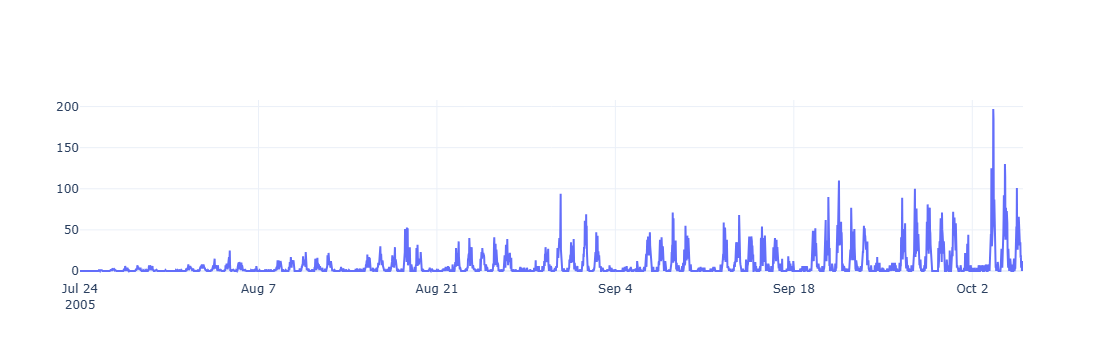

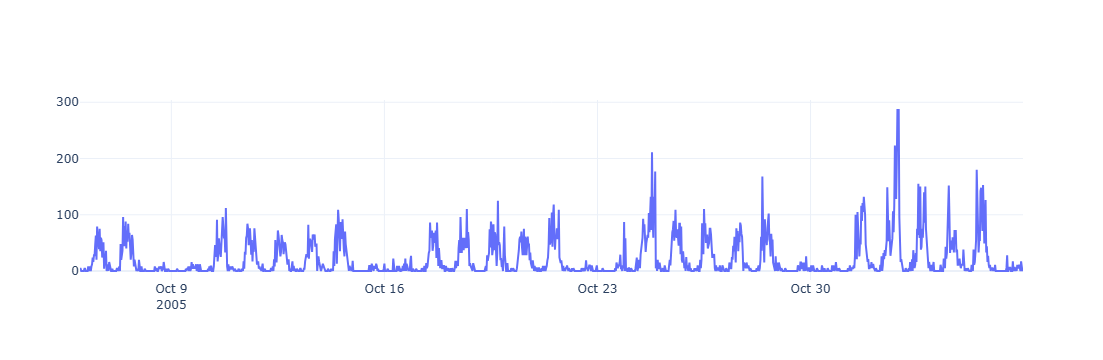

In [44]:
plotly_df(train.set_index('dt')[['cnt']])
plotly_df(test.set_index('dt')[['cnt']])

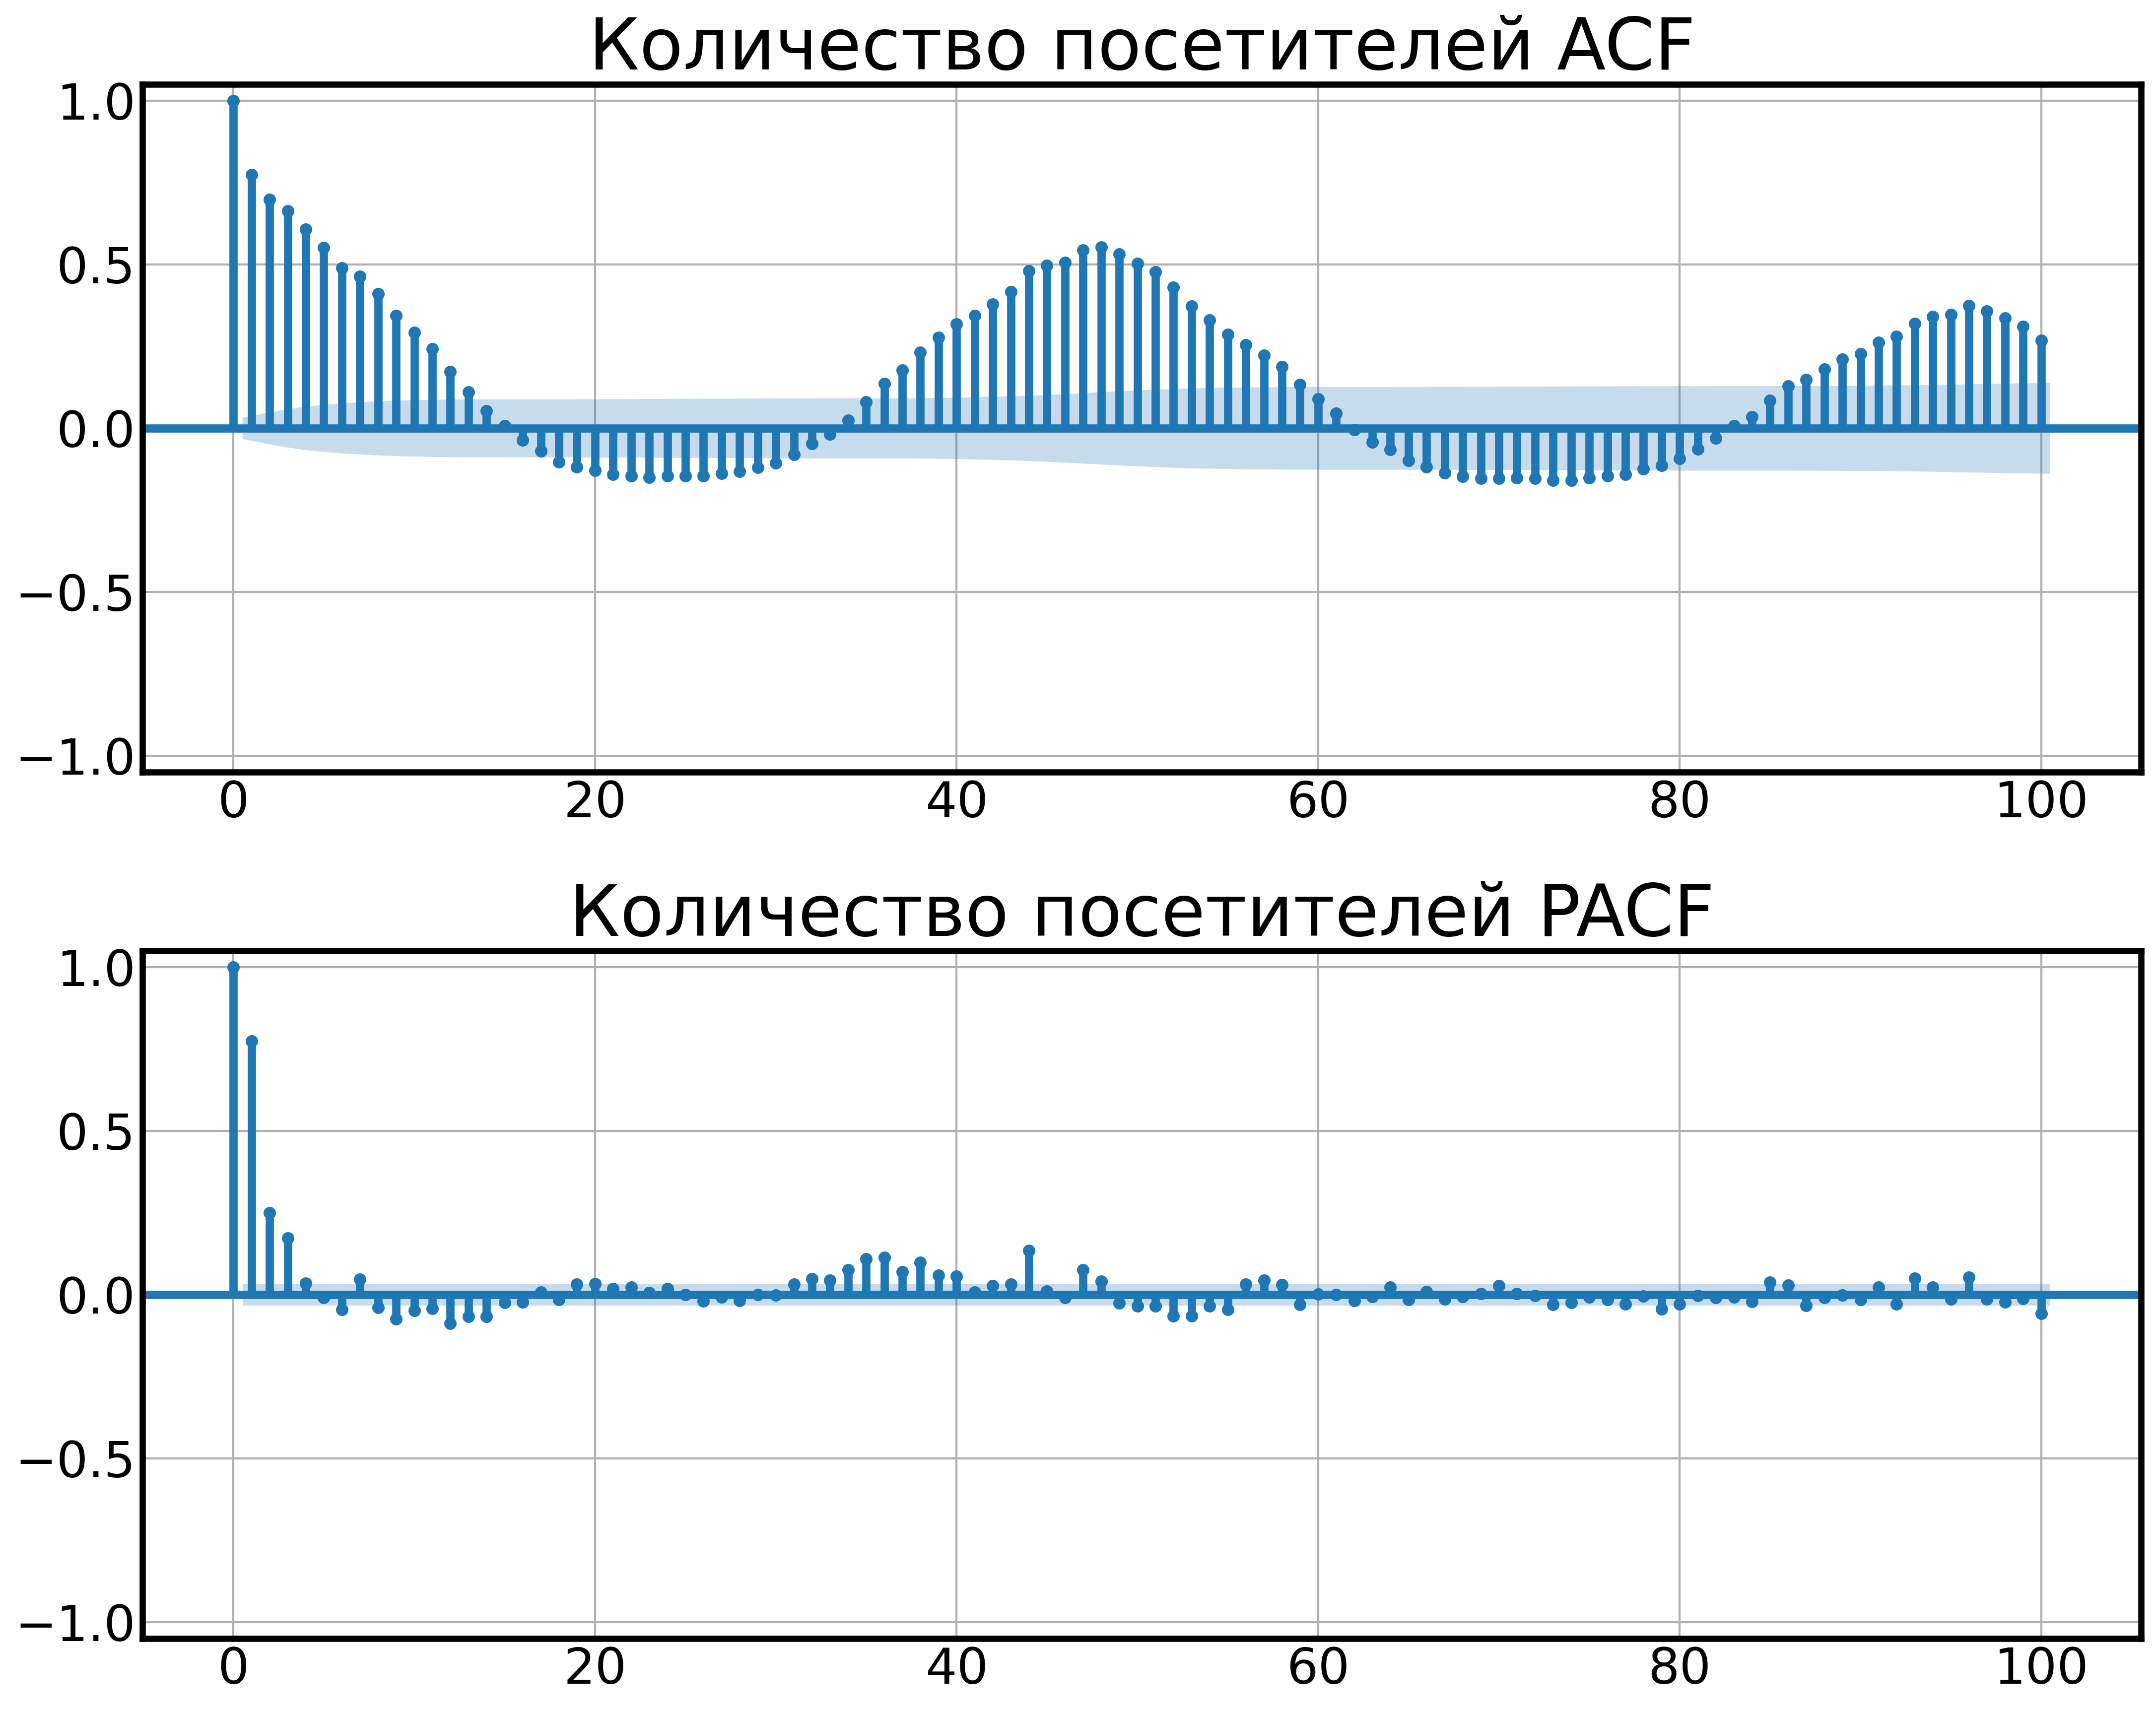

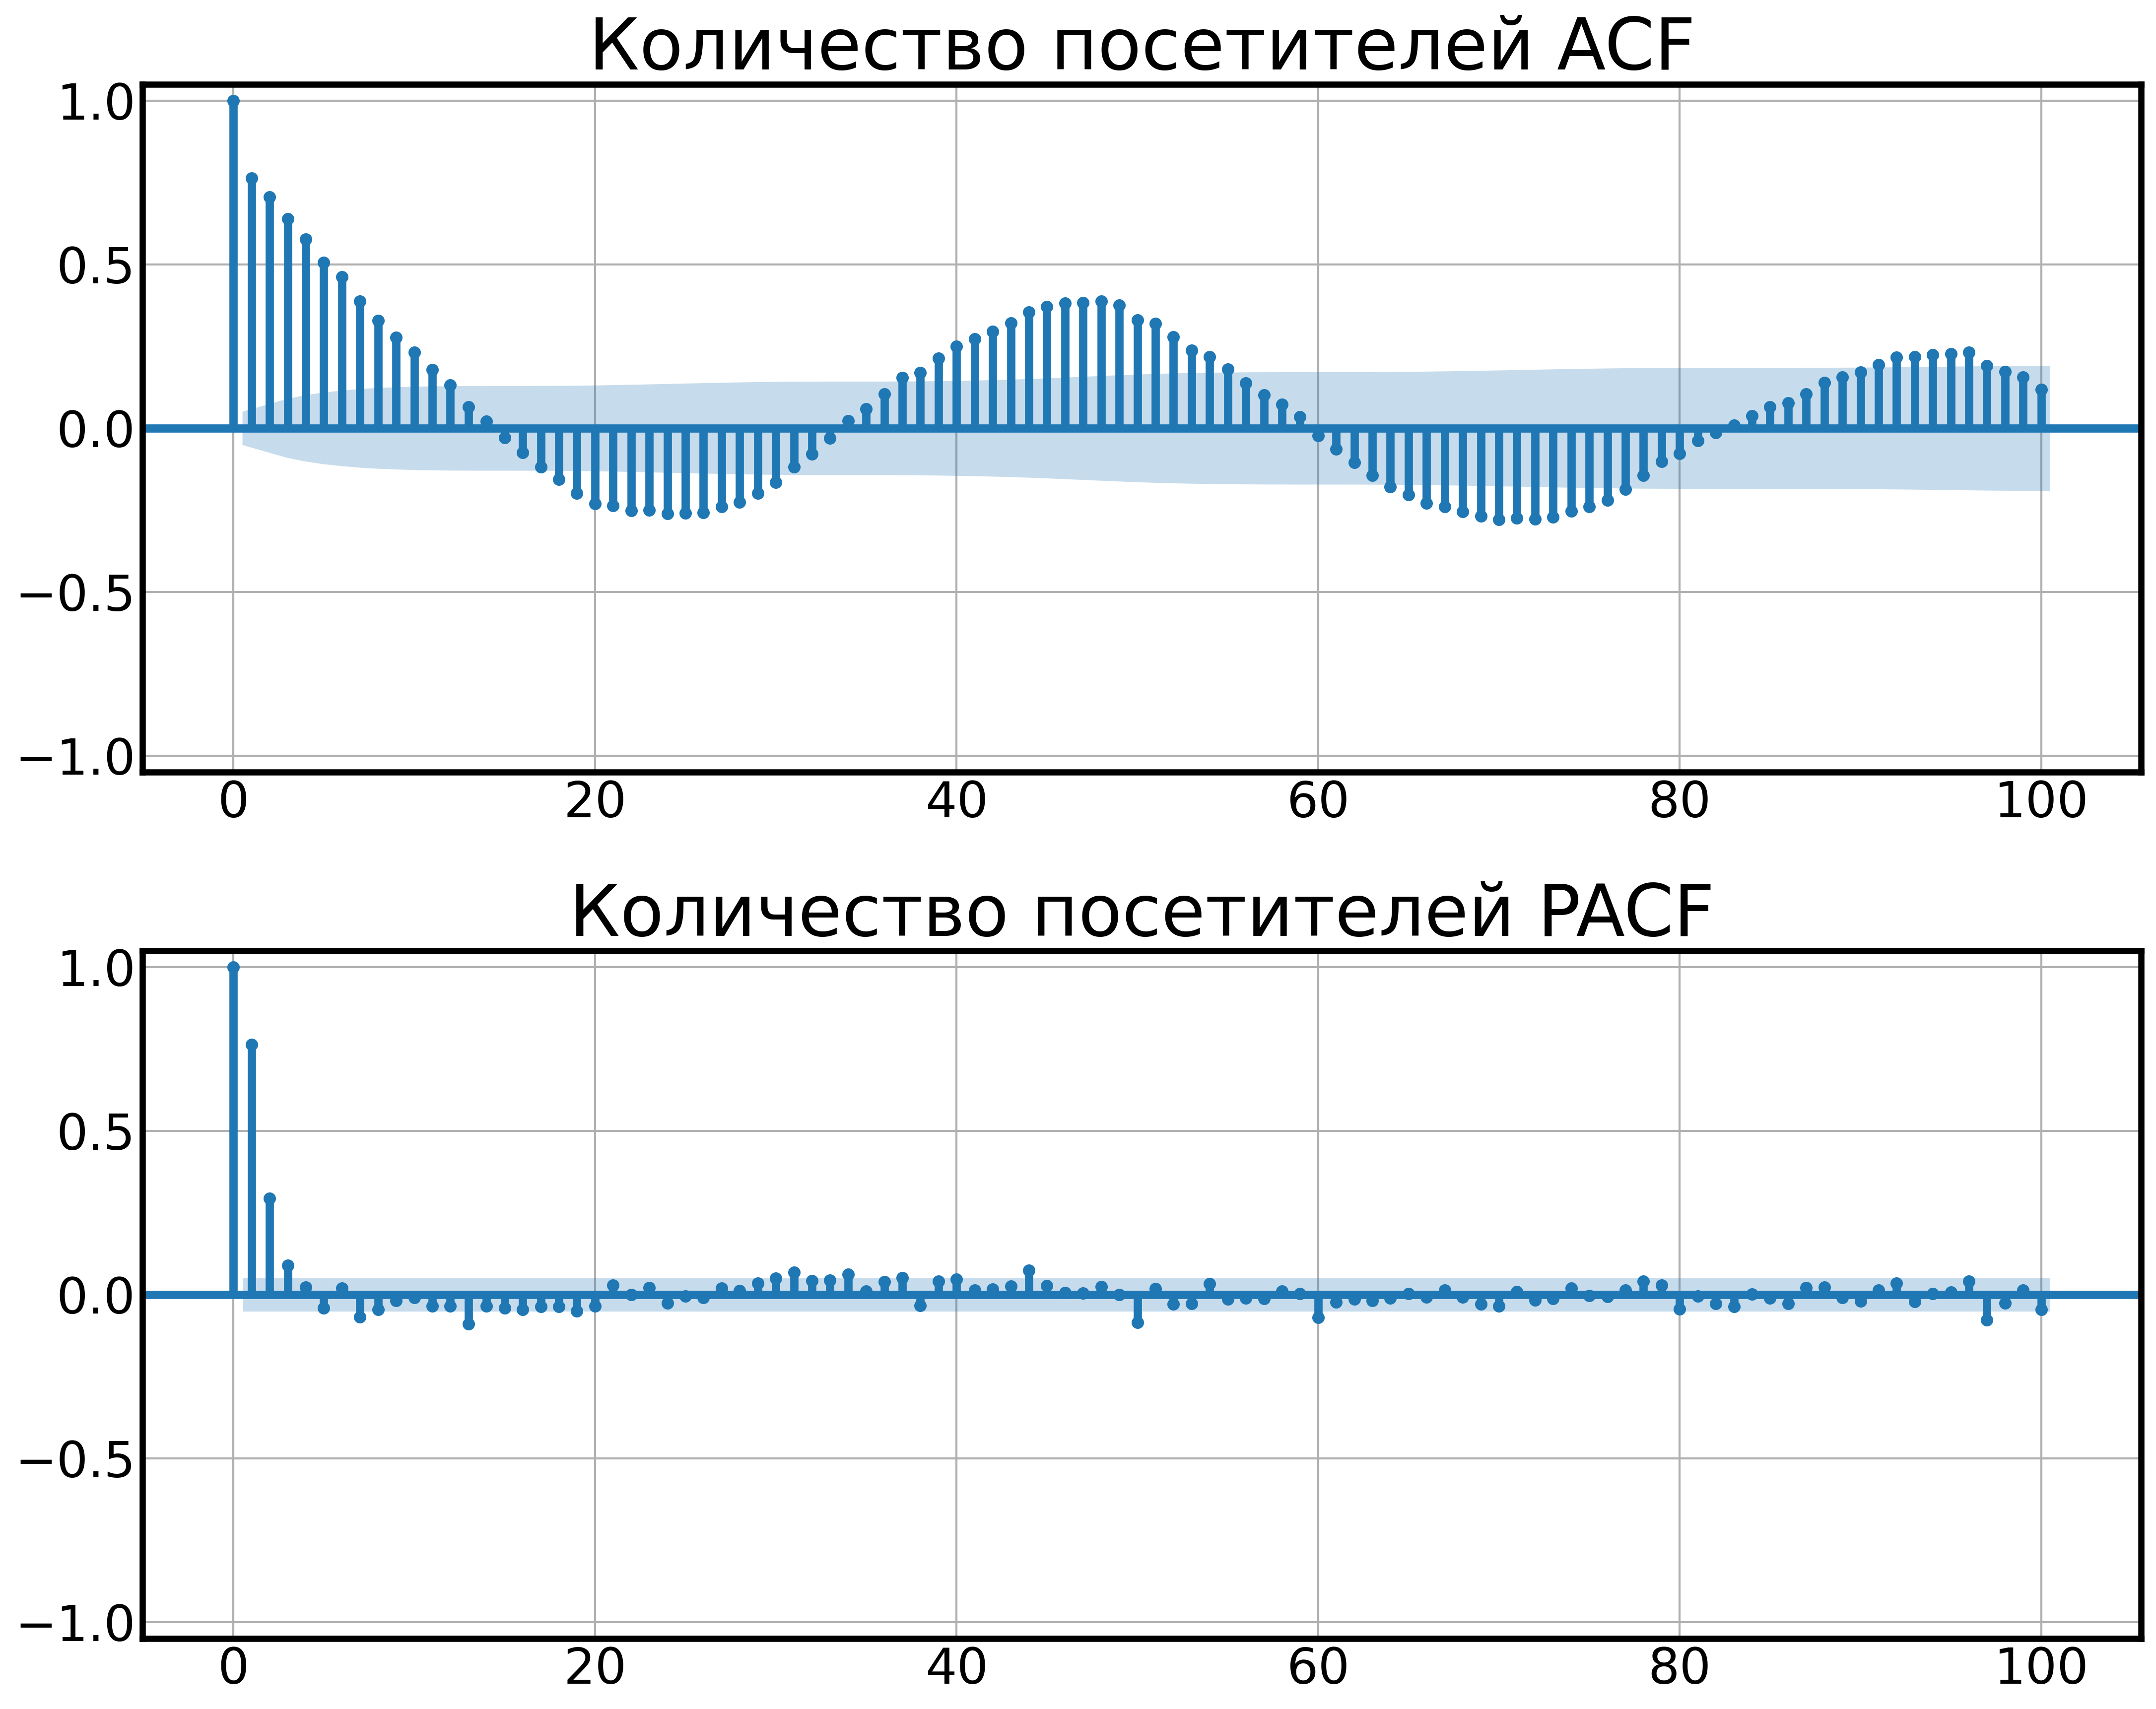

In [45]:
# Построить ACF/PACF
plot_acf_pacf(train['cnt'], lags=100, title_prefix="Количество посетителей")
plot_acf_pacf(test['cnt'], lags=100, title_prefix="Количество посетителей")

In [47]:
adf_test(train['cnt']) # Дики-Фуллера, тестирует наличие единичного корня
print()
print('-----------------------------------------------------------------------------------')
print()
kpss_test(train['cnt']) # проверяет тренд - тренд-стационарность, то есть, наличие или отсутствие тренда

Results of Dickey-Fuller Test:

Null Hypothesis: The series has a unit root. Data is NON stationary.
Test Statistic                -1.235100e+01
p-value                        5.825957e-23
#Lags Used                     1.900000e+01
Number of Observations Used    3.538000e+03
Critical Value (1%)           -3.432200e+00
Critical Value (5%)           -2.862357e+00
Critical Value (10%)          -2.567205e+00
dtype: float64

-----------------------------------------------------------------------------------

Results of KPSS Test:

Null Hypothesis: The process is trend stationary.
Test Statistic            3.721175
p-value                   0.010000
Lags Used                35.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


C:\Users\smirn\AppData\Local\Temp\ipykernel_22868\4104433627.py:13: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




#### Выводы:

1) Лаги делать не буду для модели, попробую оценить для начала без них;
2) Ряд нестационарен согласно проверке гипотезе о наличии единичного корня;
3) Заметная явная сезонность; что-то интуитивно напоминающее суточную зависимость (?).

#### Дифференцируем `cnt`

In [50]:
# Вычисление первого дифференцирования
train['cnt_diff'] = train['cnt'].diff()
train = train.dropna(subset=['cnt_diff'])

# Второго

train['cnt_diff2'] = train['cnt_diff'].diff()
train = train.dropna(subset=['cnt_diff2'])

C:\Users\smirn\AppData\Local\Temp\ipykernel_22868\707030637.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [51]:
# Вычисление первого дифференцирования
test['cnt_diff'] = test['cnt'].diff()
test = test.dropna(subset=['cnt_diff'])

# Второго

test['cnt_diff2'] = test['cnt_diff'].diff()
test = test.dropna(subset=['cnt_diff2'])

C:\Users\smirn\AppData\Local\Temp\ipykernel_22868\1779607902.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



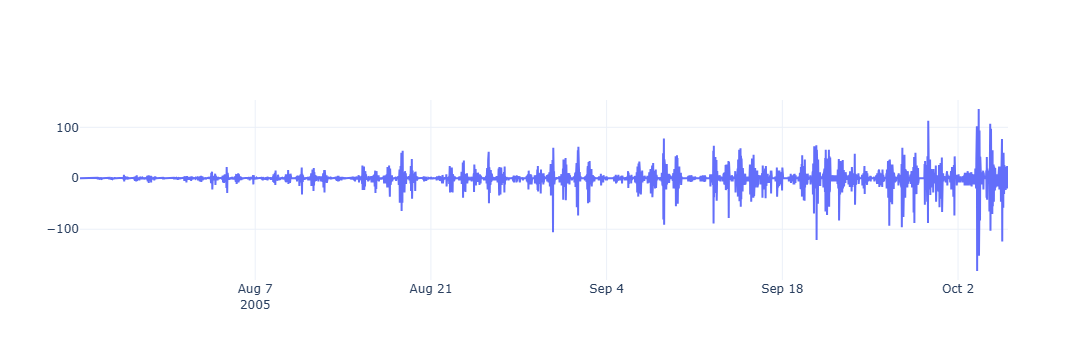

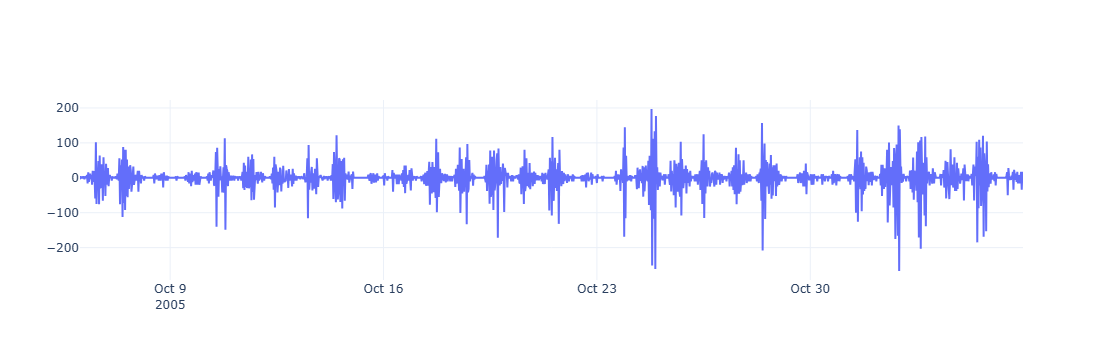

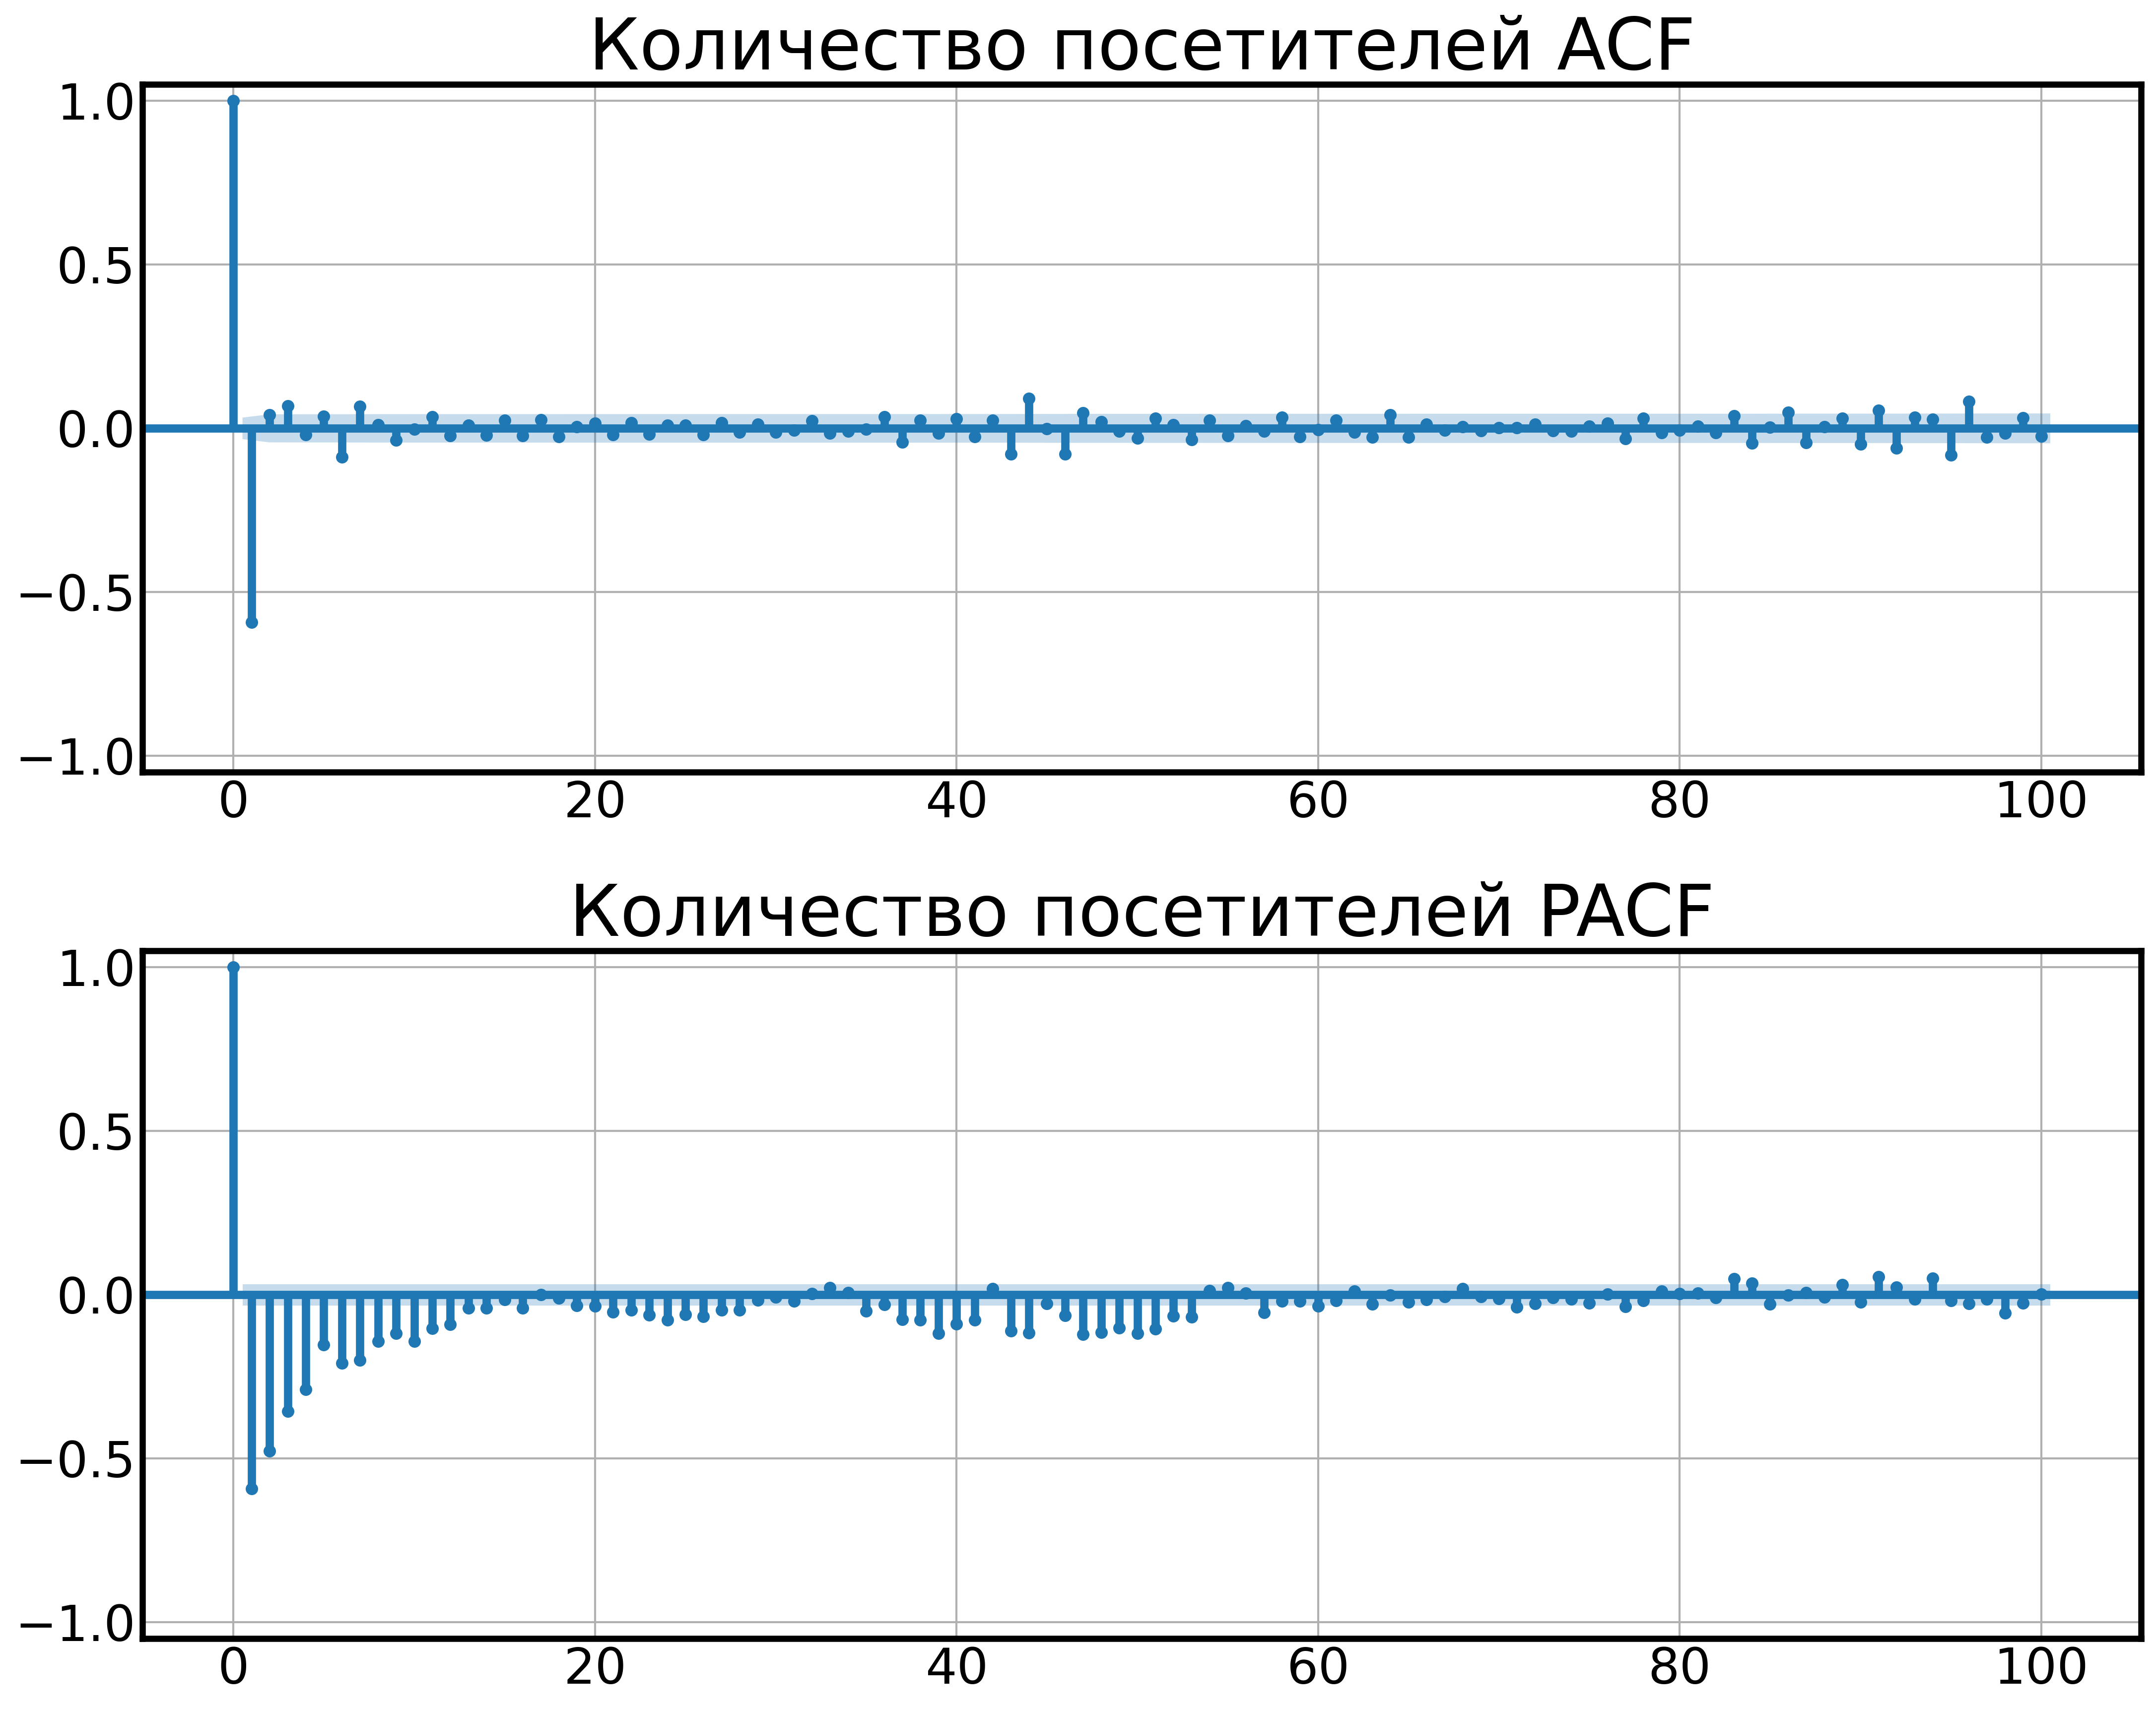

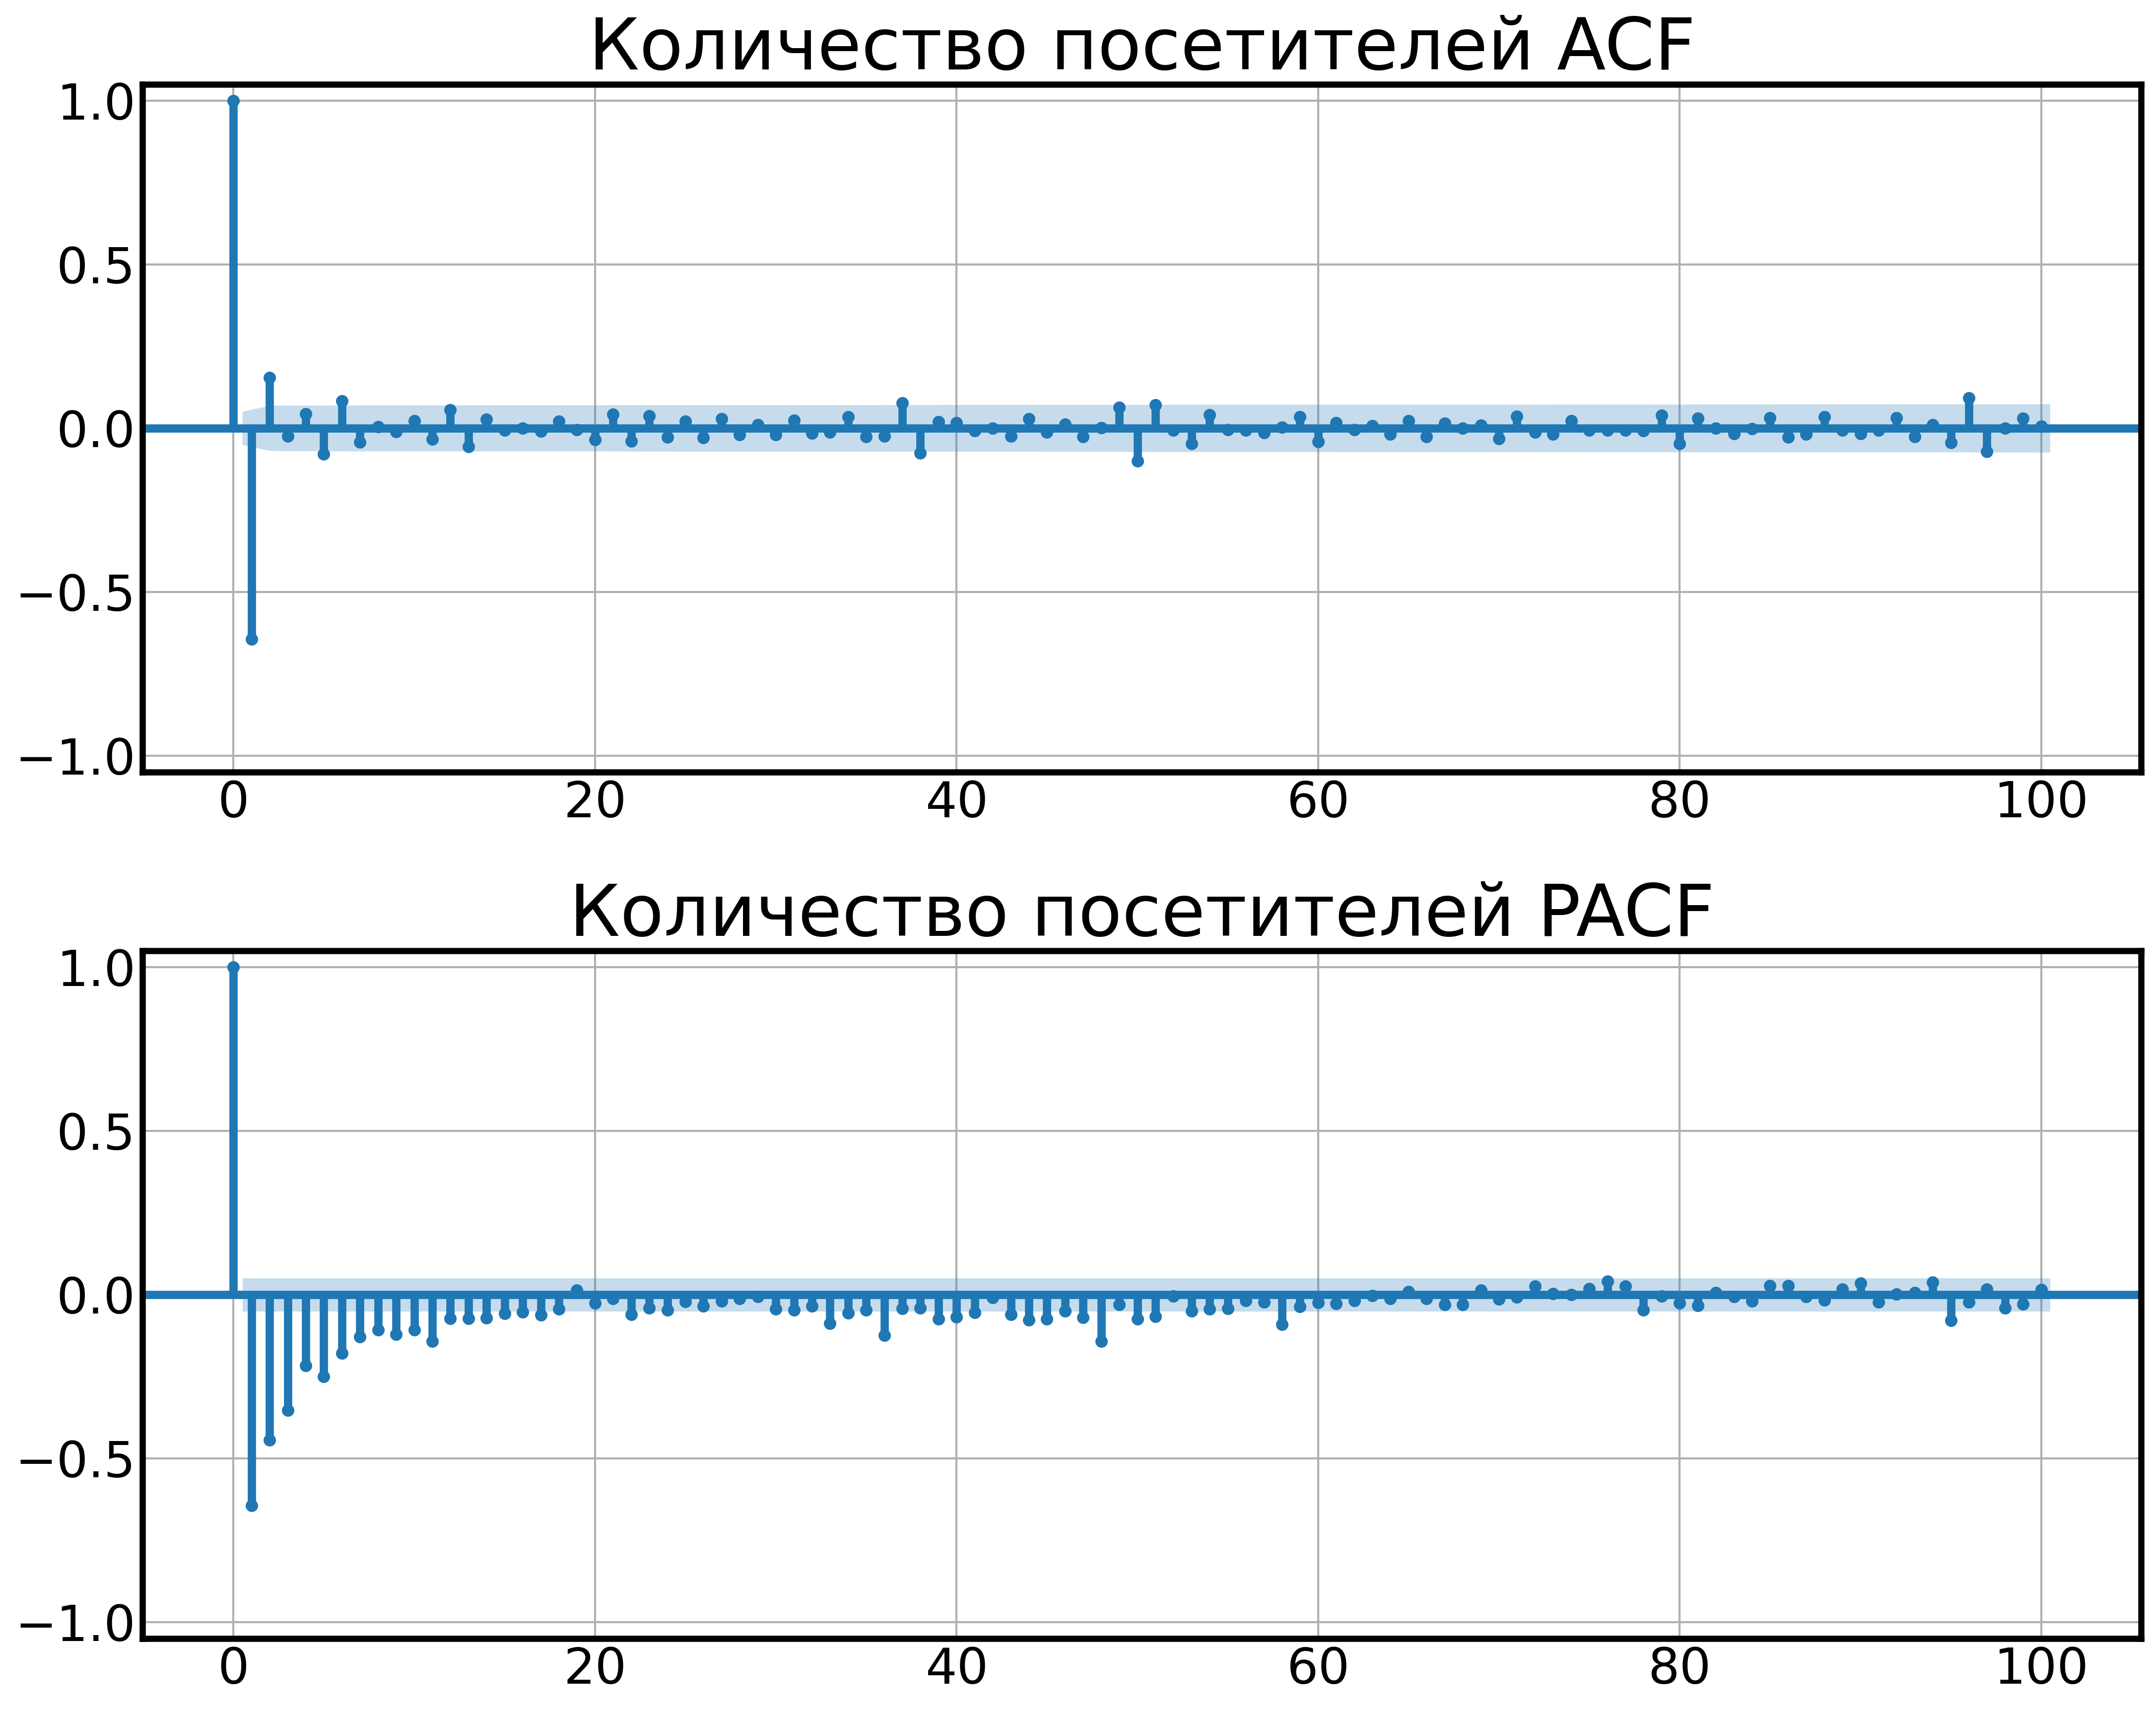

Results of Dickey-Fuller Test:

Null Hypothesis: The series has a unit root. Data is NON stationary.
Test Statistic                  -20.473002
p-value                           0.000000
#Lags Used                       27.000000
Number of Observations Used    3528.000000
Critical Value (1%)              -3.432205
Critical Value (5%)              -2.862360
Critical Value (10%)             -2.567206
dtype: float64

-----------------------------------------------------------------------------------

Results of KPSS Test:

Null Hypothesis: The process is trend stationary.
Test Statistic            0.014588
p-value                   0.100000
Lags Used                99.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


C:\Users\smirn\AppData\Local\Temp\ipykernel_22868\4104433627.py:13: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




In [52]:
plotly_df(train.set_index('dt')[['cnt_diff2']])
plotly_df(test.set_index('dt')[['cnt_diff2']])

# Построить ACF/PACF
plot_acf_pacf(train['cnt_diff2'], lags=100, title_prefix="Количество посетителей")
plot_acf_pacf(test['cnt_diff2'], lags=100, title_prefix="Количество посетителей")

adf_test(train['cnt_diff2']) # Дики-Фуллера, тестирует наличие единичного корня
print()
print('-----------------------------------------------------------------------------------')
print()
kpss_test(train['cnt_diff2']) # проверяет тренд - тренд-стационарность, то есть, наличие или отсутствие тренда

#### Но пока будет просто как идея; результаты не очень.

### 1. Для каждой записи (дата+время) определить, было ли в этот момент какое-то мероприятие или нет (считать, что данные о количестве пользователей на дата+время известны)  

In [55]:
train.columns

Index(['dt', 'cnt', 'is_event', 'month', 'day', 'week', 'day_of_week',
       'is_weekend', 'hour', 'minute', 'time_of_day_afternoon',
       'time_of_day_evening', 'time_of_day_morning', 'time_of_day_night',
       'holiday_Labor Day', 'holiday_No Holiday', 'cnt_diff', 'cnt_diff2'],
      dtype='object')

#### Думаю, есть смысл работать с Recall

#### Список фичей

In [58]:
train.columns

Index(['dt', 'cnt', 'is_event', 'month', 'day', 'week', 'day_of_week',
       'is_weekend', 'hour', 'minute', 'time_of_day_afternoon',
       'time_of_day_evening', 'time_of_day_morning', 'time_of_day_night',
       'holiday_Labor Day', 'holiday_No Holiday', 'cnt_diff', 'cnt_diff2'],
      dtype='object')

In [59]:
model_features = [
                  'cnt', 
                  'is_event', 
                  'month', 
                  'day', 
                  'week', 
                  'day_of_week',
                  'is_weekend', 
                  'hour', 
                  'minute', 
                  'time_of_day_afternoon',
                  'time_of_day_evening', 
                  'time_of_day_morning', 
                  'time_of_day_night',
                  'holiday_Labor Day', 
                  'holiday_No Holiday'
                 ]

#### Посмотрим важность признаков для регрессии

In [61]:
def permutation_importance_CatBoostRegressor(X_train, y_train, X_test, y_test, n_repeats=10, threshold=0.01, metric='rmse',
                           n_top_features=None, plot=True, cat_features=None):
    """
    Реализация алгоритма важности на основе перестановок (permutation importance) для задачи регрессии
    с использованием CatBoostRegressor.

    Алгоритм оценивает важность признака путем перемешивания его значений и измерения ухудшения качества модели
    по метрике RMSE (Root Mean Squared Error).

    Параметры:
    ----------
    X_train : pandas DataFrame
        Признаки обучающей выборки
    y_train : pandas Series или numpy array
        Целевая переменная обучающей выборки
    X_test : pandas DataFrame
        Признаки тестовой выборки
    y_test : pandas Series или numpy array
        Целевая переменная тестовой выборки
    n_repeats : int, по умолчанию 10
        Количество повторений перемешивания для каждого признака
    threshold : float, по умолчанию 0.01
        Пороговое значение важности для отбора признаков (в единицах RMSE)
    metric : str, по умолчанию 'rmse'
        Метрика для оценки качества модели (поддерживается только 'rmse')
    n_top_features : int или None, по умолчанию None
        Количество лучших признаков для отбора. Если указано, threshold игнорируется
    plot : bool, по умолчанию True
        Создавать ли график важности признаков
    cat_features : list или None, по умолчанию None
        Список категориальных признаков, если таковые имеются.

    Возвращает:
    -----------
    pandas DataFrame
        Датафрейм с важностью признаков и обоснованием выбора
    list
        Список выбранных признаков
    """
    if metric != 'rmse':
        raise ValueError("Для задачи регрессии поддерживается только метрика 'rmse'.")

    model = CatBoostRegressor(
        iterations=800,
        learning_rate=0.1,
        depth=5,
        loss_function='RMSE',
        verbose=False,
        random_state=42
    )

    if cat_features is not None:
        model.fit(X_train, y_train, cat_features=cat_features)
    else:
        model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    baseline_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"Базовый RMSE модели: {baseline_rmse:.4f}")

    feature_importance = {}
    feature_scores = {}

    for feature in X_test.columns:
        importance_scores = []
        permuted_scores = []

        for _ in range(n_repeats):
            X_test_permuted = X_test.copy()
            X_test_permuted[feature] = np.random.permutation(X_test_permuted[feature].values)
            y_pred_permuted = model.predict(X_test_permuted)
            permuted_rmse = np.sqrt(mean_squared_error(y_test, y_pred_permuted))
            permuted_scores.append(permuted_rmse)
            importance_scores.append(permuted_rmse - baseline_rmse)

        feature_importance[feature] = np.mean(importance_scores)
        feature_scores[feature] = np.mean(permuted_scores)

    importance_df = pd.DataFrame({
        'feature': list(feature_importance.keys()),
        'importance': list(feature_importance.values()),
        'permuted_rmse': list(feature_scores.values())
    }).sort_values('importance', ascending=False)

    importance_df['percent_increase'] = (importance_df['importance'] / baseline_rmse) * 100

    def get_justification(row):
        if row['importance'] <= 0:
            return "Признак не влияет на качество модели или его перемешивание улучшает модель"
        elif row['percent_increase'] < 1:
            return "Незначительное влияние на модель (менее 1% увеличения RMSE)"
        elif row['percent_increase'] < 5:
            return "Умеренное влияние на модель (1-5% увеличения RMSE)"
        elif row['percent_increase'] < 10:
            return "Существенное влияние на модель (5-10% увеличения RMSE)"
        else:
            return "Критически важный признак (более 10% увеличения RMSE)"

    importance_df['justification'] = importance_df.apply(get_justification, axis=1)

    if n_top_features is not None:
        selected_features = importance_df.head(n_top_features)['feature'].tolist()
        importance_df['selected'] = importance_df['feature'].isin(selected_features)
    else:
        selected_features = importance_df[importance_df['importance'] > threshold]['feature'].tolist()
        importance_df['selected'] = importance_df['importance'] > threshold

    print("\nВажность признаков (permutation importance):")
    print(importance_df)

    print(f"\nВыбрано {len(selected_features)} признаков:")
    for feature in selected_features:
        row = importance_df[importance_df['feature'] == feature].iloc[0]
        print(f"- {feature}: важность = {row['importance']:.4f}, "
              f"увеличение RMSE = {row['percent_increase']:.2f}%, "
              f"обоснование: {row['justification']}")

    if plot and not importance_df.empty:
        plt.figure(figsize=(20, 16))
        sorted_df = importance_df.sort_values('importance')
        colors = ['green' if selected else 'gray' for selected in sorted_df['selected']]
        plt.barh(sorted_df['feature'], sorted_df['importance'], color=colors)
        if n_top_features is None:
            plt.axvline(x=threshold, color='red', linestyle='--',
                        label=f'Пороговое значение ({threshold})')
            plt.legend()
        plt.xlabel('Увеличение RMSE')
        plt.ylabel('Признаки')
        plt.title('Permutation Importance признаков (RMSE) - CatBoostRegressor')
        plt.grid(axis='x', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()
        print("График важности признаков отображен.")

    return importance_df, selected_features

Базовый RMSE модели: 25.0829

Важность признаков (permutation importance):
                  feature  importance  permuted_rmse  percent_increase  \
6                    hour    5.710546      30.793461         22.766678   
8   time_of_day_afternoon    2.977914      28.060828         11.872280   
4             day_of_week    2.569456      27.652371         10.243851   
5              is_weekend    1.440826      26.523741          5.744253   
0                is_event    0.583746      25.666660          2.327264   
7                  minute    0.407234      25.490148          1.623550   
2                     day    0.204792      25.287706          0.816458   
13     holiday_No Holiday    0.095477      25.178391          0.380644   
11      time_of_day_night    0.033202      25.116117          0.132369   
9     time_of_day_evening    0.008058      25.090972          0.032124   
1                   month    0.000000      25.082915          0.000000   
3                    week    0.000000

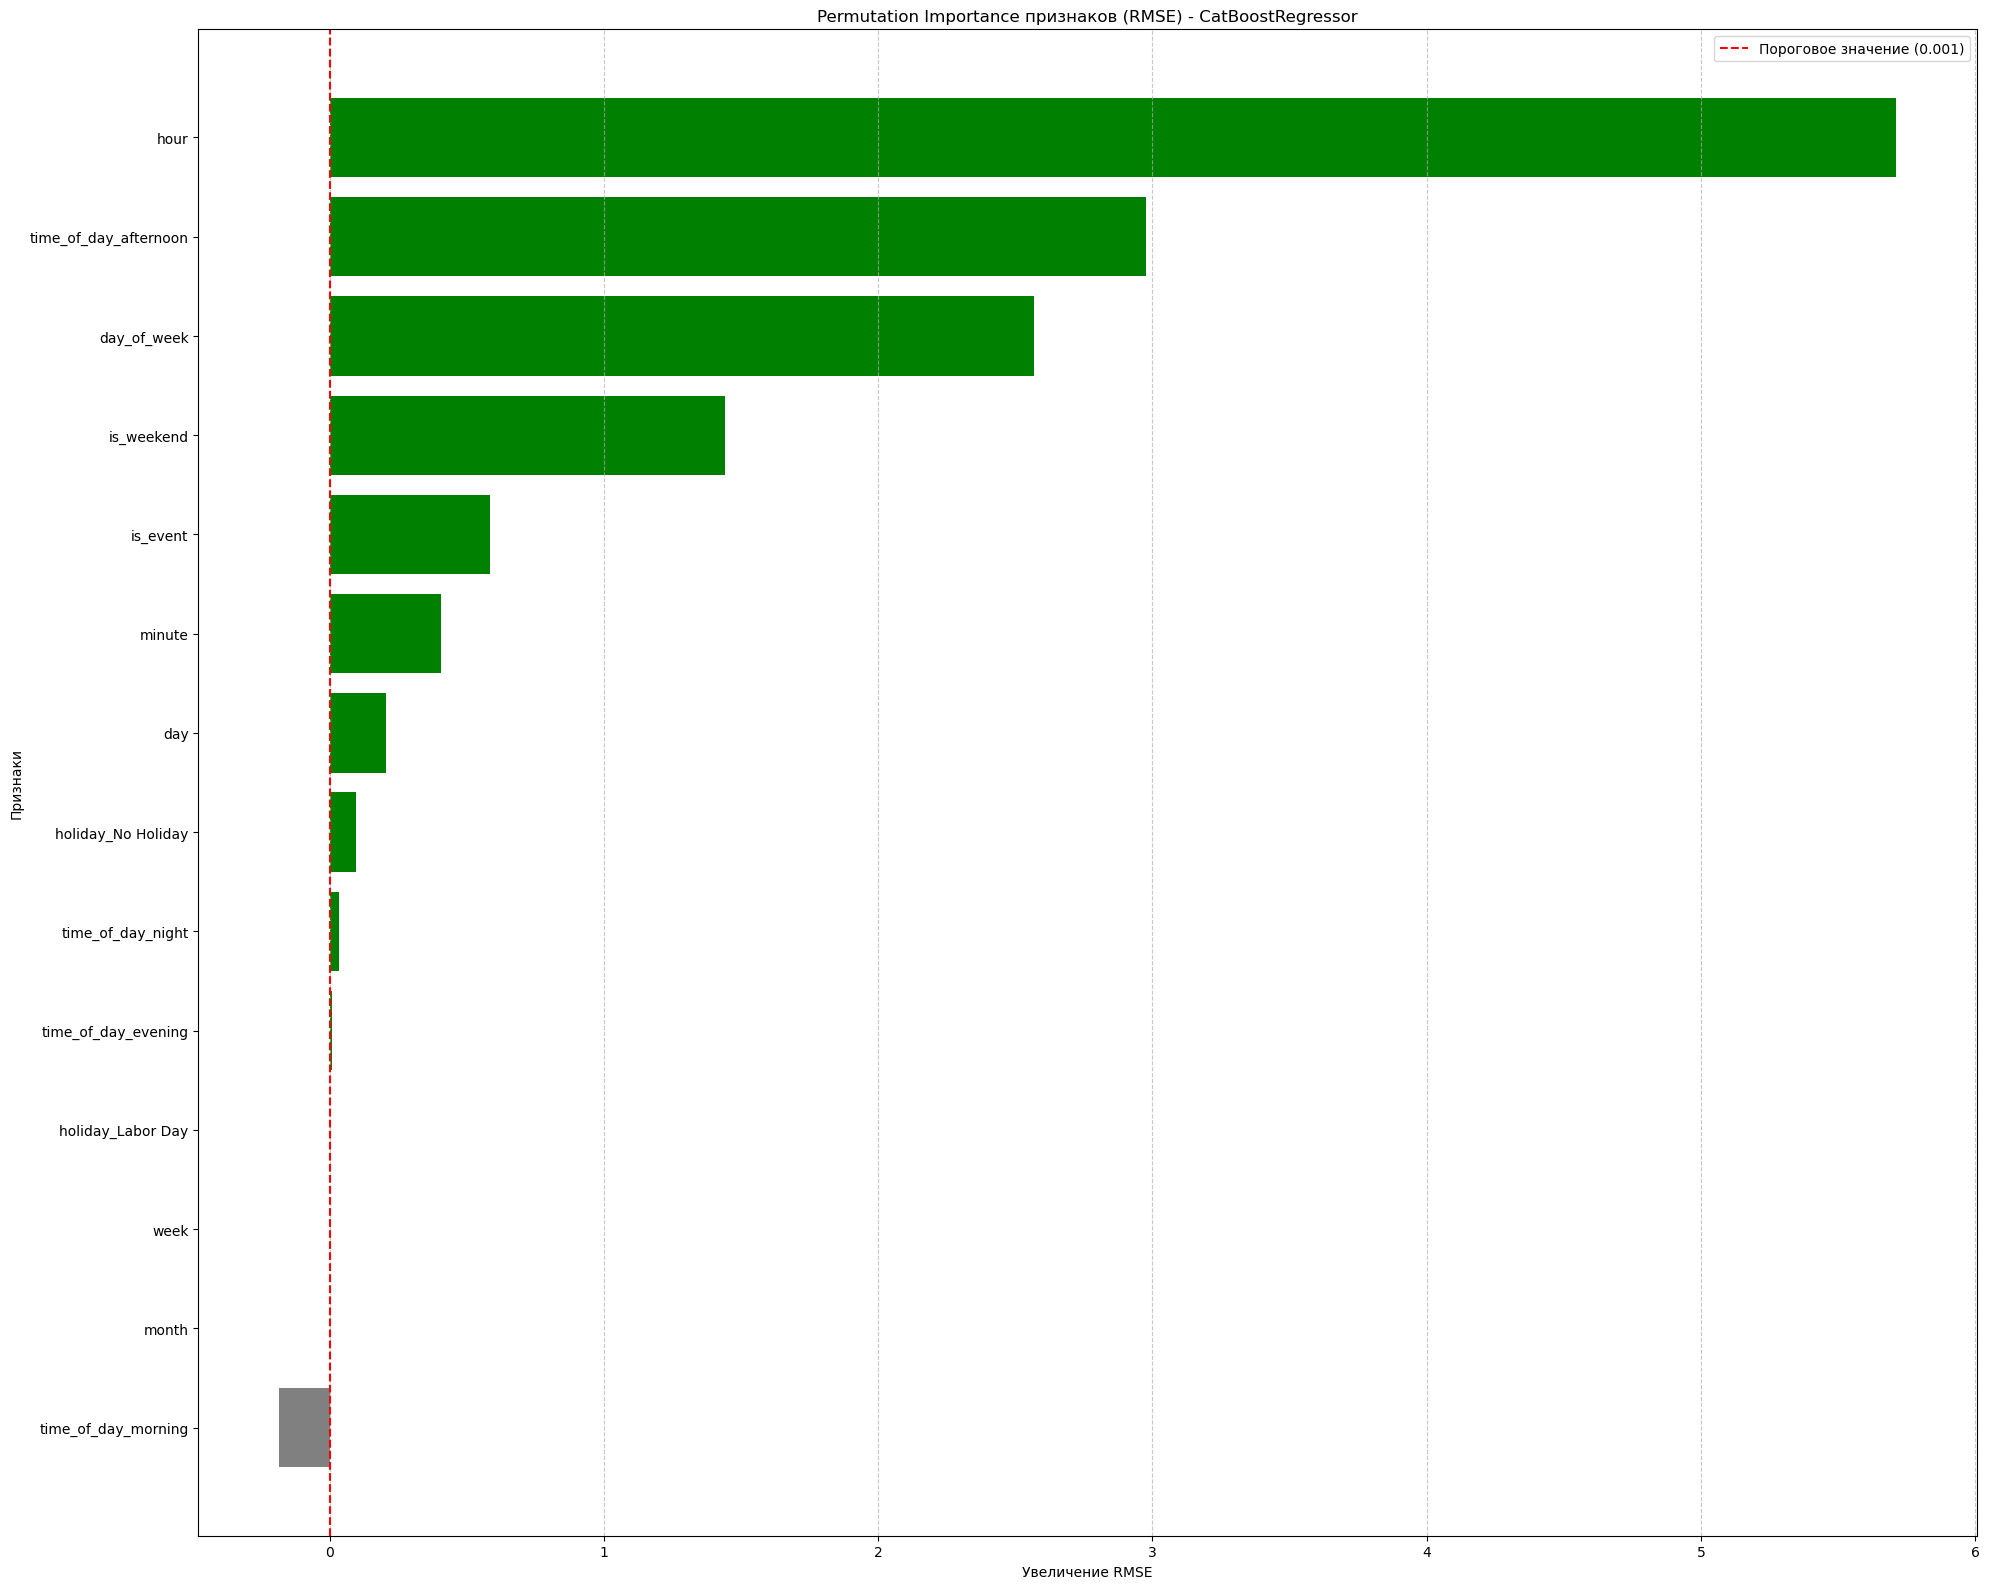

График важности признаков отображен.


In [62]:
model_features = [
                  # 'cnt', 
                  'is_event', 
                  'month', 
                  'day', 
                  'week', 
                  'day_of_week',
                  'is_weekend', 
                  'hour', 
                  'minute', 
                  'time_of_day_afternoon',
                  'time_of_day_evening', 
                  'time_of_day_morning', 
                  'time_of_day_night',
                  'holiday_Labor Day', 
                  'holiday_No Holiday'
                 ]


importance_df, selected_features = permutation_importance_CatBoostRegressor(
    X_train=train[model_features],
    y_train=train['cnt'],
    X_test=test[model_features],
    y_test=test['cnt'],
    n_repeats=10,
    threshold=0.001,
    metric='rmse',
    cat_features=None
)

#### Сохраним

In [64]:
selected_features_regression = selected_features
model_features_regression = selected_features_regression

### Классификация

In [66]:
def permutation_importance_CatBoostClassifier(X_train, y_train, X_test, y_test, n_repeats=10, threshold=0.01, metric='recall',
                           n_top_features=None, plot=True, cat_features=None, threshold_pred=0.5):
    """
    Реализация permutation importance для задачи классификации с использованием CatBoostClassifier.

    Алгоритм оценивает важность признака путем перемешивания его значений и измерения ухудшения качества модели
    по метрике (по умолчанию Recall).

    Параметры:
    ----------
    X_train, y_train, X_test, y_test : pandas DataFrame / Series
        Обучающая и тестовая выборки
    n_repeats : int
        Кол-во повторов перемешивания признаков
    threshold : float
        Порог важности для отбора признаков
    metric : str
        Метрика для оценки (только 'recall' пока)
    n_top_features : int
        Сколько лучших признаков оставить
    plot : bool
        Отображать ли график
    cat_features : list
        Список категориальных признаков
    threshold_pred : float
        Порог вероятности для предсказания класса 1

    Возвращает:
    -----------
    DataFrame с важностями, список выбранных признаков
    """

    if metric != 'recall':
        raise ValueError("Пока поддерживается только метрика 'recall'.")

    model = CatBoostClassifier(
        iterations=800,
        learning_rate=0.1,
        depth=5,
        loss_function='Logloss',
        verbose=False,
        random_state=42
    )

    if cat_features is not None:
        model.fit(X_train, y_train, cat_features=cat_features)
    else:
        model.fit(X_train, y_train)

    y_pred_proba = model.predict_proba(X_test)[:, 1]
    y_pred = (y_pred_proba >= threshold_pred).astype(int)
    baseline_score = recall_score(y_test, y_pred, zero_division=0)
    print(f"Базовый Recall модели: {baseline_score:.4f}")

    feature_importance = {}
    feature_scores = {}

    for feature in X_test.columns:
        scores = []

        for _ in range(n_repeats):
            X_test_permuted = X_test.copy()
            X_test_permuted[feature] = np.random.permutation(X_test_permuted[feature].values)

            y_perm_proba = model.predict_proba(X_test_permuted)[:, 1]
            y_perm_pred = (y_perm_proba >= threshold_pred).astype(int)
            score = recall_score(y_test, y_perm_pred, zero_division=0)

            scores.append(baseline_score - score)

        feature_importance[feature] = np.mean(scores)
        feature_scores[feature] = np.mean(scores)  # то же самое

    importance_df = pd.DataFrame({
        'feature': list(feature_importance.keys()),
        'importance': list(feature_importance.values())
    }).sort_values('importance', ascending=False)

    importance_df['percent_decrease'] = (importance_df['importance'] / baseline_score) * 100

    def get_justification(row):
        if row['importance'] <= 0:
            return "Признак не влияет или улучшает модель"
        elif row['percent_decrease'] < 1:
            return "Незначительное влияние (менее 1% ухудшения recall)"
        elif row['percent_decrease'] < 5:
            return "Умеренное влияние (1-5%)"
        elif row['percent_decrease'] < 10:
            return "Существенное влияние (5-10%)"
        else:
            return "Критически важный признак (более 10%)"

    importance_df['justification'] = importance_df.apply(get_justification, axis=1)

    if n_top_features is not None:
        selected_features = importance_df.head(n_top_features)['feature'].tolist()
        importance_df['selected'] = importance_df['feature'].isin(selected_features)
    else:
        selected_features = importance_df[importance_df['importance'] > threshold]['feature'].tolist()
        importance_df['selected'] = importance_df['importance'] > threshold

    print("\nВажность признаков (permutation importance):")
    print(importance_df)

    print(f"\nВыбрано {len(selected_features)} признаков:")
    for feature in selected_features:
        row = importance_df[importance_df['feature'] == feature].iloc[0]
        print(f"- {feature}: важность = {row['importance']:.4f}, "
              f"уменьшение Recall = {row['percent_decrease']:.2f}%, "
              f"обоснование: {row['justification']}")

    if plot and not importance_df.empty:
        plt.figure(figsize=(20, 16))
        sorted_df = importance_df.sort_values('importance')
        colors = ['green' if selected else 'gray' for selected in sorted_df['selected']]
        plt.barh(sorted_df['feature'], sorted_df['importance'], color=colors)
        if n_top_features is None:
            plt.axvline(x=threshold, color='red', linestyle='--',
                        label=f'Пороговое значение ({threshold})')
            plt.legend()
        plt.xlabel('Уменьшение Recall')
        plt.ylabel('Признаки')
        plt.title('Permutation Importance (Recall) - CatBoostClassifier')
        plt.grid(axis='x', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()
        print("График важности признаков отображен.")

    return importance_df, selected_features

#### Добавим нелинейность

In [68]:
# Для train
train['cnt_log'] = np.log1p(train['cnt'])
train['cnt_squared'] = train['cnt'] ** 2
train['cnt_cubed'] = train['cnt'] ** 3

# Для test
test['cnt_log'] = np.log1p(test['cnt'])
test['cnt_squared'] = test['cnt'] ** 2
test['cnt_cubed'] = test['cnt'] ** 3

#### Еще кое-то добавим

In [70]:
for window in [3, 6, 12, 24]:
    train[f'cnt_roll_mean_{window}'] = train['cnt'].rolling(window).mean()
    test[f'cnt_roll_mean_{window}'] = test['cnt'].rolling(window).mean()
for window in [12, 24]:
    train[f'cnt_roll_std_{window}'] = train['cnt'].rolling(window).std()
    test[f'cnt_roll_std_{window}'] = test['cnt'].rolling(window).std()


# train['hour_sin'] = np.sin(2 * np.pi * train['hour'] / 24)
# train['hour_cos'] = np.cos(2 * np.pi * train['hour'] / 24)
# train['weekday_sin'] = np.sin(2 * np.pi * train['weekday'] / 7)
# train['weekday_cos'] = np.cos(2 * np.pi * train['weekday'] / 7)

# test['hour_sin'] = np.sin(2 * np.pi * test['hour'] / 24)
# test['hour_cos'] = np.cos(2 * np.pi * test['hour'] / 24)
# test['weekday_sin'] = np.sin(2 * np.pi * test['weekday'] / 7)
# test['weekday_cos'] = np.cos(2 * np.pi * test['weekday'] / 7)

In [71]:
train.columns

Index(['dt', 'cnt', 'is_event', 'month', 'day', 'week', 'day_of_week',
       'is_weekend', 'hour', 'minute', 'time_of_day_afternoon',
       'time_of_day_evening', 'time_of_day_morning', 'time_of_day_night',
       'holiday_Labor Day', 'holiday_No Holiday', 'cnt_diff', 'cnt_diff2',
       'cnt_log', 'cnt_squared', 'cnt_cubed', 'cnt_roll_mean_3',
       'cnt_roll_mean_6', 'cnt_roll_mean_12', 'cnt_roll_mean_24',
       'cnt_roll_std_12', 'cnt_roll_std_24'],
      dtype='object')

Базовый Recall модели: 0.1842

Важность признаков (permutation importance):
                  feature  importance  percent_decrease  \
19        cnt_roll_mean_6    0.094737         51.428571   
17              cnt_cubed    0.089474         48.571429   
15                cnt_log    0.089474         48.571429   
20       cnt_roll_mean_12    0.076316         41.428571   
18        cnt_roll_mean_3    0.076316         41.428571   
0                     cnt    0.073684         40.000000   
10    time_of_day_morning    0.018421         10.000000   
4             day_of_week    0.013158          7.142857   
5              is_weekend    0.013158          7.142857   
11      time_of_day_night    0.000000          0.000000   
1                   month    0.000000          0.000000   
12      holiday_Labor Day    0.000000          0.000000   
9     time_of_day_evening    0.000000          0.000000   
8   time_of_day_afternoon    0.000000          0.000000   
3                    week    0.000000  

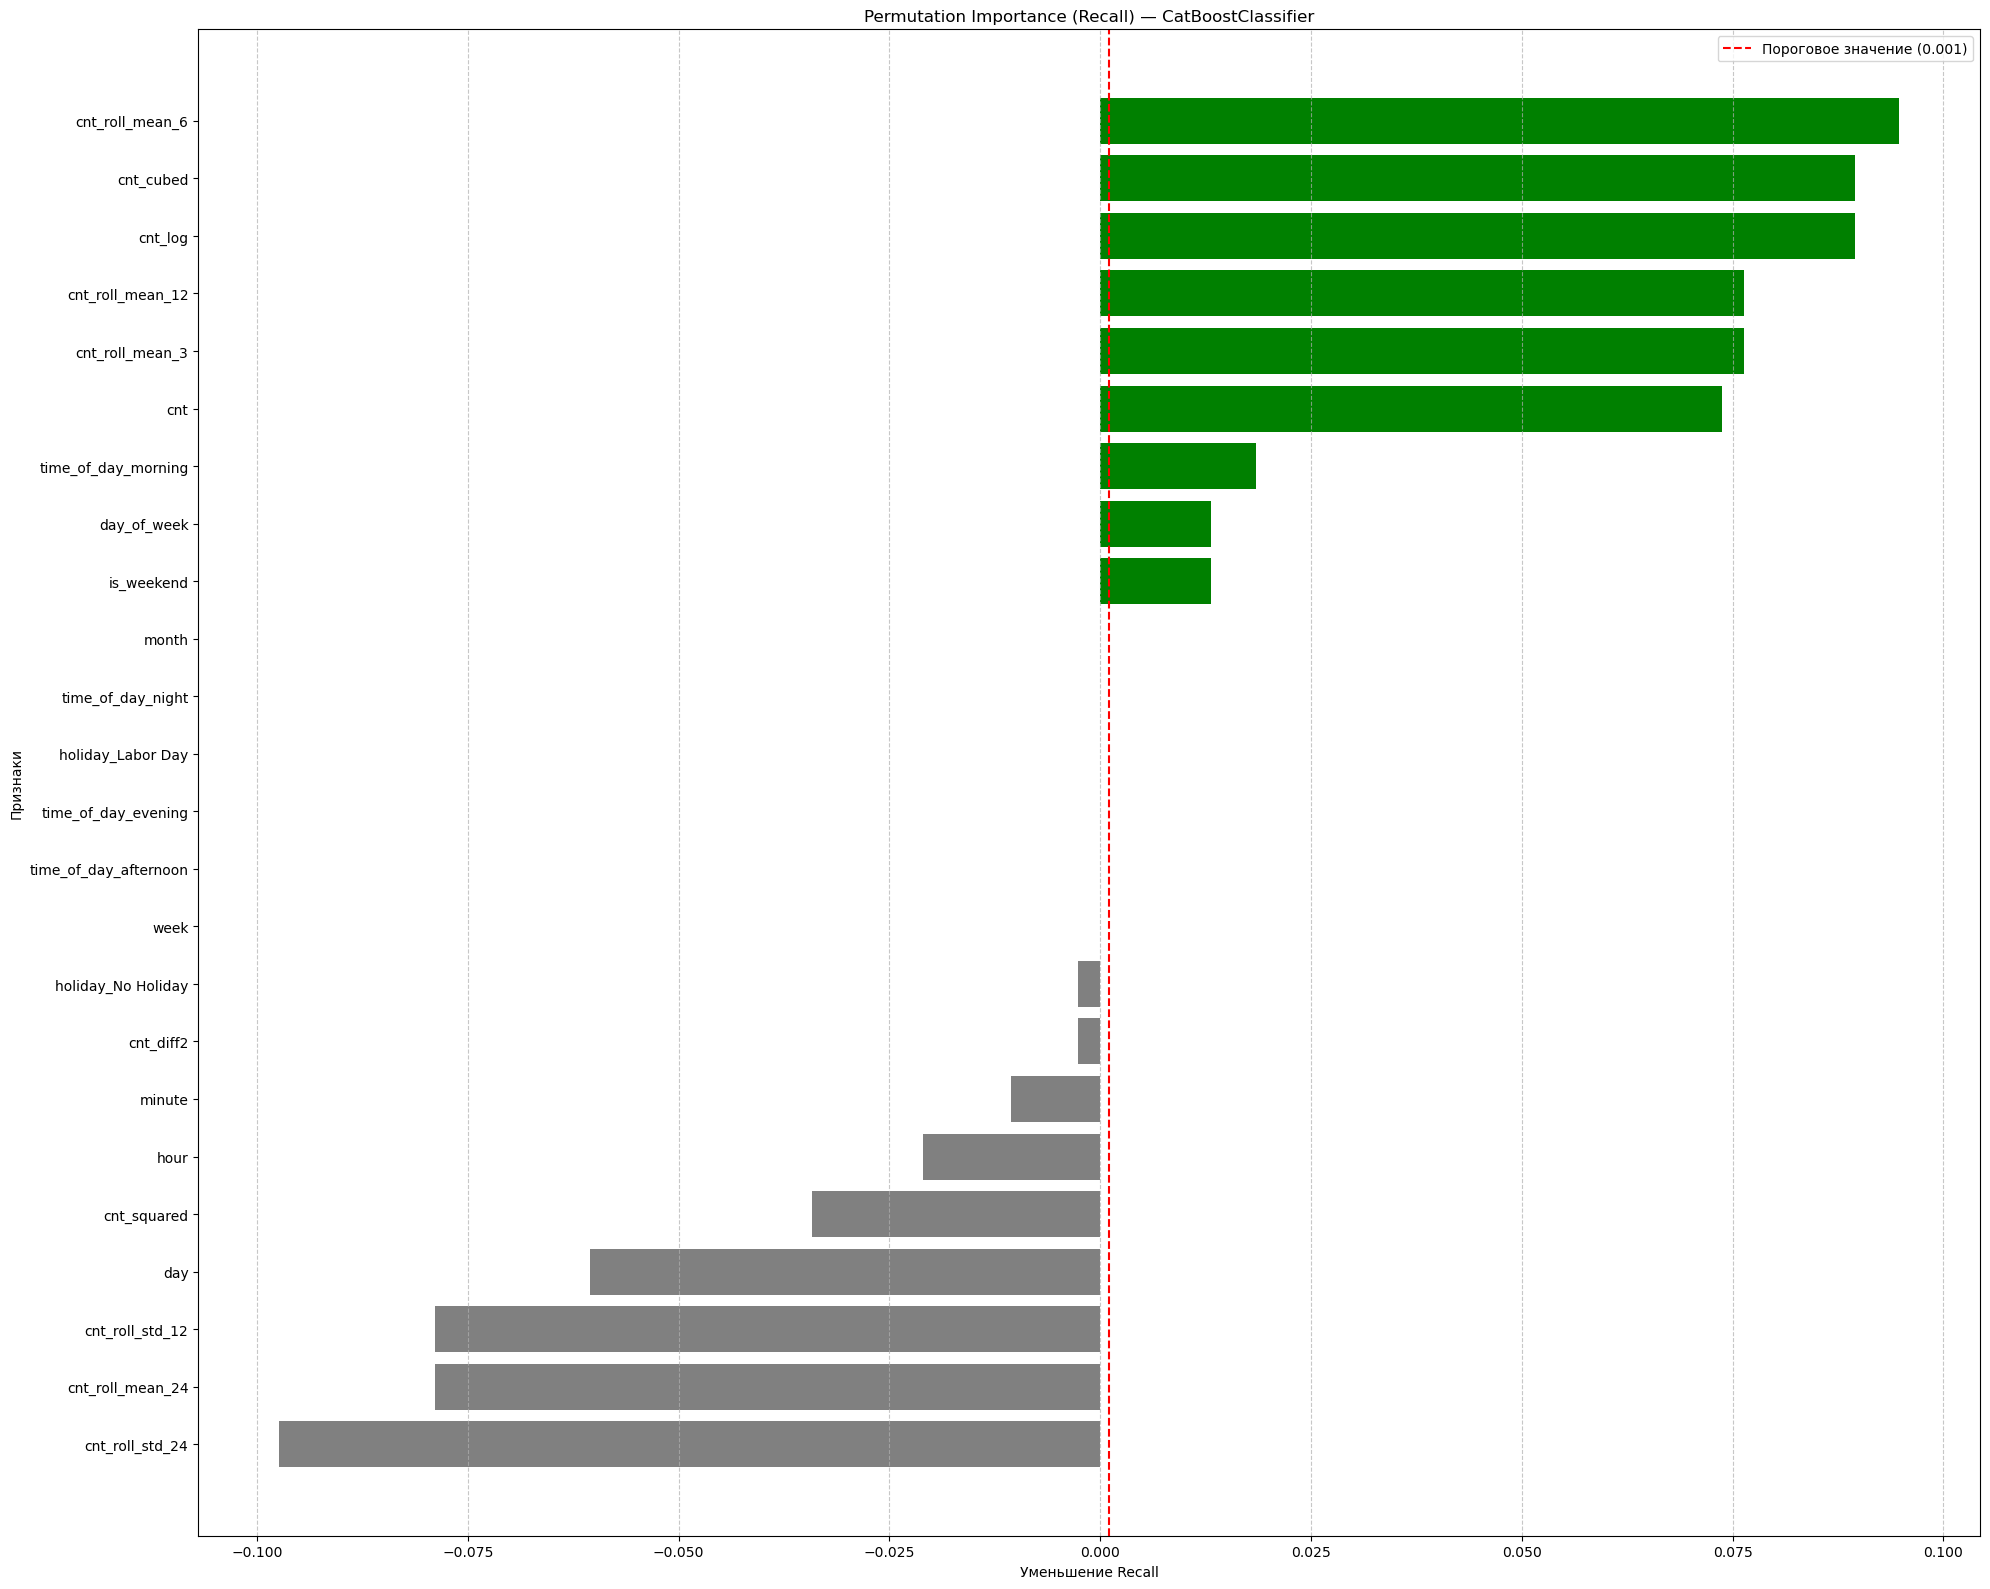

График важности признаков отображен.


In [72]:
model_features = [# 'dt', 
                  'cnt', 
   # 'is_event', 
    'month', 'day', 'week', 'day_of_week',
       'is_weekend', 'hour', 'minute', 'time_of_day_afternoon',
       'time_of_day_evening', 'time_of_day_morning', 'time_of_day_night',
       'holiday_Labor Day', 'holiday_No Holiday', 
    # 'cnt_diff', # НЕ РИСКУЮ
    'cnt_diff2', # ПОКАЗАЛ СЕБЯ ХОРОШО! но не на всех итерациях...
       'cnt_log', 'cnt_squared', 'cnt_cubed', 'cnt_roll_mean_3',
       'cnt_roll_mean_6', 'cnt_roll_mean_12', 'cnt_roll_mean_24',
       'cnt_roll_std_12', 'cnt_roll_std_24']


importance_df, selected_features = permutation_importance_CatBoostClassifier(
    X_train=train[model_features],
    y_train=train['is_event'],
    X_test=test[model_features],
    y_test=test['is_event'],
    n_repeats=10,
    threshold=0.001,
    metric='recall',
    cat_features=None
)

In [73]:
selected_features_classification = selected_features
model_features_classification = selected_features_classification

#### Функция для метрик

In [141]:
def metrics_report(y_true, y_pred, task='regression', y_proba=None, seasonal_period=1):
    y_true = pd.Series(y_true)
    y_pred = pd.Series(y_pred)

    if task == 'regression':
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        r2 = r2_score(y_true, y_pred)
        smape = np.mean(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred)).replace(0, np.nan)) * 100
        # MASE
        naive_forecast = y_true.shift(seasonal_period)
        naive_mae = np.mean(np.abs(y_true[seasonal_period:] - naive_forecast[seasonal_period:]))
        mase = mae / naive_mae if naive_mae != 0 else np.nan

        # Ошибки при наивном прогнозе
        y_mean = y_true.mean()
        mae_zero = mean_absolute_error(y_true, [y_mean] * len(y_true))
        rmse_zero = np.sqrt(mean_squared_error(y_true, [y_mean] * len(y_true)))

        return pd.Series({
            'mae': mae,
            'rmse': rmse,
            'r2': r2,
            'smape': smape,
            'mase': mase,
            'mae_zero': mae_zero,
            'rmse_zero': rmse_zero
        })

    elif task == 'classification':
        result = {
            'accuracy': accuracy_score(y_true, y_pred),
            'precision': precision_score(y_true, y_pred, zero_division=0),
            'recall': recall_score(y_true, y_pred, zero_division=0),
            'f1': f1_score(y_true, y_pred, zero_division=0),
        }

        if y_proba is not None:
            result['roc_auc'] = roc_auc_score(y_true, y_proba)

        return pd.Series(result)

    else:
        raise ValueError("task должен быть 'regression' или 'classification'")

#### Позаимствую функции с лекций по Classic ML

In [79]:
def time_series_cross_validation(X_train, y_train, X_test, y_test, X_oot=None, y_oot=None,
                                time_col=None, n_splits=5, gap=0, test_size=None,
                                model=None, random_state=42, visualize=True):
     
    """
    Функция для проведения кросс-валидации временных рядов с отслеживанием MSE и визуализацией остатков

    Параметры:
    X_train - признаки обучающей выборки (pandas DataFrame)
    y_train - целевая переменная обучающей выборки (pandas Series или numpy array)
    X_test - признаки тестовой выборки (pandas DataFrame)
    y_test - целевая переменная тестовой выборки (pandas Series или numpy array)
    X_oot - признаки out-of-time выборки (pandas DataFrame), опционально
    y_oot - целевая переменная out-of-time выборки (pandas Series или numpy array), опционально
    time_col - название столбца с временной меткой (если None, используется индекс)
    n_splits - количество разбиений для кросс-валидации временных рядов
    gap - количество сэмплов между тренировочным и тестовым наборами
    test_size - размер тестового набора для каждого разбиения (если None, используется по умолчанию)
    model - модель машинного обучения (по умолчанию RandomForestRegressor)
    random_state - фиксированное значение для воспроизводимости результатов

    Возвращает:
    cv_results - словарь с результатами кросс-валидации
    final_model - обученная модель на всех тренировочных данных
    """

    # Проверка входных данных
    if not isinstance(X_train, pd.DataFrame):
        raise TypeError("X_train должен быть pandas DataFrame")
    if not isinstance(X_test, pd.DataFrame):
        raise TypeError("X_test должен быть pandas DataFrame")
    if X_oot is not None and not isinstance(X_oot, pd.DataFrame):
        raise TypeError("X_oot должен быть pandas DataFrame")

    train_cols = set(X_train.columns)
    test_cols = set(X_test.columns)

    if time_col is not None:
        if time_col not in X_train.columns or time_col not in X_test.columns:
            raise ValueError(f"Столбец времени '{time_col}' должен быть в X_train и X_test")
        if X_oot is not None and time_col not in X_oot.columns:
            raise ValueError(f"Столбец времени '{time_col}' должен быть в X_oot")
        train_cols.remove(time_col)
        test_cols.remove(time_col)

    if train_cols != test_cols:
        raise ValueError("Колонки X_train и X_test должны совпадать (без учёта time_col)")

    if X_oot is not None:
        oot_cols = set(X_oot.columns)
        if time_col is not None:
            oot_cols.remove(time_col)
        if train_cols != oot_cols:
            raise ValueError("Колонки X_train и X_oot должны совпадать (без учёта time_col)")

    if model is None:
        from sklearn.ensemble import RandomForestRegressor
        model = RandomForestRegressor(n_estimators=100, random_state=random_state)

    X_train_copy = X_train.copy()
    X_test_copy = X_test.copy()

    if time_col is not None:
        X_train_copy = X_train_copy.sort_values(by=time_col).reset_index(drop=True)
        y_train = y_train.iloc[X_train_copy.index] if isinstance(y_train, pd.Series) else y_train[X_train_copy.index]
        X_test_copy = X_test_copy.sort_values(by=time_col).reset_index(drop=True)
        y_test = y_test.iloc[X_test_copy.index] if isinstance(y_test, pd.Series) else y_test[X_test_copy.index]
        if X_oot is not None:
            X_oot = X_oot.sort_values(by=time_col).reset_index(drop=True)
            y_oot = y_oot.iloc[X_oot.index] if isinstance(y_oot, pd.Series) else y_oot[X_oot.index]

    tscv = TimeSeriesSplit(n_splits=n_splits, gap=gap, test_size=test_size)

    cv_results = {
        'train_predictions': np.zeros(len(y_train)),
        'train_actual': y_train,
        'test_predictions': None,
        'test_actual': y_test,
        'oot_predictions': None,
        'oot_actual': y_oot if y_oot is not None else None,
        'fold_mse': [],
        'fold_train_indices': [],
        'fold_test_indices': [],
        'fold_timestamps': [],
        'train_mse': 0,
        'test_mse': 0,
        'oot_mse': 0 if y_oot is not None else None
    }

    if time_col is not None:
        cv_results['train_timestamps'] = X_train_copy[time_col].values
        cv_results['test_timestamps'] = X_test_copy[time_col].values
        if X_oot is not None:
            cv_results['oot_timestamps'] = X_oot[time_col].values

    if time_col is not None:
        X_train_model = X_train_copy.drop(columns=[time_col])
        X_test_model = X_test_copy.drop(columns=[time_col])
        if X_oot is not None:
            X_oot_model = X_oot.drop(columns=[time_col])
    else:
        X_train_model = X_train_copy
        X_test_model = X_test_copy
        if X_oot is not None:
            X_oot_model = X_oot

    fold_train_mse = []
    fold_val_mse = []

    print("Начинаем процесс кросс-валидации временных рядов...")

    for fold, (train_idx, val_idx) in enumerate(tqdm(tscv.split(X_train_model), total=n_splits, desc="Разбиения")):
        cv_results['fold_train_indices'].append(train_idx)
        cv_results['fold_test_indices'].append(val_idx)

        if time_col is not None:
            cv_results['fold_timestamps'].append({
                'train': X_train_copy.iloc[train_idx][time_col].values,
                'test': X_train_copy.iloc[val_idx][time_col].values
            })

        X_fold_train, X_fold_val = X_train_model.iloc[train_idx], X_train_model.iloc[val_idx]
        y_fold_train = y_train.iloc[train_idx] if isinstance(y_train, pd.Series) else y_train[train_idx]
        y_fold_val = y_train.iloc[val_idx] if isinstance(y_train, pd.Series) else y_train[val_idx]

        model.fit(X_fold_train, y_fold_train)
        y_fold_train_pred = model.predict(X_fold_train)
        y_fold_val_pred = model.predict(X_fold_val)

        cv_results['train_predictions'][val_idx] = y_fold_val_pred

        train_mse = mean_squared_error(y_fold_train, y_fold_train_pred)
        val_mse = mean_squared_error(y_fold_val, y_fold_val_pred)

        fold_train_mse.append(train_mse)
        fold_val_mse.append(val_mse)
        cv_results['fold_mse'].append(val_mse)

        print(f"Разбиение {fold + 1}/{n_splits}:")
        print(f"  Размер train: {len(train_idx)}, Размер val: {len(val_idx)}")
        print(f"  MSE train: {train_mse:.4f}, MSE val: {val_mse:.4f}")

    cv_results['train_mse'] = np.mean(fold_train_mse)
    cv_results['val_mse'] = np.mean(fold_val_mse)

    print(f"\nСредняя MSE train: {cv_results['train_mse']:.4f}")
    print(f"Средняя MSE val: {cv_results['val_mse']:.4f}")

    print("\nОбучаем финальную модель на всех тренировочных данных...")
    final_model = model.fit(X_train_model, y_train)

    cv_results['test_predictions'] = final_model.predict(X_test_model)
    cv_results['test_mse'] = mean_squared_error(y_test, cv_results['test_predictions'])
    print(f"MSE test: {cv_results['test_mse']:.4f}")

    if X_oot is not None and y_oot is not None:
        cv_results['oot_predictions'] = final_model.predict(X_oot_model)
        cv_results['oot_mse'] = mean_squared_error(y_oot, cv_results['oot_predictions'])
        print(f"MSE OOT: {cv_results['oot_mse']:.4f}")

    if visualize:
        visualize_time_series_cv(cv_results, n_splits, time_col)
        visualize_residuals(y_test, cv_results['test_predictions'], "Тестовая выборка")
        if X_oot is not None and y_oot is not None:
            visualize_residuals(y_oot, cv_results['oot_predictions'], "OOT выборка")

    return cv_results, final_model



def visualize_time_series_cv(cv_results, n_splits, time_col=None):
    """
    Функция для визуализации результатов кросс-валидации временных рядов

    Параметры:
    cv_results - словарь с результатами кросс-валидации
    n_splits - количество разбиений
    time_col - название столбца с временной меткой (если None, используется индекс)
    """
    # Настраиваем стиль графиков
    sns.set(style="whitegrid")

    # 1. График MSE по разбиениям
    plt.figure(figsize=(10, 6))
    plt.bar(range(1, n_splits+1), cv_results['fold_mse'], color='skyblue')
    plt.axhline(y=np.mean(cv_results['fold_mse']), color='r', linestyle='-',
               label=f'Среднее: {np.mean(cv_results["fold_mse"]):.4f}')
    plt.title('MSE по разбиениям временного ряда')
    plt.xlabel('Номер разбиения')
    plt.ylabel('MSE')
    plt.xticks(range(1, n_splits+1))
    plt.legend()
    plt.grid(True)
    plt.show()

    # 2. Визуализация разбиений временного ряда
    if time_col is not None and 'fold_timestamps' in cv_results:
        plt.figure(figsize=(12, 8))

        # Получаем все временные метки
        all_timestamps = cv_results['train_timestamps']

        # Создаем цветовую палитру для разбиений
        colors = plt.cm.tab10(np.linspace(0, 1, n_splits))

        for i, (train_indices, test_indices) in enumerate(zip(cv_results['fold_train_indices'], cv_results['fold_test_indices'])):
            # Получаем временные метки для этого разбиения
            train_times = cv_results['fold_timestamps'][i]['train']
            test_times = cv_results['fold_timestamps'][i]['test']

            # Находим минимальную и максимальную временные метки
            min_time = min(train_times) if len(train_times) > 0 else min(test_times)
            max_time = max(test_times) if len(test_times) > 0 else max(train_times)

            # Рисуем горизонтальные линии для обучающей и тестовой выборок
            plt.plot([min_time, max_time], [i+0.2, i+0.2], 'o-', color=colors[i],
                    label=f'Разбиение {i+1}' if i == 0 else "", linewidth=0.4)

            # Отмечаем обучающую и тестовую выборки
            plt.scatter(train_times, [i+0.2]*len(train_times), marker='o', color=colors[i], alpha=0.5)
            plt.scatter(test_times, [i+0.2]*len(test_times), marker='x', color=colors[i], s=50)

        # Добавляем легенду
        plt.plot([], [], 'o', color='gray', label='Обучающая выборка')
        plt.plot([], [], 'x', color='gray', label='Тестовая выборка')

        plt.title('Схема разбиений временного ряда')
        plt.xlabel('Временная метка')
        plt.ylabel('Номер разбиения')
        plt.yticks(np.arange(0.2, n_splits+0.2, 1), [f'Разбиение {i+1}' for i in range(n_splits)])
        plt.legend()
        plt.grid(True)
        plt.show()

    # 3. Сравнение предсказаний и реальных значений на тренировочных данных
    plt.figure(figsize=(10, 6))

    # Если есть временные метки, используем их для оси X
    if time_col is not None and 'train_timestamps' in cv_results:
        plt.scatter(cv_results['train_timestamps'], cv_results['train_actual'], alpha=0.5, label='Реальные значения')
        plt.scatter(cv_results['train_timestamps'], cv_results['train_predictions'], alpha=0.5, label='Предсказания')
        plt.title('Предсказания vs Реальные значения (Тренировочные данные)')
        plt.xlabel('Временная метка')
    else:
        plt.scatter(range(len(cv_results['train_actual'])), cv_results['train_actual'], alpha=0.5, label='Реальные значения')
        plt.scatter(range(len(cv_results['train_predictions'])), cv_results['train_predictions'], alpha=0.5, label='Предсказания')
        plt.title('Предсказания vs Реальные значения (Тренировочные данные)')
        plt.xlabel('Индекс')

    plt.ylabel('Значение')
    plt.legend()
    plt.grid(True)
    plt.show()

        # 4. Сравнение предсказаний и реальных значений на тестовых данных
    plt.figure(figsize=(10, 6))

    # Если есть временные метки, используем их для оси X
    if time_col is not None and 'test_timestamps' in cv_results:
        plt.scatter(cv_results['test_timestamps'], cv_results['test_actual'], alpha=0.5, label='Реальные значения')
        plt.scatter(cv_results['test_timestamps'], cv_results['test_predictions'], alpha=0.5, label='Предсказания')
        plt.title('Предсказания vs Реальные значения (Тестовые данные)')
        plt.xlabel('Временная метка')
    else:
        plt.scatter(range(len(cv_results['test_actual'])), cv_results['test_actual'], alpha=0.5, label='Реальные значения')
        plt.scatter(range(len(cv_results['test_predictions'])), cv_results['test_predictions'], alpha=0.5, label='Предсказания')
        plt.title('Предсказания vs Реальные значения (Тестовые данные)')
        plt.xlabel('Индекс')

    plt.ylabel('Значение')
    plt.legend()
    plt.grid(True)
    plt.show()

    # 5. Если есть OOT данные, визуализируем их
    if cv_results['oot_predictions'] is not None:
        plt.figure(figsize=(10, 6))

        # Если есть временные метки, используем их для оси X
        if time_col is not None and 'oot_timestamps' in cv_results:
            plt.scatter(cv_results['oot_timestamps'], cv_results['oot_actual'], alpha=0.5, label='Реальные значения')
            plt.scatter(cv_results['oot_timestamps'], cv_results['oot_predictions'], alpha=0.5, label='Предсказания')
            plt.title('Предсказания vs Реальные значения (OOT данные)')
            plt.xlabel('Временная метка')
        else:
            plt.scatter(range(len(cv_results['oot_actual'])), cv_results['oot_actual'], alpha=0.5, label='Реальные значения')
            plt.scatter(range(len(cv_results['oot_predictions'])), cv_results['oot_predictions'], alpha=0.5, label='Предсказания')
            plt.title('Предсказания vs Реальные значения (OOT данные)')
            plt.xlabel('Индекс')

        plt.ylabel('Значение')
        plt.legend()
        plt.grid(True)
        plt.show()

    # 6. Временной ряд предсказаний и реальных значений
    plt.figure(figsize=(12, 6))

    # Если есть временные метки, создаем временной ряд
    if time_col is not None:
        # Объединяем тренировочные и тестовые данные для визуализации
        all_timestamps = np.concatenate([cv_results['train_timestamps'], cv_results['test_timestamps']])
        all_actual = np.concatenate([cv_results['train_actual'], cv_results['test_actual']])
        all_predictions = np.concatenate([cv_results['train_predictions'], cv_results['test_predictions']])

        # Сортируем по времени
        sort_idx = np.argsort(all_timestamps)
        all_timestamps = all_timestamps[sort_idx]
        all_actual = all_actual[sort_idx]
        all_predictions = all_predictions[sort_idx]

        # Рисуем временной ряд
        plt.plot(all_timestamps, all_actual, 'b-', alpha=0.7, label='Реальные значения')
        plt.plot(all_timestamps, all_predictions, 'r-', alpha=0.7, label='Предсказания')

        # Добавляем вертикальную линию, разделяющую тренировочные и тестовые данные
        split_time = cv_results['test_timestamps'][0]
        plt.axvline(x=split_time, color='g', linestyle='--', label='Граница тест/трейн')

        plt.title('Временной ряд: реальные значения и предсказания')
        plt.xlabel('Временная метка')
    else:
        # Если нет временных меток, используем индексы
        train_size = len(cv_results['train_actual'])
        test_size = len(cv_results['test_actual'])

        plt.plot(range(train_size), cv_results['train_actual'], 'b-', alpha=0.7, label='Реальные значения (трейн)')
        plt.plot(range(train_size), cv_results['train_predictions'], 'r-', alpha=0.7, label='Предсказания (трейн)')

        plt.plot(range(train_size, train_size + test_size), cv_results['test_actual'], 'b-', alpha=0.7, label='Реальные значения (тест)')
        plt.plot(range(train_size, train_size + test_size), cv_results['test_predictions'], 'r-', alpha=0.7, label='Предсказания (тест)')

        # Добавляем вертикальную линию, разделяющую тренировочные и тестовые данные
        plt.axvline(x=train_size, color='g', linestyle='--', label='Граница тест/трейн')

        plt.title('Временной ряд: реальные значения и предсказания')
        plt.xlabel('Индекс')

    plt.ylabel('Значение')
    plt.legend()
    plt.grid(True)
    plt.show()

    # 7. Сравнение MSE на разных наборах данных
    plt.figure(figsize=(10, 6))

    # Собираем метрики для всех наборов данных
    datasets = ['Кросс-валидация', 'Тест']
    mse_values = [cv_results['val_mse'], cv_results['test_mse']]

    if cv_results['oot_mse'] is not None:
        datasets.append('OOT')
        mse_values.append(cv_results['oot_mse'])

    plt.bar(datasets, mse_values, color='skyblue')
    plt.title('Сравнение MSE на разных наборах данных')
    plt.ylabel('MSE')
    plt.grid(True)

    # Добавляем значения MSE над столбцами
    for i, v in enumerate(mse_values):
        plt.text(i, v + 0.01, f'{v:.4f}', ha='center')

    plt.show()

def visualize_residuals(y_true, y_pred, dataset_name=""):
    """
    Функция для визуализации остатков регрессионной модели

    Параметры:
    y_true - истинные значения целевой переменной
    y_pred - предсказанные значения
    dataset_name - название набора данных для заголовков графиков
    """
    # Вычисляем остатки
    residuals = y_true - y_pred

    # Создаем фигуру с подграфиками
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(f'Анализ остатков ({dataset_name})', fontsize=16)

    # 1. График остатков относительно предсказанных значений
    axes[0, 0].scatter(y_pred, residuals, alpha=0.5)
    axes[0, 0].axhline(y=0, color='r', linestyle='-')
    axes[0, 0].set_title('Остатки vs Предсказанные значения')
    axes[0, 0].set_xlabel('Предсказанные значения')
    axes[0, 0].set_ylabel('Остатки')
    axes[0, 0].grid(True)

    # 2. Гистограмма остатков
    axes[0, 1].hist(residuals, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0, 1].set_title('Гистограмма остатков')
    axes[0, 1].set_xlabel('Остатки')
    axes[0, 1].set_ylabel('Частота')
    axes[0, 1].grid(True)

    # 3. QQ-график для проверки нормальности остатков
    from scipy import stats
    stats.probplot(residuals, dist="norm", plot=axes[1, 0])
    axes[1, 0].set_title('QQ-график остатков')
    axes[1, 0].grid(True)

    # 4. Предсказанные vs Истинные значения
    axes[1, 1].scatter(y_true, y_pred, alpha=0.5)
    min_val = min(min(y_true), min(y_pred))
    max_val = max(max(y_true), max(y_pred))
    axes[1, 1].plot([min_val, max_val], [min_val, max_val], 'r--')
    axes[1, 1].set_title('Предсказанные vs Истинные значения')
    axes[1, 1].set_xlabel('Истинные значения')
    axes[1, 1].set_ylabel('Предсказанные значения')
    axes[1, 1].grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Оставляем место для общего заголовка
    plt.show()

#### Классификация
##### На итерации пишет `MSE` - не обращать внимание, надо переделать слегка просто наименования

In [125]:
TARGET_COL = 'is_event'
TIME_COL = 'dt'
THRESHOLD = 0.01

X_train = train[model_features_classification + [TIME_COL]]
y_train = train[TARGET_COL]

X_test = test[model_features_classification + [TIME_COL]]
y_test = test[TARGET_COL]

print("\nЗапуск Hyperopt...")
start_time_hyperopt = time.time()

# Пространство поиска
space = {
    'n_estimators': hp.quniform('n_estimators', 80, 120, 10),
    'max_depth': hp.quniform('max_depth', 3, 5, 1), # неглубокие деревья, т. к. на небольших датасетах себя показывает лучше
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
    'subsample': hp.uniform('subsample', 0.6, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0),
    'min_child_weight': hp.quniform('min_child_weight', 1, 7, 2),
    'gamma': hp.uniform('gamma', 0, 0.4)
}

# Целевая функция
def objective(params):
    model_params = {
        'n_estimators': int(params['n_estimators']),
        'max_depth': int(params['max_depth']),
        'learning_rate': params['learning_rate'],
        'subsample': params['subsample'],
        'colsample_bytree': params['colsample_bytree'],
        'min_child_weight': int(params['min_child_weight']),
        'gamma': params['gamma'],
        'random_state': 42,
        # 'use_label_encoder': False,
        'eval_metric': 'logloss',
        'n_jobs': -1
    }

    model = xgb.XGBClassifier(**model_params)

    cv_results, _ = time_series_cross_validation(
        X_train=X_train.copy(),
        y_train=y_train.copy(),
        X_test=X_test.copy(),
        y_test=y_test.copy(),
        time_col=TIME_COL,
        n_splits=5,
        model=model,
        random_state=42,
        visualize=False
    )

    y_train_proba = cv_results['train_predictions']
    if y_train_proba.ndim > 1:
        y_train_proba = y_train_proba[:, 1]
    y_train_pred = (y_train_proba >= THRESHOLD).astype(int)

    score = recall_score(y_train, y_train_pred, zero_division=0)
    hyperopt_pbar.update(1)
    return {'loss': -score, 'status': STATUS_OK, 'params': model_params}

# Запуск Hyperopt
n_iter_hyperopt = 500
hyperopt_pbar = tqdm(total=n_iter_hyperopt, desc="Hyperopt")
trials = Trials()

best_hyperopt = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=n_iter_hyperopt,
    trials=trials,
    verbose=0
)

hyperopt_pbar.close()
time_hyperopt = time.time() - start_time_hyperopt

# Лучшие параметры
best_trial_idx = np.argmin([t['result']['loss'] for t in trials.trials])
best_params_hyperopt = trials.trials[best_trial_idx]['result']['params']
best_score_hyperopt = -min([t['result']['loss'] for t in trials.trials])

# Финальное обучение модели
best_model_hyperopt = xgb.XGBClassifier(**best_params_hyperopt)
best_model_hyperopt.fit(X_train.drop(columns=TIME_COL), y_train)

# Предсказание вероятностей и применение порога
y_test_proba = best_model_hyperopt.predict_proba(X_test.drop(columns=TIME_COL))[:, 1]
y_test_pred_hyperopt = (y_test_proba >= THRESHOLD).astype(int)

# Метрики
metrics_hyperopt = metrics_report(y_test, y_test_pred_hyperopt, task='classification')

# Финальный вывод
print(f"\nHyperopt завершен за {time_hyperopt:.2f} секунд")
print(f"Лучшие параметры: {best_params_hyperopt}")
print(f"Использованный порог: {THRESHOLD}")
print(f"Лучший CV score (recall): {best_score_hyperopt:.4f}")
print(f"Метрики на тестовых данных:")
for metric, value in metrics_hyperopt.items():
    print(f"  {metric}: {value:.4f}")


Запуск Hyperopt...



Hyperopt:   0%|                                                                                | 0/500 [00:00<?, ?it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 17.92it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0352, MSE val: 0.0861
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0446, MSE val: 0.0760
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0404, MSE val: 0.0625




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 15.24it/s]

Hyperopt:   0%|▏                                                                       | 1/500 [00:00<03:36,  2.30it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0375, MSE val: 0.0321
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0354, MSE val: 0.0253

Средняя MSE train: 0.0386
Средняя MSE val: 0.0564

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0491
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 15.78it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0285, MSE val: 0.0828
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0345, MSE val: 0.0709
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0382, MSE val: 0.1014




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13.35it/s]

Hyperopt:   0%|▎                                                                       | 2/500 [00:00<03:40,  2.26it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0430, MSE val: 0.0304
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0412, MSE val: 0.0236

Средняя MSE train: 0.0371
Средняя MSE val: 0.0618

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0774
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.0828




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 14.46it/s]

Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 16.24it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0362, MSE val: 0.0693
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0421, MSE val: 0.1436
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0438, MSE val: 0.0338


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 16.39it/s]

Hyperopt:   1%|▍                                                                       | 3/500 [00:01<03:22,  2.46it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0432, MSE val: 0.0253

Средняя MSE train: 0.0381
Средняя MSE val: 0.0709

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0747


Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0235, MSE val: 0.1233
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0194, MSE val: 0.0709
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0208, MSE val: 0.1537




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 21.49it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0253, MSE val: 0.0507


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 20.15it/s]

Hyperopt:   1%|▌                                                                       | 4/500 [00:01<03:03,  2.70it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0283, MSE val: 0.0490

Средняя MSE train: 0.0235
Средняя MSE val: 0.0895

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0774
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0302, MSE val: 0.0845
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0370, MSE val: 0.0726




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 23.16it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0388, MSE val: 0.0980


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0434, MSE val: 0.0287


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 20.05it/s]

Hyperopt:   1%|▋                                                                       | 5/500 [00:01<02:55,  2.82it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0395, MSE val: 0.0253

Средняя MSE train: 0.0378
Средняя MSE val: 0.0618

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0720


Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0369, MSE val: 0.0845




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 19.84it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0455, MSE val: 0.0659
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0455, MSE val: 0.0693




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 19.64it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0460, MSE val: 0.0304


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 18.54it/s]


Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0435, MSE val: 0.0186

Средняя MSE train: 0.0435
Средняя MSE val: 0.0537

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0310



Hyperopt:   1%|▊                                                                       | 6/500 [00:02<02:54,  2.83it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0285, MSE val: 0.0845
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0345, MSE val: 0.0693




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 20.07it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0365, MSE val: 0.0946
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0388, MSE val: 0.0304


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 14.53it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0378, MSE val: 0.0253

Средняя MSE train: 0.0352
Средняя MSE val: 0.0608

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:   1%|█                                                                       | 7/500 [00:02<03:05,  2.66it/s]

MSE test: 0.0760
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0369, MSE val: 0.0845




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 19.98it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0438, MSE val: 0.0760
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0433, MSE val: 0.0659
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0413, MSE val: 0.0287


Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0405, MSE val: 0.0203


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 19.98it/s]



Средняя MSE train: 0.0411
Средняя MSE val: 0.0551

Обучаем финальную модель на всех тренировочных данных...



Hyperopt:   2%|█▏                                                                      | 8/500 [00:02<02:57,  2.77it/s]

MSE test: 0.0296
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0101, MSE val: 0.1199
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0202, MSE val: 0.0709




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 20.61it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0287, MSE val: 0.1588
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0341, MSE val: 0.0473


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 19.85it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0358, MSE val: 0.0439

Средняя MSE train: 0.0258
Средняя MSE val: 0.0882

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:   2%|█▎                                                                      | 9/500 [00:03<02:51,  2.87it/s]

MSE test: 0.0767
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 17.91it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.0845
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0303, MSE val: 0.0676


Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0388, MSE val: 0.1470




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 18.00it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0434, MSE val: 0.0321


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 17.43it/s]

Hyperopt:   2%|█▍                                                                     | 10/500 [00:03<02:52,  2.84it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0415, MSE val: 0.0220

Средняя MSE train: 0.0358
Средняя MSE val: 0.0706

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0781
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.0861
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0261, MSE val: 0.0726




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 21.53it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0253, MSE val: 0.1453
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0274, MSE val: 0.0422


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 19.40it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0348, MSE val: 0.0304

Средняя MSE train: 0.0277
Средняя MSE val: 0.0753

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0734




Hyperopt:   2%|█▌                                                                     | 11/500 [00:04<02:49,  2.89it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 21.37it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0218, MSE val: 0.1250
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0135, MSE val: 0.0659
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0174, MSE val: 0.1639


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0194, MSE val: 0.0557


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 17.18it/s]

Hyperopt:   2%|█▋                                                                     | 12/500 [00:04<02:51,  2.84it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0216, MSE val: 0.0473

Средняя MSE train: 0.0187
Средняя MSE val: 0.0916

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0828
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0352, MSE val: 0.0861
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0421, MSE val: 0.0676




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 19.72it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0393, MSE val: 0.0642
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0388, MSE val: 0.0338


Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0368, MSE val: 0.0220


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 17.62it/s]

Hyperopt:   3%|█▊                                                                     | 13/500 [00:04<02:52,  2.82it/s]


Средняя MSE train: 0.0384
Средняя MSE val: 0.0547

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0538


Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]



Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0369, MSE val: 0.0845
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0463, MSE val: 0.0625
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0478, MSE val: 0.0828


Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 27.37it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0506, MSE val: 0.0287


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 21.76it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0459, MSE val: 0.0186




Hyperopt:   3%|█▉                                                                     | 14/500 [00:05<02:42,  2.99it/s]


Средняя MSE train: 0.0455
Средняя MSE val: 0.0554

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0262
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.1233




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 16.78it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0244, MSE val: 0.0676


Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0298, MSE val: 0.1520
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0341, MSE val: 0.0405


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 15.93it/s]


Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0327, MSE val: 0.0422

Средняя MSE train: 0.0292
Средняя MSE val: 0.0851

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0781



Hyperopt:   3%|██▏                                                                    | 15/500 [00:05<02:50,  2.85it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0285, MSE val: 0.0861
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0269, MSE val: 0.0709




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 23.17it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0326, MSE val: 0.1301
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0337, MSE val: 0.0321


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 21.86it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0358, MSE val: 0.0253

Средняя MSE train: 0.0315
Средняя MSE val: 0.0689

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:   3%|██▎                                                                    | 16/500 [00:05<02:40,  3.01it/s]

MSE test: 0.0740
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 18.93it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0218, MSE val: 0.0861
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0219, MSE val: 0.0693
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0287, MSE val: 0.1537




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 17.32it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0346, MSE val: 0.0473


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 17.10it/s]

Hyperopt:   3%|██▍                                                                    | 17/500 [00:06<02:44,  2.93it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0361, MSE val: 0.0372

Средняя MSE train: 0.0286
Средняя MSE val: 0.0787

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0707
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0285, MSE val: 0.0861


Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0269, MSE val: 0.0726
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0315, MSE val: 0.1318


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.66it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0358, MSE val: 0.0338
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0354, MSE val: 0.0287

Средняя MSE train: 0.0316
Средняя MSE val: 0.0706

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0707




Hyperopt:   4%|██▌                                                                    | 18/500 [00:06<02:37,  3.07it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.0811
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0354, MSE val: 0.0676




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 26.84it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0438, MSE val: 0.1554
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0468, MSE val: 0.0304


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.33it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0445, MSE val: 0.0270

Средняя MSE train: 0.0391
Средняя MSE val: 0.0723

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:   4%|██▋                                                                    | 19/500 [00:06<02:30,  3.19it/s]

MSE test: 0.0767
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]



Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0369, MSE val: 0.0845
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0387, MSE val: 0.0676


Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 19.23it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0404, MSE val: 0.1368




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 18.16it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0481, MSE val: 0.0287


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 17.22it/s]


Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0455, MSE val: 0.0169

Средняя MSE train: 0.0419
Средняя MSE val: 0.0669

Обучаем финальную модель на всех тренировочных данных...



Hyperopt:   4%|██▊                                                                    | 20/500 [00:07<02:40,  2.99it/s]

MSE test: 0.0626
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0218, MSE val: 0.1199
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0177, MSE val: 0.0777


Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0202, MSE val: 0.1520


Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 19.99it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0232, MSE val: 0.0507




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 18.17it/s]

Hyperopt:   4%|██▉                                                                    | 21/500 [00:07<02:45,  2.89it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0260, MSE val: 0.0456

Средняя MSE train: 0.0218
Средняя MSE val: 0.0892

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0794


Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]



Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0369, MSE val: 0.0845
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0463, MSE val: 0.0625


Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 19.40it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0472, MSE val: 0.0709


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0481, MSE val: 0.0236


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 15.78it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0459, MSE val: 0.0152

Средняя MSE train: 0.0449
Средняя MSE val: 0.0514

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:   4%|███                                                                    | 22/500 [00:07<02:56,  2.71it/s]

MSE test: 0.0262
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0117, MSE val: 0.1166




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 14.63it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0101, MSE val: 0.0760
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0101, MSE val: 0.1470




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 12.19it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0139, MSE val: 0.0524


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.00it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0172, MSE val: 0.0557

Средняя MSE train: 0.0126
Средняя MSE val: 0.0895

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:   5%|███▎                                                                   | 23/500 [00:08<03:17,  2.42it/s]

MSE test: 0.0787
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.1182
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0210, MSE val: 0.0659




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 19.96it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0253, MSE val: 0.1554
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0308, MSE val: 0.0439




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 19.16it/s]

Hyperopt:   5%|███▍                                                                   | 24/500 [00:08<03:08,  2.53it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0294, MSE val: 0.0338

Средняя MSE train: 0.0263
Средняя MSE val: 0.0834

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0720


Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.1166


Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0210, MSE val: 0.0693


Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 18.51it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0236, MSE val: 0.1554




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 13.00it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0270, MSE val: 0.0439


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.68it/s]

Hyperopt:   5%|███▌                                                                   | 25/500 [00:09<03:22,  2.34it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0290, MSE val: 0.0338

Средняя MSE train: 0.0252
Средняя MSE val: 0.0838

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0754


Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.0878




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 19.92it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0253, MSE val: 0.0642
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0258, MSE val: 0.1537




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 17.09it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0346, MSE val: 0.0372


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 17.20it/s]


Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0351, MSE val: 0.0270

Средняя MSE train: 0.0292
Средняя MSE val: 0.0740

Обучаем финальную модель на всех тренировочных данных...



Hyperopt:   5%|███▋                                                                   | 26/500 [00:09<03:14,  2.44it/s]

MSE test: 0.0653
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0285, MSE val: 0.0878
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0261, MSE val: 0.0726




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 22.02it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0281, MSE val: 0.1267


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 20.29it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0333, MSE val: 0.0321
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0344, MSE val: 0.0270

Средняя MSE train: 0.0301
Средняя MSE val: 0.0693

Обучаем финальную модель на всех тренировочных данных...


MSE test: 0.0713



Hyperopt:   5%|███▊                                                                   | 27/500 [00:09<03:04,  2.57it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0235, MSE val: 0.1132
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0244, MSE val: 0.0760




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 21.26it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0382, MSE val: 0.1588


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 21.24it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0409, MSE val: 0.0422
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0412, MSE val: 0.0321

Средняя MSE train: 0.0336
Средняя MSE val: 0.0845

Обучаем финальную модель на всех тренировочных данных...


MSE test: 0.0673


Hyperopt:   6%|███▉                                                                   | 28/500 [00:10<02:51,  2.75it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.0811
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0253, MSE val: 0.0676




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 20.43it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0270, MSE val: 0.1520
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0358, MSE val: 0.0405


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 18.97it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0371, MSE val: 0.0270

Средняя MSE train: 0.0301
Средняя MSE val: 0.0736

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:   6%|████                                                                   | 29/500 [00:10<02:48,  2.80it/s]

MSE test: 0.0760


Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0319, MSE val: 0.0845
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0379, MSE val: 0.0676




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 24.64it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0371, MSE val: 0.1233
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0417, MSE val: 0.0304


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.64it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0388, MSE val: 0.0220



Средняя MSE train: 0.0375
Средняя MSE val: 0.0655

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0612


Hyperopt:   6%|████▎                                                                  | 30/500 [00:10<02:39,  2.95it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]



Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.0811
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0236, MSE val: 0.0676


Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 17.29it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0281, MSE val: 0.1486


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0329, MSE val: 0.0422


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 16.32it/s]


Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0361, MSE val: 0.0270

Средняя MSE train: 0.0292
Средняя MSE val: 0.0733

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0713



Hyperopt:   6%|████▍                                                                  | 31/500 [00:11<02:46,  2.81it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0235, MSE val: 0.1267
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0227, MSE val: 0.0659




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 20.69it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0331, MSE val: 0.1622


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 21.18it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0337, MSE val: 0.0456
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0337, MSE val: 0.0422



Средняя MSE train: 0.0294
Средняя MSE val: 0.0885

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0848


Hyperopt:   6%|████▌                                                                  | 32/500 [00:11<02:39,  2.93it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.0878
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0261, MSE val: 0.0794


Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0298, MSE val: 0.1503


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 25.90it/s]


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0367, MSE val: 0.0372
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0378, MSE val: 0.0253

Средняя MSE train: 0.0311
Средняя MSE val: 0.0760

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0734



Hyperopt:   7%|████▋                                                                  | 33/500 [00:11<02:28,  3.14it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0369, MSE val: 0.0861
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0396, MSE val: 0.0676




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 19.94it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0421, MSE val: 0.0642


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0384, MSE val: 0.0304




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 19.19it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0374, MSE val: 0.0236

Средняя MSE train: 0.0389
Средняя MSE val: 0.0544

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:   7%|████▊                                                                  | 34/500 [00:12<02:31,  3.08it/s]

MSE test: 0.0350
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.0878
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0253, MSE val: 0.0659




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 25.87it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0298, MSE val: 0.1554


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0379, MSE val: 0.0389


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.97it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0385, MSE val: 0.0253

Средняя MSE train: 0.0313
Средняя MSE val: 0.0747

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:   7%|████▉                                                                  | 35/500 [00:12<02:23,  3.23it/s]

MSE test: 0.0767
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.0828
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0320, MSE val: 0.0659




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 23.49it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0371, MSE val: 0.1588


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 20.98it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0422, MSE val: 0.0304
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0425, MSE val: 0.0304



Средняя MSE train: 0.0358
Средняя MSE val: 0.0736

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0808


Hyperopt:   7%|█████                                                                  | 36/500 [00:12<02:23,  3.22it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0268, MSE val: 0.0878


Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0303, MSE val: 0.0760


Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 19.33it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0315, MSE val: 0.0845




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 15.98it/s]


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0325, MSE val: 0.0422
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0317, MSE val: 0.0355



Средняя MSE train: 0.0306
Средняя MSE val: 0.0652

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0760


Hyperopt:   7%|█████▎                                                                 | 37/500 [00:13<02:36,  2.97it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0336, MSE val: 0.0878
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0354, MSE val: 0.0709




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 24.19it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0399, MSE val: 0.0659
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0426, MSE val: 0.0287
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0398, MSE val: 0.0203

Средняя MSE train: 0.0382
Средняя MSE val: 0.0547

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:   8%|█████▍                                                                 | 38/500 [00:13<02:28,  3.11it/s]

MSE test: 0.0471
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 17.46it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0134, MSE val: 0.1233
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0202, MSE val: 0.0726
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0275, MSE val: 0.1503


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0320, MSE val: 0.0524




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 17.80it/s]

Hyperopt:   8%|█████▌                                                                 | 39/500 [00:13<02:33,  3.01it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0351, MSE val: 0.0405

Средняя MSE train: 0.0257
Средняя MSE val: 0.0878

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0612
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.0811




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 19.26it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0227, MSE val: 0.0676


Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0258, MSE val: 0.1622
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0308, MSE val: 0.0405


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 15.58it/s]



Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0331, MSE val: 0.0372

Средняя MSE train: 0.0275
Средняя MSE val: 0.0777

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0713


Hyperopt:   8%|█████▋                                                                 | 40/500 [00:14<02:43,  2.82it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0369, MSE val: 0.0845
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0564, MSE val: 0.0642




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 20.29it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0551, MSE val: 0.0338
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0506, MSE val: 0.0236


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 17.33it/s]


Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0459, MSE val: 0.0152

Средняя MSE train: 0.0490
Средняя MSE val: 0.0443

Обучаем финальную модель на всех тренировочных данных...



Hyperopt:   8%|█████▊                                                                 | 41/500 [00:14<02:47,  2.74it/s]

MSE test: 0.0256
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0319, MSE val: 0.0845




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 19.84it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0396, MSE val: 0.0676
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0438, MSE val: 0.1301




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 18.24it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0472, MSE val: 0.0270


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 17.45it/s]


Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0442, MSE val: 0.0203

Средняя MSE train: 0.0413
Средняя MSE val: 0.0659

Обучаем финальную модель на всех тренировочных данных...



Hyperopt:   8%|█████▉                                                                 | 42/500 [00:14<02:51,  2.68it/s]

MSE test: 0.0700
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0285, MSE val: 0.0828
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0396, MSE val: 0.0743




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 23.94it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0410, MSE val: 0.1537
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0455, MSE val: 0.0321


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.14it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0439, MSE val: 0.0287

Средняя MSE train: 0.0397
Средняя MSE val: 0.0743

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:   9%|██████                                                                 | 43/500 [00:15<02:41,  2.83it/s]

MSE test: 0.0700
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0352, MSE val: 0.0878
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0404, MSE val: 0.0642




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 21.75it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0427, MSE val: 0.0709
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0405, MSE val: 0.0338


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 19.39it/s]

Hyperopt:   9%|██████▏                                                                | 44/500 [00:15<02:39,  2.86it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0374, MSE val: 0.0203

Средняя MSE train: 0.0393
Средняя MSE val: 0.0554

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0343
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0369, MSE val: 0.0845


Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0522, MSE val: 0.0608
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0517, MSE val: 0.0372


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.44it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0493, MSE val: 0.0253
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0459, MSE val: 0.0152

Средняя MSE train: 0.0472
Средняя MSE val: 0.0446

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:   9%|██████▍                                                                | 45/500 [00:15<02:34,  2.95it/s]

MSE test: 0.0256
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.0811




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 20.93it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0379, MSE val: 0.0659
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0455, MSE val: 0.1486


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 20.96it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0485, MSE val: 0.0304
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0455, MSE val: 0.0186

Средняя MSE train: 0.0405
Средняя MSE val: 0.0689

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0673




Hyperopt:   9%|██████▌                                                                | 46/500 [00:16<02:30,  3.01it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0235, MSE val: 0.1166




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 19.73it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0202, MSE val: 0.0743
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0230, MSE val: 0.1486


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0257, MSE val: 0.0524


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 16.17it/s]


Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0307, MSE val: 0.0372



Hyperopt:   9%|██████▋                                                                | 47/500 [00:16<02:41,  2.81it/s]


Средняя MSE train: 0.0246
Средняя MSE val: 0.0858

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0713
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0285, MSE val: 0.0861
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0303, MSE val: 0.0693




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 17.98it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0331, MSE val: 0.1334




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 14.41it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0371, MSE val: 0.0355
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0364, MSE val: 0.0287

Средняя MSE train: 0.0331
Средняя MSE val: 0.0706

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:  10%|██████▊                                                                | 48/500 [00:17<02:53,  2.61it/s]

MSE test: 0.0760
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 24.55it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.0828
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0269, MSE val: 0.0709
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0331, MSE val: 0.1470
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0392, MSE val: 0.0355


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.12it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0385, MSE val: 0.0236




Hyperopt:  10%|██████▉                                                                | 49/500 [00:17<02:42,  2.77it/s]


Средняя MSE train: 0.0326
Средняя MSE val: 0.0720

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0633
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0369, MSE val: 0.0845
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0438, MSE val: 0.0642




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 24.08it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0494, MSE val: 0.0591
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0497, MSE val: 0.0270


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.50it/s]

Hyperopt:  10%|███████                                                                | 50/500 [00:17<02:33,  2.93it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0455, MSE val: 0.0169

Средняя MSE train: 0.0451
Средняя MSE val: 0.0503

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0256
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.0811
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0253, MSE val: 0.0659




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 18.24it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0365, MSE val: 0.1486
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0426, MSE val: 0.0355




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 16.27it/s]



Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0415, MSE val: 0.0236

Средняя MSE train: 0.0342
Средняя MSE val: 0.0709

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0659


Hyperopt:  10%|███████▏                                                               | 51/500 [00:18<02:39,  2.81it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0302, MSE val: 0.0878
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0286, MSE val: 0.0777




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 24.10it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0309, MSE val: 0.1047
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0371, MSE val: 0.0422


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.01it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0364, MSE val: 0.0287

Средняя MSE train: 0.0327
Средняя MSE val: 0.0682

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:  10%|███████▍                                                               | 52/500 [00:18<02:32,  2.94it/s]

MSE test: 0.0767
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.0878
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0269, MSE val: 0.0693




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 22.67it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0292, MSE val: 0.1554


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 20.28it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0346, MSE val: 0.0422
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0374, MSE val: 0.0304

Средняя MSE train: 0.0307
Средняя MSE val: 0.0770

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:  11%|███████▌                                                               | 53/500 [00:18<02:30,  2.98it/s]

MSE test: 0.0659
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.0878




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 19.85it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0295, MSE val: 0.0642
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0315, MSE val: 0.1470
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0358, MSE val: 0.0355


Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0354, MSE val: 0.0321


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 17.22it/s]

Hyperopt:  11%|███████▋                                                               | 54/500 [00:19<02:35,  2.86it/s]


Средняя MSE train: 0.0315
Средняя MSE val: 0.0733

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0713
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0302, MSE val: 0.0861
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0278, MSE val: 0.0726




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 21.76it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0320, MSE val: 0.0997
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0363, MSE val: 0.0287


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 20.14it/s]



Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0348, MSE val: 0.0236

Средняя MSE train: 0.0322
Средняя MSE val: 0.0622

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0680


Hyperopt:  11%|███████▊                                                               | 55/500 [00:19<02:32,  2.92it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0235, MSE val: 0.1166




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 16.12it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0194, MSE val: 0.0693
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0225, MSE val: 0.1486




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 14.82it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0253, MSE val: 0.0541


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 14.54it/s]



Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0290, MSE val: 0.0439

Средняя MSE train: 0.0239
Средняя MSE val: 0.0865

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0727


Hyperopt:  11%|███████▉                                                               | 56/500 [00:19<02:44,  2.69it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]



Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.0828
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0278, MSE val: 0.0709


Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 17.58it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0337, MSE val: 0.1605




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 17.81it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0438, MSE val: 0.0355


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 17.28it/s]



Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0398, MSE val: 0.0236

Средняя MSE train: 0.0341
Средняя MSE val: 0.0747

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0666


Hyperopt:  11%|████████                                                               | 57/500 [00:20<02:45,  2.68it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0235, MSE val: 0.1250
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0227, MSE val: 0.0693




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 23.23it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0309, MSE val: 0.1605
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0363, MSE val: 0.0405


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 21.77it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0351, MSE val: 0.0490

Средняя MSE train: 0.0297
Средняя MSE val: 0.0889

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0828




Hyperopt:  12%|████████▏                                                              | 58/500 [00:20<02:36,  2.82it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]



Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0369, MSE val: 0.0845
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0438, MSE val: 0.0726


Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 19.76it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0427, MSE val: 0.0659




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 18.09it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0392, MSE val: 0.0304


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 17.94it/s]



Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0391, MSE val: 0.0270

Средняя MSE train: 0.0403
Средняя MSE val: 0.0561

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0310


Hyperopt:  12%|████████▍                                                              | 59/500 [00:20<02:39,  2.77it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0235, MSE val: 0.1250




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 18.69it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0227, MSE val: 0.0693
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0242, MSE val: 0.1503




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 17.30it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0295, MSE val: 0.0524


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 17.36it/s]


Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0304, MSE val: 0.0524

Средняя MSE train: 0.0260
Средняя MSE val: 0.0899

Обучаем финальную модель на всех тренировочных данных...



Hyperopt:  12%|████████▌                                                              | 60/500 [00:21<02:41,  2.73it/s]

MSE test: 0.0841
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0319, MSE val: 0.0929
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0328, MSE val: 0.0676




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 22.02it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0309, MSE val: 0.0861
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0325, MSE val: 0.0321


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 19.37it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0334, MSE val: 0.0321

Средняя MSE train: 0.0323
Средняя MSE val: 0.0622

Обучаем финальную модель на всех тренировочных данных...


MSE test: 0.0740



Hyperopt:  12%|████████▋                                                              | 61/500 [00:21<02:39,  2.76it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0319, MSE val: 0.0828




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 18.34it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0370, MSE val: 0.0659
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0433, MSE val: 0.1098


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0460, MSE val: 0.0253


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 14.68it/s]

Hyperopt:  12%|████████▊                                                              | 62/500 [00:22<02:49,  2.59it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0442, MSE val: 0.0152

Средняя MSE train: 0.0405
Средняя MSE val: 0.0598

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0511
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0302, MSE val: 0.0861
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0286, MSE val: 0.0726




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 20.62it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0315, MSE val: 0.0997
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0341, MSE val: 0.0355
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0344, MSE val: 0.0287

Средняя MSE train: 0.0318
Средняя MSE val: 0.0645

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:  13%|████████▉                                                              | 63/500 [00:22<02:41,  2.70it/s]

MSE test: 0.0740
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 22.88it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.1233
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0253, MSE val: 0.0642
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0309, MSE val: 0.1554
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0341, MSE val: 0.0456


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 20.44it/s]

Hyperopt:  13%|█████████                                                              | 64/500 [00:22<02:35,  2.80it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0354, MSE val: 0.0422

Средняя MSE train: 0.0302
Средняя MSE val: 0.0861

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0861
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0235, MSE val: 0.1233




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 16.79it/s]



Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0227, MSE val: 0.0676
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0242, MSE val: 0.1537
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0304, MSE val: 0.0574


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 16.44it/s]


Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0304, MSE val: 0.0422

Средняя MSE train: 0.0262
Средняя MSE val: 0.0889

Обучаем финальную модель на всех тренировочных данных...



Hyperopt:  13%|█████████▏                                                             | 65/500 [00:23<02:46,  2.60it/s]

MSE test: 0.0855
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0218, MSE val: 0.1199




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 19.84it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0219, MSE val: 0.0693
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0247, MSE val: 0.1605




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 18.24it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0312, MSE val: 0.0490
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0304, MSE val: 0.0456

Средняя MSE train: 0.0260
Средняя MSE val: 0.0889

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:  13%|█████████▎                                                             | 66/500 [00:23<02:43,  2.65it/s]

MSE test: 0.0861
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.0929




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 21.23it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0295, MSE val: 0.0676
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0292, MSE val: 0.1486


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 20.31it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0358, MSE val: 0.0355
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0344, MSE val: 0.0372

Средняя MSE train: 0.0308
Средняя MSE val: 0.0764

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:  13%|█████████▌                                                             | 67/500 [00:23<02:37,  2.75it/s]

MSE test: 0.0814
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0235, MSE val: 0.0912




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 19.07it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0236, MSE val: 0.0676
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0275, MSE val: 0.1571




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 18.07it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0312, MSE val: 0.0439
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0324, MSE val: 0.0304



Средняя MSE train: 0.0276
Средняя MSE val: 0.0780

Обучаем финальную модель на всех тренировочных данных...



Hyperopt:  14%|█████████▋                                                             | 68/500 [00:24<02:37,  2.73it/s]

MSE test: 0.0767
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.1199
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0219, MSE val: 0.0676




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 21.67it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0287, MSE val: 0.1486


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 19.97it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0341, MSE val: 0.0473
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0341, MSE val: 0.0372

Средняя MSE train: 0.0288
Средняя MSE val: 0.0841

Обучаем финальную модель на всех тренировочных данных...


MSE test: 0.0720



Hyperopt:  14%|█████████▊                                                             | 69/500 [00:24<02:35,  2.77it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.1216




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 19.24it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0253, MSE val: 0.0676
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0281, MSE val: 0.1436




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 18.05it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0308, MSE val: 0.0456


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 16.67it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0341, MSE val: 0.0338




Hyperopt:  14%|█████████▉                                                             | 70/500 [00:25<02:41,  2.66it/s]


Средняя MSE train: 0.0287
Средняя MSE val: 0.0824

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0781
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.0878




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 17.40it/s]

Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 16.37it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0278, MSE val: 0.0642
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0315, MSE val: 0.1470
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0371, MSE val: 0.0422


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 16.38it/s]


Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0368, MSE val: 0.0321

Средняя MSE train: 0.0317
Средняя MSE val: 0.0747

Обучаем финальную модель на всех тренировочных данных...



Hyperopt:  14%|██████████                                                             | 71/500 [00:25<02:44,  2.60it/s]

MSE test: 0.0774
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.0861
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0269, MSE val: 0.0659




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 21.47it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0275, MSE val: 0.1554
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0354, MSE val: 0.0439


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 18.97it/s]

Hyperopt:  14%|██████████▏                                                            | 72/500 [00:25<02:39,  2.68it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0351, MSE val: 0.0355

Средняя MSE train: 0.0300
Средняя MSE val: 0.0774

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0747


Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0235, MSE val: 0.1199




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 19.08it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0202, MSE val: 0.0659


Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0270, MSE val: 0.1520


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0282, MSE val: 0.0456


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 17.35it/s]


Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0307, MSE val: 0.0405

Средняя MSE train: 0.0259
Средняя MSE val: 0.0848

Обучаем финальную модель на всех тренировочных данных...



Hyperopt:  15%|██████████▎                                                            | 73/500 [00:26<02:41,  2.65it/s]

MSE test: 0.0740
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.0828




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 16.12it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0269, MSE val: 0.0676
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0326, MSE val: 0.1520
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0392, MSE val: 0.0321




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 15.08it/s]


Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0381, MSE val: 0.0253

Средняя MSE train: 0.0324
Средняя MSE val: 0.0720

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0727



Hyperopt:  15%|██████████▌                                                            | 74/500 [00:26<02:46,  2.56it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.0895
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0244, MSE val: 0.0693




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 20.43it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0287, MSE val: 0.1453
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0354, MSE val: 0.0422


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 19.19it/s]

Hyperopt:  15%|██████████▋                                                            | 75/500 [00:26<02:42,  2.62it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0334, MSE val: 0.0304

Средняя MSE train: 0.0294
Средняя MSE val: 0.0753

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0774


Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0268, MSE val: 0.0861




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 24.22it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0295, MSE val: 0.0760
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0326, MSE val: 0.1064


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0375, MSE val: 0.0338


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.41it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0391, MSE val: 0.0304



Средняя MSE train: 0.0331
Средняя MSE val: 0.0666

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0760


Hyperopt:  15%|██████████▊                                                            | 76/500 [00:27<02:31,  2.80it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0218, MSE val: 0.1233
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0227, MSE val: 0.0726




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 21.80it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0264, MSE val: 0.1571
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0312, MSE val: 0.0507


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 19.62it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0337, MSE val: 0.0456

Средняя MSE train: 0.0272
Средняя MSE val: 0.0899

Обучаем финальную модель на всех тренировочных данных...


MSE test: 0.0794



Hyperopt:  15%|██████████▉                                                            | 77/500 [00:27<02:29,  2.82it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]



Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0218, MSE val: 0.1284
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0185, MSE val: 0.0659


Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 19.38it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0236, MSE val: 0.1486




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 17.99it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0261, MSE val: 0.0524


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 17.11it/s]



Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0253, MSE val: 0.0473

Средняя MSE train: 0.0231
Средняя MSE val: 0.0885

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0861


Hyperopt:  16%|███████████                                                            | 78/500 [00:28<02:34,  2.73it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0268, MSE val: 0.0861
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0269, MSE val: 0.0726




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 21.91it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0281, MSE val: 0.1047
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0346, MSE val: 0.0355


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 19.94it/s]



Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0327, MSE val: 0.0304

Средняя MSE train: 0.0298
Средняя MSE val: 0.0659

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0781


Hyperopt:  16%|███████████▏                                                           | 79/500 [00:28<02:30,  2.79it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]



Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.0895
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0227, MSE val: 0.0676


Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 19.28it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0275, MSE val: 0.1588




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 17.55it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0350, MSE val: 0.0405


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 16.69it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0324, MSE val: 0.0287

Средняя MSE train: 0.0286
Средняя MSE val: 0.0770

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:  16%|███████████▎                                                           | 80/500 [00:28<02:35,  2.69it/s]

MSE test: 0.0841
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]



Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0268, MSE val: 0.0845
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0345, MSE val: 0.0642


Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 18.89it/s]



Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0427, MSE val: 0.1368
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0481, MSE val: 0.0287


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 15.47it/s]



Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0432, MSE val: 0.0236

Средняя MSE train: 0.0391
Средняя MSE val: 0.0676

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0693


Hyperopt:  16%|███████████▌                                                           | 81/500 [00:29<02:41,  2.59it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.0828
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0278, MSE val: 0.0743




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 20.17it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0331, MSE val: 0.1605
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0413, MSE val: 0.0355


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 18.16it/s]



Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0391, MSE val: 0.0220

Средняя MSE train: 0.0333
Средняя MSE val: 0.0750

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0673


Hyperopt:  16%|███████████▋                                                           | 82/500 [00:29<02:39,  2.62it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 19.39it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.0811
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0320, MSE val: 0.0693


Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0376, MSE val: 0.1419


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0430, MSE val: 0.0355


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 17.23it/s]



Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0418, MSE val: 0.0236

Средняя MSE train: 0.0359
Средняя MSE val: 0.0703

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0713


Hyperopt:  17%|███████████▊                                                           | 83/500 [00:29<02:40,  2.59it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0369, MSE val: 0.0845
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0606, MSE val: 0.0693




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 21.23it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0635, MSE val: 0.0152


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 19.52it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0514, MSE val: 0.0236
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0459, MSE val: 0.0152

Средняя MSE train: 0.0517
Средняя MSE val: 0.0416

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:  17%|███████████▉                                                           | 84/500 [00:30<02:36,  2.65it/s]

MSE test: 0.0256
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.0861




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 19.80it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0261, MSE val: 0.0676
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0309, MSE val: 0.1571




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 19.49it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0405, MSE val: 0.0338


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 18.99it/s]


Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0378, MSE val: 0.0270

Средняя MSE train: 0.0321
Средняя MSE val: 0.0743

Обучаем финальную модель на всех тренировочных данных...



Hyperopt:  17%|████████████                                                           | 85/500 [00:30<02:33,  2.71it/s]

MSE test: 0.0720
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.0828
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0269, MSE val: 0.0659




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 20.54it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0303, MSE val: 0.1537
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0371, MSE val: 0.0405


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 17.97it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0388, MSE val: 0.0270

Средняя MSE train: 0.0317
Средняя MSE val: 0.0740

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0754




Hyperopt:  17%|████████████▏                                                          | 86/500 [00:31<02:34,  2.68it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.0912
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0219, MSE val: 0.0659




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 20.28it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0253, MSE val: 0.1470
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0299, MSE val: 0.0456


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 17.57it/s]



Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0314, MSE val: 0.0456

Средняя MSE train: 0.0267
Средняя MSE val: 0.0791

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0861


Hyperopt:  17%|████████████▎                                                          | 87/500 [00:31<02:34,  2.68it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0336, MSE val: 0.0861
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0429, MSE val: 0.0659




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 21.22it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0433, MSE val: 0.0676
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0455, MSE val: 0.0287


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 19.05it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0422, MSE val: 0.0186

Средняя MSE train: 0.0415
Средняя MSE val: 0.0534

Обучаем финальную модель на всех тренировочных данных...


MSE test: 0.0498



Hyperopt:  18%|████████████▍                                                          | 88/500 [00:31<02:31,  2.72it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 19.67it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.0828
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0303, MSE val: 0.0709


Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0331, MSE val: 0.1503


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0392, MSE val: 0.0338


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 16.12it/s]



Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0388, MSE val: 0.0236

Средняя MSE train: 0.0333
Средняя MSE val: 0.0723

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0720


Hyperopt:  18%|████████████▋                                                          | 89/500 [00:32<02:35,  2.64it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.0828
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0328, MSE val: 0.0676




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 20.58it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0410, MSE val: 0.1436
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0430, MSE val: 0.0287


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 18.91it/s]

Hyperopt:  18%|████████████▊                                                          | 90/500 [00:32<02:32,  2.70it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0439, MSE val: 0.0236

Средняя MSE train: 0.0372
Средняя MSE val: 0.0693

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0693
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.0878
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0286, MSE val: 0.0743




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 21.64it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0331, MSE val: 0.1047
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0325, MSE val: 0.0338
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0341, MSE val: 0.0355



Средняя MSE train: 0.0307
Средняя MSE val: 0.0672

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0734


Hyperopt:  18%|████████████▉                                                          | 91/500 [00:32<02:25,  2.82it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 16.78it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.0811
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0261, MSE val: 0.0693


Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0337, MSE val: 0.1436
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0401, MSE val: 0.0389


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 15.73it/s]



Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0395, MSE val: 0.0236

Средняя MSE train: 0.0329
Средняя MSE val: 0.0713

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0734


Hyperopt:  18%|█████████████                                                          | 92/500 [00:33<02:32,  2.68it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0285, MSE val: 0.0878
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0311, MSE val: 0.0743




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 20.71it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0320, MSE val: 0.1132
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0363, MSE val: 0.0287


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 17.89it/s]



Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0351, MSE val: 0.0304

Средняя MSE train: 0.0326
Средняя MSE val: 0.0669

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0767


Hyperopt:  19%|█████████████▏                                                         | 93/500 [00:33<02:31,  2.68it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0369, MSE val: 0.0845




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 26.12it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0421, MSE val: 0.0625
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0461, MSE val: 0.0693


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 24.44it/s]


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0481, MSE val: 0.0270
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0455, MSE val: 0.0186

Средняя MSE train: 0.0437
Средняя MSE val: 0.0524

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0256



Hyperopt:  19%|█████████████▎                                                         | 94/500 [00:33<02:22,  2.86it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0235, MSE val: 0.0878




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 17.49it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0210, MSE val: 0.0726
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0253, MSE val: 0.1486




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 16.79it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0278, MSE val: 0.0439


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 16.50it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0341, MSE val: 0.0321



Средняя MSE train: 0.0263
Средняя MSE val: 0.0770

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0585


Hyperopt:  19%|█████████████▍                                                         | 95/500 [00:34<02:29,  2.72it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0218, MSE val: 0.1166




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 17.17it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0219, MSE val: 0.0676
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0258, MSE val: 0.1554




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 17.12it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0320, MSE val: 0.0439


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 16.38it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0351, MSE val: 0.0355

Средняя MSE train: 0.0273
Средняя MSE val: 0.0838

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:  19%|█████████████▋                                                         | 96/500 [00:34<02:33,  2.63it/s]

MSE test: 0.0734
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.0861
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0269, MSE val: 0.0726




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 18.48it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0303, MSE val: 0.1334




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 16.84it/s]

Hyperopt:  19%|█████████████▊                                                         | 97/500 [00:35<02:34,  2.60it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0341, MSE val: 0.0338
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0358, MSE val: 0.0338

Средняя MSE train: 0.0305
Средняя MSE val: 0.0720

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0760


Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 17.95it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0218, MSE val: 0.1166
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0210, MSE val: 0.0709


Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0264, MSE val: 0.1655
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0320, MSE val: 0.0524


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 15.65it/s]



Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0331, MSE val: 0.0389

Средняя MSE train: 0.0269
Средняя MSE val: 0.0889

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0734


Hyperopt:  20%|█████████████▉                                                         | 98/500 [00:35<02:39,  2.52it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0201, MSE val: 0.1199




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 17.39it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0177, MSE val: 0.0743
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0191, MSE val: 0.1554


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0245, MSE val: 0.0541


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 14.54it/s]



Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0280, MSE val: 0.0405

Средняя MSE train: 0.0219
Средняя MSE val: 0.0889

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0727


Hyperopt:  20%|██████████████                                                         | 99/500 [00:36<02:48,  2.38it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0268, MSE val: 0.0828




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 20.80it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0320, MSE val: 0.0726
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0388, MSE val: 0.1554
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0434, MSE val: 0.0304


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 19.46it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0415, MSE val: 0.0287

Средняя MSE train: 0.0365
Средняя MSE val: 0.0740

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:  20%|██████████████                                                        | 100/500 [00:36<02:39,  2.51it/s]

MSE test: 0.0700
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0235, MSE val: 0.0861
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0210, MSE val: 0.0642




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 22.03it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0292, MSE val: 0.1605


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 20.48it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0308, MSE val: 0.0524
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0348, MSE val: 0.0372

Средняя MSE train: 0.0279
Средняя MSE val: 0.0801

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:  20%|██████████████▏                                                       | 101/500 [00:36<02:31,  2.63it/s]

MSE test: 0.0626
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0336, MSE val: 0.0861


Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0320, MSE val: 0.0743
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0326, MSE val: 0.0861


Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 19.96it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0354, MSE val: 0.0355




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 16.39it/s]

Hyperopt:  20%|██████████████▎                                                       | 102/500 [00:37<02:34,  2.57it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0348, MSE val: 0.0287

Средняя MSE train: 0.0337
Средняя MSE val: 0.0622

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0727
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]



Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0235, MSE val: 0.1166
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0185, MSE val: 0.0676


Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 19.01it/s]

Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 16.71it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0225, MSE val: 0.1554
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0249, MSE val: 0.0439


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 16.25it/s]



Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0283, MSE val: 0.0389

Средняя MSE train: 0.0235
Средняя MSE val: 0.0845

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0666


Hyperopt:  21%|██████████████▍                                                       | 103/500 [00:37<02:37,  2.52it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0201, MSE val: 0.0878
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0210, MSE val: 0.0726




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 21.95it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0287, MSE val: 0.1503
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0401, MSE val: 0.0422


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 20.61it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0391, MSE val: 0.0355




Hyperopt:  21%|██████████████▌                                                       | 104/500 [00:37<02:29,  2.65it/s]


Средняя MSE train: 0.0298
Средняя MSE val: 0.0777

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0693
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]



Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0285, MSE val: 0.0828
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0269, MSE val: 0.0760


Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 16.62it/s]

Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 17.44it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0315, MSE val: 0.1334
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0371, MSE val: 0.0338


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 17.26it/s]

Hyperopt:  21%|██████████████▋                                                       | 105/500 [00:38<02:29,  2.64it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0381, MSE val: 0.0270

Средняя MSE train: 0.0324
Средняя MSE val: 0.0706

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0713


Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.0811
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0227, MSE val: 0.0743




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 19.82it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0258, MSE val: 0.1486
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0337, MSE val: 0.0490




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 17.18it/s]


Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0348, MSE val: 0.0389

Средняя MSE train: 0.0284
Средняя MSE val: 0.0784

Обучаем финальную модель на всех тренировочных данных...



Hyperopt:  21%|██████████████▊                                                       | 106/500 [00:38<02:32,  2.59it/s]

MSE test: 0.0693
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0235, MSE val: 0.1199




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 14.56it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0219, MSE val: 0.0743


Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0292, MSE val: 0.1520




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 12.90it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0337, MSE val: 0.0456


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.70it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0371, MSE val: 0.0321



Средняя MSE train: 0.0291
Средняя MSE val: 0.0848

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0700


Hyperopt:  21%|██████████████▉                                                       | 107/500 [00:39<02:47,  2.34it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0302, MSE val: 0.0845




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 14.44it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0328, MSE val: 0.0726
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0376, MSE val: 0.1470


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0434, MSE val: 0.0287


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 15.49it/s]


Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0408, MSE val: 0.0186

Средняя MSE train: 0.0370
Средняя MSE val: 0.0703

Обучаем финальную модель на всех тренировочных данных...



Hyperopt:  22%|███████████████                                                       | 108/500 [00:39<02:46,  2.36it/s]

MSE test: 0.0653
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 18.09it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0151, MSE val: 0.1182
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0160, MSE val: 0.0743


Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0197, MSE val: 0.1486
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0253, MSE val: 0.0473


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 14.79it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0290, MSE val: 0.0473

Средняя MSE train: 0.0210
Средняя MSE val: 0.0872

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:  22%|███████████████▎                                                      | 109/500 [00:40<02:53,  2.26it/s]

MSE test: 0.0693
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 19.98it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0201, MSE val: 0.1166
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0227, MSE val: 0.0709




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 18.84it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0292, MSE val: 0.1554
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0358, MSE val: 0.0473


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 18.63it/s]

Hyperopt:  22%|███████████████▍                                                      | 110/500 [00:40<02:42,  2.39it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0361, MSE val: 0.0321

Средняя MSE train: 0.0288
Средняя MSE val: 0.0845

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0693
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.0861
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0261, MSE val: 0.0760




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 19.20it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0236, MSE val: 0.1385
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0291, MSE val: 0.0405




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 17.47it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0310, MSE val: 0.0287

Средняя MSE train: 0.0270
Средняя MSE val: 0.0740

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:  22%|███████████████▌                                                      | 111/500 [00:40<02:39,  2.43it/s]

MSE test: 0.0713
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0201, MSE val: 0.1233




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 15.37it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0185, MSE val: 0.0726
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0219, MSE val: 0.1605
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0223, MSE val: 0.0574




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 15.44it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0267, MSE val: 0.0541



Средняя MSE train: 0.0219
Средняя MSE val: 0.0936

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0693


Hyperopt:  22%|███████████████▋                                                      | 112/500 [00:41<02:41,  2.41it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0369, MSE val: 0.0861
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0421, MSE val: 0.0676




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 22.87it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0399, MSE val: 0.0642
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0396, MSE val: 0.0389


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 19.07it/s]


Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0358, MSE val: 0.0253

Средняя MSE train: 0.0389
Средняя MSE val: 0.0564

Обучаем финальную модель на всех тренировочных данных...



Hyperopt:  23%|███████████████▊                                                      | 113/500 [00:41<02:37,  2.45it/s]

MSE test: 0.0498
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.1199




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 22.23it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0227, MSE val: 0.0726
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0258, MSE val: 0.1470
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0320, MSE val: 0.0490


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 18.88it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0327, MSE val: 0.0321

Средняя MSE train: 0.0277
Средняя MSE val: 0.0841

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:  23%|███████████████▉                                                      | 114/500 [00:42<02:33,  2.52it/s]

MSE test: 0.0720
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0319, MSE val: 0.0845
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0497, MSE val: 0.0659




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 20.98it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0528, MSE val: 0.0811


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 20.32it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0514, MSE val: 0.0236
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0459, MSE val: 0.0152




Hyperopt:  23%|████████████████                                                      | 115/500 [00:42<02:25,  2.64it/s]


Средняя MSE train: 0.0463
Средняя MSE val: 0.0541

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0491
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0285, MSE val: 0.0878
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0269, MSE val: 0.0743




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 18.44it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0303, MSE val: 0.1284
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0333, MSE val: 0.0304


Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0354, MSE val: 0.0304


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 16.17it/s]


Средняя MSE train: 0.0309
Средняя MSE val: 0.0703

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:  23%|████████████████▏                                                     | 116/500 [00:42<02:31,  2.53it/s]

MSE test: 0.0740
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.0828




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 14.61it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0337, MSE val: 0.0642


Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0416, MSE val: 0.1182
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0468, MSE val: 0.0270


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 15.53it/s]


Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0455, MSE val: 0.0169

Средняя MSE train: 0.0386
Средняя MSE val: 0.0618

Обучаем финальную модель на всех тренировочных данных...


MSE test: 0.0653


Hyperopt:  23%|████████████████▍                                                     | 117/500 [00:43<02:35,  2.47it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0218, MSE val: 0.1182




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 18.98it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0202, MSE val: 0.0726
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0309, MSE val: 0.1537


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0363, MSE val: 0.0490


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 14.72it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0358, MSE val: 0.0389

Средняя MSE train: 0.0290
Средняя MSE val: 0.0865

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:  24%|████████████████▌                                                     | 118/500 [00:43<02:40,  2.38it/s]

MSE test: 0.0707
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0369, MSE val: 0.0845
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0421, MSE val: 0.0693




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 18.56it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0449, MSE val: 0.0709
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0468, MSE val: 0.0287




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 15.44it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0428, MSE val: 0.0203

Средняя MSE train: 0.0427
Средняя MSE val: 0.0547

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:  24%|████████████████▋                                                     | 119/500 [00:44<02:41,  2.36it/s]

MSE test: 0.0518
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.0828




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 17.45it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0261, MSE val: 0.0676
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0326, MSE val: 0.1537




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 14.44it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0392, MSE val: 0.0304


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13.62it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0385, MSE val: 0.0236

Средняя MSE train: 0.0323
Средняя MSE val: 0.0716

Обучаем финальную модель на всех тренировочных данных...


MSE test: 0.0720



Hyperopt:  24%|████████████████▊                                                     | 120/500 [00:44<02:51,  2.22it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 15.09it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.0828
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0295, MSE val: 0.0693
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0354, MSE val: 0.1453




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13.99it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0401, MSE val: 0.0338
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0388, MSE val: 0.0220

Средняя MSE train: 0.0338
Средняя MSE val: 0.0706

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:  24%|████████████████▉                                                     | 121/500 [00:45<02:51,  2.21it/s]

MSE test: 0.0774
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 27.18it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0285, MSE val: 0.0878
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0303, MSE val: 0.0743
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0309, MSE val: 0.1014


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.65it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0320, MSE val: 0.0422
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0324, MSE val: 0.0321

Средняя MSE train: 0.0308
Средняя MSE val: 0.0676

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:  24%|█████████████████                                                     | 122/500 [00:45<02:35,  2.43it/s]

MSE test: 0.0552
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0235, MSE val: 0.0811


Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0244, MSE val: 0.0726
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0320, MSE val: 0.1470


Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 21.24it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0363, MSE val: 0.0405


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 19.36it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0371, MSE val: 0.0321

Средняя MSE train: 0.0307
Средняя MSE val: 0.0747

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:  25%|█████████████████▏                                                    | 123/500 [00:45<02:28,  2.54it/s]

MSE test: 0.0673
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0151, MSE val: 0.0878


Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0202, MSE val: 0.0693


Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 19.28it/s]



Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0236, MSE val: 0.1520
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0304, MSE val: 0.0456


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 16.08it/s]



Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0358, MSE val: 0.0405

Средняя MSE train: 0.0250
Средняя MSE val: 0.0791

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0693


Hyperopt:  25%|█████████████████▎                                                    | 124/500 [00:46<02:30,  2.50it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0285, MSE val: 0.0878
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0311, MSE val: 0.0709




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 21.19it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0320, MSE val: 0.0828
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0354, MSE val: 0.0389


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 19.33it/s]

Hyperopt:  25%|█████████████████▌                                                    | 125/500 [00:46<02:25,  2.58it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0361, MSE val: 0.0321

Средняя MSE train: 0.0326
Средняя MSE val: 0.0625

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0774


Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0352, MSE val: 0.0845


Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0412, MSE val: 0.0659


Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 18.18it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0404, MSE val: 0.0726


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0388, MSE val: 0.0321


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 16.46it/s]


Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0391, MSE val: 0.0236

Средняя MSE train: 0.0390
Средняя MSE val: 0.0557

Обучаем финальную модель на всех тренировочных данных...



Hyperopt:  25%|█████████████████▋                                                    | 126/500 [00:46<02:29,  2.51it/s]

MSE test: 0.0525
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.1250




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 17.98it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0185, MSE val: 0.0676
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0219, MSE val: 0.1588


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0266, MSE val: 0.0439


Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0267, MSE val: 0.0439


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 16.42it/s]

Hyperopt:  25%|█████████████████▊                                                    | 127/500 [00:47<02:31,  2.46it/s]


Средняя MSE train: 0.0238
Средняя MSE val: 0.0878

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0754
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0235, MSE val: 0.1115




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 19.18it/s]



Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0236, MSE val: 0.0726
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0365, MSE val: 0.1655
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0430, MSE val: 0.0422
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0395, MSE val: 0.0287


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 20.24it/s]

Hyperopt:  26%|█████████████████▉                                                    | 128/500 [00:47<02:24,  2.58it/s]


Средняя MSE train: 0.0332
Средняя MSE val: 0.0841

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0720


Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.0811




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 17.52it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0295, MSE val: 0.0709
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0365, MSE val: 0.1470


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0413, MSE val: 0.0338


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 15.20it/s]

Hyperopt:  26%|██████████████████                                                    | 129/500 [00:48<02:28,  2.50it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0401, MSE val: 0.0236

Средняя MSE train: 0.0345
Средняя MSE val: 0.0713

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0787
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0369, MSE val: 0.0845




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 19.94it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0438, MSE val: 0.0659
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0483, MSE val: 0.0625
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0468, MSE val: 0.0287
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0452, MSE val: 0.0152

Средняя MSE train: 0.0442
Средняя MSE val: 0.0514

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:  26%|██████████████████▏                                                   | 130/500 [00:48<02:23,  2.59it/s]

MSE test: 0.0256
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 16.11it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0218, MSE val: 0.0811
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0227, MSE val: 0.0709
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0315, MSE val: 0.1554




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 14.02it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0405, MSE val: 0.0372
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0388, MSE val: 0.0355

Средняя MSE train: 0.0311
Средняя MSE val: 0.0760

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:  26%|██████████████████▎                                                   | 131/500 [00:48<02:32,  2.41it/s]

MSE test: 0.0673
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 15.19it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0369, MSE val: 0.0845
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0556, MSE val: 0.0642
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0551, MSE val: 0.0338




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13.10it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0514, MSE val: 0.0236
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0459, MSE val: 0.0152

Средняя MSE train: 0.0490
Средняя MSE val: 0.0443

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:  26%|██████████████████▍                                                   | 132/500 [00:49<02:42,  2.26it/s]

MSE test: 0.0256
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 21.18it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.0828
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0311, MSE val: 0.0709
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0337, MSE val: 0.1622


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0430, MSE val: 0.0389


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 18.92it/s]

Hyperopt:  27%|██████████████████▌                                                   | 133/500 [00:49<02:33,  2.39it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0415, MSE val: 0.0253

Средняя MSE train: 0.0349
Средняя MSE val: 0.0760

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0693
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0235, MSE val: 0.1267




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 13.62it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0194, MSE val: 0.0709
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0213, MSE val: 0.1503




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 12.06it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0253, MSE val: 0.0490


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.01it/s]



Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0283, MSE val: 0.0456

Средняя MSE train: 0.0236
Средняя MSE val: 0.0885

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0734


Hyperopt:  27%|██████████████████▊                                                   | 134/500 [00:50<02:47,  2.19it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0185, MSE val: 0.1166




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 17.76it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0185, MSE val: 0.0693
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0208, MSE val: 0.1486


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0232, MSE val: 0.0541


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 15.08it/s]

Hyperopt:  27%|██████████████████▉                                                   | 135/500 [00:50<02:45,  2.20it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0273, MSE val: 0.0355

Средняя MSE train: 0.0217
Средняя MSE val: 0.0848

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0680
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.0878




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 13.64it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0236, MSE val: 0.0760
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0258, MSE val: 0.1334


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0295, MSE val: 0.0372


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.13it/s]

Hyperopt:  27%|███████████████████                                                   | 136/500 [00:51<02:53,  2.09it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0334, MSE val: 0.0321

Средняя MSE train: 0.0275
Средняя MSE val: 0.0733

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0767
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.0811




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 17.97it/s]



Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0320, MSE val: 0.0709
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0376, MSE val: 0.1470
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0443, MSE val: 0.0304


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 15.54it/s]


Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0405, MSE val: 0.0253



Hyperopt:  27%|███████████████████▏                                                  | 137/500 [00:51<02:48,  2.15it/s]


Средняя MSE train: 0.0359
Средняя MSE val: 0.0709

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0740
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0151, MSE val: 0.0878




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 13.12it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0177, MSE val: 0.0709
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0180, MSE val: 0.1520




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 12.48it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0202, MSE val: 0.0591


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.39it/s]

Hyperopt:  28%|███████████████████▎                                                  | 138/500 [00:52<02:53,  2.09it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0260, MSE val: 0.0456

Средняя MSE train: 0.0194
Средняя MSE val: 0.0831

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0734
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0302, MSE val: 0.0861




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 18.28it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0286, MSE val: 0.0760
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0320, MSE val: 0.1368




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 12.88it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0329, MSE val: 0.0372


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.35it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0371, MSE val: 0.0270

Средняя MSE train: 0.0322
Средняя MSE val: 0.0726

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0767




Hyperopt:  28%|███████████████████▍                                                  | 139/500 [00:52<02:59,  2.01it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.1182




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 14.58it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0261, MSE val: 0.0676


Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0337, MSE val: 0.1520
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0405, MSE val: 0.0372


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 15.00it/s]


Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0388, MSE val: 0.0253

Средняя MSE train: 0.0328
Средняя MSE val: 0.0801

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0700



Hyperopt:  28%|███████████████████▌                                                  | 140/500 [00:53<02:53,  2.08it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0285, MSE val: 0.0861
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0328, MSE val: 0.0743




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 19.05it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0343, MSE val: 0.1301


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0413, MSE val: 0.0321




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 16.90it/s]



Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0398, MSE val: 0.0253

Средняя MSE train: 0.0353
Средняя MSE val: 0.0696

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0646


Hyperopt:  28%|███████████████████▋                                                  | 141/500 [00:53<02:44,  2.18it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0235, MSE val: 0.1166




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 17.21it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0236, MSE val: 0.0726
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0287, MSE val: 0.1571
Разбиение 4/5:



Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 14.54it/s]


  Размер train: 2372, Размер val: 592
  MSE train: 0.0354, MSE val: 0.0405


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 15.10it/s]

Hyperopt:  28%|███████████████████▉                                                  | 142/500 [00:54<02:40,  2.23it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0364, MSE val: 0.0270

Средняя MSE train: 0.0295
Средняя MSE val: 0.0828

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0713
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0369, MSE val: 0.0845
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0446, MSE val: 0.0642




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 19.40it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0433, MSE val: 0.0709
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0434, MSE val: 0.0287




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 17.30it/s]


Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0398, MSE val: 0.0203

Средняя MSE train: 0.0416
Средняя MSE val: 0.0537

Обучаем финальную модель на всех тренировочных данных...



Hyperopt:  29%|████████████████████                                                  | 143/500 [00:54<02:35,  2.29it/s]

MSE test: 0.0316
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.0811




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 18.01it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0261, MSE val: 0.0743
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0388, MSE val: 0.1571
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0434, MSE val: 0.0372




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 18.20it/s]


Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0432, MSE val: 0.0270

Средняя MSE train: 0.0353
Средняя MSE val: 0.0753

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0707



Hyperopt:  29%|████████████████████▏                                                 | 144/500 [00:54<02:30,  2.36it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0235, MSE val: 0.1132




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 19.43it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0185, MSE val: 0.0743
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0191, MSE val: 0.1537


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0207, MSE val: 0.0541




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 16.63it/s]

Hyperopt:  29%|████████████████████▎                                                 | 145/500 [00:55<02:32,  2.32it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0223, MSE val: 0.0439

Средняя MSE train: 0.0208
Средняя MSE val: 0.0878

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0646
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 11.16it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.0828
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0295, MSE val: 0.0693
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0354, MSE val: 0.1486




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.82it/s]

Hyperopt:  29%|████████████████████▍                                                 | 146/500 [00:55<02:45,  2.14it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0401, MSE val: 0.0304
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0391, MSE val: 0.0253

Средняя MSE train: 0.0338
Средняя MSE val: 0.0713

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0700
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 13.95it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0235, MSE val: 0.0811
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0219, MSE val: 0.0709
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0298, MSE val: 0.1520




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.92it/s]

Hyperopt:  29%|████████████████████▌                                                 | 147/500 [00:56<02:51,  2.06it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0346, MSE val: 0.0389
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0374, MSE val: 0.0338

Средняя MSE train: 0.0294
Средняя MSE val: 0.0753

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0754
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 14.84it/s]



Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.0828
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0328, MSE val: 0.0625
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0393, MSE val: 0.1520
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0430, MSE val: 0.0304


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 14.59it/s]

Hyperopt:  30%|████████████████████▋                                                 | 148/500 [00:56<02:49,  2.08it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0415, MSE val: 0.0220

Средняя MSE train: 0.0364
Средняя MSE val: 0.0699

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0767
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.1166




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 17.64it/s]

Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 18.08it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0244, MSE val: 0.0726
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0326, MSE val: 0.1554
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0396, MSE val: 0.0405


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 17.08it/s]


Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0381, MSE val: 0.0253

Средняя MSE train: 0.0320
Средняя MSE val: 0.0821

Обучаем финальную модель на всех тренировочных данных...



Hyperopt:  30%|████████████████████▊                                                 | 149/500 [00:57<02:42,  2.16it/s]

MSE test: 0.0727
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.0845




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 20.45it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0253, MSE val: 0.0693
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0298, MSE val: 0.1503


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0371, MSE val: 0.0321


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 17.38it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0371, MSE val: 0.0270




Hyperopt:  30%|█████████████████████                                                 | 150/500 [00:57<02:34,  2.27it/s]


Средняя MSE train: 0.0309
Средняя MSE val: 0.0726

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0821
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.1233




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 16.04it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0227, MSE val: 0.0709
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0242, MSE val: 0.1537




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 15.41it/s]


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0320, MSE val: 0.0372
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0327, MSE val: 0.0405



Hyperopt:  30%|█████████████████████▏                                                | 151/500 [00:58<02:33,  2.28it/s]


Средняя MSE train: 0.0274
Средняя MSE val: 0.0851

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0828
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0235, MSE val: 0.1166




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 19.32it/s]

Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 16.71it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0244, MSE val: 0.0726
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0303, MSE val: 0.1571
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0379, MSE val: 0.0422


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 16.62it/s]


Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0381, MSE val: 0.0304



Hyperopt:  30%|█████████████████████▎                                                | 152/500 [00:58<02:30,  2.31it/s]


Средняя MSE train: 0.0309
Средняя MSE val: 0.0838

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0734
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.1267




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 19.99it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0253, MSE val: 0.0659
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0275, MSE val: 0.1486




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 12.97it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0312, MSE val: 0.0439


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13.04it/s]

Hyperopt:  31%|█████████████████████▍                                                | 153/500 [00:59<02:38,  2.20it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0310, MSE val: 0.0405

Средняя MSE train: 0.0280
Средняя MSE val: 0.0851

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0861
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.1267




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 17.34it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0244, MSE val: 0.0659
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0225, MSE val: 0.1605


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0295, MSE val: 0.0507


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 14.48it/s]

Hyperopt:  31%|█████████████████████▌                                                | 154/500 [00:59<02:39,  2.17it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0337, MSE val: 0.0389

Средняя MSE train: 0.0271
Средняя MSE val: 0.0885

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0787


Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0235, MSE val: 0.1166




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 16.73it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0194, MSE val: 0.0659
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0247, MSE val: 0.1520


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0304, MSE val: 0.0524


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13.34it/s]

Hyperopt:  31%|█████████████████████▋                                                | 155/500 [01:00<02:42,  2.12it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0310, MSE val: 0.0321

Средняя MSE train: 0.0258
Средняя MSE val: 0.0838

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0801
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.1250




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 15.51it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0210, MSE val: 0.0659
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0236, MSE val: 0.1554




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 14.28it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0270, MSE val: 0.0507


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13.91it/s]

Hyperopt:  31%|█████████████████████▊                                                | 156/500 [01:00<02:41,  2.12it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0300, MSE val: 0.0439

Средняя MSE train: 0.0254
Средняя MSE val: 0.0882

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0686
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0168, MSE val: 0.1233




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 16.76it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0143, MSE val: 0.0693
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0180, MSE val: 0.1554




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 13.81it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0236, MSE val: 0.0541


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13.30it/s]

Hyperopt:  31%|█████████████████████▉                                                | 157/500 [01:01<02:43,  2.09it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0260, MSE val: 0.0490

Средняя MSE train: 0.0197
Средняя MSE val: 0.0902

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0693
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0168, MSE val: 0.1250




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 17.80it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0135, MSE val: 0.0709
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0225, MSE val: 0.1520




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 15.65it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0219, MSE val: 0.0524


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 15.61it/s]

Hyperopt:  32%|██████████████████████                                                | 158/500 [01:01<02:40,  2.13it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0236, MSE val: 0.0507

Средняя MSE train: 0.0197
Средняя MSE val: 0.0902

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0713
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0151, MSE val: 0.1199




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 14.22it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0160, MSE val: 0.0743
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0180, MSE val: 0.1605




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 12.17it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0219, MSE val: 0.0507


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.63it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0236, MSE val: 0.0490

Средняя MSE train: 0.0189
Средняя MSE val: 0.0909

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0707




Hyperopt:  32%|██████████████████████▎                                               | 159/500 [01:02<02:50,  2.00it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0218, MSE val: 0.1233




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 19.31it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0202, MSE val: 0.0726
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0225, MSE val: 0.1554


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0287, MSE val: 0.0507


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 16.89it/s]


Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0287, MSE val: 0.0473



Hyperopt:  32%|██████████████████████▍                                               | 160/500 [01:02<02:40,  2.12it/s]


Средняя MSE train: 0.0244
Средняя MSE val: 0.0899

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0787
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0235, MSE val: 0.1250




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 19.74it/s]

Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 17.41it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0194, MSE val: 0.0659
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0225, MSE val: 0.1503
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0245, MSE val: 0.0524


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 16.47it/s]


Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0273, MSE val: 0.0541

Средняя MSE train: 0.0234
Средняя MSE val: 0.0895

Обучаем финальную модель на всех тренировочных данных...



Hyperopt:  32%|██████████████████████▌                                               | 161/500 [01:02<02:36,  2.17it/s]

MSE test: 0.0882
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0235, MSE val: 0.0946




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 16.24it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0185, MSE val: 0.0709


Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0219, MSE val: 0.1436
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0245, MSE val: 0.0541


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 15.21it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0297, MSE val: 0.0439

Средняя MSE train: 0.0236
Средняя MSE val: 0.0814

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:  32%|██████████████████████▋                                               | 162/500 [01:03<02:34,  2.18it/s]

MSE test: 0.0720
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0235, MSE val: 0.0929




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 16.22it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0210, MSE val: 0.0659
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0236, MSE val: 0.1588




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 15.39it/s]


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0266, MSE val: 0.0507
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0297, MSE val: 0.0389

Средняя MSE train: 0.0249
Средняя MSE val: 0.0814

Обучаем финальную модель на всех тренировочных данных...



Hyperopt:  33%|██████████████████████▊                                               | 163/500 [01:03<02:33,  2.20it/s]

MSE test: 0.0848
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 16.19it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0151, MSE val: 0.1149
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0168, MSE val: 0.0709


Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0197, MSE val: 0.1588
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0236, MSE val: 0.0591


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 15.92it/s]



Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0236, MSE val: 0.0557

Средняя MSE train: 0.0198
Средняя MSE val: 0.0919

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0673


Hyperopt:  33%|██████████████████████▉                                               | 164/500 [01:04<02:30,  2.23it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0268, MSE val: 0.0861




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 22.63it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0320, MSE val: 0.0709
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0326, MSE val: 0.0997
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0316, MSE val: 0.0456


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 17.93it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0337, MSE val: 0.0321



Средняя MSE train: 0.0314
Средняя MSE val: 0.0669

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0787


Hyperopt:  33%|███████████████████████                                               | 165/500 [01:04<02:27,  2.27it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 14.33it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0218, MSE val: 0.1267
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0168, MSE val: 0.0726
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0208, MSE val: 0.1689




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.68it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0253, MSE val: 0.0591
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0273, MSE val: 0.0490

Средняя MSE train: 0.0224
Средняя MSE val: 0.0953

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:  33%|███████████████████████▏                                              | 166/500 [01:05<02:34,  2.16it/s]

MSE test: 0.0855
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 17.53it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0185, MSE val: 0.1233
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0202, MSE val: 0.0709




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 17.23it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0225, MSE val: 0.1588
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0291, MSE val: 0.0490


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 16.98it/s]



Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0327, MSE val: 0.0389

Средняя MSE train: 0.0246
Средняя MSE val: 0.0882

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0727


Hyperopt:  33%|███████████████████████▍                                              | 167/500 [01:05<02:28,  2.25it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 19.59it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0268, MSE val: 0.0861
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0253, MSE val: 0.0777


Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0281, MSE val: 0.1149


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0308, MSE val: 0.0456


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 14.88it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0304, MSE val: 0.0439

Средняя MSE train: 0.0283
Средняя MSE val: 0.0736

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:  34%|███████████████████████▌                                              | 168/500 [01:06<02:32,  2.18it/s]

MSE test: 0.0713
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.0912




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 12.18it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0219, MSE val: 0.0709
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0292, MSE val: 0.1486




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 12.42it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0337, MSE val: 0.0456


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.28it/s]

Hyperopt:  34%|███████████████████████▋                                              | 169/500 [01:06<02:39,  2.08it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0337, MSE val: 0.0321

Средняя MSE train: 0.0287
Средняя MSE val: 0.0777

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0814
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.1284




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 17.20it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0210, MSE val: 0.0659
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0281, MSE val: 0.1520




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 14.58it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0287, MSE val: 0.0490


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13.72it/s]

Hyperopt:  34%|███████████████████████▊                                              | 170/500 [01:07<02:39,  2.07it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0307, MSE val: 0.0389

Средняя MSE train: 0.0267
Средняя MSE val: 0.0868

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0686
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0201, MSE val: 0.1267




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 18.21it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0160, MSE val: 0.0693
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0225, MSE val: 0.1554


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0253, MSE val: 0.0541


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 15.94it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0270, MSE val: 0.0507




Hyperopt:  34%|███████████████████████▉                                              | 171/500 [01:07<02:35,  2.11it/s]


Средняя MSE train: 0.0222
Средняя MSE val: 0.0912

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0707
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0285, MSE val: 0.0828




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 19.12it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0286, MSE val: 0.0726
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0320, MSE val: 0.1216




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 17.43it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0405, MSE val: 0.0304


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 16.89it/s]


Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0378, MSE val: 0.0253



Hyperopt:  34%|████████████████████████                                              | 172/500 [01:07<02:29,  2.19it/s]


Средняя MSE train: 0.0335
Средняя MSE val: 0.0666

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0720
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0235, MSE val: 0.1199




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 20.08it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0185, MSE val: 0.0709
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0264, MSE val: 0.1520
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0304, MSE val: 0.0355


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 17.14it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0297, MSE val: 0.0355




Hyperopt:  35%|████████████████████████▏                                             | 173/500 [01:08<02:25,  2.25it/s]


Средняя MSE train: 0.0257
Средняя MSE val: 0.0828

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0747
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0235, MSE val: 0.1284




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 17.14it/s]



Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0194, MSE val: 0.0693
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0242, MSE val: 0.1622
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0274, MSE val: 0.0524


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 15.29it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0304, MSE val: 0.0456




Hyperopt:  35%|████████████████████████▎                                             | 174/500 [01:08<02:23,  2.27it/s]


Средняя MSE train: 0.0250
Средняя MSE val: 0.0916

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0767
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0235, MSE val: 0.1216




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 12.59it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0227, MSE val: 0.0676
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0242, MSE val: 0.1520




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 12.06it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0299, MSE val: 0.0405


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.53it/s]

Hyperopt:  35%|████████████████████████▌                                             | 175/500 [01:09<02:29,  2.17it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0310, MSE val: 0.0389

Средняя MSE train: 0.0263
Средняя MSE val: 0.0841

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0747
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0268, MSE val: 0.0878




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 17.12it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0303, MSE val: 0.0693
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0298, MSE val: 0.1064




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 14.21it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0325, MSE val: 0.0338


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13.85it/s]

Hyperopt:  35%|████████████████████████▋                                             | 176/500 [01:09<02:31,  2.14it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0334, MSE val: 0.0304

Средняя MSE train: 0.0306
Средняя MSE val: 0.0655

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0801
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.1233




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 16.90it/s]



Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0244, MSE val: 0.0709
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0315, MSE val: 0.1537
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0379, MSE val: 0.0439


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 16.66it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0395, MSE val: 0.0253




Hyperopt:  35%|████████████████████████▊                                             | 177/500 [01:10<02:24,  2.24it/s]


Средняя MSE train: 0.0317
Средняя MSE val: 0.0834

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0760
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0218, MSE val: 0.0828
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0202, MSE val: 0.0726




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 18.83it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0236, MSE val: 0.1537
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0291, MSE val: 0.0439




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 17.52it/s]

Hyperopt:  36%|████████████████████████▉                                             | 178/500 [01:10<02:19,  2.30it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0314, MSE val: 0.0456

Средняя MSE train: 0.0252
Средняя MSE val: 0.0797

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0740


Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0235, MSE val: 0.0861




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 18.00it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0219, MSE val: 0.0659
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0253, MSE val: 0.1486


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0266, MSE val: 0.0507


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 15.31it/s]

Hyperopt:  36%|█████████████████████████                                             | 179/500 [01:11<02:20,  2.28it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0290, MSE val: 0.0372

Средняя MSE train: 0.0252
Средняя MSE val: 0.0777

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0693
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0235, MSE val: 0.1216




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 20.84it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0227, MSE val: 0.0693
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0258, MSE val: 0.1537
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0337, MSE val: 0.0405


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 18.62it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0344, MSE val: 0.0304

Средняя MSE train: 0.0280
Средняя MSE val: 0.0831

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:  36%|█████████████████████████▏                                            | 180/500 [01:11<02:14,  2.38it/s]

MSE test: 0.0781
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0268, MSE val: 0.0861
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0320, MSE val: 0.0709




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 18.84it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0309, MSE val: 0.1014
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0367, MSE val: 0.0321


Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0358, MSE val: 0.0287


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 16.87it/s]




Средняя MSE train: 0.0324
Средняя MSE val: 0.0639

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0727


Hyperopt:  36%|█████████████████████████▎                                            | 181/500 [01:11<02:13,  2.40it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0218, MSE val: 0.1199




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 15.98it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0177, MSE val: 0.0676
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0213, MSE val: 0.1554


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0278, MSE val: 0.0557


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 15.50it/s]


Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0297, MSE val: 0.0389

Средняя MSE train: 0.0237
Средняя MSE val: 0.0875

Обучаем финальную модель на всех тренировочных данных...



Hyperopt:  36%|█████████████████████████▍                                            | 182/500 [01:12<02:15,  2.35it/s]

MSE test: 0.0680
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.0929




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 20.99it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0328, MSE val: 0.0693
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0365, MSE val: 0.0861


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0379, MSE val: 0.0372
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0381, MSE val: 0.0338


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 19.89it/s]


Средняя MSE train: 0.0341
Средняя MSE val: 0.0639

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:  37%|█████████████████████████▌                                            | 183/500 [01:12<02:08,  2.46it/s]

MSE test: 0.0787
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0336, MSE val: 0.0878
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0404, MSE val: 0.0693




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 22.50it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0388, MSE val: 0.0659


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0375, MSE val: 0.0287


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 18.03it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0348, MSE val: 0.0220

Средняя MSE train: 0.0370
Средняя MSE val: 0.0547

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0532




Hyperopt:  37%|█████████████████████████▊                                            | 184/500 [01:13<02:07,  2.48it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0235, MSE val: 0.1166




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 21.32it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0202, MSE val: 0.0659
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0258, MSE val: 0.1554
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0295, MSE val: 0.0422


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 18.82it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0307, MSE val: 0.0456

Средняя MSE train: 0.0259
Средняя MSE val: 0.0851

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:  37%|█████████████████████████▉                                            | 185/500 [01:13<02:04,  2.53it/s]

MSE test: 0.0734
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0218, MSE val: 0.0980




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 17.26it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0210, MSE val: 0.0709


Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0225, MSE val: 0.1486
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0261, MSE val: 0.0473


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 15.23it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0280, MSE val: 0.0456

Средняя MSE train: 0.0239
Средняя MSE val: 0.0821

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0680




Hyperopt:  37%|██████████████████████████                                            | 186/500 [01:13<02:09,  2.43it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0218, MSE val: 0.0946




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 15.26it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0194, MSE val: 0.0726
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0219, MSE val: 0.1554




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 14.52it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0228, MSE val: 0.0524


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13.28it/s]


Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0280, MSE val: 0.0456

Средняя MSE train: 0.0228
Средняя MSE val: 0.0841

Обучаем финальную модель на всех тренировочных данных...



Hyperopt:  37%|██████████████████████████▏                                           | 187/500 [01:14<02:20,  2.22it/s]

MSE test: 0.0848
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 15.61it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0235, MSE val: 0.1233
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0185, MSE val: 0.0693


Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0225, MSE val: 0.1588
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0261, MSE val: 0.0490


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 14.69it/s]



Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0283, MSE val: 0.0439

Средняя MSE train: 0.0238
Средняя MSE val: 0.0889

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0693


Hyperopt:  38%|██████████████████████████▎                                           | 188/500 [01:14<02:19,  2.23it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0302, MSE val: 0.0861




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 14.98it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0286, MSE val: 0.0709
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0315, MSE val: 0.0963




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 15.45it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0346, MSE val: 0.0372
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0331, MSE val: 0.0321




Hyperopt:  38%|██████████████████████████▍                                           | 189/500 [01:15<02:20,  2.21it/s]


Средняя MSE train: 0.0316
Средняя MSE val: 0.0645

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0808
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0218, MSE val: 0.1233




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.22it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0236, MSE val: 0.0709
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0309, MSE val: 0.1520
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0375, MSE val: 0.0405
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0391, MSE val: 0.0287

Средняя MSE train: 0.0306
Средняя MSE val: 0.0831

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:  38%|██████████████████████████▌                                           | 190/500 [01:15<02:08,  2.42it/s]

MSE test: 0.0727
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 19.68it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0235, MSE val: 0.0878
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0219, MSE val: 0.0642
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0258, MSE val: 0.1520




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 17.62it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0291, MSE val: 0.0473


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 15.94it/s]

Hyperopt:  38%|██████████████████████████▋                                           | 191/500 [01:16<02:09,  2.40it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0327, MSE val: 0.0422

Средняя MSE train: 0.0266
Средняя MSE val: 0.0787

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0727
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.0878
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0227, MSE val: 0.0693




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 21.06it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0309, MSE val: 0.1588
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0363, MSE val: 0.0473
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0364, MSE val: 0.0355




Hyperopt:  38%|██████████████████████████▉                                           | 192/500 [01:16<01:59,  2.57it/s]


Средняя MSE train: 0.0303
Средняя MSE val: 0.0797

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0693
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0268, MSE val: 0.0828
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0269, MSE val: 0.0743




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 20.80it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0287, MSE val: 0.1486
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0367, MSE val: 0.0355


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 18.46it/s]



Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0358, MSE val: 0.0304

Средняя MSE train: 0.0310
Средняя MSE val: 0.0743

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0734


Hyperopt:  39%|███████████████████████████                                           | 193/500 [01:16<01:58,  2.58it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0201, MSE val: 0.1267




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 18.80it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0194, MSE val: 0.0709
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0202, MSE val: 0.1520




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 13.75it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0257, MSE val: 0.0456


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13.60it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0290, MSE val: 0.0338

Средняя MSE train: 0.0229
Средняя MSE val: 0.0858

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:  39%|███████████████████████████▏                                          | 194/500 [01:17<02:09,  2.37it/s]

MSE test: 0.0794
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0235, MSE val: 0.1199




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 19.12it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0219, MSE val: 0.0726
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0281, MSE val: 0.1537




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 19.39it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0346, MSE val: 0.0439


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 18.76it/s]


Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0334, MSE val: 0.0422

Средняя MSE train: 0.0283
Средняя MSE val: 0.0865

Обучаем финальную модель на всех тренировочных данных...



Hyperopt:  39%|███████████████████████████▎                                          | 195/500 [01:17<02:03,  2.47it/s]

MSE test: 0.0801
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0285, MSE val: 0.0828




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 21.03it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0286, MSE val: 0.0743
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0309, MSE val: 0.1030


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0367, MSE val: 0.0355


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 17.51it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0351, MSE val: 0.0287

Средняя MSE train: 0.0320
Средняя MSE val: 0.0649

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:  39%|███████████████████████████▍                                          | 196/500 [01:18<02:05,  2.41it/s]

MSE test: 0.0727
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 18.62it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0235, MSE val: 0.1250
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0194, MSE val: 0.0693
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0225, MSE val: 0.1486




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 12.37it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0299, MSE val: 0.0473


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.38it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0307, MSE val: 0.0439

Средняя MSE train: 0.0252
Средняя MSE val: 0.0868

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0693




Hyperopt:  39%|███████████████████████████▌                                          | 197/500 [01:18<02:19,  2.18it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 14.71it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0235, MSE val: 0.0811
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0210, MSE val: 0.0743
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0275, MSE val: 0.1520




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 14.00it/s]

Hyperopt:  40%|███████████████████████████▋                                          | 198/500 [01:19<02:21,  2.13it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0329, MSE val: 0.0439
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0337, MSE val: 0.0355

Средняя MSE train: 0.0277
Средняя MSE val: 0.0774

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0720
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 17.54it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.1216
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0210, MSE val: 0.0676
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0236, MSE val: 0.1622




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 15.79it/s]

Hyperopt:  40%|███████████████████████████▊                                          | 199/500 [01:19<02:18,  2.17it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0316, MSE val: 0.0490
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0310, MSE val: 0.0439

Средняя MSE train: 0.0265
Средняя MSE val: 0.0889

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0848
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 20.00it/s]



Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0201, MSE val: 0.1233
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0160, MSE val: 0.0709
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0213, MSE val: 0.1520
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0249, MSE val: 0.0507


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 14.87it/s]

Hyperopt:  40%|████████████████████████████                                          | 200/500 [01:20<02:18,  2.16it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0270, MSE val: 0.0405

Средняя MSE train: 0.0219
Средняя MSE val: 0.0875

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0834
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0302, MSE val: 0.0878




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 19.28it/s]



Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0269, MSE val: 0.0726
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0298, MSE val: 0.0980
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0304, MSE val: 0.0389


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 15.90it/s]

Hyperopt:  40%|████████████████████████████▏                                         | 201/500 [01:20<02:15,  2.21it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0317, MSE val: 0.0338

Средняя MSE train: 0.0298
Средняя MSE val: 0.0662

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0767
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0168, MSE val: 0.0997




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 15.29it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0126, MSE val: 0.0709
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0180, MSE val: 0.1402




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 13.73it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0211, MSE val: 0.0642


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13.53it/s]



Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0277, MSE val: 0.0439

Средняя MSE train: 0.0192
Средняя MSE val: 0.0838

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0868


Hyperopt:  40%|████████████████████████████▎                                         | 202/500 [01:20<02:20,  2.12it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0235, MSE val: 0.1250




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 17.42it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0168, MSE val: 0.0709
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0225, MSE val: 0.1486


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0253, MSE val: 0.0473


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 15.71it/s]


Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0280, MSE val: 0.0422

Средняя MSE train: 0.0232
Средняя MSE val: 0.0868

Обучаем финальную модель на всех тренировочных данных...



Hyperopt:  41%|████████████████████████████▍                                         | 203/500 [01:21<02:18,  2.15it/s]

MSE test: 0.0734
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0285, MSE val: 0.0861




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 20.03it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0370, MSE val: 0.0709
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0404, MSE val: 0.0861


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0443, MSE val: 0.0304


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 18.70it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0428, MSE val: 0.0287

Средняя MSE train: 0.0386
Средняя MSE val: 0.0605

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:  41%|████████████████████████████▌                                         | 204/500 [01:21<02:10,  2.27it/s]

MSE test: 0.0754
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.1233




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 16.51it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0219, MSE val: 0.0676




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 17.01it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0253, MSE val: 0.1554
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0316, MSE val: 0.0456


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 16.35it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0307, MSE val: 0.0541



Средняя MSE train: 0.0269
Средняя MSE val: 0.0892

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0882


Hyperopt:  41%|████████████████████████████▋                                         | 205/500 [01:22<02:09,  2.28it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0235, MSE val: 0.1284




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 18.44it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0194, MSE val: 0.0693
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0225, MSE val: 0.1605


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0261, MSE val: 0.0524


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 16.09it/s]

Hyperopt:  41%|████████████████████████████▊                                         | 206/500 [01:22<02:07,  2.31it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0263, MSE val: 0.0422

Средняя MSE train: 0.0236
Средняя MSE val: 0.0905

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0666
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0369, MSE val: 0.0845
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0387, MSE val: 0.0676




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 22.60it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0433, MSE val: 0.0676
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0426, MSE val: 0.0287


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 19.07it/s]



Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0381, MSE val: 0.0220

Средняя MSE train: 0.0399
Средняя MSE val: 0.0541

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0310


Hyperopt:  41%|████████████████████████████▉                                         | 207/500 [01:23<02:01,  2.40it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0218, MSE val: 0.1166




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 18.13it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0152, MSE val: 0.0693
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0197, MSE val: 0.1622


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0219, MSE val: 0.0541


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 15.72it/s]

Hyperopt:  42%|█████████████████████████████                                         | 208/500 [01:23<02:04,  2.35it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0263, MSE val: 0.0490

Средняя MSE train: 0.0210
Средняя MSE val: 0.0902

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0754
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0218, MSE val: 0.1284
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0202, MSE val: 0.0743




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 19.12it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0230, MSE val: 0.1486
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0287, MSE val: 0.0507




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 17.46it/s]



Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0287, MSE val: 0.0490

Средняя MSE train: 0.0245
Средняя MSE val: 0.0902

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0828


Hyperopt:  42%|█████████████████████████████▎                                        | 209/500 [01:23<02:01,  2.39it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.1233




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 16.70it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0244, MSE val: 0.0693
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0264, MSE val: 0.1571




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 17.18it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0312, MSE val: 0.0422


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 16.67it/s]


Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0324, MSE val: 0.0405

Средняя MSE train: 0.0279
Средняя MSE val: 0.0865

Обучаем финальную модель на всех тренировочных данных...



Hyperopt:  42%|█████████████████████████████▍                                        | 210/500 [01:24<02:02,  2.38it/s]

MSE test: 0.0808
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.0878




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 18.66it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0244, MSE val: 0.0726
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0270, MSE val: 0.0912
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0274, MSE val: 0.0507




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 14.15it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0283, MSE val: 0.0355

Средняя MSE train: 0.0265
Средняя MSE val: 0.0676

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:  42%|█████████████████████████████▌                                        | 211/500 [01:24<02:07,  2.27it/s]

MSE test: 0.0734
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0235, MSE val: 0.1216


Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0194, MSE val: 0.0693


Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 14.82it/s]



Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0236, MSE val: 0.1588
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0266, MSE val: 0.0507


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 14.18it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0290, MSE val: 0.0439

Средняя MSE train: 0.0244
Средняя MSE val: 0.0889

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0834




Hyperopt:  42%|█████████████████████████████▋                                        | 212/500 [01:25<02:09,  2.22it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0235, MSE val: 0.1199




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 16.44it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0194, MSE val: 0.0676
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0225, MSE val: 0.1537


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0253, MSE val: 0.0541


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 15.23it/s]


Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0287, MSE val: 0.0456



Hyperopt:  43%|█████████████████████████████▊                                        | 213/500 [01:25<02:09,  2.21it/s]


Средняя MSE train: 0.0239
Средняя MSE val: 0.0882

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0659
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0369, MSE val: 0.0845
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0412, MSE val: 0.0693




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 20.50it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0433, MSE val: 0.0760
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0451, MSE val: 0.0287


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 18.85it/s]

Hyperopt:  43%|█████████████████████████████▉                                        | 214/500 [01:26<02:02,  2.33it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0425, MSE val: 0.0321

Средняя MSE train: 0.0418
Средняя MSE val: 0.0581

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0619
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.0811
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0236, MSE val: 0.0709




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 19.20it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0315, MSE val: 0.1486
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0384, MSE val: 0.0439




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 18.19it/s]



Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0371, MSE val: 0.0270

Средняя MSE train: 0.0311
Средняя MSE val: 0.0743

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0686


Hyperopt:  43%|██████████████████████████████                                        | 215/500 [01:26<01:58,  2.40it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0302, MSE val: 0.0878
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0269, MSE val: 0.0709




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 20.02it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0337, MSE val: 0.1301
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0358, MSE val: 0.0338


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 17.47it/s]



Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0348, MSE val: 0.0304

Средняя MSE train: 0.0323
Средняя MSE val: 0.0706

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0734


Hyperopt:  43%|██████████████████████████████▏                                       | 216/500 [01:26<01:56,  2.43it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.0828




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 16.59it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0210, MSE val: 0.0743
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0236, MSE val: 0.1486


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0291, MSE val: 0.0473


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 15.26it/s]

Hyperopt:  43%|██████████████████████████████▍                                       | 217/500 [01:27<01:59,  2.37it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0294, MSE val: 0.0355

Средняя MSE train: 0.0256
Средняя MSE val: 0.0777

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0713
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0268, MSE val: 0.0861
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0311, MSE val: 0.0743




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 19.77it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0315, MSE val: 0.0845
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0337, MSE val: 0.0389




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 17.22it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0321, MSE val: 0.0389

Средняя MSE train: 0.0310
Средняя MSE val: 0.0645

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:  44%|██████████████████████████████▌                                       | 218/500 [01:27<01:58,  2.38it/s]

MSE test: 0.0781
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0235, MSE val: 0.0828
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0253, MSE val: 0.0726


Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0376, MSE val: 0.1622


Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 22.44it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0438, MSE val: 0.0389


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 20.57it/s]

Hyperopt:  44%|██████████████████████████████▋                                       | 219/500 [01:28<01:52,  2.50it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0405, MSE val: 0.0270

Средняя MSE train: 0.0341
Средняя MSE val: 0.0767

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0666
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]



Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0235, MSE val: 0.1233
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0227, MSE val: 0.0676


Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 18.31it/s]

Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 17.26it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0219, MSE val: 0.1571
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0312, MSE val: 0.0507


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 16.33it/s]



Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0297, MSE val: 0.0405

Средняя MSE train: 0.0258
Средняя MSE val: 0.0878

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0821


Hyperopt:  44%|██████████████████████████████▊                                       | 220/500 [01:28<01:54,  2.44it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0185, MSE val: 0.1284




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 17.27it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0177, MSE val: 0.0709
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0208, MSE val: 0.1520




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 14.79it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0228, MSE val: 0.0456


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 14.19it/s]

Hyperopt:  44%|██████████████████████████████▉                                       | 221/500 [01:29<02:03,  2.26it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0263, MSE val: 0.0389

Средняя MSE train: 0.0212
Средняя MSE val: 0.0872

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0787


Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 15.63it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0336, MSE val: 0.0946
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0328, MSE val: 0.0726
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0331, MSE val: 0.0912




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13.64it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0329, MSE val: 0.0372
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0331, MSE val: 0.0338

Средняя MSE train: 0.0331
Средняя MSE val: 0.0659

Обучаем финальную модель на всех тренировочных данных...


MSE test: 0.0673


Hyperopt:  44%|███████████████████████████████                                       | 222/500 [01:29<02:08,  2.16it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]



Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0235, MSE val: 0.1182
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0210, MSE val: 0.0709


Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 16.05it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0275, MSE val: 0.1520




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 14.37it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0312, MSE val: 0.0439
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0334, MSE val: 0.0389

Средняя MSE train: 0.0273
Средняя MSE val: 0.0848

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:  45%|███████████████████████████████▏                                      | 223/500 [01:30<02:09,  2.14it/s]

MSE test: 0.0747
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 14.48it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0185, MSE val: 0.1267
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0168, MSE val: 0.0676


Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0197, MSE val: 0.1588
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0257, MSE val: 0.0642


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13.83it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0277, MSE val: 0.0439

Средняя MSE train: 0.0217
Средняя MSE val: 0.0922

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:  45%|███████████████████████████████▎                                      | 224/500 [01:30<02:10,  2.12it/s]

MSE test: 0.0834
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.1216


Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0244, MSE val: 0.0709


Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 15.61it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0247, MSE val: 0.1554




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 16.16it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0287, MSE val: 0.0456


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 15.25it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0294, MSE val: 0.0405

Средняя MSE train: 0.0265
Средняя MSE val: 0.0868

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:  45%|███████████████████████████████▌                                      | 225/500 [01:30<02:09,  2.12it/s]

MSE test: 0.0814
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0235, MSE val: 0.1216
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0177, MSE val: 0.0709




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 20.30it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0219, MSE val: 0.1554
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0287, MSE val: 0.0473


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 18.84it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0294, MSE val: 0.0473

Средняя MSE train: 0.0242
Средняя MSE val: 0.0885

Обучаем финальную модель на всех тренировочных данных...


MSE test: 0.0787


Hyperopt:  45%|███████████████████████████████▋                                      | 226/500 [01:31<02:01,  2.25it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0302, MSE val: 0.0861




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 19.46it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0311, MSE val: 0.0726
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0365, MSE val: 0.1115




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 17.36it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0409, MSE val: 0.0355


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 17.24it/s]


Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0391, MSE val: 0.0270

Средняя MSE train: 0.0356
Средняя MSE val: 0.0666

Обучаем финальную модель на всех тренировочных данных...



Hyperopt:  45%|███████████████████████████████▊                                      | 227/500 [01:31<01:57,  2.33it/s]

MSE test: 0.0767
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.0861




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 16.24it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0236, MSE val: 0.0693
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0275, MSE val: 0.1554




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 15.12it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0367, MSE val: 0.0439


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 15.16it/s]



Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0354, MSE val: 0.0287

Средняя MSE train: 0.0297
Средняя MSE val: 0.0767

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0740


Hyperopt:  46%|███████████████████████████████▉                                      | 228/500 [01:32<01:58,  2.30it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0235, MSE val: 0.1216




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 19.22it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0185, MSE val: 0.0726
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0219, MSE val: 0.1571




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 17.60it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0274, MSE val: 0.0524


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 17.09it/s]


Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0294, MSE val: 0.0405

Средняя MSE train: 0.0241
Средняя MSE val: 0.0889

Обучаем финальную модель на всех тренировочных данных...



Hyperopt:  46%|████████████████████████████████                                      | 229/500 [01:32<01:56,  2.32it/s]

MSE test: 0.0774
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0302, MSE val: 0.0845
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0404, MSE val: 0.0709




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 21.24it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0376, MSE val: 0.1098
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0426, MSE val: 0.0304


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 18.56it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0398, MSE val: 0.0203

Средняя MSE train: 0.0381
Средняя MSE val: 0.0632

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:  46%|████████████████████████████████▏                                     | 230/500 [01:33<01:53,  2.37it/s]

MSE test: 0.0700
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]



Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0151, MSE val: 0.1267
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0126, MSE val: 0.0709


Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 14.38it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0180, MSE val: 0.1537




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13.21it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0228, MSE val: 0.0574
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0236, MSE val: 0.0490

Средняя MSE train: 0.0184
Средняя MSE val: 0.0916

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:  46%|████████████████████████████████▎                                     | 231/500 [01:33<02:01,  2.22it/s]

MSE test: 0.0680
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 19.77it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.0811
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0227, MSE val: 0.0760




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 16.86it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0298, MSE val: 0.1554
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0367, MSE val: 0.0473


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 16.28it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0364, MSE val: 0.0321

Средняя MSE train: 0.0302
Средняя MSE val: 0.0784

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:  46%|████████████████████████████████▍                                     | 232/500 [01:33<02:00,  2.23it/s]

MSE test: 0.0673
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.1250




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 13.22it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0210, MSE val: 0.0693
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0264, MSE val: 0.1520




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 11.58it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0274, MSE val: 0.0456


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.02it/s]

Hyperopt:  47%|████████████████████████████████▌                                     | 233/500 [01:34<02:08,  2.08it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0317, MSE val: 0.0422

Средняя MSE train: 0.0263
Средняя MSE val: 0.0868

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0700
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0235, MSE val: 0.1250




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 19.52it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0202, MSE val: 0.0659
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0287, MSE val: 0.1520
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0320, MSE val: 0.0473


Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0334, MSE val: 0.0439


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 17.86it/s]

Hyperopt:  47%|████████████████████████████████▊                                     | 234/500 [01:34<02:02,  2.17it/s]


Средняя MSE train: 0.0276
Средняя MSE val: 0.0868

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0902
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 17.92it/s]



Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0201, MSE val: 0.1216
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0194, MSE val: 0.0659
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0236, MSE val: 0.1571
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0257, MSE val: 0.0490


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 16.26it/s]

Hyperopt:  47%|████████████████████████████████▉                                     | 235/500 [01:35<01:59,  2.22it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0307, MSE val: 0.0405

Средняя MSE train: 0.0239
Средняя MSE val: 0.0868

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0646
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0336, MSE val: 0.0878
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0362, MSE val: 0.0676




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 21.24it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0376, MSE val: 0.0811
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0358, MSE val: 0.0338


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 19.03it/s]



Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0348, MSE val: 0.0287

Средняя MSE train: 0.0356
Средняя MSE val: 0.0598

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0619


Hyperopt:  47%|█████████████████████████████████                                     | 236/500 [01:35<01:53,  2.32it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0302, MSE val: 0.0845




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 15.17it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0278, MSE val: 0.0709
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0331, MSE val: 0.1064


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0350, MSE val: 0.0338


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13.02it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0348, MSE val: 0.0287

Средняя MSE train: 0.0322
Средняя MSE val: 0.0649

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:  47%|█████████████████████████████████▏                                    | 237/500 [01:36<01:58,  2.21it/s]

MSE test: 0.0727
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.1166
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0236, MSE val: 0.0676




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 19.74it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0270, MSE val: 0.1554
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0316, MSE val: 0.0405




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 17.97it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0337, MSE val: 0.0321

Средняя MSE train: 0.0282
Средняя MSE val: 0.0824

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:  48%|█████████████████████████████████▎                                    | 238/500 [01:36<01:55,  2.27it/s]

MSE test: 0.0760
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.0963




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 15.13it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0253, MSE val: 0.0693


Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0309, MSE val: 0.1588




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 13.71it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0354, MSE val: 0.0422


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 14.15it/s]

Hyperopt:  48%|█████████████████████████████████▍                                    | 239/500 [01:37<01:56,  2.25it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0358, MSE val: 0.0422

Средняя MSE train: 0.0305
Средняя MSE val: 0.0818

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0861
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0268, MSE val: 0.0878




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 19.87it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0295, MSE val: 0.0743
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0298, MSE val: 0.1064




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 17.60it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0312, MSE val: 0.0372


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 16.94it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0331, MSE val: 0.0321




Hyperopt:  48%|█████████████████████████████████▌                                    | 240/500 [01:37<01:54,  2.27it/s]


Средняя MSE train: 0.0301
Средняя MSE val: 0.0676

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0727
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0168, MSE val: 0.0895




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 17.92it/s]



Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0135, MSE val: 0.0709
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0213, MSE val: 0.1554
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0257, MSE val: 0.0642


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 15.42it/s]

Hyperopt:  48%|█████████████████████████████████▋                                    | 241/500 [01:38<01:54,  2.26it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0287, MSE val: 0.0422

Средняя MSE train: 0.0212
Средняя MSE val: 0.0845

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0713
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0235, MSE val: 0.1216




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 20.62it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0202, MSE val: 0.0642
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0236, MSE val: 0.1554
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0287, MSE val: 0.0524


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 19.06it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0327, MSE val: 0.0372

Средняя MSE train: 0.0257
Средняя MSE val: 0.0861

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:  48%|█████████████████████████████████▉                                    | 242/500 [01:38<01:50,  2.34it/s]

MSE test: 0.0787
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.0811




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 19.95it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0269, MSE val: 0.0693
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0360, MSE val: 0.1503




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 19.89it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0434, MSE val: 0.0355


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 19.12it/s]


Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0405, MSE val: 0.0236

Средняя MSE train: 0.0344
Средняя MSE val: 0.0720

Обучаем финальную модель на всех тренировочных данных...



Hyperopt:  49%|██████████████████████████████████                                    | 243/500 [01:38<01:45,  2.42it/s]

MSE test: 0.0693
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0268, MSE val: 0.0828




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 15.06it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0286, MSE val: 0.0760


Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0298, MSE val: 0.1470
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0346, MSE val: 0.0338


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 14.60it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0371, MSE val: 0.0253

Средняя MSE train: 0.0314
Средняя MSE val: 0.0730

Обучаем финальную модель на всех тренировочных данных...


MSE test: 0.0734



Hyperopt:  49%|██████████████████████████████████▏                                   | 244/500 [01:39<01:49,  2.34it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.1216


Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0219, MSE val: 0.0709
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0242, MSE val: 0.1605


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 21.48it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0308, MSE val: 0.0473
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0314, MSE val: 0.0338

Средняя MSE train: 0.0267
Средняя MSE val: 0.0868

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:  49%|██████████████████████████████████▎                                   | 245/500 [01:39<01:43,  2.47it/s]

MSE test: 0.0686
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 19.42it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0235, MSE val: 0.1199
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0210, MSE val: 0.0676




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 18.03it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0270, MSE val: 0.1537
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0325, MSE val: 0.0507


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 17.02it/s]



Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0334, MSE val: 0.0270

Средняя MSE train: 0.0275
Средняя MSE val: 0.0838

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0787


Hyperopt:  49%|██████████████████████████████████▍                                   | 246/500 [01:40<01:43,  2.45it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0235, MSE val: 0.1233




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 19.54it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0236, MSE val: 0.0659
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0236, MSE val: 0.1571
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0329, MSE val: 0.0422


Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0351, MSE val: 0.0287


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 19.78it/s]



Средняя MSE train: 0.0277
Средняя MSE val: 0.0834

Обучаем финальную модель на всех тренировочных данных...



Hyperopt:  49%|██████████████████████████████████▌                                   | 247/500 [01:40<01:40,  2.53it/s]

MSE test: 0.0673
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0268, MSE val: 0.0878
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0278, MSE val: 0.0743




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 20.85it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0320, MSE val: 0.1199
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0329, MSE val: 0.0389


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 19.66it/s]

Hyperopt:  50%|██████████████████████████████████▋                                   | 248/500 [01:40<01:37,  2.57it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0341, MSE val: 0.0287

Средняя MSE train: 0.0307
Средняя MSE val: 0.0699

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0740
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.0828




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 19.79it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0311, MSE val: 0.0709
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0371, MSE val: 0.1503




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 19.05it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0434, MSE val: 0.0321


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 18.38it/s]


Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0432, MSE val: 0.0236

Средняя MSE train: 0.0360
Средняя MSE val: 0.0720

Обучаем финальную модель на всех тренировочных данных...



Hyperopt:  50%|██████████████████████████████████▊                                   | 249/500 [01:41<01:37,  2.57it/s]

MSE test: 0.0747
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0268, MSE val: 0.0845
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0261, MSE val: 0.0709




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 21.12it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0309, MSE val: 0.1571
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0379, MSE val: 0.0372


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 19.74it/s]

Hyperopt:  50%|███████████████████████████████████                                   | 250/500 [01:41<01:35,  2.62it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0374, MSE val: 0.0236

Средняя MSE train: 0.0318
Средняя MSE val: 0.0747

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0740
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0235, MSE val: 0.0861




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 23.36it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0227, MSE val: 0.0709
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0292, MSE val: 0.1520
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0346, MSE val: 0.0439


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 20.77it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0381, MSE val: 0.0338

Средняя MSE train: 0.0296
Средняя MSE val: 0.0774

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:  50%|███████████████████████████████████▏                                  | 251/500 [01:41<01:33,  2.67it/s]

MSE test: 0.0720
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0235, MSE val: 0.0980




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 18.01it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0202, MSE val: 0.0659




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 16.11it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0230, MSE val: 0.1605
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0266, MSE val: 0.0456


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 15.48it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0294, MSE val: 0.0439

Средняя MSE train: 0.0245
Средняя MSE val: 0.0828

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0727




Hyperopt:  50%|███████████████████████████████████▎                                  | 252/500 [01:42<01:38,  2.52it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.1233




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 16.83it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0185, MSE val: 0.0659
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0191, MSE val: 0.1605


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0223, MSE val: 0.0524


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 14.43it/s]

Hyperopt:  51%|███████████████████████████████████▍                                  | 253/500 [01:42<01:43,  2.39it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0256, MSE val: 0.0422

Средняя MSE train: 0.0222
Средняя MSE val: 0.0889

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0841
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.0861




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 20.35it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0219, MSE val: 0.0693
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0264, MSE val: 0.1436
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0354, MSE val: 0.0439
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0337, MSE val: 0.0405



Средняя MSE train: 0.0285
Средняя MSE val: 0.0767

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0808


Hyperopt:  51%|███████████████████████████████████▌                                  | 254/500 [01:43<01:39,  2.48it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0352, MSE val: 0.0861




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 17.51it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0438, MSE val: 0.0743
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0410, MSE val: 0.0642


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0367, MSE val: 0.0389


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 16.30it/s]


Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0354, MSE val: 0.0220

Средняя MSE train: 0.0384
Средняя MSE val: 0.0571

Обучаем финальную модель на всех тренировочных данных...



Hyperopt:  51%|███████████████████████████████████▋                                  | 255/500 [01:43<01:42,  2.40it/s]

MSE test: 0.0565
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 14.62it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0201, MSE val: 0.1216
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0185, MSE val: 0.0726


Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0174, MSE val: 0.1588




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.33it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0185, MSE val: 0.0507
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0206, MSE val: 0.0642

Средняя MSE train: 0.0190
Средняя MSE val: 0.0936

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:  51%|███████████████████████████████████▊                                  | 256/500 [01:44<01:51,  2.18it/s]

MSE test: 0.0727
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 19.40it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0268, MSE val: 0.0861
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0278, MSE val: 0.0726
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0331, MSE val: 0.1216


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0375, MSE val: 0.0422




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 18.84it/s]

Hyperopt:  51%|███████████████████████████████████▉                                  | 257/500 [01:44<01:46,  2.29it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0371, MSE val: 0.0355

Средняя MSE train: 0.0325
Средняя MSE val: 0.0716

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0787
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.1182




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 18.58it/s]

Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 17.74it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0236, MSE val: 0.0676
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0230, MSE val: 0.1486
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0266, MSE val: 0.0524


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 16.20it/s]

Hyperopt:  52%|████████████████████████████████████                                  | 258/500 [01:45<01:46,  2.27it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0287, MSE val: 0.0405

Средняя MSE train: 0.0254
Средняя MSE val: 0.0855

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0754
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0235, MSE val: 0.1318




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 18.72it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0143, MSE val: 0.0709
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0180, MSE val: 0.1605
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0190, MSE val: 0.0541


Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0206, MSE val: 0.0507


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 16.23it/s]

Hyperopt:  52%|████████████████████████████████████▎                                 | 259/500 [01:45<01:45,  2.28it/s]


Средняя MSE train: 0.0191
Средняя MSE val: 0.0936

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0861
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.1284




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 19.40it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0194, MSE val: 0.0693
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0225, MSE val: 0.1436
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0236, MSE val: 0.0557


Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0246, MSE val: 0.0456


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 17.44it/s]

Hyperopt:  52%|████████████████████████████████████▍                                 | 260/500 [01:45<01:44,  2.30it/s]


Средняя MSE train: 0.0230
Средняя MSE val: 0.0885

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0868
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.1284




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 17.28it/s]

Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 17.54it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0152, MSE val: 0.0676
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0191, MSE val: 0.1605
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0207, MSE val: 0.0490


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 16.95it/s]


Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0240, MSE val: 0.0541

Средняя MSE train: 0.0208
Средняя MSE val: 0.0919

Обучаем финальную модель на всех тренировочных данных...



Hyperopt:  52%|████████████████████████████████████▌                                 | 261/500 [01:46<01:42,  2.33it/s]

MSE test: 0.0841
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.0811




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 16.69it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0278, MSE val: 0.0709
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0343, MSE val: 0.1520




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 14.02it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0363, MSE val: 0.0321


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 14.54it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0374, MSE val: 0.0253

Средняя MSE train: 0.0322
Средняя MSE val: 0.0723

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:  52%|████████████████████████████████████▋                                 | 262/500 [01:46<01:44,  2.27it/s]

MSE test: 0.0727
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 15.54it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.0963
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0202, MSE val: 0.0709
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0225, MSE val: 0.1605




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 14.16it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0223, MSE val: 0.0507
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0267, MSE val: 0.0456

Средняя MSE train: 0.0234
Средняя MSE val: 0.0848

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:  53%|████████████████████████████████████▊                                 | 263/500 [01:47<02:02,  1.94it/s]

MSE test: 0.0801
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 19.99it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.0929
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0219, MSE val: 0.0693
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0236, MSE val: 0.1571




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 16.02it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0228, MSE val: 0.0541
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0253, MSE val: 0.0439

Средняя MSE train: 0.0237
Средняя MSE val: 0.0834

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:  53%|████████████████████████████████████▉                                 | 264/500 [01:47<01:56,  2.02it/s]

MSE test: 0.0861
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 16.78it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0201, MSE val: 0.1250
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0210, MSE val: 0.0676
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0202, MSE val: 0.1622


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0232, MSE val: 0.0524


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 14.69it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0260, MSE val: 0.0541

Средняя MSE train: 0.0221
Средняя MSE val: 0.0922

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:  53%|█████████████████████████████████████                                 | 265/500 [01:48<01:54,  2.05it/s]

MSE test: 0.0861
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.1250




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 18.91it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0210, MSE val: 0.0676
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0202, MSE val: 0.1588




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 12.47it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0232, MSE val: 0.0490


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.74it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0243, MSE val: 0.0490

Средняя MSE train: 0.0228
Средняя MSE val: 0.0899

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:  53%|█████████████████████████████████████▏                                | 266/500 [01:48<02:01,  1.92it/s]

MSE test: 0.0828
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.0929




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 11.60it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0210, MSE val: 0.0693
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0213, MSE val: 0.1571




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 11.60it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0211, MSE val: 0.0507


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.74it/s]

Hyperopt:  53%|█████████████████████████████████████▍                                | 267/500 [01:49<02:04,  1.87it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0240, MSE val: 0.0541

Средняя MSE train: 0.0225
Средняя MSE val: 0.0848

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0794
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0235, MSE val: 0.0980




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 16.82it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0227, MSE val: 0.0676
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0202, MSE val: 0.1470
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0207, MSE val: 0.0524




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13.85it/s]

Hyperopt:  54%|█████████████████████████████████████▌                                | 268/500 [01:50<02:02,  1.89it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0246, MSE val: 0.0473

Средняя MSE train: 0.0223
Средняя MSE val: 0.0824

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0747
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.1284




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 18.47it/s]



Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0194, MSE val: 0.0693
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0197, MSE val: 0.1605
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0223, MSE val: 0.0541


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 15.26it/s]

Hyperopt:  54%|█████████████████████████████████████▋                                | 269/500 [01:50<01:57,  1.97it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0243, MSE val: 0.0473

Средняя MSE train: 0.0222
Средняя MSE val: 0.0919

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0781
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.0997




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 17.46it/s]



Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0236, MSE val: 0.0726
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0219, MSE val: 0.1520
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0249, MSE val: 0.0541


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 15.05it/s]

Hyperopt:  54%|█████████████████████████████████████▊                                | 270/500 [01:50<01:55,  1.99it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0240, MSE val: 0.0439

Средняя MSE train: 0.0239
Средняя MSE val: 0.0845

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0828
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0235, MSE val: 0.1216




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 16.92it/s]



Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0202, MSE val: 0.0709
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0202, MSE val: 0.1588
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0211, MSE val: 0.0557


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 14.52it/s]

Hyperopt:  54%|█████████████████████████████████████▉                                | 271/500 [01:51<01:53,  2.02it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0233, MSE val: 0.0524

Средняя MSE train: 0.0217
Средняя MSE val: 0.0919

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0821
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.1216




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 17.50it/s]



Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0194, MSE val: 0.0676
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0197, MSE val: 0.1588
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0223, MSE val: 0.0574


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 14.64it/s]

Hyperopt:  54%|██████████████████████████████████████                                | 272/500 [01:51<01:52,  2.02it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0243, MSE val: 0.0507

Средняя MSE train: 0.0222
Средняя MSE val: 0.0912

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0707
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0185, MSE val: 0.1284




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 17.81it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0152, MSE val: 0.0693
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0174, MSE val: 0.1503




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 14.88it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0202, MSE val: 0.0524


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 14.29it/s]

Hyperopt:  55%|██████████████████████████████████████▏                               | 273/500 [01:52<01:52,  2.02it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0226, MSE val: 0.0541

Средняя MSE train: 0.0188
Средняя MSE val: 0.0909

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0834
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0201, MSE val: 0.1284




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 15.45it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0135, MSE val: 0.0676
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0163, MSE val: 0.1554


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0190, MSE val: 0.0676


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.89it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0233, MSE val: 0.0490

Средняя MSE train: 0.0184
Средняя MSE val: 0.0936

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0834




Hyperopt:  55%|██████████████████████████████████████▎                               | 274/500 [01:53<01:57,  1.92it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 18.05it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0235, MSE val: 0.1250
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0194, MSE val: 0.0693
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0219, MSE val: 0.1554


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0215, MSE val: 0.0541


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 15.41it/s]

Hyperopt:  55%|██████████████████████████████████████▌                               | 275/500 [01:53<01:52,  2.00it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0243, MSE val: 0.0473

Средняя MSE train: 0.0221
Средняя MSE val: 0.0902

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0821
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0218, MSE val: 0.1233




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 14.48it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0152, MSE val: 0.0726
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0146, MSE val: 0.1622




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 13.72it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0181, MSE val: 0.0642


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.80it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0192, MSE val: 0.0557

Средняя MSE train: 0.0178
Средняя MSE val: 0.0956

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0774




Hyperopt:  55%|██████████████████████████████████████▋                               | 276/500 [01:54<01:55,  1.94it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 18.49it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0235, MSE val: 0.1284
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0185, MSE val: 0.0693
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0185, MSE val: 0.1554




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 15.49it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0211, MSE val: 0.0507
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0226, MSE val: 0.0490

Средняя MSE train: 0.0208
Средняя MSE val: 0.0905

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:  55%|██████████████████████████████████████▊                               | 277/500 [01:54<01:51,  2.00it/s]

MSE test: 0.0814
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 16.40it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0235, MSE val: 0.0946
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0185, MSE val: 0.0693


Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0213, MSE val: 0.1571




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13.11it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0240, MSE val: 0.0541
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0236, MSE val: 0.0439



Средняя MSE train: 0.0222
Средняя MSE val: 0.0838

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0787


Hyperopt:  56%|██████████████████████████████████████▉                               | 278/500 [01:55<01:53,  1.96it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0218, MSE val: 0.1318




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 17.35it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0177, MSE val: 0.0676
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0180, MSE val: 0.1503
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0198, MSE val: 0.0557




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 15.30it/s]

Hyperopt:  56%|███████████████████████████████████████                               | 279/500 [01:55<01:49,  2.01it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0223, MSE val: 0.0625

Средняя MSE train: 0.0199
Средняя MSE val: 0.0936

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0740
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0201, MSE val: 0.1250




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 17.36it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0185, MSE val: 0.0693
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0208, MSE val: 0.1537


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0223, MSE val: 0.0490


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13.73it/s]

Hyperopt:  56%|███████████████████████████████████████▏                              | 280/500 [01:56<01:52,  1.96it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0243, MSE val: 0.0507

Средняя MSE train: 0.0212
Средняя MSE val: 0.0895

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0801


Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 15.47it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0235, MSE val: 0.1334
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0194, MSE val: 0.0693


Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0202, MSE val: 0.1571
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0207, MSE val: 0.0574


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 14.54it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0250, MSE val: 0.0422

Средняя MSE train: 0.0217
Средняя MSE val: 0.0919

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0801




Hyperopt:  56%|███████████████████████████████████████▎                              | 281/500 [01:56<01:50,  1.98it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.1199




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 16.23it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0177, MSE val: 0.0709
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0202, MSE val: 0.1605




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 14.30it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0211, MSE val: 0.0574


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13.12it/s]



Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0263, MSE val: 0.0473

Средняя MSE train: 0.0221
Средняя MSE val: 0.0912

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0740


Hyperopt:  56%|███████████████████████████████████████▍                              | 282/500 [01:57<01:51,  1.96it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 11.66it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.1301
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0202, MSE val: 0.0693




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.74it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0180, MSE val: 0.1588
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0202, MSE val: 0.0490
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0233, MSE val: 0.0524




Hyperopt:  57%|███████████████████████████████████████▌                              | 283/500 [01:57<01:59,  1.82it/s]


Средняя MSE train: 0.0214
Средняя MSE val: 0.0919

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0754
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 19.53it/s]



Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0218, MSE val: 0.0861
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0210, MSE val: 0.0743
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0258, MSE val: 0.1419
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0266, MSE val: 0.0473


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 15.61it/s]

Hyperopt:  57%|███████████████████████████████████████▊                              | 284/500 [01:58<01:52,  1.92it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0300, MSE val: 0.0456

Средняя MSE train: 0.0251
Средняя MSE val: 0.0791

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0707
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0218, MSE val: 0.0946




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 19.13it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0202, MSE val: 0.0709
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0219, MSE val: 0.1571
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0240, MSE val: 0.0557




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 16.13it/s]

Hyperopt:  57%|███████████████████████████████████████▉                              | 285/500 [01:58<01:47,  2.00it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0233, MSE val: 0.0490

Средняя MSE train: 0.0222
Средняя MSE val: 0.0855

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0740
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.0895




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 16.13it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0202, MSE val: 0.0743
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0197, MSE val: 0.1622




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 12.79it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0232, MSE val: 0.0524


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.79it/s]

Hyperopt:  57%|████████████████████████████████████████                              | 286/500 [01:59<01:48,  1.97it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0253, MSE val: 0.0490

Средняя MSE train: 0.0227
Средняя MSE val: 0.0855

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0821
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.0946




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 18.61it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0219, MSE val: 0.0676
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0219, MSE val: 0.1571


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0240, MSE val: 0.0541


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 15.15it/s]

Hyperopt:  57%|████████████████████████████████████████▏                             | 287/500 [01:59<01:45,  2.01it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0270, MSE val: 0.0456

Средняя MSE train: 0.0240
Средняя MSE val: 0.0838

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0868
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.0912




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 17.74it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0227, MSE val: 0.0693
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0225, MSE val: 0.1520




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 14.21it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0249, MSE val: 0.0490


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13.28it/s]

Hyperopt:  58%|████████████████████████████████████████▎                             | 288/500 [02:00<01:46,  1.99it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0263, MSE val: 0.0422

Средняя MSE train: 0.0243
Средняя MSE val: 0.0807

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0794


Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0235, MSE val: 0.0963




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 17.33it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0168, MSE val: 0.0693
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0202, MSE val: 0.1537


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0211, MSE val: 0.0524


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 14.22it/s]

Hyperopt:  58%|████████████████████████████████████████▍                             | 289/500 [02:00<01:45,  2.01it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0233, MSE val: 0.0422

Средняя MSE train: 0.0210
Средняя MSE val: 0.0828

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0814
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0235, MSE val: 0.0946




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 16.72it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0261, MSE val: 0.0693
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0287, MSE val: 0.1554




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 15.29it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0350, MSE val: 0.0507


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 14.65it/s]

Hyperopt:  58%|████████████████████████████████████████▌                             | 290/500 [02:01<01:42,  2.05it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0364, MSE val: 0.0439

Средняя MSE train: 0.0299
Средняя MSE val: 0.0828

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0787
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.1301




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 16.67it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0177, MSE val: 0.0709
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0180, MSE val: 0.1571




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 14.81it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0219, MSE val: 0.0625


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 14.00it/s]

Hyperopt:  58%|████████████████████████████████████████▋                             | 291/500 [02:01<01:43,  2.02it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0240, MSE val: 0.0439

Средняя MSE train: 0.0213
Средняя MSE val: 0.0929

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0834


Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.1182




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 19.78it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0236, MSE val: 0.0709
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0253, MSE val: 0.1537


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0308, MSE val: 0.0439


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 16.71it/s]


Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0317, MSE val: 0.0287



Hyperopt:  58%|████████████████████████████████████████▉                             | 292/500 [02:02<01:39,  2.10it/s]


Средняя MSE train: 0.0273
Средняя MSE val: 0.0831

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0713
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0218, MSE val: 0.1250




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 16.89it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0160, MSE val: 0.0693
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0180, MSE val: 0.1605




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 14.19it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0236, MSE val: 0.0557


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13.66it/s]

Hyperopt:  59%|█████████████████████████████████████████                             | 293/500 [02:02<01:40,  2.05it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0233, MSE val: 0.0473

Средняя MSE train: 0.0205
Средняя MSE val: 0.0916

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0808
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]



Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0235, MSE val: 0.1301
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0185, MSE val: 0.0693


Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 11.23it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0219, MSE val: 0.1605




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 10.84it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0202, MSE val: 0.0541


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.30it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0219, MSE val: 0.0524

Средняя MSE train: 0.0212
Средняя MSE val: 0.0932

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:  59%|█████████████████████████████████████████▏                            | 294/500 [02:03<01:50,  1.86it/s]

MSE test: 0.0828
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 14.69it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.1334
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0160, MSE val: 0.0743


Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0208, MSE val: 0.1503




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.01it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0211, MSE val: 0.0490
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0213, MSE val: 0.0473

Средняя MSE train: 0.0209
Средняя MSE val: 0.0909

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0848




Hyperopt:  59%|█████████████████████████████████████████▎                            | 295/500 [02:03<01:52,  1.82it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0268, MSE val: 0.0912




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 14.90it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0278, MSE val: 0.0743
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0287, MSE val: 0.0811


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0287, MSE val: 0.0490


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.35it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0283, MSE val: 0.0507

Средняя MSE train: 0.0281
Средняя MSE val: 0.0693

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0767




Hyperopt:  59%|█████████████████████████████████████████▍                            | 296/500 [02:04<01:54,  1.79it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 15.01it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.1233
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0202, MSE val: 0.0709


Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0213, MSE val: 0.1537




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.12it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0219, MSE val: 0.0541
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0250, MSE val: 0.0456

Средняя MSE train: 0.0227
Средняя MSE val: 0.0895

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0841




Hyperopt:  59%|█████████████████████████████████████████▌                            | 297/500 [02:04<01:54,  1.77it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0235, MSE val: 0.1233




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 13.39it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0185, MSE val: 0.0709
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0213, MSE val: 0.1554




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 11.31it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0198, MSE val: 0.0557


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.31it/s]



Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0223, MSE val: 0.0456

Средняя MSE train: 0.0211
Средняя MSE val: 0.0902

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0875


Hyperopt:  60%|█████████████████████████████████████████▋                            | 298/500 [02:05<01:56,  1.73it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 14.87it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0235, MSE val: 0.1267
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0160, MSE val: 0.0709
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0185, MSE val: 0.1537




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 12.47it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0211, MSE val: 0.0591


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.68it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0223, MSE val: 0.0422

Средняя MSE train: 0.0203
Средняя MSE val: 0.0905

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0855




Hyperopt:  60%|█████████████████████████████████████████▊                            | 299/500 [02:06<01:56,  1.73it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.0861




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 15.63it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0244, MSE val: 0.0709
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0219, MSE val: 0.1503




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 13.89it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0291, MSE val: 0.0422


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13.50it/s]

Hyperopt:  60%|██████████████████████████████████████████                            | 300/500 [02:06<01:51,  1.79it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0280, MSE val: 0.0304

Средняя MSE train: 0.0257
Средняя MSE val: 0.0760

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0686
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.1199




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 16.96it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0244, MSE val: 0.0743
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0275, MSE val: 0.1503


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0304, MSE val: 0.0456


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 14.95it/s]

Hyperopt:  60%|██████████████████████████████████████████▏                           | 301/500 [02:07<01:44,  1.90it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0321, MSE val: 0.0287

Средняя MSE train: 0.0279
Средняя MSE val: 0.0838

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0774
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0235, MSE val: 0.1216




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 21.08it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0227, MSE val: 0.0659
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0303, MSE val: 0.1571
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0367, MSE val: 0.0490


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 18.84it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0374, MSE val: 0.0422

Средняя MSE train: 0.0301
Средняя MSE val: 0.0872

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:  60%|██████████████████████████████████████████▎                           | 302/500 [02:07<01:36,  2.05it/s]

MSE test: 0.0767
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0235, MSE val: 0.0946


Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0168, MSE val: 0.0709


Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 15.80it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0197, MSE val: 0.1554




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 14.34it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0223, MSE val: 0.0574


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13.45it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0223, MSE val: 0.0507

Средняя MSE train: 0.0209
Средняя MSE val: 0.0858

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0707




Hyperopt:  61%|██████████████████████████████████████████▍                           | 303/500 [02:08<01:39,  1.98it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 18.73it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0285, MSE val: 0.0912
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0328, MSE val: 0.0777
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0309, MSE val: 0.0811


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0287, MSE val: 0.0355


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 14.71it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0314, MSE val: 0.0372

Средняя MSE train: 0.0305
Средняя MSE val: 0.0645

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:  61%|██████████████████████████████████████████▌                           | 304/500 [02:08<01:37,  2.01it/s]

MSE test: 0.0781
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0218, MSE val: 0.1233


Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0160, MSE val: 0.0693


Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 17.09it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0174, MSE val: 0.1605


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0198, MSE val: 0.0524


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.23it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0223, MSE val: 0.0507

Средняя MSE train: 0.0195
Средняя MSE val: 0.0912

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:  61%|██████████████████████████████████████████▋                           | 305/500 [02:09<01:44,  1.87it/s]

MSE test: 0.0868
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.1250




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 13.16it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0194, MSE val: 0.0676
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0230, MSE val: 0.1588




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 13.39it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0240, MSE val: 0.0574


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.91it/s]

Hyperopt:  61%|██████████████████████████████████████████▊                           | 306/500 [02:09<01:43,  1.88it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0246, MSE val: 0.0405

Средняя MSE train: 0.0232
Средняя MSE val: 0.0899

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0713
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0235, MSE val: 0.1216




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 15.40it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0202, MSE val: 0.0726
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0191, MSE val: 0.1520


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0194, MSE val: 0.0608


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.23it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0243, MSE val: 0.0473




Hyperopt:  61%|██████████████████████████████████████████▉                           | 307/500 [02:10<01:44,  1.84it/s]


Средняя MSE train: 0.0213
Средняя MSE val: 0.0909

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0781
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0369, MSE val: 0.0845




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 24.29it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0429, MSE val: 0.0659
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0421, MSE val: 0.0625
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0422, MSE val: 0.0304


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 20.15it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0405, MSE val: 0.0169

Средняя MSE train: 0.0409
Средняя MSE val: 0.0520

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:  62%|███████████████████████████████████████████                           | 308/500 [02:10<01:34,  2.03it/s]

MSE test: 0.0316
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.1216
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0194, MSE val: 0.0726




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 21.51it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0230, MSE val: 0.1588
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0261, MSE val: 0.0507


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 18.64it/s]



Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0267, MSE val: 0.0389

Средняя MSE train: 0.0241
Средняя MSE val: 0.0885

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0787


Hyperopt:  62%|███████████████████████████████████████████▎                          | 309/500 [02:11<01:29,  2.13it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.0878




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 17.41it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0227, MSE val: 0.0760
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0258, MSE val: 0.1436




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 15.37it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0261, MSE val: 0.0507


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 14.81it/s]

Hyperopt:  62%|███████████████████████████████████████████▍                          | 310/500 [02:11<01:29,  2.11it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0287, MSE val: 0.0355

Средняя MSE train: 0.0257
Средняя MSE val: 0.0787

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0693
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0185, MSE val: 0.1250




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 15.15it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0143, MSE val: 0.0743
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0157, MSE val: 0.1588




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 12.58it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0164, MSE val: 0.0642


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.85it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0189, MSE val: 0.0574



Средняя MSE train: 0.0168
Средняя MSE val: 0.0959

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0700


Hyperopt:  62%|███████████████████████████████████████████▌                          | 311/500 [02:12<01:35,  1.98it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 12.55it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0218, MSE val: 0.1267
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0168, MSE val: 0.0743
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0185, MSE val: 0.1639




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.72it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0202, MSE val: 0.0574
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0206, MSE val: 0.0507

Средняя MSE train: 0.0196
Средняя MSE val: 0.0946

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:  62%|███████████████████████████████████████████▋                          | 312/500 [02:12<01:39,  1.89it/s]

MSE test: 0.0720
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 17.06it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0235, MSE val: 0.1284
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0168, MSE val: 0.0726


Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0185, MSE val: 0.1436




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.24it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0215, MSE val: 0.0557
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0216, MSE val: 0.0507




Hyperopt:  63%|███████████████████████████████████████████▊                          | 313/500 [02:13<01:40,  1.86it/s]


Средняя MSE train: 0.0204
Средняя MSE val: 0.0902

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0767
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 13.24it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.0963
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0244, MSE val: 0.0726
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0292, MSE val: 0.1554




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13.31it/s]



Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0371, MSE val: 0.0439
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0368, MSE val: 0.0422

Средняя MSE train: 0.0305
Средняя MSE val: 0.0821

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0808


Hyperopt:  63%|███████████████████████████████████████████▉                          | 314/500 [02:13<01:38,  1.89it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 19.96it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.1132
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0202, MSE val: 0.0693
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0230, MSE val: 0.1503
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0236, MSE val: 0.0541




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 17.12it/s]

Hyperopt:  63%|████████████████████████████████████████████                          | 315/500 [02:14<01:31,  2.02it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0277, MSE val: 0.0439

Средняя MSE train: 0.0239
Средняя MSE val: 0.0861

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0727
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0268, MSE val: 0.0861




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 21.70it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0328, MSE val: 0.0777
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0326, MSE val: 0.1385
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0371, MSE val: 0.0321


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 20.00it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0388, MSE val: 0.0304

Средняя MSE train: 0.0336
Средняя MSE val: 0.0730

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:  63%|████████████████████████████████████████████▏                         | 316/500 [02:14<01:24,  2.17it/s]

MSE test: 0.0767
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0336, MSE val: 0.0845


Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0396, MSE val: 0.0659


Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 15.57it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0427, MSE val: 0.1233




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 13.02it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0460, MSE val: 0.0270


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.48it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0425, MSE val: 0.0203

Средняя MSE train: 0.0409
Средняя MSE val: 0.0642

Обучаем финальную модель на всех тренировочных данных...


MSE test: 0.0565



Hyperopt:  63%|████████████████████████████████████████████▍                         | 317/500 [02:15<01:29,  2.04it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0235, MSE val: 0.1233




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 15.08it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0185, MSE val: 0.0676
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0191, MSE val: 0.1588




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 14.21it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0228, MSE val: 0.0490


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13.78it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0260, MSE val: 0.0456

Средняя MSE train: 0.0220
Средняя MSE val: 0.0889

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:  64%|████████████████████████████████████████████▌                         | 318/500 [02:15<01:30,  2.01it/s]

MSE test: 0.0754
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0235, MSE val: 0.0946


Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0227, MSE val: 0.0726


Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 17.04it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0213, MSE val: 0.1689


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0236, MSE val: 0.0524


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.42it/s]

Hyperopt:  64%|████████████████████████████████████████████▋                         | 319/500 [02:16<01:32,  1.96it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0263, MSE val: 0.0507

Средняя MSE train: 0.0235
Средняя MSE val: 0.0878

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0828
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0285, MSE val: 0.0845




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 19.35it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0345, MSE val: 0.0693
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0371, MSE val: 0.0861




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 18.72it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0426, MSE val: 0.0355


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 17.70it/s]


Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0395, MSE val: 0.0270

Средняя MSE train: 0.0364
Средняя MSE val: 0.0605

Обучаем финальную модель на всех тренировочных данных...



Hyperopt:  64%|████████████████████████████████████████████▊                         | 320/500 [02:16<01:27,  2.06it/s]

MSE test: 0.0740
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0235, MSE val: 0.1233


Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0168, MSE val: 0.0693


Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 15.52it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0185, MSE val: 0.1605




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 12.43it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0202, MSE val: 0.0608


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.33it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0229, MSE val: 0.0507

Средняя MSE train: 0.0204
Средняя MSE val: 0.0929

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0828




Hyperopt:  64%|████████████████████████████████████████████▉                         | 321/500 [02:17<01:30,  1.97it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0235, MSE val: 0.1216




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 19.13it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0253, MSE val: 0.0659
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0298, MSE val: 0.1571


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0371, MSE val: 0.0473


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 17.24it/s]


Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0371, MSE val: 0.0321

Средняя MSE train: 0.0305
Средняя MSE val: 0.0848

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0801



Hyperopt:  64%|█████████████████████████████████████████████                         | 322/500 [02:17<01:25,  2.08it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0235, MSE val: 0.0912




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 19.29it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0210, MSE val: 0.0760
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0208, MSE val: 0.1554




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 15.15it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0228, MSE val: 0.0524


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13.61it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0253, MSE val: 0.0473

Средняя MSE train: 0.0227
Средняя MSE val: 0.0845

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:  65%|█████████████████████████████████████████████▏                        | 323/500 [02:18<01:28,  2.01it/s]

MSE test: 0.0767
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 19.99it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.1233
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0194, MSE val: 0.0659




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 16.45it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0225, MSE val: 0.1622
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0228, MSE val: 0.0524


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 15.66it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0270, MSE val: 0.0422

Средняя MSE train: 0.0234
Средняя MSE val: 0.0892

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:  65%|█████████████████████████████████████████████▎                        | 324/500 [02:18<01:25,  2.05it/s]

MSE test: 0.0808
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0201, MSE val: 0.1182


Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0177, MSE val: 0.0676


Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 17.25it/s]



Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0225, MSE val: 0.1520
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0253, MSE val: 0.0507


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 15.93it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0304, MSE val: 0.0439

Средняя MSE train: 0.0232
Средняя MSE val: 0.0865

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:  65%|█████████████████████████████████████████████▌                        | 325/500 [02:19<01:24,  2.08it/s]

MSE test: 0.0747
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0285, MSE val: 0.0861




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 17.45it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0286, MSE val: 0.0743


Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0298, MSE val: 0.1047




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 15.28it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0291, MSE val: 0.0372


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 14.52it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0297, MSE val: 0.0355

Средняя MSE train: 0.0291
Средняя MSE val: 0.0676

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0686




Hyperopt:  65%|█████████████████████████████████████████████▋                        | 326/500 [02:19<01:24,  2.06it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.1216




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 16.66it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0168, MSE val: 0.0693


Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0180, MSE val: 0.1571
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0202, MSE val: 0.0608


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13.52it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0236, MSE val: 0.0405

Средняя MSE train: 0.0208
Средняя MSE val: 0.0899

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:  65%|█████████████████████████████████████████████▊                        | 327/500 [02:20<01:26,  2.01it/s]

MSE test: 0.0821
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 19.59it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0235, MSE val: 0.1216
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0210, MSE val: 0.0659


Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0264, MSE val: 0.1520
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0278, MSE val: 0.0507


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 15.78it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0307, MSE val: 0.0439

Средняя MSE train: 0.0259
Средняя MSE val: 0.0868

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:  66%|█████████████████████████████████████████████▉                        | 328/500 [02:20<01:23,  2.06it/s]

MSE test: 0.0734
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.1250




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 14.53it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0194, MSE val: 0.0709
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0191, MSE val: 0.1571




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 14.69it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0211, MSE val: 0.0574


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13.70it/s]



Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0229, MSE val: 0.0490

Средняя MSE train: 0.0215
Средняя MSE val: 0.0919

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0848


Hyperopt:  66%|██████████████████████████████████████████████                        | 329/500 [02:21<01:25,  2.01it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0218, MSE val: 0.0828




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 19.68it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0194, MSE val: 0.0693
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0213, MSE val: 0.1554




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 18.76it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0240, MSE val: 0.0541


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 17.70it/s]


Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0290, MSE val: 0.0405

Средняя MSE train: 0.0231
Средняя MSE val: 0.0804

Обучаем финальную модель на всех тренировочных данных...



Hyperopt:  66%|██████████████████████████████████████████████▏                       | 330/500 [02:21<01:20,  2.10it/s]

MSE test: 0.0727
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0285, MSE val: 0.0878
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0286, MSE val: 0.0743




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 20.30it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0315, MSE val: 0.1470
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0379, MSE val: 0.0304


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 19.00it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0368, MSE val: 0.0321

Средняя MSE train: 0.0327
Средняя MSE val: 0.0743

Обучаем финальную модель на всех тренировочных данных...


MSE test: 0.0740


Hyperopt:  66%|██████████████████████████████████████████████▎                       | 331/500 [02:21<01:16,  2.21it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.0878


Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0227, MSE val: 0.0693


Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 16.71it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0258, MSE val: 0.1537


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0325, MSE val: 0.0422


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 16.00it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0297, MSE val: 0.0355



Средняя MSE train: 0.0272
Средняя MSE val: 0.0777

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0774


Hyperopt:  66%|██████████████████████████████████████████████▍                       | 332/500 [02:22<01:16,  2.20it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0235, MSE val: 0.1284




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 17.19it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0194, MSE val: 0.0693
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0213, MSE val: 0.1537


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0232, MSE val: 0.0574


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 14.82it/s]

Hyperopt:  67%|██████████████████████████████████████████████▌                       | 333/500 [02:22<01:17,  2.16it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0226, MSE val: 0.0557

Средняя MSE train: 0.0220
Средняя MSE val: 0.0929

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0834
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0218, MSE val: 0.0929




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 14.46it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0210, MSE val: 0.0726
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0213, MSE val: 0.1554




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 13.72it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0249, MSE val: 0.0507


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13.37it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0243, MSE val: 0.0473

Средняя MSE train: 0.0227
Средняя MSE val: 0.0838

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:  67%|██████████████████████████████████████████████▊                       | 334/500 [02:23<01:20,  2.07it/s]

MSE test: 0.0882
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]



Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0218, MSE val: 0.1267
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0160, MSE val: 0.0693


Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 16.82it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0185, MSE val: 0.1622


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0181, MSE val: 0.0557


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 14.37it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0229, MSE val: 0.0490

Средняя MSE train: 0.0195
Средняя MSE val: 0.0926

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:  67%|██████████████████████████████████████████████▉                       | 335/500 [02:23<01:20,  2.05it/s]

MSE test: 0.0767
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0336, MSE val: 0.0895


Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0404, MSE val: 0.0676


Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 18.13it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0393, MSE val: 0.0676


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0409, MSE val: 0.0287


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 17.15it/s]


Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0371, MSE val: 0.0220

Средняя MSE train: 0.0383
Средняя MSE val: 0.0551

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0525



Hyperopt:  67%|███████████████████████████████████████████████                       | 336/500 [02:24<01:17,  2.13it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0285, MSE val: 0.0845




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 19.24it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0295, MSE val: 0.0726
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0315, MSE val: 0.0912




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 15.78it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0320, MSE val: 0.0422


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 15.13it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0310, MSE val: 0.0372

Средняя MSE train: 0.0305
Средняя MSE val: 0.0655

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:  67%|███████████████████████████████████████████████▏                      | 337/500 [02:24<01:16,  2.12it/s]

MSE test: 0.0760
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0185, MSE val: 0.0878


Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0185, MSE val: 0.0726


Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 18.12it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0185, MSE val: 0.1486


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0198, MSE val: 0.0557


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 14.69it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0243, MSE val: 0.0439

Средняя MSE train: 0.0199
Средняя MSE val: 0.0818

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:  68%|███████████████████████████████████████████████▎                      | 338/500 [02:25<01:16,  2.11it/s]

MSE test: 0.0646
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0235, MSE val: 0.1182




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 19.05it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0219, MSE val: 0.0676
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0197, MSE val: 0.1385


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0249, MSE val: 0.0541


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 14.16it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0256, MSE val: 0.0439



Средняя MSE train: 0.0231
Средняя MSE val: 0.0845

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0693


Hyperopt:  68%|███████████████████████████████████████████████▍                      | 339/500 [02:25<01:17,  2.07it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 19.91it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0302, MSE val: 0.0861
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0295, MSE val: 0.0760
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0371, MSE val: 0.0980


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0405, MSE val: 0.0321


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 17.22it/s]

Hyperopt:  68%|███████████████████████████████████████████████▌                      | 340/500 [02:26<01:14,  2.15it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0395, MSE val: 0.0321

Средняя MSE train: 0.0353
Средняя MSE val: 0.0649

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0760
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0235, MSE val: 0.1166




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 19.54it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0185, MSE val: 0.0743
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0242, MSE val: 0.1520
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0232, MSE val: 0.0456


Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0300, MSE val: 0.0338


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 18.25it/s]

Hyperopt:  68%|███████████████████████████████████████████████▋                      | 341/500 [02:26<01:10,  2.24it/s]


Средняя MSE train: 0.0239
Средняя MSE val: 0.0845

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0633
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.0861




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 19.62it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0219, MSE val: 0.0709
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0270, MSE val: 0.1520
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0291, MSE val: 0.0422


Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0331, MSE val: 0.0355


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 17.83it/s]

Hyperopt:  68%|███████████████████████████████████████████████▉                      | 342/500 [02:26<01:09,  2.27it/s]


Средняя MSE train: 0.0272
Средняя MSE val: 0.0774

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0734
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0235, MSE val: 0.1166




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 16.24it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0202, MSE val: 0.0676
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0213, MSE val: 0.1554




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 14.51it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0219, MSE val: 0.0524


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13.83it/s]

Hyperopt:  69%|████████████████████████████████████████████████                      | 343/500 [02:27<01:12,  2.15it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0233, MSE val: 0.0557

Средняя MSE train: 0.0220
Средняя MSE val: 0.0895

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0895
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.0929




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 19.50it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0202, MSE val: 0.0709
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0219, MSE val: 0.1520




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 18.64it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0249, MSE val: 0.0507


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 17.79it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0273, MSE val: 0.0439

Средняя MSE train: 0.0239
Средняя MSE val: 0.0821

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:  69%|████████████████████████████████████████████████▏                     | 344/500 [02:27<01:11,  2.19it/s]

MSE test: 0.0747
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.1233




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 15.99it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0160, MSE val: 0.0726
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0197, MSE val: 0.1622




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 13.72it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0207, MSE val: 0.0574


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13.64it/s]

Hyperopt:  69%|████████████████████████████████████████████████▎                     | 345/500 [02:28<01:14,  2.09it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0233, MSE val: 0.0507

Средняя MSE train: 0.0210
Средняя MSE val: 0.0932

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0653
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0285, MSE val: 0.0845




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 18.18it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0320, MSE val: 0.0709
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0343, MSE val: 0.1115


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0358, MSE val: 0.0338


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 15.18it/s]

Hyperopt:  69%|████████████████████████████████████████████████▍                     | 346/500 [02:28<01:14,  2.07it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0361, MSE val: 0.0270

Средняя MSE train: 0.0333
Средняя MSE val: 0.0655

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0747
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.1233




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 21.56it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0236, MSE val: 0.0709
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0253, MSE val: 0.1486
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0295, MSE val: 0.0439


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 19.27it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0317, MSE val: 0.0304

Средняя MSE train: 0.0270
Средняя MSE val: 0.0834

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:  69%|████████████████████████████████████████████████▌                     | 347/500 [02:29<01:09,  2.20it/s]

MSE test: 0.0740
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0218, MSE val: 0.1301


Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0168, MSE val: 0.0709


Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 16.65it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0191, MSE val: 0.1571




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 15.12it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0215, MSE val: 0.0541


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 14.59it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0229, MSE val: 0.0456

Средняя MSE train: 0.0204
Средняя MSE val: 0.0916

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:  70%|████████████████████████████████████████████████▋                     | 348/500 [02:29<01:10,  2.14it/s]

MSE test: 0.0834
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0235, MSE val: 0.0980




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 14.02it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0185, MSE val: 0.0693
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0180, MSE val: 0.1588




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 12.98it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0215, MSE val: 0.0574


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.60it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0229, MSE val: 0.0524

Средняя MSE train: 0.0209
Средняя MSE val: 0.0872

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0841




Hyperopt:  70%|████████████████████████████████████████████████▊                     | 349/500 [02:30<01:14,  2.02it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0235, MSE val: 0.1284




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 16.36it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0168, MSE val: 0.0693
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0213, MSE val: 0.1622




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 14.15it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0194, MSE val: 0.0574


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13.71it/s]

Hyperopt:  70%|█████████████████████████████████████████████████                     | 350/500 [02:30<01:15,  1.98it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0246, MSE val: 0.0507

Средняя MSE train: 0.0211
Средняя MSE val: 0.0936

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0848
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 17.18it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.0845
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0303, MSE val: 0.0726
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0331, MSE val: 0.1470




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 14.44it/s]

Hyperopt:  70%|█████████████████████████████████████████████████▏                    | 351/500 [02:31<01:14,  1.99it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0401, MSE val: 0.0321
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0381, MSE val: 0.0253

Средняя MSE train: 0.0334
Средняя MSE val: 0.0723

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0740
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 17.16it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0235, MSE val: 0.1250
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0185, MSE val: 0.0709
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0225, MSE val: 0.1588


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0240, MSE val: 0.0490


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 14.87it/s]

Hyperopt:  70%|█████████████████████████████████████████████████▎                    | 352/500 [02:31<01:13,  2.02it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0243, MSE val: 0.0439

Средняя MSE train: 0.0226
Средняя MSE val: 0.0895

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0754
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.0828




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 18.35it/s]

Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 19.05it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0345, MSE val: 0.0760
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0315, MSE val: 0.0878
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0350, MSE val: 0.0389


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 18.16it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0344, MSE val: 0.0321

Средняя MSE train: 0.0321
Средняя MSE val: 0.0635

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:  71%|█████████████████████████████████████████████████▍                    | 353/500 [02:32<01:09,  2.12it/s]

MSE test: 0.0713
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0302, MSE val: 0.0845




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 16.80it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0337, MSE val: 0.0642


Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0365, MSE val: 0.1419
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0434, MSE val: 0.0287


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 15.02it/s]



Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0415, MSE val: 0.0236

Средняя MSE train: 0.0371
Средняя MSE val: 0.0686

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0599


Hyperopt:  71%|█████████████████████████████████████████████████▌                    | 354/500 [02:32<01:08,  2.12it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0285, MSE val: 0.0895




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 15.80it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0311, MSE val: 0.0726
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0331, MSE val: 0.0963




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 14.93it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0329, MSE val: 0.0321


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 14.55it/s]



Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0327, MSE val: 0.0355

Средняя MSE train: 0.0317
Средняя MSE val: 0.0652

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0781


Hyperopt:  71%|█████████████████████████████████████████████████▋                    | 355/500 [02:33<01:08,  2.11it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.0828




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 16.21it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0236, MSE val: 0.0676
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0275, MSE val: 0.1554




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 14.25it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0299, MSE val: 0.0456


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13.72it/s]

Hyperopt:  71%|█████████████████████████████████████████████████▊                    | 356/500 [02:33<01:09,  2.06it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0310, MSE val: 0.0321

Средняя MSE train: 0.0274
Средняя MSE val: 0.0767

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0821
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.0828




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 19.48it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0236, MSE val: 0.0743
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0382, MSE val: 0.1537
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0417, MSE val: 0.0456




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 19.38it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0401, MSE val: 0.0304

Средняя MSE train: 0.0338
Средняя MSE val: 0.0774

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:  71%|█████████████████████████████████████████████████▉                    | 357/500 [02:34<01:05,  2.19it/s]

MSE test: 0.0680
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0168, MSE val: 0.1199




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 18.36it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0194, MSE val: 0.0709


Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0197, MSE val: 0.1571
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0194, MSE val: 0.0541


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 15.06it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0236, MSE val: 0.0456

Средняя MSE train: 0.0198
Средняя MSE val: 0.0895

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:  72%|██████████████████████████████████████████████████                    | 358/500 [02:34<01:05,  2.16it/s]

MSE test: 0.0794
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]



Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0235, MSE val: 0.1166
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0160, MSE val: 0.0726


Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 16.32it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0185, MSE val: 0.1554




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13.44it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0207, MSE val: 0.0507
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0246, MSE val: 0.0524

Средняя MSE train: 0.0207
Средняя MSE val: 0.0895

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:  72%|██████████████████████████████████████████████████▎                   | 359/500 [02:35<01:07,  2.08it/s]

MSE test: 0.0787
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]



Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0218, MSE val: 0.1233
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0194, MSE val: 0.0676


Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 18.15it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0247, MSE val: 0.1554




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 17.15it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0270, MSE val: 0.0422


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 16.85it/s]



Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0307, MSE val: 0.0355

Средняя MSE train: 0.0247
Средняя MSE val: 0.0848

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0713


Hyperopt:  72%|██████████████████████████████████████████████████▍                   | 360/500 [02:35<01:05,  2.14it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0151, MSE val: 0.1166




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 16.13it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0143, MSE val: 0.0726
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0140, MSE val: 0.1571




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 13.66it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0164, MSE val: 0.0591


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.84it/s]



Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0182, MSE val: 0.0608

Средняя MSE train: 0.0156
Средняя MSE val: 0.0932

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0794


Hyperopt:  72%|██████████████████████████████████████████████████▌                   | 361/500 [02:36<01:08,  2.04it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0319, MSE val: 0.0878




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 19.30it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0379, MSE val: 0.0676
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0382, MSE val: 0.0642




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 18.91it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0388, MSE val: 0.0372


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 18.19it/s]


Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0385, MSE val: 0.0287

Средняя MSE train: 0.0370
Средняя MSE val: 0.0571

Обучаем финальную модель на всех тренировочных данных...



Hyperopt:  72%|██████████████████████████████████████████████████▋                   | 362/500 [02:36<01:04,  2.15it/s]

MSE test: 0.0559
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0302, MSE val: 0.0845
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0387, MSE val: 0.0693




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 19.44it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0410, MSE val: 0.0794
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0460, MSE val: 0.0321




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 18.56it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0432, MSE val: 0.0321

Средняя MSE train: 0.0398
Средняя MSE val: 0.0595

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0754




Hyperopt:  73%|██████████████████████████████████████████████████▊                   | 363/500 [02:36<01:01,  2.21it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.1182




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 18.28it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0227, MSE val: 0.0693


Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0275, MSE val: 0.1571


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0325, MSE val: 0.0439


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 16.45it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0331, MSE val: 0.0389

Средняя MSE train: 0.0282
Средняя MSE val: 0.0855

Обучаем финальную модель на всех тренировочных данных...


MSE test: 0.0740



Hyperopt:  73%|██████████████████████████████████████████████████▉                   | 364/500 [02:37<01:01,  2.22it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0218, MSE val: 0.1233




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 18.09it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0185, MSE val: 0.0709


Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0219, MSE val: 0.1622




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 17.73it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0282, MSE val: 0.0473


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 17.12it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0283, MSE val: 0.0524

Средняя MSE train: 0.0238
Средняя MSE val: 0.0912

Обучаем финальную модель на всех тренировочных данных...


MSE test: 0.0781



Hyperopt:  73%|███████████████████████████████████████████████████                   | 365/500 [02:37<01:00,  2.24it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.0963




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 14.35it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0194, MSE val: 0.0709
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0225, MSE val: 0.1520




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 13.87it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0219, MSE val: 0.0490


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13.16it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0229, MSE val: 0.0473

Средняя MSE train: 0.0224
Средняя MSE val: 0.0831

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0828




Hyperopt:  73%|███████████████████████████████████████████████████▏                  | 366/500 [02:38<01:03,  2.10it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0235, MSE val: 0.1233
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0160, MSE val: 0.0709




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 20.13it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0202, MSE val: 0.1588
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0223, MSE val: 0.0507


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 17.35it/s]



Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0240, MSE val: 0.0456

Средняя MSE train: 0.0212
Средняя MSE val: 0.0899

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0693


Hyperopt:  73%|███████████████████████████████████████████████████▍                  | 367/500 [02:38<01:01,  2.16it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0235, MSE val: 0.1284




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 13.67it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0168, MSE val: 0.0709
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0185, MSE val: 0.1588




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 13.04it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0215, MSE val: 0.0473


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.50it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0229, MSE val: 0.0507

Средняя MSE train: 0.0207
Средняя MSE val: 0.0912

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:  74%|███████████████████████████████████████████████████▌                  | 368/500 [02:39<01:04,  2.03it/s]

MSE test: 0.0794
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0268, MSE val: 0.0861
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0354, MSE val: 0.0726




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 20.06it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0337, MSE val: 0.1098
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0371, MSE val: 0.0304


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 17.62it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0354, MSE val: 0.0236




Hyperopt:  74%|███████████████████████████████████████████████████▋                  | 369/500 [02:39<01:01,  2.12it/s]


Средняя MSE train: 0.0337
Средняя MSE val: 0.0645

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0747


Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 15.38it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.0861
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0210, MSE val: 0.0676
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0292, MSE val: 0.1520


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0325, MSE val: 0.0422


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 15.22it/s]

Hyperopt:  74%|███████████████████████████████████████████████████▊                  | 370/500 [02:40<01:01,  2.13it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0334, MSE val: 0.0355

Средняя MSE train: 0.0283
Средняя MSE val: 0.0767

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0720
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0235, MSE val: 0.1267




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 15.79it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0194, MSE val: 0.0693
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0213, MSE val: 0.1571




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 14.47it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0219, MSE val: 0.0557


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13.94it/s]

Hyperopt:  74%|███████████████████████████████████████████████████▉                  | 371/500 [02:40<01:02,  2.07it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0240, MSE val: 0.0473

Средняя MSE train: 0.0220
Средняя MSE val: 0.0912

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0834
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 14.07it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0235, MSE val: 0.1301
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0194, MSE val: 0.0693
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0202, MSE val: 0.1571




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13.19it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0228, MSE val: 0.0524
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0223, MSE val: 0.0524

Средняя MSE train: 0.0216
Средняя MSE val: 0.0922

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:  74%|████████████████████████████████████████████████████                  | 372/500 [02:41<01:03,  2.00it/s]

MSE test: 0.0734
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]



Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0319, MSE val: 0.0946
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0320, MSE val: 0.0693


Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 18.43it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0303, MSE val: 0.0946




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 14.70it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0304, MSE val: 0.0405
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0331, MSE val: 0.0389

Средняя MSE train: 0.0315
Средняя MSE val: 0.0676

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:  75%|████████████████████████████████████████████████████▏                 | 373/500 [02:41<01:04,  1.98it/s]

MSE test: 0.0787
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]



Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.1233
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0227, MSE val: 0.0693


Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 17.83it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0298, MSE val: 0.1588




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 18.36it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0350, MSE val: 0.0473


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 17.44it/s]



Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0344, MSE val: 0.0405

Средняя MSE train: 0.0294
Средняя MSE val: 0.0878

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0713


Hyperopt:  75%|████████████████████████████████████████████████████▎                 | 374/500 [02:42<01:00,  2.08it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.1250




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 15.84it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0194, MSE val: 0.0709
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0225, MSE val: 0.1588




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 14.75it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0219, MSE val: 0.0557


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 14.13it/s]

Hyperopt:  75%|████████████████████████████████████████████████████▌                 | 375/500 [02:42<01:00,  2.05it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0246, MSE val: 0.0490

Средняя MSE train: 0.0227
Средняя MSE val: 0.0919

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0794
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0218, MSE val: 0.0861




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 15.66it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0202, MSE val: 0.0760
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0185, MSE val: 0.1520




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 14.73it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0215, MSE val: 0.0490


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 14.24it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0246, MSE val: 0.0422

Средняя MSE train: 0.0213
Средняя MSE val: 0.0811

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:  75%|████████████████████████████████████████████████████▋                 | 376/500 [02:43<01:01,  2.02it/s]

MSE test: 0.0734
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.1182
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0253, MSE val: 0.0709




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 19.05it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0337, MSE val: 0.1453
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0384, MSE val: 0.0473




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 18.22it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0374, MSE val: 0.0304

Средняя MSE train: 0.0320
Средняя MSE val: 0.0824

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:  75%|████████████████████████████████████████████████████▊                 | 377/500 [02:43<00:57,  2.13it/s]

MSE test: 0.0734
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0302, MSE val: 0.0895
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0286, MSE val: 0.0777




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 20.03it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0331, MSE val: 0.1081
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0363, MSE val: 0.0287


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 16.95it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0358, MSE val: 0.0287



Средняя MSE train: 0.0328
Средняя MSE val: 0.0666

Обучаем финальную модель на всех тренировочных данных...



Hyperopt:  76%|████████████████████████████████████████████████████▉                 | 378/500 [02:44<00:56,  2.17it/s]

MSE test: 0.0740
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]



Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0235, MSE val: 0.1284
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0194, MSE val: 0.0693


Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 16.38it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0185, MSE val: 0.1622




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 14.13it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0198, MSE val: 0.0591
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0202, MSE val: 0.0456

Средняя MSE train: 0.0203
Средняя MSE val: 0.0929

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:  76%|█████████████████████████████████████████████████████                 | 379/500 [02:44<00:56,  2.12it/s]

MSE test: 0.0814
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 18.26it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0218, MSE val: 0.1250
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0185, MSE val: 0.0676


Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0180, MSE val: 0.1571




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13.88it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0207, MSE val: 0.0524
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0233, MSE val: 0.0524

Средняя MSE train: 0.0204
Средняя MSE val: 0.0909

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:  76%|█████████████████████████████████████████████████████▏                | 380/500 [02:45<00:58,  2.07it/s]

MSE test: 0.0720
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0369, MSE val: 0.0845
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0606, MSE val: 0.0676




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 18.92it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0579, MSE val: 0.0389
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0514, MSE val: 0.0236




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 15.93it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0459, MSE val: 0.0152

Средняя MSE train: 0.0505
Средняя MSE val: 0.0459

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:  76%|█████████████████████████████████████████████████████▎                | 381/500 [02:45<00:56,  2.09it/s]

MSE test: 0.0256
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 17.83it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0235, MSE val: 0.0963
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0168, MSE val: 0.0676


Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0185, MSE val: 0.1639




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13.33it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0202, MSE val: 0.0625
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0226, MSE val: 0.0456

Средняя MSE train: 0.0203
Средняя MSE val: 0.0872

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0794




Hyperopt:  76%|█████████████████████████████████████████████████████▍                | 382/500 [02:46<00:58,  2.01it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0235, MSE val: 0.1233
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0227, MSE val: 0.0659




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 20.57it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0298, MSE val: 0.1503
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0350, MSE val: 0.0490


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 18.02it/s]



Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0361, MSE val: 0.0405

Средняя MSE train: 0.0294
Средняя MSE val: 0.0858

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0814


Hyperopt:  77%|█████████████████████████████████████████████████████▌                | 383/500 [02:46<00:55,  2.11it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0218, MSE val: 0.1199




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 16.24it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0194, MSE val: 0.0676
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0225, MSE val: 0.1554




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 13.64it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0215, MSE val: 0.0557


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.96it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0243, MSE val: 0.0456



Средняя MSE train: 0.0219
Средняя MSE val: 0.0889

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0922


Hyperopt:  77%|█████████████████████████████████████████████████████▊                | 384/500 [02:47<00:57,  2.01it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 21.59it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0285, MSE val: 0.0828
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0311, MSE val: 0.0743
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0326, MSE val: 0.1149
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0384, MSE val: 0.0321


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 19.30it/s]

Hyperopt:  77%|█████████████████████████████████████████████████████▉                | 385/500 [02:47<00:53,  2.15it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0354, MSE val: 0.0253

Средняя MSE train: 0.0332
Средняя MSE val: 0.0659

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0680
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.0828




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 14.81it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0244, MSE val: 0.0709
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0281, MSE val: 0.1453




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 13.71it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0346, MSE val: 0.0389


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.80it/s]



Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0354, MSE val: 0.0287

Средняя MSE train: 0.0295
Средняя MSE val: 0.0733

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0781


Hyperopt:  77%|██████████████████████████████████████████████████████                | 386/500 [02:48<00:56,  2.02it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 19.02it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0185, MSE val: 0.1216
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0185, MSE val: 0.0794
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0213, MSE val: 0.1419


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0245, MSE val: 0.0524


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 15.36it/s]

Hyperopt:  77%|██████████████████████████████████████████████████████▏               | 387/500 [02:48<00:55,  2.04it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0256, MSE val: 0.0507

Средняя MSE train: 0.0217
Средняя MSE val: 0.0892

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0808
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.1233




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 18.16it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0244, MSE val: 0.0659
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0292, MSE val: 0.1655




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 17.11it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0329, MSE val: 0.0389


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 16.46it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0354, MSE val: 0.0389




Hyperopt:  78%|██████████████████████████████████████████████████████▎               | 388/500 [02:49<00:53,  2.08it/s]


Средняя MSE train: 0.0294
Средняя MSE val: 0.0865

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0821
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0285, MSE val: 0.0878




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 18.71it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0295, MSE val: 0.0743
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0298, MSE val: 0.0997




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 15.23it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0316, MSE val: 0.0405


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 14.77it/s]

Hyperopt:  78%|██████████████████████████████████████████████████████▍               | 389/500 [02:49<00:53,  2.07it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0307, MSE val: 0.0321

Средняя MSE train: 0.0300
Средняя MSE val: 0.0669

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0808
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.0811




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 18.22it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0244, MSE val: 0.0659
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0292, MSE val: 0.1486


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0358, MSE val: 0.0405


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 15.31it/s]

Hyperopt:  78%|██████████████████████████████████████████████████████▌               | 390/500 [02:49<00:53,  2.06it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0331, MSE val: 0.0287

Средняя MSE train: 0.0295
Средняя MSE val: 0.0730

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0754
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 20.59it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.1182
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0253, MSE val: 0.0693
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0253, MSE val: 0.1520
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0316, MSE val: 0.0456


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 17.48it/s]

Hyperopt:  78%|██████████████████████████████████████████████████████▋               | 391/500 [02:50<00:52,  2.09it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0334, MSE val: 0.0287

Средняя MSE train: 0.0281
Средняя MSE val: 0.0828

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0801
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0369, MSE val: 0.0845




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 13.75it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0581, MSE val: 0.0676
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0596, MSE val: 0.0236




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 13.26it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0514, MSE val: 0.0236


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.41it/s]

Hyperopt:  78%|██████████████████████████████████████████████████████▉               | 392/500 [02:51<00:54,  1.97it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0459, MSE val: 0.0152

Средняя MSE train: 0.0504
Средняя MSE val: 0.0429

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0256


Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 15.63it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0235, MSE val: 0.1267
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0185, MSE val: 0.0709
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0191, MSE val: 0.1588




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13.20it/s]

Hyperopt:  79%|███████████████████████████████████████████████████████               | 393/500 [02:51<00:55,  1.92it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0207, MSE val: 0.0507
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0219, MSE val: 0.0456

Средняя MSE train: 0.0207
Средняя MSE val: 0.0905

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0882
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 19.19it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.0811
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0244, MSE val: 0.0676
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0292, MSE val: 0.1537




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 18.02it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0358, MSE val: 0.0473


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 16.67it/s]

Hyperopt:  79%|███████████████████████████████████████████████████████▏              | 394/500 [02:52<00:53,  1.99it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0364, MSE val: 0.0304

Средняя MSE train: 0.0302
Средняя MSE val: 0.0760

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0747
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 18.90it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0268, MSE val: 0.0895
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0295, MSE val: 0.0709
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0303, MSE val: 0.1014


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0320, MSE val: 0.0372


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 15.38it/s]

Hyperopt:  79%|███████████████████████████████████████████████████████▎              | 395/500 [02:52<00:51,  2.03it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0334, MSE val: 0.0321

Средняя MSE train: 0.0304
Средняя MSE val: 0.0662

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0781
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 17.12it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0218, MSE val: 0.1182
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0168, MSE val: 0.0726
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0197, MSE val: 0.1571


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0215, MSE val: 0.0591


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 14.42it/s]

Hyperopt:  79%|███████████████████████████████████████████████████████▍              | 396/500 [02:53<00:51,  2.00it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0253, MSE val: 0.0456

Средняя MSE train: 0.0210
Средняя MSE val: 0.0905

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0747
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0235, MSE val: 0.1334




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 17.85it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0160, MSE val: 0.0676
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0208, MSE val: 0.1554




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 13.64it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0207, MSE val: 0.0608


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13.51it/s]

Hyperopt:  79%|███████████████████████████████████████████████████████▌              | 397/500 [02:53<00:52,  1.97it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0223, MSE val: 0.0625

Средняя MSE train: 0.0206
Средняя MSE val: 0.0959

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0855
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 15.90it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0218, MSE val: 0.1334
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0168, MSE val: 0.0709
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0202, MSE val: 0.1571




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.99it/s]

Hyperopt:  80%|███████████████████████████████████████████████████████▋              | 398/500 [02:54<00:52,  1.93it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0211, MSE val: 0.0507
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0236, MSE val: 0.0439

Средняя MSE train: 0.0207
Средняя MSE val: 0.0912

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0814
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 16.09it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0218, MSE val: 0.1267
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0168, MSE val: 0.0676
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0180, MSE val: 0.1571




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13.92it/s]

Hyperopt:  80%|███████████████████████████████████████████████████████▊              | 399/500 [02:54<00:52,  1.94it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0190, MSE val: 0.0524
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0233, MSE val: 0.0490

Средняя MSE train: 0.0198
Средняя MSE val: 0.0905

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0814
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 18.37it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0285, MSE val: 0.0878
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0269, MSE val: 0.0777
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0309, MSE val: 0.1014




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13.59it/s]

Hyperopt:  80%|████████████████████████████████████████████████████████              | 400/500 [02:55<00:52,  1.92it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0295, MSE val: 0.0355
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0321, MSE val: 0.0304

Средняя MSE train: 0.0296
Средняя MSE val: 0.0666

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0787
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 15.36it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0319, MSE val: 0.0845
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0387, MSE val: 0.0676
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0399, MSE val: 0.1385




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13.28it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0460, MSE val: 0.0287
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0418, MSE val: 0.0236

Средняя MSE train: 0.0397
Средняя MSE val: 0.0686

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:  80%|████████████████████████████████████████████████████████▏             | 401/500 [02:55<00:52,  1.90it/s]

MSE test: 0.0599
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 18.19it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0235, MSE val: 0.0946
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0185, MSE val: 0.0676


Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0213, MSE val: 0.1571




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13.81it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0219, MSE val: 0.0541
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0240, MSE val: 0.0422

Средняя MSE train: 0.0218
Средняя MSE val: 0.0831

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:  80%|████████████████████████████████████████████████████████▎             | 402/500 [02:56<00:51,  1.90it/s]

MSE test: 0.0875
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 16.43it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0218, MSE val: 0.1267
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0194, MSE val: 0.0709


Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0208, MSE val: 0.1554




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 14.17it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0207, MSE val: 0.0524
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0240, MSE val: 0.0439

Средняя MSE train: 0.0213
Средняя MSE val: 0.0899

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:  81%|████████████████████████████████████████████████████████▍             | 403/500 [02:56<00:50,  1.91it/s]

MSE test: 0.0814
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 16.11it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0218, MSE val: 0.1284
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0160, MSE val: 0.0709


Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0180, MSE val: 0.1622




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13.25it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0194, MSE val: 0.0541
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0206, MSE val: 0.0541

Средняя MSE train: 0.0192
Средняя MSE val: 0.0939

Обучаем финальную модель на всех тренировочных данных...


MSE test: 0.0740


Hyperopt:  81%|████████████████████████████████████████████████████████▌             | 404/500 [02:57<00:50,  1.89it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0235, MSE val: 0.1250




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 16.29it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0177, MSE val: 0.0726
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0185, MSE val: 0.1605




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 14.13it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0211, MSE val: 0.0541


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13.30it/s]

Hyperopt:  81%|████████████████████████████████████████████████████████▋             | 405/500 [02:57<00:50,  1.89it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0256, MSE val: 0.0473

Средняя MSE train: 0.0213
Средняя MSE val: 0.0919

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0848
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 15.12it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0218, MSE val: 0.1250
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0185, MSE val: 0.0642
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0197, MSE val: 0.1537




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 15.30it/s]

Hyperopt:  81%|████████████████████████████████████████████████████████▊             | 406/500 [02:58<00:48,  1.95it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0270, MSE val: 0.0507
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0280, MSE val: 0.0473

Средняя MSE train: 0.0230
Средняя MSE val: 0.0882

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0787
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 17.97it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0235, MSE val: 0.0963
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0202, MSE val: 0.0659
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0197, MSE val: 0.1588




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13.97it/s]

Hyperopt:  81%|████████████████████████████████████████████████████████▉             | 407/500 [02:58<00:47,  1.94it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0232, MSE val: 0.0541
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0250, MSE val: 0.0439

Средняя MSE train: 0.0223
Средняя MSE val: 0.0838

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0828
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 14.99it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0218, MSE val: 0.1267
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0160, MSE val: 0.0659
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0174, MSE val: 0.1554




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13.76it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0185, MSE val: 0.0608
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0223, MSE val: 0.0473

Средняя MSE train: 0.0192
Средняя MSE val: 0.0912

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:  82%|█████████████████████████████████████████████████████████             | 408/500 [02:59<00:47,  1.93it/s]

MSE test: 0.0720
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 18.05it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0235, MSE val: 0.0946
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0202, MSE val: 0.0693


Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0202, MSE val: 0.1537


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0211, MSE val: 0.0591


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 14.55it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0273, MSE val: 0.0456

Средняя MSE train: 0.0225
Средняя MSE val: 0.0845

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:  82%|█████████████████████████████████████████████████████████▎            | 409/500 [02:59<00:46,  1.95it/s]

MSE test: 0.0821
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0235, MSE val: 0.0929




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 14.81it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0194, MSE val: 0.0693
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0230, MSE val: 0.1554




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 13.69it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0207, MSE val: 0.0557


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13.31it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0240, MSE val: 0.0524

Средняя MSE train: 0.0221
Средняя MSE val: 0.0851

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:  82%|█████████████████████████████████████████████████████████▍            | 410/500 [03:00<00:46,  1.93it/s]

MSE test: 0.0848
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]



Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0218, MSE val: 0.1182
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0194, MSE val: 0.0709


Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 18.28it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0225, MSE val: 0.1470


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0261, MSE val: 0.0473


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 15.24it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0277, MSE val: 0.0422

Средняя MSE train: 0.0235
Средняя MSE val: 0.0851

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:  82%|█████████████████████████████████████████████████████████▌            | 411/500 [03:00<00:45,  1.96it/s]

MSE test: 0.0767
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0235, MSE val: 0.1267




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 16.10it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0160, MSE val: 0.0676


Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0169, MSE val: 0.1486
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0207, MSE val: 0.0557


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13.74it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0216, MSE val: 0.0524

Средняя MSE train: 0.0197
Средняя MSE val: 0.0902

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:  82%|█████████████████████████████████████████████████████████▋            | 412/500 [03:01<00:45,  1.93it/s]

MSE test: 0.0727
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]



Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0218, MSE val: 0.0963
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0194, MSE val: 0.0709


Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 18.44it/s]



Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0225, MSE val: 0.1486
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0236, MSE val: 0.0608


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 14.60it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0223, MSE val: 0.0422

Средняя MSE train: 0.0219
Средняя MSE val: 0.0838

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:  83%|█████████████████████████████████████████████████████████▊            | 413/500 [03:01<00:44,  1.94it/s]

MSE test: 0.0834
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0201, MSE val: 0.1267




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 17.79it/s]



Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0194, MSE val: 0.0709
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0197, MSE val: 0.1571
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0198, MSE val: 0.0574


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 14.91it/s]

Hyperopt:  83%|█████████████████████████████████████████████████████████▉            | 414/500 [03:02<00:43,  1.96it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0233, MSE val: 0.0608

Средняя MSE train: 0.0205
Средняя MSE val: 0.0946

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0808
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0218, MSE val: 0.1250




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 16.59it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0185, MSE val: 0.0693
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0191, MSE val: 0.1554




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 14.71it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0198, MSE val: 0.0608


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 14.07it/s]

Hyperopt:  83%|██████████████████████████████████████████████████████████            | 415/500 [03:02<00:43,  1.96it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0219, MSE val: 0.0490

Средняя MSE train: 0.0202
Средняя MSE val: 0.0919

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0747
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 17.55it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.1216
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0177, MSE val: 0.0659
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0213, MSE val: 0.1503




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 14.41it/s]

Hyperopt:  83%|██████████████████████████████████████████████████████████▏           | 416/500 [03:03<00:42,  1.97it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0240, MSE val: 0.0557
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0250, MSE val: 0.0439

Средняя MSE train: 0.0226
Средняя MSE val: 0.0875

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0754
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 18.43it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0201, MSE val: 0.1250
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0177, MSE val: 0.0659
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0202, MSE val: 0.1554




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 14.18it/s]

Hyperopt:  83%|██████████████████████████████████████████████████████████▍           | 417/500 [03:03<00:42,  1.96it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0223, MSE val: 0.0574
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0219, MSE val: 0.0439

Средняя MSE train: 0.0205
Средняя MSE val: 0.0895

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0760
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 17.02it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.0980
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0236, MSE val: 0.0709
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0225, MSE val: 0.1520


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0232, MSE val: 0.0524


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13.64it/s]

Hyperopt:  84%|██████████████████████████████████████████████████████████▌           | 418/500 [03:04<00:42,  1.94it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0250, MSE val: 0.0439

Средняя MSE train: 0.0239
Средняя MSE val: 0.0834

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0774
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 16.46it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0235, MSE val: 0.1267
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0160, MSE val: 0.0709
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0197, MSE val: 0.1503




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13.50it/s]

Hyperopt:  84%|██████████████████████████████████████████████████████████▋           | 419/500 [03:04<00:42,  1.91it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0223, MSE val: 0.0659
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0236, MSE val: 0.0490

Средняя MSE train: 0.0210
Средняя MSE val: 0.0926

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0740
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 14.87it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.0946
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0185, MSE val: 0.0676
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0213, MSE val: 0.1622




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13.69it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0228, MSE val: 0.0524
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0253, MSE val: 0.0439

Средняя MSE train: 0.0226
Средняя MSE val: 0.0841

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:  84%|██████████████████████████████████████████████████████████▊           | 420/500 [03:05<00:41,  1.92it/s]

MSE test: 0.0828
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 17.97it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.0929
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0168, MSE val: 0.0709


Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0191, MSE val: 0.1436


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0169, MSE val: 0.0591


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 14.15it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0209, MSE val: 0.0490

Средняя MSE train: 0.0198
Средняя MSE val: 0.0831

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0754




Hyperopt:  84%|██████████████████████████████████████████████████████████▉           | 421/500 [03:06<00:41,  1.91it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.0811




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 16.35it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0261, MSE val: 0.0676
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0292, MSE val: 0.1503


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0367, MSE val: 0.0389


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13.93it/s]

Hyperopt:  84%|███████████████████████████████████████████████████████████           | 422/500 [03:06<00:40,  1.92it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0371, MSE val: 0.0253

Средняя MSE train: 0.0309
Средняя MSE val: 0.0726

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0727
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0235, MSE val: 0.0980




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 17.72it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0194, MSE val: 0.0709
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0197, MSE val: 0.1554




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 14.92it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0211, MSE val: 0.0557


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13.69it/s]



Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0240, MSE val: 0.0507

Средняя MSE train: 0.0215
Средняя MSE val: 0.0861

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0868


Hyperopt:  85%|███████████████████████████████████████████████████████████▏          | 423/500 [03:07<00:40,  1.91it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 17.55it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0201, MSE val: 0.1199
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0168, MSE val: 0.0676
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0219, MSE val: 0.1520


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0282, MSE val: 0.0541


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 16.03it/s]

Hyperopt:  85%|███████████████████████████████████████████████████████████▎          | 424/500 [03:07<00:38,  1.98it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0283, MSE val: 0.0473

Средняя MSE train: 0.0231
Средняя MSE val: 0.0882

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0686
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 18.72it/s]



Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.1267
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0160, MSE val: 0.0693
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0225, MSE val: 0.1554
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0223, MSE val: 0.0473


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 15.19it/s]

Hyperopt:  85%|███████████████████████████████████████████████████████████▌          | 425/500 [03:08<00:37,  1.99it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0250, MSE val: 0.0473

Средняя MSE train: 0.0222
Средняя MSE val: 0.0892

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0713
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 17.24it/s]



Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.1267
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0177, MSE val: 0.0693
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0191, MSE val: 0.1605
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0223, MSE val: 0.0541


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 14.90it/s]

Hyperopt:  85%|███████████████████████████████████████████████████████████▋          | 426/500 [03:08<00:36,  2.01it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0226, MSE val: 0.0608

Средняя MSE train: 0.0214
Средняя MSE val: 0.0943

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0868
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0201, MSE val: 0.1284




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 15.67it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0168, MSE val: 0.0693
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0174, MSE val: 0.1639




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 13.27it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0215, MSE val: 0.0507


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.87it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0189, MSE val: 0.0524

Средняя MSE train: 0.0190
Средняя MSE val: 0.0929

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:  85%|███████████████████████████████████████████████████████████▊          | 427/500 [03:09<00:38,  1.88it/s]

MSE test: 0.0828
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.0828




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 16.88it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0253, MSE val: 0.0676
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0298, MSE val: 0.1520




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 15.45it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0333, MSE val: 0.0456


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 15.15it/s]

Hyperopt:  86%|███████████████████████████████████████████████████████████▉          | 428/500 [03:09<00:37,  1.91it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0344, MSE val: 0.0287

Средняя MSE train: 0.0296
Средняя MSE val: 0.0753

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0787
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 15.99it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0235, MSE val: 0.0946
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0185, MSE val: 0.0693
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0202, MSE val: 0.1588




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.57it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0190, MSE val: 0.0541
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0226, MSE val: 0.0541

Средняя MSE train: 0.0208
Средняя MSE val: 0.0861

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:  86%|████████████████████████████████████████████████████████████          | 429/500 [03:10<00:38,  1.86it/s]

MSE test: 0.0814
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.0845




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 14.96it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0320, MSE val: 0.0726
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0365, MSE val: 0.1537




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 13.10it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0422, MSE val: 0.0304


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.92it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0391, MSE val: 0.0220

Средняя MSE train: 0.0350
Средняя MSE val: 0.0726

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:  86%|████████████████████████████████████████████████████████████▏         | 430/500 [03:10<00:37,  1.84it/s]

MSE test: 0.0740
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.1216




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 14.75it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0185, MSE val: 0.0693
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0208, MSE val: 0.1655




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 13.46it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0207, MSE val: 0.0541


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13.24it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0229, MSE val: 0.0456

Средняя MSE train: 0.0216
Средняя MSE val: 0.0912

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:  86%|████████████████████████████████████████████████████████████▎         | 431/500 [03:11<00:37,  1.85it/s]

MSE test: 0.0828
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0235, MSE val: 0.1301




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 16.76it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0168, MSE val: 0.0693
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0185, MSE val: 0.1520




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 13.91it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0215, MSE val: 0.0591


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13.64it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0206, MSE val: 0.0557

Средняя MSE train: 0.0202
Средняя MSE val: 0.0932

Обучаем финальную модель на всех тренировочных данных...


MSE test: 0.0855


Hyperopt:  86%|████████████████████████████████████████████████████████████▍         | 432/500 [03:11<00:36,  1.85it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0218, MSE val: 0.1250




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 14.52it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0202, MSE val: 0.0693


Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0219, MSE val: 0.1622
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0211, MSE val: 0.0541


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13.70it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0250, MSE val: 0.0524

Средняя MSE train: 0.0220
Средняя MSE val: 0.0926

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:  87%|████████████████████████████████████████████████████████████▌         | 433/500 [03:12<00:35,  1.87it/s]

MSE test: 0.0942
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0218, MSE val: 0.0963


Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0210, MSE val: 0.0743


Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 17.59it/s]



Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0197, MSE val: 0.1537
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0236, MSE val: 0.0541


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 14.86it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0226, MSE val: 0.0507

Средняя MSE train: 0.0217
Средняя MSE val: 0.0858

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:  87%|████████████████████████████████████████████████████████████▊         | 434/500 [03:12<00:34,  1.91it/s]

MSE test: 0.0814
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0235, MSE val: 0.1233




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 17.06it/s]



Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0168, MSE val: 0.0659
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0197, MSE val: 0.1554
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0202, MSE val: 0.0524


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 15.44it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0226, MSE val: 0.0422

Средняя MSE train: 0.0206
Средняя MSE val: 0.0878

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:  87%|████████████████████████████████████████████████████████████▉         | 435/500 [03:13<00:33,  1.95it/s]

MSE test: 0.0848
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.1233




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 16.96it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0185, MSE val: 0.0709


Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0185, MSE val: 0.1470




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 15.20it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0207, MSE val: 0.0524


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 14.60it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0236, MSE val: 0.0473

Средняя MSE train: 0.0213
Средняя MSE val: 0.0882

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:  87%|█████████████████████████████████████████████████████████████         | 436/500 [03:13<00:32,  1.96it/s]

MSE test: 0.0841
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]



Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0235, MSE val: 0.1267
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0185, MSE val: 0.0726


Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 16.85it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0202, MSE val: 0.1520




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 14.10it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0194, MSE val: 0.0524
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0236, MSE val: 0.0473

Средняя MSE train: 0.0210
Средняя MSE val: 0.0902

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:  87%|█████████████████████████████████████████████████████████████▏        | 437/500 [03:14<00:32,  1.94it/s]

MSE test: 0.0861
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 17.95it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0218, MSE val: 0.0963
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0143, MSE val: 0.0726


Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0185, MSE val: 0.1571




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13.95it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0202, MSE val: 0.0574
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0226, MSE val: 0.0524

Средняя MSE train: 0.0195
Средняя MSE val: 0.0872

Обучаем финальную модель на всех тренировочных данных...


MSE test: 0.0861


Hyperopt:  88%|█████████████████████████████████████████████████████████████▎        | 438/500 [03:14<00:32,  1.93it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0235, MSE val: 0.1267




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 15.22it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0152, MSE val: 0.0693
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0174, MSE val: 0.1486




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 13.39it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0211, MSE val: 0.0507


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13.17it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0223, MSE val: 0.0524

Средняя MSE train: 0.0199
Средняя MSE val: 0.0895

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:  88%|█████████████████████████████████████████████████████████████▍        | 439/500 [03:15<00:32,  1.89it/s]

MSE test: 0.0767
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0218, MSE val: 0.1284




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 16.83it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0160, MSE val: 0.0693
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0191, MSE val: 0.1537




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 14.23it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0207, MSE val: 0.0507


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13.43it/s]



Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0213, MSE val: 0.0507

Средняя MSE train: 0.0198
Средняя MSE val: 0.0905

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0828


Hyperopt:  88%|█████████████████████████████████████████████████████████████▌        | 440/500 [03:16<00:32,  1.86it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 16.13it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0218, MSE val: 0.1284
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0202, MSE val: 0.0709
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0180, MSE val: 0.1588




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13.48it/s]

Hyperopt:  88%|█████████████████████████████████████████████████████████████▋        | 441/500 [03:16<00:31,  1.86it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0194, MSE val: 0.0541
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0226, MSE val: 0.0524

Средняя MSE train: 0.0204
Средняя MSE val: 0.0929

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0747
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 17.92it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0218, MSE val: 0.0963
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0177, MSE val: 0.0659
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0191, MSE val: 0.1571


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0223, MSE val: 0.0524


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13.64it/s]

Hyperopt:  88%|█████████████████████████████████████████████████████████████▉        | 442/500 [03:17<00:31,  1.85it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0253, MSE val: 0.0473

Средняя MSE train: 0.0212
Средняя MSE val: 0.0838

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0861


Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 17.59it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0235, MSE val: 0.1284
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0168, MSE val: 0.0760
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0202, MSE val: 0.1554




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13.99it/s]

Hyperopt:  89%|██████████████████████████████████████████████████████████████        | 443/500 [03:17<00:30,  1.86it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0202, MSE val: 0.0591
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0233, MSE val: 0.0473

Средняя MSE train: 0.0208
Средняя MSE val: 0.0932

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0828
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 18.25it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0218, MSE val: 0.1182
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0177, MSE val: 0.0709
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0219, MSE val: 0.1605




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 14.05it/s]

Hyperopt:  89%|██████████████████████████████████████████████████████████████▏       | 444/500 [03:18<00:29,  1.88it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0240, MSE val: 0.0574
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0233, MSE val: 0.0439

Средняя MSE train: 0.0217
Средняя MSE val: 0.0902

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0727
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 16.85it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0235, MSE val: 0.1233
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0185, MSE val: 0.0743
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0191, MSE val: 0.1605




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 14.39it/s]

Hyperopt:  89%|██████████████████████████████████████████████████████████████▎       | 445/500 [03:18<00:29,  1.90it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0207, MSE val: 0.0591
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0219, MSE val: 0.0490

Средняя MSE train: 0.0207
Средняя MSE val: 0.0932

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0794
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 16.50it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0201, MSE val: 0.1301
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0185, MSE val: 0.0693
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0191, MSE val: 0.1571




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.88it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0207, MSE val: 0.0608
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0226, MSE val: 0.0439

Средняя MSE train: 0.0202
Средняя MSE val: 0.0922

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:  89%|██████████████████████████████████████████████████████████████▍       | 446/500 [03:19<00:28,  1.87it/s]

MSE test: 0.0700
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 18.96it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.1267
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0210, MSE val: 0.0642


Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0253, MSE val: 0.1554


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0295, MSE val: 0.0490


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 16.23it/s]



Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0283, MSE val: 0.0507

Средняя MSE train: 0.0259
Средняя MSE val: 0.0892

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0801


Hyperopt:  89%|██████████████████████████████████████████████████████████████▌       | 447/500 [03:19<00:27,  1.94it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0218, MSE val: 0.1284




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 16.58it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0185, MSE val: 0.0726
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0202, MSE val: 0.1554




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 13.51it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0198, MSE val: 0.0557


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13.45it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0229, MSE val: 0.0524

Средняя MSE train: 0.0207
Средняя MSE val: 0.0929

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:  90%|██████████████████████████████████████████████████████████████▋       | 448/500 [03:20<00:27,  1.91it/s]

MSE test: 0.0794
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0336, MSE val: 0.0861
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0311, MSE val: 0.0760




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 18.86it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0315, MSE val: 0.0861
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0325, MSE val: 0.0422




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 15.67it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0327, MSE val: 0.0355

Средняя MSE train: 0.0323
Средняя MSE val: 0.0652

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:  90%|██████████████████████████████████████████████████████████████▊       | 449/500 [03:20<00:26,  1.95it/s]

MSE test: 0.0747
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 19.87it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0235, MSE val: 0.0811
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0210, MSE val: 0.0726


Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0253, MSE val: 0.1453


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0299, MSE val: 0.0439


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 16.30it/s]



Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0358, MSE val: 0.0389

Средняя MSE train: 0.0271
Средняя MSE val: 0.0764

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0760


Hyperopt:  90%|███████████████████████████████████████████████████████████████       | 450/500 [03:21<00:24,  2.02it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0218, MSE val: 0.1182




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 16.87it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0194, MSE val: 0.0693
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0180, MSE val: 0.1571




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 14.20it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0185, MSE val: 0.0574


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13.78it/s]

Hyperopt:  90%|███████████████████████████████████████████████████████████████▏      | 451/500 [03:21<00:24,  1.98it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0226, MSE val: 0.0490

Средняя MSE train: 0.0201
Средняя MSE val: 0.0902

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0740
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 16.40it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0235, MSE val: 0.0980
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0185, MSE val: 0.0726
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0213, MSE val: 0.1605




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.94it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0207, MSE val: 0.0524
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0226, MSE val: 0.0456

Средняя MSE train: 0.0213
Средняя MSE val: 0.0858

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:  90%|███████████████████████████████████████████████████████████████▎      | 452/500 [03:22<00:24,  1.92it/s]

MSE test: 0.0760
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0218, MSE val: 0.1267




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 16.51it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0168, MSE val: 0.0709
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0185, MSE val: 0.1655




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 13.76it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0190, MSE val: 0.0541


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13.65it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0209, MSE val: 0.0507

Средняя MSE train: 0.0194
Средняя MSE val: 0.0936

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:  91%|███████████████████████████████████████████████████████████████▍      | 453/500 [03:22<00:24,  1.90it/s]

MSE test: 0.0727
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.0828




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 12.23it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0261, MSE val: 0.0693
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0303, MSE val: 0.1520


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0384, MSE val: 0.0321


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.34it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0385, MSE val: 0.0236

Средняя MSE train: 0.0317
Средняя MSE val: 0.0720

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:  91%|███████████████████████████████████████████████████████████████▌      | 454/500 [03:23<00:25,  1.82it/s]

MSE test: 0.0707
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 18.27it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0235, MSE val: 0.1250
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0194, MSE val: 0.0709


Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0230, MSE val: 0.1554


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0278, MSE val: 0.0524


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 15.78it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0273, MSE val: 0.0524

Средняя MSE train: 0.0242
Средняя MSE val: 0.0912

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0734




Hyperopt:  91%|███████████████████████████████████████████████████████████████▋      | 455/500 [03:23<00:23,  1.90it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 14.13it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0235, MSE val: 0.1284
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0194, MSE val: 0.0726
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0202, MSE val: 0.1639




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.59it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0215, MSE val: 0.0507
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0226, MSE val: 0.0422

Средняя MSE train: 0.0214
Средняя MSE val: 0.0916

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0841




Hyperopt:  91%|███████████████████████████████████████████████████████████████▊      | 456/500 [03:24<00:23,  1.85it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 18.29it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0285, MSE val: 0.0878
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0295, MSE val: 0.0743


Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0320, MSE val: 0.0861




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 14.38it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0308, MSE val: 0.0439
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0300, MSE val: 0.0321

Средняя MSE train: 0.0302
Средняя MSE val: 0.0649

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:  91%|███████████████████████████████████████████████████████████████▉      | 457/500 [03:24<00:23,  1.86it/s]

MSE test: 0.0794
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0201, MSE val: 0.1216




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 17.11it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0168, MSE val: 0.0693
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0174, MSE val: 0.1622




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 14.18it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0194, MSE val: 0.0541


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13.95it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0202, MSE val: 0.0524

Средняя MSE train: 0.0188
Средняя MSE val: 0.0919

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:  92%|████████████████████████████████████████████████████████████████      | 458/500 [03:25<00:22,  1.86it/s]

MSE test: 0.0801
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]



Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0235, MSE val: 0.1284
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0177, MSE val: 0.0760


Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 18.36it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0180, MSE val: 0.1588




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13.41it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0211, MSE val: 0.0541
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0229, MSE val: 0.0473

Средняя MSE train: 0.0206
Средняя MSE val: 0.0929

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0794




Hyperopt:  92%|████████████████████████████████████████████████████████████████▎     | 459/500 [03:26<00:22,  1.85it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 16.69it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0185, MSE val: 0.1014
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0143, MSE val: 0.0709


Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0180, MSE val: 0.1554




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13.52it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0202, MSE val: 0.0591
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0199, MSE val: 0.0473

Средняя MSE train: 0.0182
Средняя MSE val: 0.0868

Обучаем финальную модель на всех тренировочных данных...


MSE test: 0.0848


Hyperopt:  92%|████████████████████████████████████████████████████████████████▍     | 460/500 [03:26<00:21,  1.84it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 16.55it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.0912
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0219, MSE val: 0.0709


Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0208, MSE val: 0.1588




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13.10it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0232, MSE val: 0.0490
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0253, MSE val: 0.0439

Средняя MSE train: 0.0233
Средняя MSE val: 0.0828

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:  92%|████████████████████████████████████████████████████████████████▌     | 461/500 [03:27<00:21,  1.81it/s]

MSE test: 0.0727
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0235, MSE val: 0.1301




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 15.95it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0202, MSE val: 0.0676
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0208, MSE val: 0.1605




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 13.53it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0228, MSE val: 0.0524


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13.37it/s]

Hyperopt:  92%|████████████████████████████████████████████████████████████████▋     | 462/500 [03:27<00:20,  1.82it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0253, MSE val: 0.0473

Средняя MSE train: 0.0225
Средняя MSE val: 0.0916

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0855


Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 15.77it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0235, MSE val: 0.1301
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0177, MSE val: 0.0709
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0191, MSE val: 0.1486




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.75it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0202, MSE val: 0.0557
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0236, MSE val: 0.0557

Средняя MSE train: 0.0208
Средняя MSE val: 0.0922

Обучаем финальную модель на всех тренировочных данных...


MSE test: 0.0713


Hyperopt:  93%|████████████████████████████████████████████████████████████████▊     | 463/500 [03:28<00:20,  1.80it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]



Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.0963
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0185, MSE val: 0.0693


Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 17.16it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0202, MSE val: 0.1554




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 14.02it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0215, MSE val: 0.0524
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0243, MSE val: 0.0456

Средняя MSE train: 0.0219
Средняя MSE val: 0.0838

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0828




Hyperopt:  93%|████████████████████████████████████████████████████████████████▉     | 464/500 [03:28<00:19,  1.82it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0235, MSE val: 0.1166




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 14.41it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0202, MSE val: 0.0693
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0219, MSE val: 0.1571




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 13.11it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0228, MSE val: 0.0524


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.98it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0246, MSE val: 0.0507

Средняя MSE train: 0.0226
Средняя MSE val: 0.0892

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:  93%|█████████████████████████████████████████████████████████████████     | 465/500 [03:29<00:19,  1.81it/s]

MSE test: 0.0740
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]



Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0201, MSE val: 0.1267
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0177, MSE val: 0.0693


Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 17.51it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0180, MSE val: 0.1605




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13.44it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0194, MSE val: 0.0557
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0243, MSE val: 0.0490

Средняя MSE train: 0.0199
Средняя MSE val: 0.0922

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0895




Hyperopt:  93%|█████████████████████████████████████████████████████████████████▏    | 466/500 [03:29<00:18,  1.80it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0285, MSE val: 0.0912




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 15.41it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0286, MSE val: 0.0726
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0270, MSE val: 0.0811




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 13.08it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0299, MSE val: 0.0439


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.95it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0304, MSE val: 0.0439

Средняя MSE train: 0.0289
Средняя MSE val: 0.0666

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:  93%|█████████████████████████████████████████████████████████████████▍    | 467/500 [03:30<00:18,  1.79it/s]

MSE test: 0.0686
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0235, MSE val: 0.1301




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 15.33it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0168, MSE val: 0.0709
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0202, MSE val: 0.1605




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 10.86it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0202, MSE val: 0.0541


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.80it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0223, MSE val: 0.0524

Средняя MSE train: 0.0206
Средняя MSE val: 0.0936

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:  94%|█████████████████████████████████████████████████████████████████▌    | 468/500 [03:31<00:18,  1.70it/s]

MSE test: 0.0821
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0201, MSE val: 0.1284




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 12.89it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0135, MSE val: 0.0676
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0157, MSE val: 0.1520




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 12.74it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0185, MSE val: 0.0541


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.15it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0219, MSE val: 0.0574

Средняя MSE train: 0.0180
Средняя MSE val: 0.0919

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0828




Hyperopt:  94%|█████████████████████████████████████████████████████████████████▋    | 469/500 [03:31<00:18,  1.68it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.0929




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 12.51it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0185, MSE val: 0.0676
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0197, MSE val: 0.1605




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 11.99it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0223, MSE val: 0.0541


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.81it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0246, MSE val: 0.0473

Средняя MSE train: 0.0221
Средняя MSE val: 0.0845

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0848




Hyperopt:  94%|█████████████████████████████████████████████████████████████████▊    | 470/500 [03:32<00:18,  1.66it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0235, MSE val: 0.1301




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 14.86it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0210, MSE val: 0.0693
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0174, MSE val: 0.1622


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0202, MSE val: 0.0574


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.51it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0233, MSE val: 0.0524

Средняя MSE train: 0.0211
Средняя MSE val: 0.0943

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:  94%|█████████████████████████████████████████████████████████████████▉    | 471/500 [03:33<00:17,  1.64it/s]

MSE test: 0.0787
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0302, MSE val: 0.0861




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 15.83it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0311, MSE val: 0.0760
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0275, MSE val: 0.0828




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 13.34it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0270, MSE val: 0.0456


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.81it/s]



Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0287, MSE val: 0.0490

Средняя MSE train: 0.0289
Средняя MSE val: 0.0679

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0740


Hyperopt:  94%|██████████████████████████████████████████████████████████████████    | 472/500 [03:33<00:16,  1.67it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 15.05it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.1216
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0227, MSE val: 0.0676
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0320, MSE val: 0.1554




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13.13it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0346, MSE val: 0.0422
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0351, MSE val: 0.0422

Средняя MSE train: 0.0299
Средняя MSE val: 0.0858

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:  95%|██████████████████████████████████████████████████████████████████▏   | 473/500 [03:34<00:15,  1.72it/s]

MSE test: 0.0821
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0235, MSE val: 0.1351




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 15.27it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0177, MSE val: 0.0676
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0202, MSE val: 0.1655




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 12.72it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0207, MSE val: 0.0557


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.62it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0216, MSE val: 0.0524

Средняя MSE train: 0.0207
Средняя MSE val: 0.0953

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0767




Hyperopt:  95%|██████████████████████████████████████████████████████████████████▎   | 474/500 [03:34<00:15,  1.72it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0268, MSE val: 0.0946




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 14.43it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0168, MSE val: 0.0659
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0191, MSE val: 0.1436


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0202, MSE val: 0.0591


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.77it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0223, MSE val: 0.0574

Средняя MSE train: 0.0211
Средняя MSE val: 0.0841

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:  95%|██████████████████████████████████████████████████████████████████▌   | 475/500 [03:35<00:14,  1.70it/s]

MSE test: 0.0801
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0235, MSE val: 0.1267




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 16.27it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0194, MSE val: 0.0693
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0180, MSE val: 0.1571




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 13.61it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0215, MSE val: 0.0541


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13.00it/s]



Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0213, MSE val: 0.0541

Средняя MSE train: 0.0207
Средняя MSE val: 0.0922

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0855


Hyperopt:  95%|██████████████████████████████████████████████████████████████████▋   | 476/500 [03:35<00:13,  1.73it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 15.30it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0218, MSE val: 0.1199
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0160, MSE val: 0.0676
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0174, MSE val: 0.1503




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.64it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0173, MSE val: 0.0507
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0236, MSE val: 0.0507

Средняя MSE train: 0.0192
Средняя MSE val: 0.0878

Обучаем финальную модель на всех тренировочных данных...


MSE test: 0.0740


Hyperopt:  95%|██████████████████████████████████████████████████████████████████▊   | 477/500 [03:36<00:13,  1.73it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0268, MSE val: 0.0861




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 17.09it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0269, MSE val: 0.0726
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0309, MSE val: 0.1199




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 13.94it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0291, MSE val: 0.0456


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13.83it/s]



Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0307, MSE val: 0.0389

Средняя MSE train: 0.0289
Средняя MSE val: 0.0726

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0781


Hyperopt:  96%|██████████████████████████████████████████████████████████████████▉   | 478/500 [03:37<00:12,  1.75it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 17.09it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.1233
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0202, MSE val: 0.0642
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0185, MSE val: 0.1503




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13.83it/s]

Hyperopt:  96%|███████████████████████████████████████████████████████████████████   | 479/500 [03:37<00:11,  1.78it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0219, MSE val: 0.0557
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0236, MSE val: 0.0557

Средняя MSE train: 0.0219
Средняя MSE val: 0.0899

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0781
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 17.35it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0235, MSE val: 0.1233
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0202, MSE val: 0.0709
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0219, MSE val: 0.1588


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0266, MSE val: 0.0541


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 14.92it/s]

Hyperopt:  96%|███████████████████████████████████████████████████████████████████▏  | 480/500 [03:38<00:10,  1.85it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0294, MSE val: 0.0405

Средняя MSE train: 0.0243
Средняя MSE val: 0.0895

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0693
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 17.67it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0201, MSE val: 0.1199
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0143, MSE val: 0.0709
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0185, MSE val: 0.1554




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13.96it/s]


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0198, MSE val: 0.0490
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0223, MSE val: 0.0439

Средняя MSE train: 0.0190
Средняя MSE val: 0.0878

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0774



Hyperopt:  96%|███████████████████████████████████████████████████████████████████▎  | 481/500 [03:38<00:10,  1.82it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 14.94it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0218, MSE val: 0.0946
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0152, MSE val: 0.0709
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0191, MSE val: 0.1571




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.40it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0202, MSE val: 0.0473
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0229, MSE val: 0.0524

Средняя MSE train: 0.0198
Средняя MSE val: 0.0845

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0774




Hyperopt:  96%|███████████████████████████████████████████████████████████████████▍  | 482/500 [03:39<00:10,  1.77it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0285, MSE val: 0.0895




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 16.55it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0286, MSE val: 0.0726
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0303, MSE val: 0.0963
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0312, MSE val: 0.0405




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.95it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0307, MSE val: 0.0507



Средняя MSE train: 0.0299
Средняя MSE val: 0.0699

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0841


Hyperopt:  97%|███████████████████████████████████████████████████████████████████▌  | 483/500 [03:39<00:09,  1.74it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 12.14it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0235, MSE val: 0.1250
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0185, MSE val: 0.0676
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0208, MSE val: 0.1639




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 10.76it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0215, MSE val: 0.0591


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.58it/s]



Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0243, MSE val: 0.0422

Средняя MSE train: 0.0217
Средняя MSE val: 0.0916

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0814


Hyperopt:  97%|███████████████████████████████████████████████████████████████████▊  | 484/500 [03:40<00:09,  1.66it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 15.07it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0218, MSE val: 0.1267
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0152, MSE val: 0.0676
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0185, MSE val: 0.1588




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.16it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0185, MSE val: 0.0608
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0233, MSE val: 0.0557

Средняя MSE train: 0.0195
Средняя MSE val: 0.0939

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0821




Hyperopt:  97%|███████████████████████████████████████████████████████████████████▉  | 485/500 [03:41<00:09,  1.64it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 17.61it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0336, MSE val: 0.0861
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0421, MSE val: 0.0726


Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0365, MSE val: 0.0642




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13.69it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0363, MSE val: 0.0338
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0354, MSE val: 0.0270

Средняя MSE train: 0.0368
Средняя MSE val: 0.0568

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:  97%|████████████████████████████████████████████████████████████████████  | 486/500 [03:41<00:08,  1.71it/s]

MSE test: 0.0653
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0235, MSE val: 0.0980




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 15.31it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0177, MSE val: 0.0709
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0197, MSE val: 0.1571




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.98it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0228, MSE val: 0.0541
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0226, MSE val: 0.0422

Средняя MSE train: 0.0212
Средняя MSE val: 0.0845

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:  97%|████████████████████████████████████████████████████████████████████▏ | 487/500 [03:42<00:07,  1.70it/s]

MSE test: 0.0834
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0201, MSE val: 0.1199




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 17.03it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0177, MSE val: 0.0676
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0213, MSE val: 0.1503


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0295, MSE val: 0.0541


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 15.77it/s]

Hyperopt:  98%|████████████████████████████████████████████████████████████████████▎ | 488/500 [03:42<00:06,  1.80it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0310, MSE val: 0.0439

Средняя MSE train: 0.0239
Средняя MSE val: 0.0872

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0639
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 15.07it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0218, MSE val: 0.1318
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0177, MSE val: 0.0726
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0197, MSE val: 0.1554




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.51it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0215, MSE val: 0.0524
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0229, MSE val: 0.0456

Средняя MSE train: 0.0207
Средняя MSE val: 0.0916

Обучаем финальную модель на всех тренировочных данных...


MSE test: 0.0834


Hyperopt:  98%|████████████████████████████████████████████████████████████████████▍ | 489/500 [03:43<00:06,  1.78it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0235, MSE val: 0.1334




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 16.97it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0202, MSE val: 0.0693
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0208, MSE val: 0.1639




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 13.46it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0223, MSE val: 0.0574


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13.39it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0223, MSE val: 0.0524

Средняя MSE train: 0.0218
Средняя MSE val: 0.0953

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:  98%|████████████████████████████████████████████████████████████████████▌ | 490/500 [03:43<00:05,  1.78it/s]

MSE test: 0.0855


Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0369, MSE val: 0.0845
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0446, MSE val: 0.0642




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 19.72it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0466, MSE val: 0.0659
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0464, MSE val: 0.0270




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 18.41it/s]



Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0439, MSE val: 0.0152

Средняя MSE train: 0.0437
Средняя MSE val: 0.0514

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0256


Hyperopt:  98%|████████████████████████████████████████████████████████████████████▋ | 491/500 [03:44<00:04,  1.91it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.0929




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 17.43it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0210, MSE val: 0.0709
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0191, MSE val: 0.1639




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 14.11it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0207, MSE val: 0.0490


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13.62it/s]

Hyperopt:  98%|████████████████████████████████████████████████████████████████████▉ | 492/500 [03:44<00:04,  1.88it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0236, MSE val: 0.0439

Средняя MSE train: 0.0219
Средняя MSE val: 0.0841

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0801
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 18.76it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.1216
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0185, MSE val: 0.0726
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0202, MSE val: 0.1554




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 16.94it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0236, MSE val: 0.0405


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 16.83it/s]

Hyperopt:  99%|█████████████████████████████████████████████████████████████████████ | 493/500 [03:45<00:03,  1.96it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0250, MSE val: 0.0439

Средняя MSE train: 0.0225
Средняя MSE val: 0.0868

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0801
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 18.14it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0151, MSE val: 0.1233
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0160, MSE val: 0.0760
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0180, MSE val: 0.1537


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0185, MSE val: 0.0557


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 14.32it/s]

Hyperopt:  99%|█████████████████████████████████████████████████████████████████████▏| 494/500 [03:45<00:03,  1.94it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0223, MSE val: 0.0524

Средняя MSE train: 0.0180
Средняя MSE val: 0.0922

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0781
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 15.95it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.1166
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0227, MSE val: 0.0676
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0275, MSE val: 0.1503


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0375, MSE val: 0.0422


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 16.18it/s]

Hyperopt:  99%|█████████████████████████████████████████████████████████████████████▎| 495/500 [03:46<00:02,  1.99it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0358, MSE val: 0.0253

Средняя MSE train: 0.0297
Средняя MSE val: 0.0804

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0747
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 19.42it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0235, MSE val: 0.1250
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0219, MSE val: 0.0693
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0281, MSE val: 0.1622




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 18.43it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0337, MSE val: 0.0405


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 17.79it/s]

Hyperopt:  99%|█████████████████████████████████████████████████████████████████████▍| 496/500 [03:46<00:01,  2.06it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0348, MSE val: 0.0389

Средняя MSE train: 0.0284
Средняя MSE val: 0.0872

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0841
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 14.19it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0252, MSE val: 0.1301
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0202, MSE val: 0.0659
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0213, MSE val: 0.1571




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.41it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0232, MSE val: 0.0524
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0250, MSE val: 0.0524

Средняя MSE train: 0.0230
Средняя MSE val: 0.0916

Обучаем финальную модель на всех тренировочных данных...




Hyperopt:  99%|█████████████████████████████████████████████████████████████████████▌| 497/500 [03:47<00:01,  1.95it/s]

MSE test: 0.0781
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0218, MSE val: 0.1233




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 15.75it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0194, MSE val: 0.0659
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0174, MSE val: 0.1605


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0211, MSE val: 0.0625


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.71it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0233, MSE val: 0.0439

Средняя MSE train: 0.0206
Средняя MSE val: 0.0912

Обучаем финальную модель на всех тренировочных данных...




Hyperopt: 100%|█████████████████████████████████████████████████████████████████████▋| 498/500 [03:47<00:01,  1.88it/s]

MSE test: 0.0794
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0302, MSE val: 0.0845




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 16.59it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0362, MSE val: 0.0709
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0331, MSE val: 0.0828




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 13.44it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0375, MSE val: 0.0321


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13.24it/s]

Hyperopt: 100%|█████████████████████████████████████████████████████████████████████▊| 499/500 [03:48<00:00,  1.85it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0364, MSE val: 0.0287

Средняя MSE train: 0.0347
Средняя MSE val: 0.0598

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0760


Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 15.28it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.0235, MSE val: 0.1267
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 0.0152, MSE val: 0.0709
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 0.0152, MSE val: 0.1622




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.49it/s]

Hyperopt: 100%|██████████████████████████████████████████████████████████████████████| 500/500 [03:49<00:00,  1.79it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 0.0198, MSE val: 0.0524
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 0.0216, MSE val: 0.0490

Средняя MSE train: 0.0190
Средняя MSE val: 0.0922

Обучаем финальную модель на всех тренировочных данных...
MSE test: 0.0834


Hyperopt: 100%|██████████████████████████████████████████████████████████████████████| 500/500 [03:49<00:00,  2.18it/s]



Hyperopt завершен за 229.05 секунд
Лучшие параметры: {'n_estimators': 120, 'max_depth': 5, 'learning_rate': 0.1741429377825439, 'subsample': 0.6210431684819977, 'colsample_bytree': 0.6389587797887307, 'min_child_weight': 2, 'gamma': 0.2932447992302767, 'random_state': 42, 'eval_metric': 'logloss', 'n_jobs': -1}
Использованный порог: 0.01
Лучший CV score (recall): 0.2345
Метрики на тестовых данных:
  accuracy: 0.6151
  precision: 0.0490
  recall: 0.7632
  f1: 0.0921


In [95]:
model_features_regression

['hour',
 'time_of_day_afternoon',
 'day_of_week',
 'is_weekend',
 'is_event',
 'minute',
 'day',
 'holiday_No Holiday',
 'time_of_day_night',
 'time_of_day_evening']

In [93]:
model_features_classification

['cnt_roll_mean_6',
 'cnt_cubed',
 'cnt_log',
 'cnt_roll_mean_12',
 'cnt_roll_mean_3',
 'cnt',
 'time_of_day_morning',
 'day_of_week',
 'is_weekend']

### 2. Реализовать прогноз кол-ва пользователей на тестовой выборке (считать, что информация о предстоящих мероприятиях в будущем (данные из таблицы `events`) нам известна)  

In [ ]:
plotly_df(train.set_index('dt')[['cnt']])
plotly_df(test.set_index('dt')[['cnt']])


Запуск Hyperopt с временной кросс-валидацией...


Hyperopt:   0%|                                                                                | 0/500 [00:00<?, ?it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 16.56it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 1.5492, MSE val: 15.0469
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 3.3662, MSE val: 63.4251


Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 11.3973, MSE val: 127.3867
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 22.3472, MSE val: 182.5423


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 14.69it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 37.4618, MSE val: 549.2368

Средняя MSE train: 15.2243
Средняя MSE val: 187.5276

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1050.7552



Hyperopt:   0%|▏                                                                       | 1/500 [00:00<03:30,  2.37it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 1.6507, MSE val: 15.0984




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 15.07it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 3.5104, MSE val: 62.6751
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 12.0038, MSE val: 129.0337


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 24.1976, MSE val: 182.8760


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 15.24it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 39.9200, MSE val: 556.7675



Hyperopt:   0%|▎                                                                       | 2/500 [00:00<03:21,  2.47it/s]


Средняя MSE train: 16.2565
Средняя MSE val: 189.2901

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1023.6715
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 1.5666, MSE val: 16.6703
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 3.2966, MSE val: 64.6844




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 30.16it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 10.8018, MSE val: 129.7760
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 21.2496, MSE val: 182.0296


Hyperopt:   1%|▍                                                                       | 3/500 [00:01<02:37,  3.16it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 35.0460, MSE val: 523.3426

Средняя MSE train: 14.3921
Средняя MSE val: 183.3006

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1036.9127
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 4.9205, MSE val: 24.6904
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 12.6552, MSE val: 86.8397
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 33.6382, MSE val: 163.1658
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 62.3236, MSE val: 283.0974


Hyperopt:   1%|▌                                                                       | 4/500 [00:01<01:59,  4.14it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 101.1447, MSE val: 574.7368

Средняя MSE train: 42.9364
Средняя MSE val: 226.5060

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1246.1981
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.2717, MSE val: 16.2085




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 26.01it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.2176, MSE val: 65.8058
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 18.0336, MSE val: 128.7502
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 35.2734, MSE val: 199.8401


Hyperopt:   1%|▋                                                                       | 5/500 [00:01<01:57,  4.23it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 57.4933, MSE val: 479.2134

Средняя MSE train: 23.6579
Средняя MSE val: 177.9636

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1024.1414
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.1670, MSE val: 16.8047




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 35.48it/s]


Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 4.9166, MSE val: 65.5391
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 16.7516, MSE val: 126.4523
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 33.2982, MSE val: 196.4087
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 54.1547, MSE val: 493.9356

Средняя MSE train: 22.2576
Средняя MSE val: 179.8281

Обучаем финальную модель на всех тренировочных данных...


Hyperopt:   1%|▊                                                                       | 6/500 [00:01<01:47,  4.62it/s]

MSE test: 1020.8859
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 1.0812, MSE val: 18.2054
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 2.5781, MSE val: 65.2580




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 22.81it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 8.8854, MSE val: 135.9227
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 16.5739, MSE val: 178.2619


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.11it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 28.5456, MSE val: 596.5547

Средняя MSE train: 11.5328
Средняя MSE val: 198.8405

Обучаем финальную модель на всех тренировочных данных...



Hyperopt:   1%|█                                                                       | 7/500 [00:01<01:57,  4.20it/s]

MSE test: 1068.3564
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 1.8234, MSE val: 16.0277




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 32.43it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 4.1737, MSE val: 65.8192
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 14.5791, MSE val: 131.0356
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 29.4477, MSE val: 192.2256


Hyperopt:   2%|█▏                                                                      | 8/500 [00:02<01:50,  4.46it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 47.8695, MSE val: 520.0342

Средняя MSE train: 19.5787
Средняя MSE val: 185.0285

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1023.2231
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 1.6239, MSE val: 15.5094
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 3.7497, MSE val: 63.4403




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 19.90it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 12.9952, MSE val: 128.3078


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 20.23it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 25.5053, MSE val: 189.7702
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 42.6344, MSE val: 541.7357

Средняя MSE train: 17.3017
Средняя MSE val: 187.7527

Обучаем финальную модель на всех тренировочных данных...



Hyperopt:   2%|█▎                                                                      | 9/500 [00:02<02:02,  4.01it/s]

MSE test: 1046.5039
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.9737, MSE val: 18.6218
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 7.1588, MSE val: 73.2162
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 22.1577, MSE val: 131.1706
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 42.8178, MSE val: 220.4941




Hyperopt:   2%|█▍                                                                     | 10/500 [00:02<01:47,  4.56it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 69.9116, MSE val: 472.5558

Средняя MSE train: 29.0039
Средняя MSE val: 183.2117

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1043.8835
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 1.3341, MSE val: 14.6417


Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 3.2002, MSE val: 64.4673


Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 17.98it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 10.7387, MSE val: 134.1670




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 17.71it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 20.7703, MSE val: 183.4329


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 17.36it/s]


Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 34.8920, MSE val: 557.3484


Hyperopt:   2%|█▌                                                                     | 11/500 [00:02<02:07,  3.82it/s]


Средняя MSE train: 14.1871
Средняя MSE val: 190.8115

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1033.5297
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 1.8960, MSE val: 15.1752




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 19.91it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 4.2231, MSE val: 65.3546
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 15.0735, MSE val: 131.8839




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 17.86it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 30.3041, MSE val: 196.1184


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 17.44it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 48.5849, MSE val: 508.9566



Hyperopt:   2%|█▋                                                                     | 12/500 [00:03<02:20,  3.46it/s]


Средняя MSE train: 20.0163
Средняя MSE val: 183.4977

Обучаем финальную модель на всех тренировочных данных...
MSE test: 979.3418
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 1.6381, MSE val: 15.0915


Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 3.7105, MSE val: 64.3619
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 12.9094, MSE val: 130.0478


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 19.82it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 25.3935, MSE val: 192.9593
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 41.7676, MSE val: 538.5019

Средняя MSE train: 17.0838
Средняя MSE val: 188.1925

Обучаем финальную модель на всех тренировочных данных...



Hyperopt:   3%|█▊                                                                     | 13/500 [00:03<02:24,  3.37it/s]

MSE test: 1041.8840
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 1.6320, MSE val: 15.3496
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 3.5475, MSE val: 63.8350




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 23.31it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 12.3058, MSE val: 128.7936


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 24.4152, MSE val: 184.0149


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.33it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 39.3597, MSE val: 543.2619



Hyperopt:   3%|█▉                                                                     | 14/500 [00:03<02:20,  3.45it/s]


Средняя MSE train: 16.2521
Средняя MSE val: 187.0510

Обучаем финальную модель на всех тренировочных данных...
MSE test: 975.3089
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 1.4096, MSE val: 15.7989
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 3.2961, MSE val: 65.0635
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 11.2014, MSE val: 131.9082




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 33.59it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 22.0294, MSE val: 183.6527


Hyperopt:   3%|██▏                                                                    | 15/500 [00:03<02:06,  3.83it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 36.3155, MSE val: 547.5994

Средняя MSE train: 14.8504
Средняя MSE val: 188.8045

Обучаем финальную модель на всех тренировочных данных...
MSE test: 991.4304
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.3777, MSE val: 16.4827
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.4680, MSE val: 66.9086
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 18.4063, MSE val: 130.0146




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 36.26it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 36.8583, MSE val: 204.0383


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 34.77it/s]


Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 59.4491, MSE val: 487.2569


Hyperopt:   3%|██▎                                                                    | 16/500 [00:04<01:55,  4.20it/s]


Средняя MSE train: 24.5119
Средняя MSE val: 180.9402

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1022.0676
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.8366, MSE val: 18.4123


Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 6.8963, MSE val: 74.4972
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 22.0388, MSE val: 137.5392
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 42.3885, MSE val: 225.3847


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 39.67it/s]


Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 68.7037, MSE val: 494.4151

Средняя MSE train: 28.5728
Средняя MSE val: 190.0497

Обучаем финальную модель на всех тренировочных данных...


Hyperopt:   3%|██▍                                                                    | 17/500 [00:04<01:44,  4.64it/s]

MSE test: 1087.0443
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 1.2603, MSE val: 14.5470




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 18.86it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 2.9530, MSE val: 64.6095
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 9.9967, MSE val: 129.1739




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 16.97it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 19.3611, MSE val: 180.5522


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 16.72it/s]


Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 32.7986, MSE val: 564.1844

Средняя MSE train: 13.2740
Средняя MSE val: 190.6134

Обучаем финальную модель на всех тренировочных данных...


Hyperopt:   4%|██▌                                                                    | 18/500 [00:04<02:07,  3.79it/s]

MSE test: 1046.0890
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 1.0170, MSE val: 19.2095




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 14.72it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 2.4762, MSE val: 66.7659


Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 8.5647, MSE val: 136.6525
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 17.1105, MSE val: 175.7818


Hyperopt:   4%|██▋                                                                    | 19/500 [00:05<02:18,  3.47it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 28.5470, MSE val: 593.4223

Средняя MSE train: 11.5431
Средняя MSE val: 198.3664

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1027.6405
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 1.8946, MSE val: 15.5323




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 19.82it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 4.3674, MSE val: 66.4890
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 15.7758, MSE val: 131.5498
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 30.8882, MSE val: 196.4806


Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 49.7818, MSE val: 503.5749


Hyperopt:   4%|██▊                                                                    | 20/500 [00:05<02:19,  3.44it/s]


Средняя MSE train: 20.5416
Средняя MSE val: 182.7253

Обучаем финальную модель на всех тренировочных данных...
MSE test: 976.2834
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.1964, MSE val: 15.5378
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.0865, MSE val: 64.8362
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.3175, MSE val: 130.8683


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 34.6235, MSE val: 201.6952


Hyperopt:   4%|██▉                                                                    | 21/500 [00:05<02:06,  3.78it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 56.5253, MSE val: 493.5532

Средняя MSE train: 23.1498
Средняя MSE val: 181.2981

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1027.2258
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.0562, MSE val: 15.2591
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 4.6587, MSE val: 64.8477
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 16.0999, MSE val: 127.4092




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 29.96it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 31.4654, MSE val: 191.5415


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 29.07it/s]


Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 52.4592, MSE val: 510.8419

Средняя MSE train: 21.3479
Средняя MSE val: 181.9799

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1020.0900


Hyperopt:   4%|███                                                                    | 22/500 [00:05<02:01,  3.92it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.2319, MSE val: 16.2486


Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 4.9418, MSE val: 64.7746
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.1383, MSE val: 130.2178


Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 29.03it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 34.2259, MSE val: 199.9474


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 27.55it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 55.7603, MSE val: 485.2891



Hyperopt:   5%|███▎                                                                   | 23/500 [00:06<01:59,  4.01it/s]


Средняя MSE train: 22.8596
Средняя MSE val: 179.2955

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1027.1294
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:


  Размер train: 596, Размер val: 592
  MSE train: 2.2179, MSE val: 16.2794
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.0768, MSE val: 64.3084
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.5007, MSE val: 129.7759


Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 27.98it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 34.1992, MSE val: 201.5227


Hyperopt:   5%|███▍                                                                   | 24/500 [00:06<01:54,  4.17it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 56.7745, MSE val: 486.1203

Средняя MSE train: 23.1538
Средняя MSE val: 179.6014

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1028.7791
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.6399, MSE val: 16.9737


Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 6.1965, MSE val: 69.9500
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 20.4390, MSE val: 129.6875
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 39.9535, MSE val: 212.7595
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 64.5941, MSE val: 477.7893


Hyperopt:   5%|███▌                                                                   | 25/500 [00:06<01:41,  4.66it/s]


Средняя MSE train: 26.7646
Средняя MSE val: 181.4320

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1039.7468
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.2255, MSE val: 15.1987
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.1712, MSE val: 66.0292




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 27.48it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.7840, MSE val: 129.7987
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 34.7241, MSE val: 201.1686


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 26.94it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 57.0782, MSE val: 490.0500



Hyperopt:   5%|███▋                                                                   | 26/500 [00:06<01:45,  4.49it/s]


Средняя MSE train: 23.3966
Средняя MSE val: 180.4490

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1031.1373
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.3225, MSE val: 15.8740
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.3393, MSE val: 66.8574




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 33.82it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 18.4024, MSE val: 131.6378
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 36.4978, MSE val: 202.1035
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 58.5952, MSE val: 477.7690

Средняя MSE train: 24.2314
Средняя MSE val: 178.8484

Обучаем финальную модель на всех тренировочных данных...



Hyperopt:   5%|███▊                                                                   | 27/500 [00:06<01:41,  4.66it/s]

MSE test: 1027.6399
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.7381, MSE val: 17.2018
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 6.4836, MSE val: 70.9634
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 20.9128, MSE val: 130.3291




Hyperopt:   6%|███▉                                                                   | 28/500 [00:07<01:35,  4.93it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 40.7281, MSE val: 214.9908
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 66.4812, MSE val: 467.4937

Средняя MSE train: 27.4687
Средняя MSE val: 180.1958

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1046.8397
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.1836, MSE val: 16.3786
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 4.9071, MSE val: 65.4992




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 21.25it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.0964, MSE val: 127.9053


Hyperopt:   6%|████                                                                   | 29/500 [00:07<01:44,  4.49it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 33.6869, MSE val: 198.3517
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 54.8323, MSE val: 496.2399

Средняя MSE train: 22.5413
Средняя MSE val: 180.8749

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1028.9973
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.1970, MSE val: 16.4737
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 4.9471, MSE val: 64.5548
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.3967, MSE val: 128.0113




Hyperopt:   6%|████▎                                                                  | 30/500 [00:07<01:43,  4.53it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 34.0907, MSE val: 196.9681
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 55.4323, MSE val: 490.1851

Средняя MSE train: 22.8128
Средняя MSE val: 179.2386

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1022.2618
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.8004, MSE val: 17.0208
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 6.6949, MSE val: 71.7339
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 21.3442, MSE val: 130.2451
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 41.1980, MSE val: 216.7959




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 46.83it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 67.1377, MSE val: 470.8437


Hyperopt:   6%|████▍                                                                  | 31/500 [00:07<01:33,  5.01it/s]


Средняя MSE train: 27.8350
Средняя MSE val: 181.3279

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1049.0720
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.4038, MSE val: 16.2008
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.5838, MSE val: 67.7255


Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 19.0489, MSE val: 129.3172


Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 29.82it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 37.6909, MSE val: 205.2695


Hyperopt:   6%|████▌                                                                  | 32/500 [00:07<01:37,  4.81it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 60.5562, MSE val: 475.5154

Средняя MSE train: 25.0567
Средняя MSE val: 178.8057

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1025.6924
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 3.6140, MSE val: 21.5432
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 9.1061, MSE val: 78.0777


Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 25.7981, MSE val: 141.3242


Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 26.73it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 48.7025, MSE val: 240.2501


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 24.33it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 79.6649, MSE val: 500.3953

Средняя MSE train: 33.3771
Средняя MSE val: 196.3181

Обучаем финальную модель на всех тренировочных данных...



Hyperopt:   7%|████▋                                                                  | 33/500 [00:08<01:46,  4.40it/s]

MSE test: 1125.6089
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 1.9255, MSE val: 14.7986




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 21.90it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 4.2798, MSE val: 66.2425
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 15.3259, MSE val: 132.5461


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 30.8237, MSE val: 197.8960


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 21.55it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 49.6119, MSE val: 509.8650

Средняя MSE train: 20.3933
Средняя MSE val: 184.2696

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1022.0159



Hyperopt:   7%|████▊                                                                  | 34/500 [00:08<01:56,  4.02it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 63.43it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 3.6435, MSE val: 22.1692
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 9.1799, MSE val: 78.6060
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 25.9599, MSE val: 141.1164
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 48.9277, MSE val: 239.4540
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 79.3368, MSE val: 501.0745

Средняя MSE train: 33.4096
Средняя MSE val: 196.4840

Обучаем финальную модель на всех тренировочных данных...



Hyperopt:   7%|████▉                                                                  | 35/500 [00:08<01:36,  4.81it/s]

MSE test: 1124.1844
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 3.1694, MSE val: 19.2913
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 7.7483, MSE val: 73.5732
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 23.2781, MSE val: 134.0184
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 44.5797, MSE val: 229.3706




Hyperopt:   7%|█████                                                                  | 36/500 [00:08<01:27,  5.29it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 72.7362, MSE val: 476.6831

Средняя MSE train: 30.3023
Средняя MSE val: 186.5873

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1094.6573
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 1.6031, MSE val: 16.3874




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 21.69it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 3.5103, MSE val: 60.3768
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 12.1975, MSE val: 135.0340


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 21.49it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 24.0668, MSE val: 183.9319
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 38.7037, MSE val: 547.0381

Средняя MSE train: 16.0163
Средняя MSE val: 188.5537

Обучаем финальную модель на всех тренировочных данных...



Hyperopt:   7%|█████▎                                                                 | 37/500 [00:09<01:43,  4.46it/s]

MSE test: 1034.3478
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.3920, MSE val: 16.2587
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.5390, MSE val: 67.7929
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 19.0825, MSE val: 129.6370




Hyperopt:   8%|█████▍                                                                 | 38/500 [00:09<01:40,  4.59it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 37.1288, MSE val: 204.4682
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 60.2285, MSE val: 481.0140

Средняя MSE train: 24.8742
Средняя MSE val: 179.8342

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1030.5895
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 3.0704, MSE val: 18.9557




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 34.83it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 7.5232, MSE val: 73.9016
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 22.8347, MSE val: 133.4144
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 43.6673, MSE val: 223.9058


Hyperopt:   8%|█████▌                                                                 | 39/500 [00:09<01:39,  4.64it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 71.7005, MSE val: 473.3946

Средняя MSE train: 29.7592
Средняя MSE val: 184.7144

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1046.6776
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 1.8642, MSE val: 15.7169




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 19.56it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 4.1824, MSE val: 65.5567
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 14.6148, MSE val: 132.4132




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 18.16it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 29.5101, MSE val: 195.2277


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 17.92it/s]


Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 48.3215, MSE val: 512.2274

Средняя MSE train: 19.6986
Средняя MSE val: 184.2284

Обучаем финальную модель на всех тренировочных данных...


Hyperopt:   8%|█████▋                                                                 | 40/500 [00:09<01:59,  3.86it/s]

MSE test: 1026.5659
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.1412, MSE val: 16.8930


Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 4.7762, MSE val: 64.7736
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 16.3868, MSE val: 127.2612


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 27.25it/s]


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 32.4549, MSE val: 195.5274
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 53.8298, MSE val: 496.2924

Средняя MSE train: 21.9178
Средняя MSE val: 180.1495

Обучаем финальную модель на всех тренировочных данных...


Hyperopt:   8%|█████▊                                                                 | 41/500 [00:10<01:56,  3.94it/s]

MSE test: 1022.7832
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 1.8225, MSE val: 14.9409


Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 4.1071, MSE val: 65.7101
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 14.9308, MSE val: 132.6968


Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 23.49it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 28.2408, MSE val: 192.5786


Hyperopt:   8%|█████▉                                                                 | 42/500 [00:10<01:58,  3.85it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 46.9920, MSE val: 514.3990

Средняя MSE train: 19.2187
Средняя MSE val: 184.0651

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1024.1938
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 1.4376, MSE val: 17.4705
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 3.4818, MSE val: 65.9923




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 26.29it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 12.3813, MSE val: 135.6597


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 25.25it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 23.9701, MSE val: 186.9909
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 40.2340, MSE val: 538.2747



Hyperopt:   9%|██████                                                                 | 43/500 [00:10<01:58,  3.87it/s]


Средняя MSE train: 16.3010
Средняя MSE val: 188.8776

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1011.5145
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.5923, MSE val: 17.4802


Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 6.0895, MSE val: 69.9305
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 19.9506, MSE val: 130.5383


Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 28.58it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 39.6780, MSE val: 209.9449


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 27.41it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 63.5710, MSE val: 471.2854



Hyperopt:   9%|██████▏                                                                | 44/500 [00:10<01:54,  3.98it/s]


Средняя MSE train: 26.3763
Средняя MSE val: 179.8359

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1036.2516
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.2146, MSE val: 15.3478


Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.1110, MSE val: 69.2480
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 18.0987, MSE val: 132.3055
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 35.7451, MSE val: 205.7730


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 38.24it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 56.5677, MSE val: 492.3993

Средняя MSE train: 23.5474
Средняя MSE val: 183.0147

Обучаем финальную модель на всех тренировочных данных...



Hyperopt:   9%|██████▍                                                                | 45/500 [00:10<01:45,  4.33it/s]

MSE test: 1036.1116
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.2515, MSE val: 16.1263
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.2613, MSE val: 66.5695




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 29.99it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.9824, MSE val: 128.9276
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 35.1540, MSE val: 202.9662
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 57.7560, MSE val: 488.7171

Средняя MSE train: 23.6810
Средняя MSE val: 180.6613

Обучаем финальную модель на всех тренировочных данных...



Hyperopt:   9%|██████▌                                                                | 46/500 [00:11<01:43,  4.39it/s]

MSE test: 982.9653
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 1.8194, MSE val: 14.8355
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 3.9296, MSE val: 63.6920




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 24.47it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 13.9409, MSE val: 129.8206


Hyperopt:   9%|██████▋                                                                | 47/500 [00:11<01:49,  4.14it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 27.4709, MSE val: 191.9140
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 45.0836, MSE val: 527.2326

Средняя MSE train: 18.4489
Средняя MSE val: 185.4990

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1036.5642
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 3.0745, MSE val: 19.8321
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 7.2503, MSE val: 75.8138




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 22.16it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 22.3507, MSE val: 148.1175
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 44.0514, MSE val: 237.4390


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 21.72it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 70.6785, MSE val: 542.2032

Средняя MSE train: 29.4811
Средняя MSE val: 204.6811

Обучаем финальную модель на всех тренировочных данных...



Hyperopt:  10%|██████▊                                                                | 48/500 [00:11<01:57,  3.84it/s]

MSE test: 1131.3746
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 3.1936, MSE val: 19.4957


Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 7.8594, MSE val: 75.5309
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 23.4663, MSE val: 135.1063
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 44.7098, MSE val: 228.1385


Hyperopt:  10%|██████▉                                                                | 49/500 [00:11<01:47,  4.21it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 73.5296, MSE val: 482.2010

Средняя MSE train: 30.5517
Средняя MSE val: 188.0945

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1068.0507
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 1.9430, MSE val: 16.9050
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 4.2611, MSE val: 65.1333




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 31.45it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 15.0242, MSE val: 126.7890
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 29.7899, MSE val: 198.7126


Hyperopt:  10%|███████                                                                | 50/500 [00:12<01:44,  4.29it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 48.2095, MSE val: 501.0486

Средняя MSE train: 19.8455
Средняя MSE val: 181.7177

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1025.4861
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 3.6770, MSE val: 21.6417
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 9.2547, MSE val: 78.5123
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 26.2086, MSE val: 140.4738




Hyperopt:  10%|███████▏                                                               | 51/500 [00:12<01:33,  4.80it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 49.3413, MSE val: 240.6357
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 80.3577, MSE val: 502.8477

Средняя MSE train: 33.7679
Средняя MSE val: 196.8222

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1129.2228
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 0.9459, MSE val: 19.0455


Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 2.3324, MSE val: 65.7401


Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 15.75it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 7.9270, MSE val: 145.8403


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 15.0920, MSE val: 176.6961


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 15.54it/s]


Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 25.1034, MSE val: 615.5023

Средняя MSE train: 10.2801
Средняя MSE val: 204.5649

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1099.0658


Hyperopt:  10%|███████▍                                                               | 52/500 [00:12<02:00,  3.72it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.3138, MSE val: 16.6127
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.2804, MSE val: 65.5493




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 27.51it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.9962, MSE val: 128.6118
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 35.9013, MSE val: 200.1323
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 58.2418, MSE val: 479.6772


Hyperopt:  11%|███████▌                                                               | 53/500 [00:12<01:56,  3.83it/s]


Средняя MSE train: 23.9467
Средняя MSE val: 178.1167

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1021.6138
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.2944, MSE val: 16.2600
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.3360, MSE val: 65.3134




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 26.82it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 18.0732, MSE val: 128.6503


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 25.45it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 35.5725, MSE val: 199.9421
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 58.3028, MSE val: 475.5427

Средняя MSE train: 23.9158
Средняя MSE val: 177.1417

Обучаем финальную модель на всех тренировочных данных...



Hyperopt:  11%|███████▋                                                               | 54/500 [00:13<01:56,  3.84it/s]

MSE test: 979.7714
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 1.7375, MSE val: 15.1671
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 3.6157, MSE val: 63.9908




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 21.90it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 12.5261, MSE val: 128.8944
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 24.9505, MSE val: 184.1427


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 20.81it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 40.5532, MSE val: 526.8981



Hyperopt:  11%|███████▊                                                               | 55/500 [00:13<02:02,  3.63it/s]


Средняя MSE train: 16.6766
Средняя MSE val: 183.8186

Обучаем финальную модель на всех тренировочных данных...
MSE test: 970.9054
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.1607, MSE val: 16.1146
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 4.9045, MSE val: 64.5328




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 24.52it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.0008, MSE val: 126.0029


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 25.01it/s]


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 33.3053, MSE val: 197.2524
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 55.0129, MSE val: 494.2020

Средняя MSE train: 22.4768
Средняя MSE val: 179.6209

Обучаем финальную модель на всех тренировочных данных...


Hyperopt:  11%|███████▉                                                               | 56/500 [00:13<02:00,  3.69it/s]

MSE test: 987.3729
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 1.3983, MSE val: 15.7057
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 3.0796, MSE val: 65.1604




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 28.73it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 10.5694, MSE val: 129.3633
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 21.2717, MSE val: 185.9928


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 28.30it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 35.9343, MSE val: 559.7772



Hyperopt:  11%|████████                                                               | 57/500 [00:14<01:55,  3.82it/s]


Средняя MSE train: 14.4507
Средняя MSE val: 191.1999

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1001.6724
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.0537, MSE val: 15.6338




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 18.92it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 4.5370, MSE val: 64.3440
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 15.7329, MSE val: 127.9527


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 30.6796, MSE val: 191.7077
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 51.2076, MSE val: 506.8187


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 19.42it/s]



Средняя MSE train: 20.8422
Средняя MSE val: 181.2914

Обучаем финальную модель на всех тренировочных данных...


Hyperopt:  12%|████████▏                                                              | 58/500 [00:14<02:07,  3.48it/s]

MSE test: 974.0096
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 1.8504, MSE val: 15.9438


Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 4.0824, MSE val: 65.7032
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 14.6314, MSE val: 129.7987


Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 24.00it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 29.1277, MSE val: 194.4119


Hyperopt:  12%|████████▍                                                              | 59/500 [00:14<02:05,  3.51it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 46.8134, MSE val: 507.0781

Средняя MSE train: 19.3011
Средняя MSE val: 182.5872

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1019.0903
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.0949, MSE val: 16.9246
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 4.4930, MSE val: 61.3342


Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 15.5506, MSE val: 128.8185


Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 22.24it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 31.0284, MSE val: 193.7453


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 20.96it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 51.0660, MSE val: 513.3358



Hyperopt:  12%|████████▌                                                              | 60/500 [00:14<02:09,  3.41it/s]


Средняя MSE train: 20.8466
Средняя MSE val: 182.8316

Обучаем финальную модель на всех тренировочных данных...
MSE test: 979.7485
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.4834, MSE val: 15.2791
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.7671, MSE val: 68.1385


Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 19.1814, MSE val: 129.2956


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.32it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 38.0265, MSE val: 207.9385
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 61.7470, MSE val: 470.7085

Средняя MSE train: 25.4411
Средняя MSE val: 178.2720

Обучаем финальную модель на всех тренировочных данных...



Hyperopt:  12%|████████▋                                                              | 61/500 [00:15<02:08,  3.43it/s]

MSE test: 1032.3955
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 1.4421, MSE val: 16.3753
Разбиение 2/5:



Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 19.88it/s]


  Размер train: 1188, Размер val: 592
  MSE train: 3.3054, MSE val: 63.8367
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 11.3329, MSE val: 132.3799




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 19.28it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 21.9572, MSE val: 183.9715


Hyperopt:  12%|████████▊                                                              | 62/500 [00:15<02:13,  3.28it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 36.6273, MSE val: 567.0801

Средняя MSE train: 14.9330
Средняя MSE val: 192.7287

Обучаем финальную модель на всех тренировочных данных...
MSE test: 981.9623
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.1740, MSE val: 15.2860
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.0127, MSE val: 64.2390




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 32.20it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.3663, MSE val: 126.2037
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 33.6678, MSE val: 199.7358


Hyperopt:  13%|████████▉                                                              | 63/500 [00:15<02:01,  3.60it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 55.6730, MSE val: 486.4864

Средняя MSE train: 22.7788
Средняя MSE val: 178.3902

Обучаем финальную модель на всех тренировочных данных...
MSE test: 982.3114
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.2553, MSE val: 16.7205
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.1481, MSE val: 64.9044
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.7727, MSE val: 128.1134


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 35.0640, MSE val: 198.3411


Hyperopt:  13%|█████████                                                              | 64/500 [00:16<01:53,  3.85it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 56.6569, MSE val: 484.5121

Средняя MSE train: 23.3794
Средняя MSE val: 178.5183

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1025.3175
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.0960, MSE val: 15.3121
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 4.7920, MSE val: 64.7171




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 22.60it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 16.2329, MSE val: 128.5520


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 32.3059, MSE val: 193.8086


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.57it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 52.7578, MSE val: 500.9666

Средняя MSE train: 21.6369
Средняя MSE val: 180.6713

Обучаем финальную модель на всех тренировочных данных...



Hyperopt:  13%|█████████▏                                                             | 65/500 [00:16<01:57,  3.70it/s]

MSE test: 1025.8026
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.3099, MSE val: 16.5977
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.3046, MSE val: 65.0478




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 27.21it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 18.0480, MSE val: 126.7397


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 28.69it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 35.8777, MSE val: 200.2173
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 58.1371, MSE val: 478.4309

Средняя MSE train: 23.9355
Средняя MSE val: 177.4067

Обучаем финальную модель на всех тренировочных данных...



Hyperopt:  13%|█████████▎                                                             | 66/500 [00:16<01:52,  3.87it/s]

MSE test: 1023.2429
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.3659, MSE val: 16.2893
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.3667, MSE val: 65.8823


Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 18.2262, MSE val: 128.7903


Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 27.67it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 35.8556, MSE val: 203.7922


Hyperopt:  13%|█████████▌                                                             | 67/500 [00:16<01:49,  3.95it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 58.5471, MSE val: 479.2810

Средняя MSE train: 24.0723
Средняя MSE val: 178.8070

Обучаем финальную модель на всех тренировочных данных...
MSE test: 978.3519
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.2098, MSE val: 14.7248


Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.0675, MSE val: 64.4555
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.5741, MSE val: 128.7923


Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 28.93it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 34.5849, MSE val: 200.5622


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 27.73it/s]


Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 56.3093, MSE val: 490.1040

Средняя MSE train: 23.1491
Средняя MSE val: 179.7278

Обучаем финальную модель на всех тренировочных данных...


Hyperopt:  14%|█████████▋                                                             | 68/500 [00:17<01:48,  3.99it/s]

MSE test: 1028.2866
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.3167, MSE val: 16.4594
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.2094, MSE val: 65.4367




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 28.29it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.8734, MSE val: 128.1861
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 35.3906, MSE val: 199.5351


Hyperopt:  14%|█████████▊                                                             | 69/500 [00:17<01:46,  4.06it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 57.6748, MSE val: 473.3188

Средняя MSE train: 23.6930
Средняя MSE val: 176.5872

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1022.6371
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.3111, MSE val: 14.8267
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.2273, MSE val: 65.0760
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.8843, MSE val: 128.9347


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 35.4832, MSE val: 201.7250


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 34.20it/s]


Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 57.0817, MSE val: 481.9223

Средняя MSE train: 23.5975
Средняя MSE val: 178.4969

Обучаем финальную модель на всех тренировочных данных...


Hyperopt:  14%|█████████▉                                                             | 70/500 [00:17<01:40,  4.27it/s]

MSE test: 1021.8259
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.3841, MSE val: 15.0631
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.4465, MSE val: 65.0468
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 18.4050, MSE val: 127.9136




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 38.80it/s]


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 36.1523, MSE val: 204.3293
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 59.4288, MSE val: 472.0251

Средняя MSE train: 24.3633
Средняя MSE val: 176.8756

Обучаем финальную модель на всех тренировочных данных...


Hyperopt:  14%|██████████                                                             | 71/500 [00:17<01:34,  4.55it/s]

MSE test: 1018.5609
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.5076, MSE val: 17.1689
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.7056, MSE val: 67.9829


Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 19.2253, MSE val: 128.8553
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 37.8357, MSE val: 209.8548


Hyperopt:  14%|██████████▏                                                            | 72/500 [00:17<01:28,  4.81it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 60.8891, MSE val: 479.9977

Средняя MSE train: 25.2327
Средняя MSE val: 180.7719

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1031.9413
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.6672, MSE val: 18.2633
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 6.1553, MSE val: 68.2866
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 20.0294, MSE val: 128.3142




Hyperopt:  15%|██████████▎                                                            | 73/500 [00:18<01:24,  5.08it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 40.1358, MSE val: 207.0676
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 64.3659, MSE val: 471.5321

Средняя MSE train: 26.6707
Средняя MSE val: 178.6928

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1045.5321
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.3363, MSE val: 14.5151
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.1410, MSE val: 64.6152




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 28.77it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.7770, MSE val: 127.8087
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 34.8722, MSE val: 200.7536


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 30.08it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 57.1097, MSE val: 486.3825

Средняя MSE train: 23.4473
Средняя MSE val: 178.8150

Обучаем финальную модель на всех тренировочных данных...



Hyperopt:  15%|██████████▌                                                            | 74/500 [00:18<01:28,  4.84it/s]

MSE test: 1017.6235
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.4805, MSE val: 16.8474
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.6657, MSE val: 68.1600




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 38.00it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 19.0641, MSE val: 130.0381
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 37.4163, MSE val: 207.1173
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 60.7646, MSE val: 477.4562

Средняя MSE train: 25.0782
Средняя MSE val: 179.9238

Обучаем финальную модель на всех тренировочных данных...



Hyperopt:  15%|██████████▋                                                            | 75/500 [00:18<01:25,  4.99it/s]

MSE test: 1021.5078
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.3552, MSE val: 15.2291
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.3359, MSE val: 65.2271
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 18.3339, MSE val: 127.0815




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 31.28it/s]


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 35.9746, MSE val: 203.5141
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 57.9441, MSE val: 475.1664

Средняя MSE train: 23.9887
Средняя MSE val: 177.2436

Обучаем финальную модель на всех тренировочных данных...


Hyperopt:  15%|██████████▊                                                            | 76/500 [00:18<01:26,  4.89it/s]

MSE test: 1020.6154
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.3751, MSE val: 15.5382
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.3541, MSE val: 66.0373


Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 18.4264, MSE val: 128.5751


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 28.29it/s]


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 36.0775, MSE val: 204.7001
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 58.2094, MSE val: 477.5221


Hyperopt:  15%|██████████▉                                                            | 77/500 [00:18<01:31,  4.65it/s]


Средняя MSE train: 24.0885
Средняя MSE val: 178.4746

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1015.0949
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.3059, MSE val: 16.5918
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.2395, MSE val: 64.7181
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 18.0760, MSE val: 124.8370




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 32.45it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 35.3500, MSE val: 202.3578


Hyperopt:  16%|███████████                                                            | 78/500 [00:19<01:31,  4.59it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 57.5397, MSE val: 471.2389

Средняя MSE train: 23.7022
Средняя MSE val: 175.9487

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1014.9115
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.6036, MSE val: 18.4128
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 6.1486, MSE val: 68.6991
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 20.0491, MSE val: 127.4977
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 39.8411, MSE val: 207.9345


Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 63.3744, MSE val: 476.1796


Hyperopt:  16%|███████████▏                                                           | 79/500 [00:19<01:25,  4.95it/s]


Средняя MSE train: 26.4033
Средняя MSE val: 179.7448

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1040.1544
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.0820, MSE val: 16.3046
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 4.4040, MSE val: 66.9053
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 15.8200, MSE val: 131.3053
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 31.2992, MSE val: 198.4149




Hyperopt:  16%|███████████▎                                                           | 80/500 [00:19<01:22,  5.10it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 50.6186, MSE val: 490.1529

Средняя MSE train: 20.8448
Средняя MSE val: 180.6166

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1030.4396
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.4272, MSE val: 16.4400
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.6118, MSE val: 67.1891
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 19.0196, MSE val: 129.9752




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 34.17it/s]


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 37.0189, MSE val: 208.0427
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 60.1254, MSE val: 476.4858

Средняя MSE train: 24.8406
Средняя MSE val: 179.6266

Обучаем финальную модель на всех тренировочных данных...


Hyperopt:  16%|███████████▌                                                           | 81/500 [00:19<01:22,  5.07it/s]

MSE test: 1027.8573
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.2970, MSE val: 17.2421
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.1843, MSE val: 63.9879
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.7193, MSE val: 126.7384




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 36.39it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 34.7946, MSE val: 200.8707


Hyperopt:  16%|███████████▋                                                           | 82/500 [00:19<01:22,  5.06it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 56.9303, MSE val: 483.5441

Средняя MSE train: 23.3851
Средняя MSE val: 178.4766

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1014.2076
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 3.0311, MSE val: 19.2898
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 7.3760, MSE val: 74.3310
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 22.4777, MSE val: 130.0996


Hyperopt:  17%|███████████▊                                                           | 83/500 [00:20<01:14,  5.57it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 43.2414, MSE val: 220.6146
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 69.8963, MSE val: 474.7162

Средняя MSE train: 29.2045
Средняя MSE val: 183.8102

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1070.5312
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.3109, MSE val: 15.0577
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.2317, MSE val: 65.0295




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 28.21it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.9728, MSE val: 128.8790
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 35.1399, MSE val: 200.4476


Hyperopt:  17%|███████████▉                                                           | 84/500 [00:20<01:21,  5.11it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 57.6919, MSE val: 474.3075

Средняя MSE train: 23.6694
Средняя MSE val: 176.7443

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1024.0586
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 1.8238, MSE val: 14.9290
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 3.7121, MSE val: 63.8805




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 29.51it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 13.4045, MSE val: 132.7313


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 27.61it/s]


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 25.5117, MSE val: 193.0952
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 41.9376, MSE val: 512.0707

Средняя MSE train: 17.2780
Средняя MSE val: 183.3413

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1020.0422


Hyperopt:  17%|████████████                                                           | 85/500 [00:20<01:27,  4.74it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.3693, MSE val: 16.8196
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.3693, MSE val: 66.3165
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 18.3960, MSE val: 130.4450




Hyperopt:  17%|████████████▏                                                          | 86/500 [00:20<01:24,  4.89it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 36.4409, MSE val: 202.9924
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 58.6663, MSE val: 480.9002

Средняя MSE train: 24.2484
Средняя MSE val: 179.4948

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1017.5969
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.3450, MSE val: 16.4394




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 38.60it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.3619, MSE val: 64.3006
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 18.1129, MSE val: 130.0400
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 36.0864, MSE val: 206.6297


Hyperopt:  17%|████████████▎                                                          | 87/500 [00:20<01:22,  5.01it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 58.3653, MSE val: 481.2976

Средняя MSE train: 24.0543
Средняя MSE val: 179.7415

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1024.3807
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 1.9052, MSE val: 15.6027
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 4.0901, MSE val: 66.0665




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 35.17it/s]


Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 14.8577, MSE val: 131.9363
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 29.9836, MSE val: 193.8360
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 48.2247, MSE val: 507.6018

Средняя MSE train: 19.8123
Средняя MSE val: 183.0086

Обучаем финальную модель на всех тренировочных данных...


Hyperopt:  18%|████████████▍                                                          | 88/500 [00:21<01:22,  4.98it/s]

MSE test: 1025.0345
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 1.9222, MSE val: 15.8844
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 4.0835, MSE val: 67.0109
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 14.1250, MSE val: 134.1505




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 32.94it/s]


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 27.8977, MSE val: 193.1468
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 45.9076, MSE val: 500.1565

Средняя MSE train: 18.7872
Средняя MSE val: 182.0698

Обучаем финальную модель на всех тренировочных данных...


Hyperopt:  18%|████████████▋                                                          | 89/500 [00:21<01:24,  4.87it/s]

MSE test: 1018.5872
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.3260, MSE val: 14.9394
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.2030, MSE val: 65.5632
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.8803, MSE val: 129.1899




Hyperopt:  18%|████████████▊                                                          | 90/500 [00:21<01:24,  4.85it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 35.4486, MSE val: 202.2467
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 57.5206, MSE val: 476.3937

Средняя MSE train: 23.6757
Средняя MSE val: 177.6666

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1019.3262
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.2524, MSE val: 16.2711
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.1916, MSE val: 64.8228
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.7187, MSE val: 127.1884




Hyperopt:  18%|████████████▉                                                          | 91/500 [00:21<01:25,  4.79it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 35.0636, MSE val: 205.0273
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 57.6583, MSE val: 489.6055

Средняя MSE train: 23.5769
Средняя MSE val: 180.5830

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1023.4404
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.5821, MSE val: 16.6224
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.9139, MSE val: 72.9993
Разбиение 3/5:

Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 51.29it/s]



  Размер train: 1780, Размер val: 592
  MSE train: 19.6503, MSE val: 134.7590
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 39.2542, MSE val: 210.2959
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 63.8568, MSE val: 490.7591

Средняя MSE train: 26.2514
Средняя MSE val: 185.0871

Обучаем финальную модель на всех тренировочных данных...


Hyperopt:  18%|█████████████                                                          | 92/500 [00:21<01:17,  5.26it/s]

MSE test: 1043.3726
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 1.3801, MSE val: 15.7630
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 2.9237, MSE val: 64.8979


Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 10.4488, MSE val: 133.4644


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.82it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 19.8973, MSE val: 181.2196
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 32.9007, MSE val: 554.4367

Средняя MSE train: 13.5101
Средняя MSE val: 189.9563

Обучаем финальную модель на всех тренировочных данных...



Hyperopt:  19%|█████████████▏                                                         | 93/500 [00:22<01:29,  4.54it/s]

MSE test: 1039.8457
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.4296, MSE val: 15.3881
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.6165, MSE val: 66.9616
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 19.0416, MSE val: 129.5420




Hyperopt:  19%|█████████████▎                                                         | 94/500 [00:22<01:24,  4.79it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 37.3095, MSE val: 207.8873
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 60.2074, MSE val: 479.5943

Средняя MSE train: 24.9209
Средняя MSE val: 179.8747

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1026.7223
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.2847, MSE val: 14.4173


Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.1732, MSE val: 64.5179
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.7800, MSE val: 127.4604
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 34.8935, MSE val: 198.4274


Hyperopt:  19%|█████████████▍                                                         | 95/500 [00:22<01:24,  4.81it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 56.9348, MSE val: 474.5121

Средняя MSE train: 23.4132
Средняя MSE val: 175.8670

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1013.6126
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.5921, MSE val: 17.2628
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 6.0363, MSE val: 68.2272




Hyperopt:  19%|█████████████▋                                                         | 96/500 [00:22<01:18,  5.14it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 19.8408, MSE val: 128.1694
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 39.0308, MSE val: 209.5979
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 63.2868, MSE val: 476.4895

Средняя MSE train: 26.1574
Средняя MSE val: 179.9494

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1043.2961
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 1.8478, MSE val: 16.1893
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 3.8677, MSE val: 63.2813
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 14.2089, MSE val: 129.5076




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 28.25it/s]


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 27.4050, MSE val: 189.4395
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 44.0751, MSE val: 516.8846

Средняя MSE train: 18.2809
Средняя MSE val: 183.0605

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1015.2321


Hyperopt:  19%|█████████████▊                                                         | 97/500 [00:22<01:24,  4.75it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.2468, MSE val: 16.2925
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.1973, MSE val: 65.2779
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.6052, MSE val: 128.9193




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 31.40it/s]


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 34.6796, MSE val: 201.6280
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 56.2911, MSE val: 481.0523

Средняя MSE train: 23.2040
Средняя MSE val: 178.6340

Обучаем финальную модель на всех тренировочных данных...


Hyperopt:  20%|█████████████▉                                                         | 98/500 [00:23<01:26,  4.65it/s]

MSE test: 1017.0511
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.3407, MSE val: 15.0044
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.3981, MSE val: 66.7072
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 18.1940, MSE val: 129.0318




Hyperopt:  20%|██████████████                                                         | 99/500 [00:23<01:23,  4.80it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 36.0894, MSE val: 205.7211
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 58.7499, MSE val: 480.9978

Средняя MSE train: 24.1544
Средняя MSE val: 179.4925

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1025.7781
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.2575, MSE val: 16.9643




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 33.02it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 4.9087, MSE val: 63.2928
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.1116, MSE val: 129.3642
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 33.7722, MSE val: 198.7734


Hyperopt:  20%|██████████████                                                        | 100/500 [00:23<01:24,  4.71it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 54.5470, MSE val: 492.3357

Средняя MSE train: 22.5194
Средняя MSE val: 180.1461

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1014.5278
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 1.9639, MSE val: 15.8928


Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 4.1677, MSE val: 66.2632
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 15.0194, MSE val: 129.7552
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 29.1739, MSE val: 193.0954
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 47.8032, MSE val: 507.1954


Hyperopt:  20%|██████████████▏                                                       | 101/500 [00:23<01:21,  4.92it/s]


Средняя MSE train: 19.6256
Средняя MSE val: 182.4404

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1014.8021
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.1606, MSE val: 16.4530
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 4.8299, MSE val: 63.4725




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 28.99it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 16.4124, MSE val: 128.3669
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 33.5976, MSE val: 195.2657


Hyperopt:  20%|██████████████▎                                                       | 102/500 [00:24<01:25,  4.63it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 54.3915, MSE val: 499.8791

Средняя MSE train: 22.2784
Средняя MSE val: 180.6874

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1024.5256
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.4398, MSE val: 16.7742




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 31.49it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.6305, MSE val: 67.3291
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 18.9006, MSE val: 129.4808
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 37.6150, MSE val: 206.2689


Hyperopt:  21%|██████████████▍                                                       | 103/500 [00:24<01:26,  4.58it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 60.6986, MSE val: 475.1133

Средняя MSE train: 25.0569
Средняя MSE val: 178.9933

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1031.9839
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 1.3852, MSE val: 16.0084




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 27.84it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 3.1195, MSE val: 65.7232
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 10.9397, MSE val: 133.8470


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.86it/s]


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 21.8374, MSE val: 185.8322
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 35.2570, MSE val: 556.1517


Hyperopt:  21%|██████████████▌                                                       | 104/500 [00:24<01:34,  4.19it/s]


Средняя MSE train: 14.5078
Средняя MSE val: 191.5125

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1043.0956
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 3.2845, MSE val: 20.5428
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 8.0699, MSE val: 77.5366
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 23.8270, MSE val: 134.4025
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 45.7199, MSE val: 227.9221


Hyperopt:  21%|██████████████▋                                                       | 105/500 [00:24<01:22,  4.77it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 73.8059, MSE val: 488.3161

Средняя MSE train: 30.9415
Средняя MSE val: 189.7440

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1095.7048
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.1981, MSE val: 15.7776
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 4.8681, MSE val: 68.5532
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.3564, MSE val: 127.9200




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 36.88it/s]


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 34.5492, MSE val: 203.2487
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 55.2307, MSE val: 489.4397

Средняя MSE train: 22.8405
Средняя MSE val: 180.9878

Обучаем финальную модель на всех тренировочных данных...


Hyperopt:  21%|██████████████▊                                                       | 106/500 [00:24<01:20,  4.88it/s]

MSE test: 1025.7080
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.3626, MSE val: 17.0285
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.3855, MSE val: 64.9317
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 18.0850, MSE val: 128.7207




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 31.15it/s]


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 35.8852, MSE val: 203.6144
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 58.0741, MSE val: 478.1015


Hyperopt:  21%|██████████████▉                                                       | 107/500 [00:25<01:23,  4.72it/s]


Средняя MSE train: 23.9585
Средняя MSE val: 178.4794

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1018.7022
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.1361, MSE val: 16.8476
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 4.6296, MSE val: 62.9578


Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 16.4327, MSE val: 125.2685


Hyperopt:  22%|███████████████                                                       | 108/500 [00:25<01:30,  4.33it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 32.5347, MSE val: 198.3599
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 52.9598, MSE val: 505.3597

Средняя MSE train: 21.7386
Средняя MSE val: 181.7587

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1033.7517
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.3490, MSE val: 14.8800
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.3565, MSE val: 65.5351




Hyperopt:  22%|███████████████▎                                                      | 109/500 [00:25<01:31,  4.26it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 18.3670, MSE val: 129.2434
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 35.8725, MSE val: 204.1826
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 58.3217, MSE val: 475.5603

Средняя MSE train: 24.0534
Средняя MSE val: 177.8803

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1018.6835
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 1.9452, MSE val: 15.1805




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 28.05it/s]


Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 4.1272, MSE val: 64.6647
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 14.8753, MSE val: 132.9643
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 29.6018, MSE val: 196.4580
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 47.5145, MSE val: 514.7487

Средняя MSE train: 19.6128
Средняя MSE val: 184.8032

Обучаем финальную модель на всех тренировочных данных...


Hyperopt:  22%|███████████████▍                                                      | 110/500 [00:25<01:33,  4.19it/s]

MSE test: 1023.9369
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.4247, MSE val: 17.3086




Hyperopt:  22%|███████████████▌                                                      | 111/500 [00:26<01:28,  4.41it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.5337, MSE val: 67.6660
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 18.6180, MSE val: 130.0018
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 36.5946, MSE val: 204.6536
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 59.4142, MSE val: 481.8817

Средняя MSE train: 24.5170
Средняя MSE val: 180.3023

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1022.9576
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 28.20it/s]


Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.2028, MSE val: 17.2080
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 4.9433, MSE val: 64.1115
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 16.9929, MSE val: 125.2077
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 33.6630, MSE val: 198.1485
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 54.5027, MSE val: 494.7973

Средняя MSE train: 22.4609
Средняя MSE val: 179.8946

Обучаем финальную модель на всех тренировочных данных...


Hyperopt:  22%|███████████████▋                                                      | 112/500 [00:26<01:30,  4.30it/s]

MSE test: 1029.2363
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Hyperopt:  23%|███████████████▊                                                      | 113/500 [00:26<01:26,  4.45it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.4501, MSE val: 16.7857
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.4873, MSE val: 66.3208
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 18.6797, MSE val: 126.9119
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 36.6415, MSE val: 206.9400
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 59.3755, MSE val: 477.6454

Средняя MSE train: 24.5268
Средняя MSE val: 178.9207

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1020.5254
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.5987, MSE val: 17.3596




Hyperopt:  23%|███████████████▉                                                      | 114/500 [00:26<01:20,  4.77it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.9504, MSE val: 68.2085
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 19.7453, MSE val: 129.3900
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 39.2717, MSE val: 209.9417
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 62.9203, MSE val: 475.2815

Средняя MSE train: 26.0973
Средняя MSE val: 180.0362

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1034.7417
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 1.1733, MSE val: 16.0287




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 17.28it/s]

Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 18.40it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 2.7735, MSE val: 65.4945
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 9.4610, MSE val: 134.7336
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 18.3357, MSE val: 175.6988


Hyperopt:  23%|████████████████                                                      | 115/500 [00:27<01:38,  3.90it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 31.0883, MSE val: 569.0225

Средняя MSE train: 12.5663
Средняя MSE val: 192.1956

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1065.7441
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 35.43it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 4.0046, MSE val: 22.2425
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 10.1686, MSE val: 80.3998
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 27.9512, MSE val: 147.8927
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 52.4001, MSE val: 254.0586


Hyperopt:  23%|████████████████▏                                                     | 116/500 [00:27<01:32,  4.17it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 85.2254, MSE val: 524.5643

Средняя MSE train: 35.9500
Средняя MSE val: 205.8316

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1165.1642
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 28.69it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 1.6550, MSE val: 16.0940
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 3.5670, MSE val: 62.7241
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 12.4522, MSE val: 126.7416
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 24.0921, MSE val: 188.7193


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 26.87it/s]


Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 40.1452, MSE val: 547.0428

Средняя MSE train: 16.3823
Средняя MSE val: 188.2644

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1037.4663


Hyperopt:  23%|████████████████▍                                                     | 117/500 [00:27<01:34,  4.05it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.1307, MSE val: 14.9521




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 14.33it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 4.5805, MSE val: 61.7594
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 15.9450, MSE val: 129.0742




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 16.71it/s]


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 32.0825, MSE val: 195.8824
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 52.2757, MSE val: 504.0062

Средняя MSE train: 21.4029
Средняя MSE val: 181.1349

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1033.1760


Hyperopt:  24%|████████████████▌                                                     | 118/500 [00:27<01:49,  3.48it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 1.9750, MSE val: 16.0574




Hyperopt:  24%|████████████████▋                                                     | 119/500 [00:28<01:44,  3.64it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 4.1353, MSE val: 64.1341
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 14.9641, MSE val: 130.3792
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 29.8856, MSE val: 192.8036
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 47.1894, MSE val: 499.7266

Средняя MSE train: 19.6299
Средняя MSE val: 180.6202

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1013.0150
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Hyperopt:  24%|████████████████▊                                                     | 120/500 [00:28<01:38,  3.84it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.2970, MSE val: 16.2877
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.1475, MSE val: 65.5083
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 18.1138, MSE val: 127.3783
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 35.1596, MSE val: 200.1302
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 57.2172, MSE val: 482.4573

Средняя MSE train: 23.5870
Средняя MSE val: 178.3524

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1024.5879
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Hyperopt:  24%|████████████████▉                                                     | 121/500 [00:28<01:36,  3.91it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.2479, MSE val: 15.9122
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.1035, MSE val: 64.5135
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.6991, MSE val: 127.3135
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 35.4006, MSE val: 198.8156
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 56.7993, MSE val: 480.1334

Средняя MSE train: 23.4501
Средняя MSE val: 177.3376

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1024.4768
Начинаем процесс кросс-валидации временных рядов...




Hyperopt:  24%|█████████████████                                                     | 122/500 [00:28<01:23,  4.51it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 3.7665, MSE val: 22.4112
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 9.4872, MSE val: 78.3026
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 26.6935, MSE val: 142.9191
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 50.1784, MSE val: 244.3966
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 81.2911, MSE val: 509.2955

Средняя MSE train: 34.2833
Средняя MSE val: 199.4650

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1137.3842
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.5314, MSE val: 16.9659
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.7949, MSE val: 69.7454
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 19.3076, MSE val: 130.1536
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 38.4224, MSE val: 212.4410




Hyperopt:  25%|█████████████████▏                                                    | 123/500 [00:28<01:19,  4.77it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 61.6970, MSE val: 478.0449

Средняя MSE train: 25.5506
Средняя MSE val: 181.4702

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1031.0721
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 1.8808, MSE val: 15.3613
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 3.8381, MSE val: 64.3512




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 34.09it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 13.6353, MSE val: 131.4782
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 26.9582, MSE val: 193.3143


Hyperopt:  25%|█████████████████▎                                                    | 124/500 [00:29<01:21,  4.61it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 43.9368, MSE val: 507.8962

Средняя MSE train: 18.0498
Средняя MSE val: 182.4803

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1009.6423
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.3029, MSE val: 15.1687




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 27.37it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.2854, MSE val: 64.8823
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.9769, MSE val: 129.4319


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 25.43it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 35.9779, MSE val: 204.9324
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 58.0185, MSE val: 487.8058



Hyperopt:  25%|█████████████████▌                                                    | 125/500 [00:29<01:27,  4.29it/s]


Средняя MSE train: 23.9123
Средняя MSE val: 180.4442

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1025.9073
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 3.2211, MSE val: 20.1692
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 7.8624, MSE val: 73.7902
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 23.4701, MSE val: 133.3133




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 44.47it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 44.7568, MSE val: 226.8440
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 73.2310, MSE val: 479.8515


Hyperopt:  25%|█████████████████▋                                                    | 126/500 [00:29<01:20,  4.63it/s]


Средняя MSE train: 30.5083
Средняя MSE val: 186.7937

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1093.3638
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.8693, MSE val: 17.7162




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 29.27it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 6.8789, MSE val: 72.5646
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 21.5203, MSE val: 130.6835


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 42.2485, MSE val: 217.9180


Hyperopt:  25%|█████████████████▊                                                    | 127/500 [00:29<01:22,  4.51it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 67.8975, MSE val: 473.4609

Средняя MSE train: 28.2829
Средняя MSE val: 182.4686

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1061.7521
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.3553, MSE val: 16.6711
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.2729, MSE val: 66.3183
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 18.2600, MSE val: 128.0765


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 35.1554, MSE val: 203.6814


Hyperopt:  26%|█████████████████▉                                                    | 128/500 [00:30<01:22,  4.54it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 58.2632, MSE val: 473.1681

Средняя MSE train: 23.8613
Средняя MSE val: 177.5831

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1026.0209
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 1.2527, MSE val: 17.3989




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 19.32it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 2.7938, MSE val: 62.5253




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 21.14it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 9.0833, MSE val: 135.2852
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 18.5375, MSE val: 178.4817
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 29.4375, MSE val: 580.0728


Hyperopt:  26%|██████████████████                                                    | 129/500 [00:30<01:33,  3.95it/s]


Средняя MSE train: 12.2210
Средняя MSE val: 194.7528

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1070.0090
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.5665, MSE val: 16.0417




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 38.90it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.9237, MSE val: 68.6536
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 19.6803, MSE val: 130.0987
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 38.9744, MSE val: 210.2621


Hyperopt:  26%|██████████████████▏                                                   | 130/500 [00:30<01:27,  4.24it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 62.2908, MSE val: 473.6413

Средняя MSE train: 25.8871
Средняя MSE val: 179.7395

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1031.2115
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]



Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 1.4975, MSE val: 15.3420
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 3.4359, MSE val: 65.6137
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 11.6768, MSE val: 133.6102


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.29it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 22.9165, MSE val: 186.7343
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 38.1898, MSE val: 561.3724

Средняя MSE train: 15.5433
Средняя MSE val: 192.5345

Обучаем финальную модель на всех тренировочных данных...



Hyperopt:  26%|██████████████████▎                                                   | 131/500 [00:30<01:35,  3.87it/s]

MSE test: 1042.5526
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.4236, MSE val: 17.0309
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.4087, MSE val: 66.6677




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 29.81it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 18.6313, MSE val: 128.7590
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 36.7234, MSE val: 202.3031


Hyperopt:  26%|██████████████████▍                                                   | 132/500 [00:31<01:34,  3.90it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 59.3139, MSE val: 472.3063

Средняя MSE train: 24.5002
Средняя MSE val: 177.4134

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1019.2698
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.7467, MSE val: 16.3595
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 6.3936, MSE val: 69.6777


Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 20.5363, MSE val: 129.8111
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 40.7234, MSE val: 212.1027
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 65.2209, MSE val: 468.1169


Hyperopt:  27%|██████████████████▌                                                   | 133/500 [00:31<01:25,  4.30it/s]


Средняя MSE train: 27.1242
Средняя MSE val: 179.2136

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1042.7535
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.3196, MSE val: 14.9783
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.2659, MSE val: 65.1730
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 18.0657, MSE val: 127.4589


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 35.1514, MSE val: 203.5928


Hyperopt:  27%|██████████████████▊                                                   | 134/500 [00:31<01:24,  4.36it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 57.5204, MSE val: 474.5589

Средняя MSE train: 23.6646
Средняя MSE val: 177.1524

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1018.0474
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 1.5533, MSE val: 16.2258
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 3.4055, MSE val: 62.9492




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 20.50it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 11.9019, MSE val: 126.4660
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 23.2391, MSE val: 186.2415
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 37.7076, MSE val: 555.5324



Hyperopt:  27%|██████████████████▉                                                   | 135/500 [00:31<01:35,  3.83it/s]


Средняя MSE train: 15.5615
Средняя MSE val: 189.4830

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1053.4207
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 28.90it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.5415, MSE val: 16.4652
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.8746, MSE val: 68.1926
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 19.5231, MSE val: 130.2891


Hyperopt:  27%|███████████████████                                                   | 136/500 [00:32<01:35,  3.81it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 38.9142, MSE val: 206.4568
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 62.4384, MSE val: 473.1465

Средняя MSE train: 25.8584
Средняя MSE val: 178.9100

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1030.6787
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.3659, MSE val: 16.5865
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.4096, MSE val: 66.5328
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 18.5519, MSE val: 128.4870




Hyperopt:  27%|███████████████████▏                                                  | 137/500 [00:32<01:28,  4.12it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 36.5051, MSE val: 202.7744
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 59.0256, MSE val: 482.7152

Средняя MSE train: 24.3716
Средняя MSE val: 179.4192

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1024.2610
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 1.6480, MSE val: 15.8020
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 3.7444, MSE val: 64.2467
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 13.3559, MSE val: 134.3893




Hyperopt:  28%|███████████████████▎                                                  | 138/500 [00:32<01:27,  4.13it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 25.2280, MSE val: 193.0735
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 43.0079, MSE val: 532.3289

Средняя MSE train: 17.3968
Средняя MSE val: 187.9681

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1038.4763
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.3693, MSE val: 15.6900
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.3814, MSE val: 66.6419




Hyperopt:  28%|███████████████████▍                                                  | 139/500 [00:32<01:25,  4.22it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 18.3199, MSE val: 128.8635
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 36.0393, MSE val: 202.2094
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 58.4705, MSE val: 475.6555

Средняя MSE train: 24.1161
Средняя MSE val: 177.8121

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1022.1419
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 3.1070, MSE val: 17.8208
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 7.4651, MSE val: 74.8023


Hyperopt:  28%|███████████████████▌                                                  | 140/500 [00:32<01:16,  4.71it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 22.8489, MSE val: 130.0614
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 43.7777, MSE val: 223.1888
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 71.0151, MSE val: 475.5772

Средняя MSE train: 29.6427
Средняя MSE val: 184.2901

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1074.0157
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.3913, MSE val: 17.2578
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.4585, MSE val: 65.3864
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 18.4496, MSE val: 129.1426




Hyperopt:  28%|███████████████████▋                                                  | 141/500 [00:33<01:16,  4.69it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 36.8922, MSE val: 204.2251
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 59.2694, MSE val: 482.4514

Средняя MSE train: 24.4922
Средняя MSE val: 179.6927

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1020.1354
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.1618, MSE val: 16.0480
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 4.9146, MSE val: 64.6921




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 25.13it/s]


Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 16.9934, MSE val: 125.7167
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 32.9050, MSE val: 197.6219
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 54.5067, MSE val: 490.4807

Средняя MSE train: 22.2963
Средняя MSE val: 178.9119

Обучаем финальную модель на всех тренировочных данных...


Hyperopt:  28%|███████████████████▉                                                  | 142/500 [00:33<01:23,  4.30it/s]

MSE test: 1030.6437
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 27.75it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 1.6165, MSE val: 18.2626
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 3.5331, MSE val: 63.6839
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 12.3377, MSE val: 127.9274
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 24.5241, MSE val: 192.1700


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 26.62it/s]


Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 40.7710, MSE val: 543.5173


Hyperopt:  29%|████████████████████                                                  | 143/500 [00:33<01:29,  4.01it/s]


Средняя MSE train: 16.5565
Средняя MSE val: 189.1122

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1033.3563
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 31.65it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 1.8308, MSE val: 16.2066
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 3.8578, MSE val: 63.4940
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 14.0460, MSE val: 128.9598
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 27.3024, MSE val: 191.5855


Hyperopt:  29%|████████████████████▏                                                 | 144/500 [00:34<01:28,  4.02it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 43.5530, MSE val: 517.2240

Средняя MSE train: 18.1180
Средняя MSE val: 183.4940

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1014.8750
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 25.34it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.4705, MSE val: 15.5529
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.6131, MSE val: 67.3551
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 19.0036, MSE val: 129.2095


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 25.81it/s]


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 37.7285, MSE val: 207.1773
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 60.5365, MSE val: 472.7477

Средняя MSE train: 25.0704
Средняя MSE val: 178.4085

Обучаем финальную модель на всех тренировочных данных...


Hyperopt:  29%|████████████████████▎                                                 | 145/500 [00:34<01:29,  3.95it/s]

MSE test: 1023.7931
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.3409, MSE val: 15.7365
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.1794, MSE val: 64.6633




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 33.12it/s]


Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.9236, MSE val: 127.2320
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 35.2286, MSE val: 202.9955
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 57.5807, MSE val: 469.6234


Hyperopt:  29%|████████████████████▍                                                 | 146/500 [00:34<01:26,  4.10it/s]


Средняя MSE train: 23.6506
Средняя MSE val: 176.0502

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1019.1319
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.3189, MSE val: 14.4981




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 29.85it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.1344, MSE val: 64.5218
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.5945, MSE val: 127.0267
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 34.7885, MSE val: 197.5813


Hyperopt:  29%|████████████████████▌                                                 | 147/500 [00:34<01:26,  4.09it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 56.4971, MSE val: 479.7346

Средняя MSE train: 23.2667
Средняя MSE val: 176.6725

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1012.1783
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.4073, MSE val: 16.9582


Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.5257, MSE val: 67.0085
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 18.8330, MSE val: 130.8460
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 36.6973, MSE val: 207.6491
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 59.7436, MSE val: 477.9746


Hyperopt:  30%|████████████████████▋                                                 | 148/500 [00:34<01:19,  4.42it/s]


Средняя MSE train: 24.6414
Средняя MSE val: 180.0873

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1031.5618
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.2471, MSE val: 14.4360
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 4.9774, MSE val: 64.7430


Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 16.9520, MSE val: 128.3251
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 33.4301, MSE val: 197.0111


Hyperopt:  30%|████████████████████▊                                                 | 149/500 [00:35<01:21,  4.29it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 54.6268, MSE val: 478.6793

Средняя MSE train: 22.4467
Средняя MSE val: 176.6389

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1014.9813
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.3521, MSE val: 15.1677
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.3470, MSE val: 65.5602


Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 18.0751, MSE val: 128.9698
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 35.8592, MSE val: 203.6608


Hyperopt:  30%|█████████████████████                                                 | 150/500 [00:35<01:20,  4.32it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 57.7181, MSE val: 477.7578

Средняя MSE train: 23.8703
Средняя MSE val: 178.2233

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1015.8795
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.2230, MSE val: 15.3641




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 27.30it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.0292, MSE val: 65.1107
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.2797, MSE val: 127.7149


Hyperopt:  30%|█████████████████████▏                                                | 151/500 [00:35<01:24,  4.13it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 34.1375, MSE val: 197.1659
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 55.5622, MSE val: 491.4514

Средняя MSE train: 22.8463
Средняя MSE val: 179.3614

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1021.9867
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.4340, MSE val: 15.4518
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.5625, MSE val: 68.0212
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 19.0691, MSE val: 130.1121




Hyperopt:  30%|█████████████████████▎                                                | 152/500 [00:35<01:21,  4.29it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 37.4865, MSE val: 207.2017
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 60.1390, MSE val: 480.4398

Средняя MSE train: 24.9382
Средняя MSE val: 180.2453

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1027.2511
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.2707, MSE val: 17.1800
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.1080, MSE val: 64.5519
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.6349, MSE val: 127.4901




Hyperopt:  31%|█████████████████████▍                                                | 153/500 [00:36<01:19,  4.37it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 34.5949, MSE val: 196.6177
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 57.0235, MSE val: 485.1245

Средняя MSE train: 23.3264
Средняя MSE val: 178.1928

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1019.3955
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.3528, MSE val: 16.6515
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.3477, MSE val: 65.5234
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 18.3574, MSE val: 127.8717




Hyperopt:  31%|█████████████████████▌                                                | 154/500 [00:36<01:20,  4.31it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 35.9103, MSE val: 204.5698
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 58.1842, MSE val: 475.0820

Средняя MSE train: 24.0305
Средняя MSE val: 177.9397

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1023.2622
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.3104, MSE val: 15.1204
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.2758, MSE val: 65.3349
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 18.0042, MSE val: 127.8206




Hyperopt:  31%|█████████████████████▋                                                | 155/500 [00:36<01:19,  4.33it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 35.5803, MSE val: 201.5763
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 57.5293, MSE val: 476.3444

Средняя MSE train: 23.7400
Средняя MSE val: 177.2393

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1017.7495
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]



Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.1990, MSE val: 17.4930
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.0080, MSE val: 63.0358
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 16.9001, MSE val: 125.6486


Hyperopt:  31%|█████████████████████▊                                                | 156/500 [00:36<01:21,  4.20it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 33.5487, MSE val: 195.5799
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 54.7056, MSE val: 488.1880

Средняя MSE train: 22.4723
Средняя MSE val: 177.9891

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1020.7856
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.6529, MSE val: 16.0169
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 6.0993, MSE val: 67.9281
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 20.2705, MSE val: 126.8484
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 39.6844, MSE val: 210.5527




Hyperopt:  31%|█████████████████████▉                                                | 157/500 [00:36<01:14,  4.60it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 64.1196, MSE val: 468.2838

Средняя MSE train: 26.5654
Средняя MSE val: 177.9260

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1040.9866
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.3200, MSE val: 15.9615


Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.2315, MSE val: 64.2077
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 18.0917, MSE val: 127.5324
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 35.1984, MSE val: 200.9529


Hyperopt:  32%|██████████████████████                                                | 158/500 [00:37<01:16,  4.46it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 57.7986, MSE val: 477.6324

Средняя MSE train: 23.7281
Средняя MSE val: 177.2574

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1022.5143
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.4750, MSE val: 16.8148




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.51it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.6740, MSE val: 67.3656
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 19.2462, MSE val: 129.2150
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 38.0773, MSE val: 209.7130
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 61.0824, MSE val: 471.8707


Hyperopt:  32%|██████████████████████▎                                               | 159/500 [00:37<01:12,  4.68it/s]


Средняя MSE train: 25.3110
Средняя MSE val: 178.9958

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1028.4199
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.2386, MSE val: 16.3878




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 30.45it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 4.9336, MSE val: 63.7583
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.2660, MSE val: 127.1699
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 34.0069, MSE val: 200.5055


Hyperopt:  32%|██████████████████████▍                                               | 160/500 [00:37<01:15,  4.53it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 54.9344, MSE val: 479.5065

Средняя MSE train: 22.6759
Средняя MSE val: 177.4656

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1015.9164
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 32.89it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.2093, MSE val: 16.5051
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 4.9409, MSE val: 65.6468
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 16.9530, MSE val: 129.4117
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 34.1098, MSE val: 200.2921


Hyperopt:  32%|██████████████████████▌                                               | 161/500 [00:37<01:15,  4.49it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 55.8141, MSE val: 491.9725

Средняя MSE train: 22.8054
Средняя MSE val: 180.7657

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1023.1877
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.4663, MSE val: 17.5797
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.6601, MSE val: 68.1161
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 18.9402, MSE val: 128.7559




Hyperopt:  32%|██████████████████████▋                                               | 162/500 [00:38<01:13,  4.57it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 37.4409, MSE val: 208.2780
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 60.3544, MSE val: 475.3679

Средняя MSE train: 24.9724
Средняя MSE val: 179.6195

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1027.6108
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.2856, MSE val: 15.0349
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.1137, MSE val: 64.8894
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.4499, MSE val: 129.3163




Hyperopt:  33%|██████████████████████▊                                               | 163/500 [00:38<01:14,  4.50it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 34.4372, MSE val: 199.4600
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 56.1903, MSE val: 486.0306

Средняя MSE train: 23.0953
Средняя MSE val: 178.9462

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1013.5352
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]



Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.2554, MSE val: 15.3645
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.1015, MSE val: 64.4906
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.5434, MSE val: 126.8233
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 34.9751, MSE val: 200.1550


Hyperopt:  33%|██████████████████████▉                                               | 164/500 [00:38<01:17,  4.35it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 56.4422, MSE val: 490.1839

Средняя MSE train: 23.2635
Средняя MSE val: 179.4034

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1017.0081
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.6566, MSE val: 18.1926
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 6.1324, MSE val: 68.0116
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 20.1401, MSE val: 128.0788
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 39.9450, MSE val: 208.0748




Hyperopt:  33%|███████████████████████                                               | 165/500 [00:38<01:12,  4.62it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 64.3858, MSE val: 472.1042

Средняя MSE train: 26.6520
Средняя MSE val: 178.8924

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1043.0665
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.4774, MSE val: 16.7145
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.6566, MSE val: 67.4736




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 38.26it/s]


Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 19.1389, MSE val: 129.9898
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 37.7324, MSE val: 209.8375
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 60.9418, MSE val: 477.6567

Средняя MSE train: 25.1894
Средняя MSE val: 180.3344

Обучаем финальную модель на всех тренировочных данных...


Hyperopt:  33%|███████████████████████▏                                              | 166/500 [00:38<01:10,  4.75it/s]

MSE test: 1030.2317
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.2601, MSE val: 16.8211
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.1909, MSE val: 63.9656
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.4933, MSE val: 126.7215




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 30.78it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 34.3394, MSE val: 202.8931
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 56.1668, MSE val: 481.0940



Hyperopt:  33%|███████████████████████▍                                              | 167/500 [00:39<01:13,  4.54it/s]


Средняя MSE train: 23.0901
Средняя MSE val: 178.2991

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1012.2325
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.3170, MSE val: 16.5054
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.2560, MSE val: 65.0110
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 18.0850, MSE val: 127.9013




Hyperopt:  34%|███████████████████████▌                                              | 168/500 [00:39<01:15,  4.37it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 35.6479, MSE val: 200.8784
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 57.9133, MSE val: 476.6290

Средняя MSE train: 23.8438
Средняя MSE val: 177.3850

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1024.0664
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.3119, MSE val: 16.7321
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.2249, MSE val: 65.7989




Hyperopt:  34%|███████████████████████▋                                              | 169/500 [00:39<01:14,  4.41it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.7211, MSE val: 127.5222
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 35.1011, MSE val: 200.6335
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 57.7060, MSE val: 472.9906

Средняя MSE train: 23.6130
Средняя MSE val: 176.7355

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1023.7899
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.2553, MSE val: 15.7824




Hyperopt:  34%|███████████████████████▊                                              | 170/500 [00:39<01:15,  4.37it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.1461, MSE val: 64.5099
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.9487, MSE val: 129.2052
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 35.0852, MSE val: 203.0811
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 57.1930, MSE val: 484.0474

Средняя MSE train: 23.5257
Средняя MSE val: 179.3252

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1026.5128
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.3670, MSE val: 14.6813




Hyperopt:  34%|███████████████████████▉                                              | 171/500 [00:40<01:12,  4.56it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.4805, MSE val: 66.6368
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 18.6462, MSE val: 130.0253
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 36.4229, MSE val: 203.2301
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 58.9342, MSE val: 483.3219

Средняя MSE train: 24.3701
Средняя MSE val: 179.5791

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1018.6989
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.7486, MSE val: 17.3390




Hyperopt:  34%|████████████████████████                                              | 172/500 [00:40<01:08,  4.79it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 6.4574, MSE val: 71.3739
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 20.7258, MSE val: 128.4899
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 41.2279, MSE val: 212.3479
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 65.9088, MSE val: 470.1834

Средняя MSE train: 27.4137
Средняя MSE val: 179.9468

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1047.1383
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 1.1214, MSE val: 16.2404




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 21.94it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 2.7248, MSE val: 64.6144
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 9.3730, MSE val: 133.3765
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 18.1345, MSE val: 181.9812
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 30.2642, MSE val: 570.6986



Hyperopt:  35%|████████████████████████▏                                             | 173/500 [00:40<01:19,  4.13it/s]


Средняя MSE train: 12.3236
Средняя MSE val: 193.3822

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1065.1467
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 36.35it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.4655, MSE val: 16.5383
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.6838, MSE val: 66.7915
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 18.7161, MSE val: 127.8483
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 37.3165, MSE val: 206.0368


Hyperopt:  35%|████████████████████████▎                                             | 174/500 [00:40<01:18,  4.18it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 60.3700, MSE val: 470.9708

Средняя MSE train: 24.9104
Средняя MSE val: 177.6371

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1029.8123
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]



Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 1.8588, MSE val: 15.2294
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 3.9949, MSE val: 64.6319
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 14.1604, MSE val: 128.1840
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 28.0459, MSE val: 196.9389
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 46.5868, MSE val: 507.2663


Hyperopt:  35%|████████████████████████▌                                             | 175/500 [00:41<01:13,  4.44it/s]


Средняя MSE train: 18.9294
Средняя MSE val: 182.4501

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1036.2007
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.2261, MSE val: 15.5461




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 25.11it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.0277, MSE val: 65.2970
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.0509, MSE val: 127.9454


Hyperopt:  35%|████████████████████████▋                                             | 176/500 [00:41<01:16,  4.22it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 34.6855, MSE val: 200.1231
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 55.7720, MSE val: 492.1858

Средняя MSE train: 22.9524
Средняя MSE val: 180.2195

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1021.7656
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.3727, MSE val: 16.4466
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.3051, MSE val: 65.7443




Hyperopt:  35%|████████████████████████▊                                             | 177/500 [00:41<01:17,  4.16it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 18.1298, MSE val: 128.4333
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 35.8509, MSE val: 202.8722
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 58.0978, MSE val: 480.0899

Средняя MSE train: 23.9512
Средняя MSE val: 178.7173

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1019.8218
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.3798, MSE val: 14.5888




Hyperopt:  36%|████████████████████████▉                                             | 178/500 [00:41<01:17,  4.14it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.5049, MSE val: 67.8527
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 18.6314, MSE val: 128.7159
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 36.6073, MSE val: 204.6210
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 59.1723, MSE val: 472.5009

Средняя MSE train: 24.4592
Средняя MSE val: 177.6559

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1020.6519
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Hyperopt:  36%|█████████████████████████                                             | 179/500 [00:42<01:16,  4.18it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.3116, MSE val: 16.8712
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.2000, MSE val: 64.3368
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.8627, MSE val: 127.3279
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 35.1465, MSE val: 197.7777
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 56.9957, MSE val: 470.6960

Средняя MSE train: 23.5033
Средняя MSE val: 175.4019

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1017.6852
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Hyperopt:  36%|█████████████████████████▏                                            | 180/500 [00:42<01:12,  4.44it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 3.9548, MSE val: 21.8867
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 9.9182, MSE val: 80.2528
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 27.6657, MSE val: 147.5524
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 52.1250, MSE val: 253.1836
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 84.6101, MSE val: 523.6268

Средняя MSE train: 35.6548
Средняя MSE val: 205.3005

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1163.7513
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.2991, MSE val: 17.0288




Hyperopt:  36%|█████████████████████████▎                                            | 181/500 [00:42<01:12,  4.41it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.2089, MSE val: 64.1891
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.7000, MSE val: 126.7469
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 34.9292, MSE val: 202.2510
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 56.9477, MSE val: 481.0982

Средняя MSE train: 23.4170
Средняя MSE val: 178.2628

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1018.1343
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Hyperopt:  36%|█████████████████████████▍                                            | 182/500 [00:42<01:11,  4.45it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 1.9341, MSE val: 15.3862
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 4.0835, MSE val: 66.2031
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 14.1650, MSE val: 132.2456
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 27.9461, MSE val: 191.7639
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 45.8734, MSE val: 491.6349

Средняя MSE train: 18.8004
Средняя MSE val: 179.4468

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1018.5781
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Hyperopt:  37%|█████████████████████████▌                                            | 183/500 [00:42<01:07,  4.66it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 3.5001, MSE val: 20.5287
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 8.7324, MSE val: 76.2919
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 25.0309, MSE val: 139.2887
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 47.5684, MSE val: 238.3401
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 77.7592, MSE val: 495.6275

Средняя MSE train: 32.5182
Средняя MSE val: 194.0154

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1121.2416
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 3.0613, MSE val: 19.7486


Hyperopt:  37%|█████████████████████████▊                                            | 184/500 [00:43<01:02,  5.05it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 7.4112, MSE val: 73.6908
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 22.6074, MSE val: 129.5878
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 43.6870, MSE val: 220.1618
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 70.9344, MSE val: 471.9389

Средняя MSE train: 29.5403
Средняя MSE val: 183.0256

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1069.6033
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.3291, MSE val: 16.0761
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.3871, MSE val: 65.6102
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 18.2786, MSE val: 130.5991




Hyperopt:  37%|█████████████████████████▉                                            | 185/500 [00:43<01:04,  4.89it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 35.3518, MSE val: 205.1765
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 58.9353, MSE val: 486.0458

Средняя MSE train: 24.0564
Средняя MSE val: 180.7015

Обучаем финальную модель на всех тренировочных данных...
MSE test: 982.7210
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 1.4990, MSE val: 16.3024


Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 3.1535, MSE val: 63.9967
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 10.3541, MSE val: 133.7911


Hyperopt:  37%|██████████████████████████                                            | 186/500 [00:43<01:11,  4.42it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 21.1554, MSE val: 181.4384
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 35.8653, MSE val: 552.0800

Средняя MSE train: 14.4054
Средняя MSE val: 189.5217

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1048.7924
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.3974, MSE val: 16.5998
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.4592, MSE val: 67.4782




Hyperopt:  37%|██████████████████████████▏                                           | 187/500 [00:43<01:09,  4.52it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 18.7905, MSE val: 130.0772
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 36.4071, MSE val: 206.2646
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 59.2849, MSE val: 480.1874

Средняя MSE train: 24.4678
Средняя MSE val: 180.1215

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1025.2135
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.3113, MSE val: 16.5702
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.2111, MSE val: 62.9664




Hyperopt:  38%|██████████████████████████▎                                           | 188/500 [00:43<01:09,  4.50it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.7506, MSE val: 127.9590
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 35.1913, MSE val: 198.8700
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 56.6521, MSE val: 482.8220

Средняя MSE train: 23.4233
Средняя MSE val: 177.8375

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1021.8361
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 1.8925, MSE val: 16.5270
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 4.1894, MSE val: 64.4600




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 27.48it/s]


Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 15.0519, MSE val: 129.0602
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 29.6862, MSE val: 196.4993
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 47.6274, MSE val: 508.1455


Hyperopt:  38%|██████████████████████████▍                                           | 189/500 [00:44<01:13,  4.25it/s]


Средняя MSE train: 19.6895
Средняя MSE val: 182.9384

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1014.5170
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 4.7860, MSE val: 24.2651




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 38.10it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 12.2244, MSE val: 85.6941
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 32.8035, MSE val: 161.7621
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 61.0581, MSE val: 279.8417


Hyperopt:  38%|██████████████████████████▌                                           | 190/500 [00:44<01:11,  4.36it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 99.1502, MSE val: 569.7921

Средняя MSE train: 42.0044
Средняя MSE val: 224.2710

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1239.0922
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.2818, MSE val: 16.3501


Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.2486, MSE val: 64.7129
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.9886, MSE val: 126.6785
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 35.1098, MSE val: 201.0568


Hyperopt:  38%|██████████████████████████▋                                           | 191/500 [00:44<01:12,  4.28it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 57.1682, MSE val: 480.4427

Средняя MSE train: 23.5594
Средняя MSE val: 177.8482

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1025.1348
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.4514, MSE val: 16.2873
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.7172, MSE val: 68.2410
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 19.2029, MSE val: 128.8614




Hyperopt:  38%|██████████████████████████▉                                           | 192/500 [00:44<01:11,  4.32it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 37.9415, MSE val: 208.4150
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 61.1038, MSE val: 476.4281

Средняя MSE train: 25.2834
Средняя MSE val: 179.6466

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1024.0734
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.6541, MSE val: 17.3813
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.8602, MSE val: 73.2398
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 19.8691, MSE val: 133.8289
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 38.7359, MSE val: 211.1363


Hyperopt:  39%|███████████████████████████                                           | 193/500 [00:45<01:04,  4.74it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 62.7993, MSE val: 484.4204

Средняя MSE train: 25.9837
Средняя MSE val: 184.0013

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1045.2924
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.2057, MSE val: 14.8934
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.0403, MSE val: 64.6101




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 33.22it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.3014, MSE val: 126.9181
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 34.5971, MSE val: 199.8006


Hyperopt:  39%|███████████████████████████▏                                          | 194/500 [00:45<01:07,  4.53it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 56.0522, MSE val: 488.5063

Средняя MSE train: 23.0393
Средняя MSE val: 178.9457

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1007.8871
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.3421, MSE val: 14.4006
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.3334, MSE val: 66.5903




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 29.71it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 18.4005, MSE val: 127.6769


Hyperopt:  39%|███████████████████████████▎                                          | 195/500 [00:45<01:10,  4.31it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 35.6262, MSE val: 204.2261
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 58.1266, MSE val: 477.9363

Средняя MSE train: 23.9657
Средняя MSE val: 178.1660

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1014.1989
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.7523, MSE val: 16.5106
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 6.4619, MSE val: 70.7231




Hyperopt:  39%|███████████████████████████▍                                          | 196/500 [00:45<01:10,  4.30it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 20.9332, MSE val: 130.3919
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 41.0212, MSE val: 214.8132
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 65.7868, MSE val: 469.4878

Средняя MSE train: 27.3911
Средняя MSE val: 180.3853

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1043.7902
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.6492, MSE val: 16.9761
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 6.2382, MSE val: 68.8704
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 20.2416, MSE val: 130.1556




Hyperopt:  39%|███████████████████████████▌                                          | 197/500 [00:45<01:06,  4.53it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 40.1657, MSE val: 210.0893
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 64.8400, MSE val: 467.4755

Средняя MSE train: 26.8269
Средняя MSE val: 178.7134

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1041.9773
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.2002, MSE val: 15.9732


Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 4.8853, MSE val: 62.6544
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 16.8786, MSE val: 127.7467


Hyperopt:  40%|███████████████████████████▋                                          | 198/500 [00:46<01:10,  4.26it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 33.6089, MSE val: 200.6925
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 53.9751, MSE val: 503.5806

Средняя MSE train: 22.3096
Средняя MSE val: 182.1295

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1018.0360
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 1.9985, MSE val: 17.0379
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 4.5938, MSE val: 69.8429




Hyperopt:  40%|███████████████████████████▊                                          | 199/500 [00:46<01:10,  4.25it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 16.0153, MSE val: 136.4025
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 32.7094, MSE val: 201.9376
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 53.7983, MSE val: 519.3369

Средняя MSE train: 21.8231
Средняя MSE val: 188.9116

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1040.2670
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.2821, MSE val: 14.5933
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.1169, MSE val: 64.4980




Hyperopt:  40%|████████████████████████████                                          | 200/500 [00:46<01:10,  4.25it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.7285, MSE val: 127.4583
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 34.9224, MSE val: 200.8724
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 56.9435, MSE val: 483.2230

Средняя MSE train: 23.3987
Средняя MSE val: 178.1290

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1025.2791
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.0890, MSE val: 16.4021
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 4.4001, MSE val: 65.4576




Hyperopt:  40%|████████████████████████████▏                                         | 201/500 [00:46<01:09,  4.30it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 15.8413, MSE val: 130.4259
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 31.0214, MSE val: 198.0927
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 49.5111, MSE val: 484.8358

Средняя MSE train: 20.5726
Средняя MSE val: 179.0428

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1019.7509
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.1794, MSE val: 16.0729




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 22.67it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 4.7418, MSE val: 63.7150
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 16.3768, MSE val: 126.2044
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 33.1608, MSE val: 197.8996


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.59it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 53.4623, MSE val: 494.5699

Средняя MSE train: 21.9842
Средняя MSE val: 179.6924

Обучаем финальную модель на всех тренировочных данных...



Hyperopt:  40%|████████████████████████████▎                                         | 202/500 [00:47<01:16,  3.92it/s]

MSE test: 1034.9358
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.1352, MSE val: 15.0527
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 4.9465, MSE val: 64.6584
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 16.8720, MSE val: 123.2734


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 33.0635, MSE val: 198.4444


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 30.40it/s]


Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 53.7539, MSE val: 494.1677

Средняя MSE train: 22.1542
Средняя MSE val: 179.1193

Обучаем финальную модель на всех тренировочных данных...


Hyperopt:  41%|████████████████████████████▍                                         | 203/500 [00:47<01:15,  3.94it/s]

MSE test: 1025.1927
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.2305, MSE val: 16.3436
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.0474, MSE val: 64.8111
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.2146, MSE val: 127.6224


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 34.0733, MSE val: 198.6175


Hyperopt:  41%|████████████████████████████▌                                         | 204/500 [00:47<01:13,  4.00it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 54.9664, MSE val: 484.2374

Средняя MSE train: 22.7064
Средняя MSE val: 178.3264

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1006.0914
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 1.8590, MSE val: 15.0696
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 3.7057, MSE val: 65.1037
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 13.4275, MSE val: 134.5656




Hyperopt:  41%|████████████████████████████▋                                         | 205/500 [00:47<01:14,  3.98it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 25.8052, MSE val: 192.4134
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 43.1941, MSE val: 522.8575

Средняя MSE train: 17.5983
Средняя MSE val: 186.0019

Обучаем финальную модель на всех тренировочных данных...
MSE test: 969.8046
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.5859, MSE val: 18.0010
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 6.0711, MSE val: 67.9003




Hyperopt:  41%|████████████████████████████▊                                         | 206/500 [00:48<01:12,  4.06it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 19.9152, MSE val: 128.0178
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 39.5069, MSE val: 208.6646
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 62.9051, MSE val: 478.1290

Средняя MSE train: 26.1968
Средняя MSE val: 180.1425

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1034.2626
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.7741, MSE val: 17.7296
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 6.5760, MSE val: 72.2759




Hyperopt:  41%|████████████████████████████▉                                         | 207/500 [00:48<01:09,  4.21it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 21.0368, MSE val: 131.1573
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 41.0857, MSE val: 217.5754
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 66.2314, MSE val: 473.5659

Средняя MSE train: 27.5408
Средняя MSE val: 182.4608

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1048.8578
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 4.7708, MSE val: 24.3428
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 12.2076, MSE val: 85.6902


Hyperopt:  42%|█████████████████████████████                                         | 208/500 [00:48<01:02,  4.66it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 32.6611, MSE val: 160.5468
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 60.5204, MSE val: 278.0453
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 98.1612, MSE val: 565.9847

Средняя MSE train: 41.6642
Средняя MSE val: 222.9220

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1232.2744
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.3407, MSE val: 15.7229
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.2944, MSE val: 64.5509
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 18.0567, MSE val: 126.4375




Hyperopt:  42%|█████████████████████████████▎                                        | 209/500 [00:48<01:04,  4.50it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 35.3331, MSE val: 202.6644
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 57.5941, MSE val: 473.1134

Средняя MSE train: 23.7238
Средняя MSE val: 176.4978

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1022.5642
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.2679, MSE val: 14.8843
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.1630, MSE val: 65.1817




Hyperopt:  42%|█████████████████████████████▍                                        | 210/500 [00:49<01:08,  4.23it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.6501, MSE val: 130.3604
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 35.1652, MSE val: 199.5911
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 56.8438, MSE val: 492.0591

Средняя MSE train: 23.4180
Средняя MSE val: 180.4153

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1025.6449
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 27.66it/s]


Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.2323, MSE val: 17.3924
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 4.9833, MSE val: 63.1103
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.2147, MSE val: 126.2739
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 33.6915, MSE val: 199.4112
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 54.8207, MSE val: 492.5312

Средняя MSE train: 22.5885
Средняя MSE val: 179.7438

Обучаем финальную модель на всех тренировочных данных...


Hyperopt:  42%|█████████████████████████████▌                                        | 211/500 [00:49<01:10,  4.08it/s]

MSE test: 1015.0266
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 34.11it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.0587, MSE val: 15.1540
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 4.3214, MSE val: 65.8357
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 15.6309, MSE val: 131.3895
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 31.4575, MSE val: 194.2807


Hyperopt:  42%|█████████████████████████████▋                                        | 212/500 [00:49<01:09,  4.15it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 48.8918, MSE val: 492.1876

Средняя MSE train: 20.4721
Средняя MSE val: 179.7695

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1018.6822
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]



Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.2739, MSE val: 16.7553
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.1975, MSE val: 63.9837
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.6121, MSE val: 127.0162
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 34.6076, MSE val: 200.1037


Hyperopt:  43%|█████████████████████████████▊                                        | 213/500 [00:49<01:09,  4.15it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 56.2874, MSE val: 482.0818

Средняя MSE train: 23.1957
Средняя MSE val: 177.9881

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1016.5104
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.4312, MSE val: 16.0728
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.6095, MSE val: 67.0618




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 27.35it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 18.9929, MSE val: 128.1957
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 37.3228, MSE val: 206.3240
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 60.1026, MSE val: 478.7061



Hyperopt:  43%|█████████████████████████████▉                                        | 214/500 [00:50<01:11,  3.98it/s]


Средняя MSE train: 24.8918
Средняя MSE val: 179.2721

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1025.9585
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.6436, MSE val: 18.3351


Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 6.2190, MSE val: 69.6521
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 20.2005, MSE val: 127.2878
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 40.0959, MSE val: 208.5801
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 64.1939, MSE val: 475.9368


Hyperopt:  43%|██████████████████████████████                                        | 215/500 [00:50<01:06,  4.30it/s]


Средняя MSE train: 26.6706
Средняя MSE val: 179.9584

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1042.5712
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 3.0766, MSE val: 17.8542




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 33.63it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 7.3689, MSE val: 74.0873
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 22.6030, MSE val: 132.0376
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 43.6221, MSE val: 222.2160


Hyperopt:  43%|██████████████████████████████▏                                       | 216/500 [00:50<01:05,  4.31it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 71.1541, MSE val: 472.5165

Средняя MSE train: 29.5650
Средняя MSE val: 183.7423

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1074.4426
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 1.4225, MSE val: 14.9866




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 27.45it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 3.0870, MSE val: 64.9530
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 10.0490, MSE val: 131.1498


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 25.53it/s]


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 20.0019, MSE val: 179.6712
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 32.1518, MSE val: 544.0897

Средняя MSE train: 13.3424
Средняя MSE val: 186.9701

Обучаем финальную модель на всех тренировочных данных...


Hyperopt:  43%|██████████████████████████████▍                                       | 217/500 [00:50<01:10,  4.03it/s]

MSE test: 1049.5563
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.4231, MSE val: 16.3268
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.6991, MSE val: 67.8215




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 36.43it/s]


Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 19.0595, MSE val: 130.5124
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 37.4782, MSE val: 205.4257
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 60.8230, MSE val: 475.0482

Средняя MSE train: 25.0966
Средняя MSE val: 179.0269

Обучаем финальную модель на всех тренировочных данных...


Hyperopt:  44%|██████████████████████████████▌                                       | 218/500 [00:51<01:07,  4.20it/s]

MSE test: 1021.9786
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 1.6801, MSE val: 14.8198
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 3.6756, MSE val: 63.8416




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 23.62it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 12.9698, MSE val: 128.6010
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 26.2338, MSE val: 190.8839


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 24.03it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 41.9886, MSE val: 528.3505

Средняя MSE train: 17.3096
Средняя MSE val: 185.2993

Обучаем финальную модель на всех тренировочных данных...



Hyperopt:  44%|██████████████████████████████▋                                       | 219/500 [00:51<01:12,  3.88it/s]

MSE test: 974.4557
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.2401, MSE val: 15.7482




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 34.49it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.0674, MSE val: 61.9940
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.3925, MSE val: 127.8952
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 34.7712, MSE val: 202.0403


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 33.22it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 56.1837, MSE val: 486.0448



Hyperopt:  44%|██████████████████████████████▊                                       | 220/500 [00:51<01:10,  3.98it/s]


Средняя MSE train: 23.1310
Средняя MSE val: 178.7445

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1021.9335
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.2122, MSE val: 15.5830


Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.0263, MSE val: 64.0891
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.2942, MSE val: 126.7863


Hyperopt:  44%|██████████████████████████████▉                                       | 221/500 [00:51<01:10,  3.97it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 34.1526, MSE val: 200.1951
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 55.1688, MSE val: 495.1693

Средняя MSE train: 22.7708
Средняя MSE val: 180.3646

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1024.8195
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.3967, MSE val: 15.4140
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.4037, MSE val: 65.6313
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 18.5045, MSE val: 128.0991




Hyperopt:  44%|███████████████████████████████                                       | 222/500 [00:52<01:07,  4.14it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 36.3979, MSE val: 208.0256
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 59.1492, MSE val: 488.7048

Средняя MSE train: 24.3704
Средняя MSE val: 181.1749

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1019.1152
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.2033, MSE val: 15.6207




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.49it/s]


Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 4.9944, MSE val: 64.7399
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.1890, MSE val: 125.3562
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 33.7220, MSE val: 198.5588
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 55.7007, MSE val: 493.6138

Средняя MSE train: 22.7619
Средняя MSE val: 179.5779

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1023.0225


Hyperopt:  45%|███████████████████████████████▏                                      | 223/500 [00:52<01:13,  3.77it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.4649, MSE val: 16.8691
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.6900, MSE val: 67.4771
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 19.1684, MSE val: 130.9226




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 32.52it/s]


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 37.7690, MSE val: 208.5769
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 61.2269, MSE val: 481.2750

Средняя MSE train: 25.2638
Средняя MSE val: 181.0241

Обучаем финальную модель на всех тренировочных данных...


Hyperopt:  45%|███████████████████████████████▎                                      | 224/500 [00:52<01:10,  3.94it/s]

MSE test: 1035.2073
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.6325, MSE val: 17.4790
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 6.0809, MSE val: 69.6262
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 19.9973, MSE val: 129.9806
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 39.5495, MSE val: 208.0339




Hyperopt:  45%|███████████████████████████████▌                                      | 225/500 [00:52<01:04,  4.25it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 64.0887, MSE val: 475.2874

Средняя MSE train: 26.4698
Средняя MSE val: 180.0814

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1035.4136
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 25.72it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 1.8898, MSE val: 15.1793
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 3.9963, MSE val: 63.9818
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 14.3908, MSE val: 130.5791


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 24.32it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 28.5708, MSE val: 192.0888
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 45.9235, MSE val: 488.7643

Средняя MSE train: 18.9542
Средняя MSE val: 178.1187

Обучаем финальную модель на всех тренировочных данных...



Hyperopt:  45%|███████████████████████████████▋                                      | 226/500 [00:53<01:10,  3.87it/s]

MSE test: 1020.8887
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.1880, MSE val: 16.9477
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 4.8390, MSE val: 63.5293




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 29.68it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.0114, MSE val: 128.6672
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 33.7406, MSE val: 200.2633


Hyperopt:  45%|███████████████████████████████▊                                      | 227/500 [00:53<01:10,  3.87it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 54.1559, MSE val: 500.4061

Средняя MSE train: 22.3870
Средняя MSE val: 181.9627

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1020.7339
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.4323, MSE val: 16.4717
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.6428, MSE val: 67.4100




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 36.26it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 19.0429, MSE val: 128.0143
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 37.4882, MSE val: 205.6451


Hyperopt:  46%|███████████████████████████████▉                                      | 228/500 [00:53<01:06,  4.07it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 60.2376, MSE val: 476.7333

Средняя MSE train: 24.9687
Средняя MSE val: 178.8549

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1028.7671
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.4698, MSE val: 16.5449
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.6361, MSE val: 67.4992
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 18.9655, MSE val: 128.0742




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 36.38it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 36.8840, MSE val: 206.8423
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 59.9429, MSE val: 478.4085

Средняя MSE train: 24.7797
Средняя MSE val: 179.4738

Обучаем финальную модель на всех тренировочных данных...



Hyperopt:  46%|████████████████████████████████                                      | 229/500 [00:53<01:04,  4.20it/s]

MSE test: 1022.7526
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 3.9538, MSE val: 22.4513
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 10.0537, MSE val: 81.4927
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 27.9371, MSE val: 148.0542
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 52.6761, MSE val: 254.6154


Hyperopt:  46%|████████████████████████████████▏                                     | 230/500 [00:53<00:58,  4.62it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 85.2514, MSE val: 524.6290

Средняя MSE train: 35.9744
Средняя MSE val: 206.2485

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1163.0526
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.3186, MSE val: 14.9457




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 27.40it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.2173, MSE val: 65.1821
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.7506, MSE val: 128.3865
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 35.3100, MSE val: 199.6543


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 27.42it/s]


Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 56.5418, MSE val: 478.6557


Hyperopt:  46%|████████████████████████████████▎                                     | 231/500 [00:54<01:02,  4.29it/s]


Средняя MSE train: 23.4277
Средняя MSE val: 177.3649

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1019.0360
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]



Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.5282, MSE val: 17.2664
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 6.1414, MSE val: 71.1443
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 19.8478, MSE val: 136.4771
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 39.6341, MSE val: 216.3669


Hyperopt:  46%|████████████████████████████████▍                                     | 232/500 [00:54<01:01,  4.35it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 63.6933, MSE val: 491.5568

Средняя MSE train: 26.3689
Средняя MSE val: 186.5623

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1063.7184
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]



Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 1.3950, MSE val: 18.2403
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 3.0051, MSE val: 66.7709
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 10.3340, MSE val: 131.2237


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 26.65it/s]


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 20.3897, MSE val: 179.7904
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 34.6182, MSE val: 561.9055

Средняя MSE train: 13.9484
Средняя MSE val: 191.5862

Обучаем финальную модель на всех тренировочных данных...


Hyperopt:  47%|████████████████████████████████▌                                     | 233/500 [00:54<01:05,  4.11it/s]

MSE test: 1053.0286
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.1107, MSE val: 16.1526
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 4.7443, MSE val: 63.9235




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 27.73it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 16.2685, MSE val: 126.8154


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 25.61it/s]


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 32.8103, MSE val: 195.2508
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 53.8550, MSE val: 496.6286

Средняя MSE train: 21.9578
Средняя MSE val: 179.7542

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1021.4554


Hyperopt:  47%|████████████████████████████████▊                                     | 234/500 [00:55<01:08,  3.90it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.1535, MSE val: 14.0159




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 18.67it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 4.7189, MSE val: 63.9938
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 16.2768, MSE val: 125.5856


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 32.4233, MSE val: 192.8423
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 53.0013, MSE val: 496.6124


Hyperopt:  47%|████████████████████████████████▉                                     | 235/500 [00:55<01:16,  3.46it/s]


Средняя MSE train: 21.7147
Средняя MSE val: 178.6100

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1020.6466
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.6341, MSE val: 17.0492
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 6.1545, MSE val: 68.8912
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 20.1218, MSE val: 129.6824
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 39.4328, MSE val: 209.3482




Hyperopt:  47%|█████████████████████████████████                                     | 236/500 [00:55<01:09,  3.82it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 63.6527, MSE val: 472.2507

Средняя MSE train: 26.3992
Средняя MSE val: 179.4443

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1044.9470
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.3917, MSE val: 16.4480




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 33.99it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.4024, MSE val: 66.0157
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 18.3561, MSE val: 127.6141
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 36.4957, MSE val: 199.7309


Hyperopt:  47%|█████████████████████████████████▏                                    | 237/500 [00:55<01:06,  3.94it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 59.2310, MSE val: 469.8037

Средняя MSE train: 24.3754
Средняя MSE val: 175.9225

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1026.2465
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 1.8487, MSE val: 15.9086
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 3.8703, MSE val: 63.2803




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 26.95it/s]


Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 14.0211, MSE val: 131.3236
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 26.9594, MSE val: 189.9745
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 44.3821, MSE val: 517.0288

Средняя MSE train: 18.2163
Средняя MSE val: 183.5032

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1011.5806


Hyperopt:  48%|█████████████████████████████████▎                                    | 238/500 [00:56<01:08,  3.81it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.3789, MSE val: 15.5653




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 32.11it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.3925, MSE val: 67.1627
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 18.2343, MSE val: 129.4712
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 36.5461, MSE val: 206.7984


Hyperopt:  48%|█████████████████████████████████▍                                    | 239/500 [00:56<01:07,  3.89it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 59.5906, MSE val: 478.9771

Средняя MSE train: 24.4285
Средняя MSE val: 179.5949

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1020.4304
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 39.95it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.4701, MSE val: 16.1710
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.6381, MSE val: 67.1935
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 18.9773, MSE val: 130.4291
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 36.8613, MSE val: 206.3838


Hyperopt:  48%|█████████████████████████████████▌                                    | 240/500 [00:56<01:03,  4.12it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 61.3089, MSE val: 471.0366

Средняя MSE train: 25.0511
Средняя MSE val: 178.2428

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1032.1805
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 37.72it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.5383, MSE val: 16.5735
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.8040, MSE val: 69.5774
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 19.5824, MSE val: 130.7508
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 38.4151, MSE val: 207.2170


Hyperopt:  48%|█████████████████████████████████▋                                    | 241/500 [00:56<01:00,  4.29it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 62.4022, MSE val: 468.9655

Средняя MSE train: 25.7484
Средняя MSE val: 178.6168

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1033.0571
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.5033, MSE val: 16.4368
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.7055, MSE val: 67.6601
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 19.1591, MSE val: 129.5737




Hyperopt:  48%|█████████████████████████████████▉                                    | 242/500 [00:56<00:59,  4.37it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 37.7782, MSE val: 206.6790
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 61.5565, MSE val: 468.5265

Средняя MSE train: 25.3405
Средняя MSE val: 177.7752

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1031.6625
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 3.5446, MSE val: 21.5251
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 8.8756, MSE val: 78.9345
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 25.5099, MSE val: 140.2056
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 48.4998, MSE val: 239.4845




Hyperopt:  49%|██████████████████████████████████                                    | 243/500 [00:57<00:55,  4.62it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 78.8894, MSE val: 500.9014

Средняя MSE train: 33.0639
Средняя MSE val: 196.2102

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1125.1771
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.5582, MSE val: 17.1650


Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.9016, MSE val: 71.2850
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 20.1914, MSE val: 131.3009
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 39.1316, MSE val: 213.6023
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 63.4375, MSE val: 486.7504


Hyperopt:  49%|██████████████████████████████████▏                                   | 244/500 [00:57<00:53,  4.76it/s]


Средняя MSE train: 26.2440
Средняя MSE val: 184.0207

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1054.2455
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.1187, MSE val: 15.6174




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 26.19it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 4.7076, MSE val: 64.0979
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 16.3374, MSE val: 128.2920


Hyperopt:  49%|██████████████████████████████████▎                                   | 245/500 [00:57<00:59,  4.32it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 31.4434, MSE val: 194.3551
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 52.8289, MSE val: 497.6388

Средняя MSE train: 21.4872
Средняя MSE val: 180.0002

Обучаем финальную модель на всех тренировочных данных...
MSE test: 980.2692
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.2428, MSE val: 16.1819
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.0737, MSE val: 64.4191




Hyperopt:  49%|██████████████████████████████████▍                                   | 246/500 [00:57<01:00,  4.21it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.5715, MSE val: 127.9458
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 34.7610, MSE val: 199.1502
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 56.5606, MSE val: 488.6625

Средняя MSE train: 23.2419
Средняя MSE val: 179.2719

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1020.9882
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.2357, MSE val: 15.8866




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 25.91it/s]


Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.1003, MSE val: 64.7596
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.4950, MSE val: 128.5218
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 34.9861, MSE val: 197.7083
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 56.6846, MSE val: 482.1020

Средняя MSE train: 23.3003
Средняя MSE val: 177.7957

Обучаем финальную модель на всех тренировочных данных...


Hyperopt:  49%|██████████████████████████████████▌                                   | 247/500 [00:58<01:03,  3.98it/s]

MSE test: 1018.6235
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 28.56it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.1955, MSE val: 15.9275
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 4.9483, MSE val: 63.9172
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.1369, MSE val: 128.0811


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 34.0051, MSE val: 197.5596


Hyperopt:  50%|██████████████████████████████████▋                                   | 248/500 [00:58<01:04,  3.93it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 55.0807, MSE val: 492.8118

Средняя MSE train: 22.6733
Средняя MSE val: 179.6594

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1014.2945
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 1.8627, MSE val: 15.6231
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 4.1882, MSE val: 65.4762




Hyperopt:  50%|██████████████████████████████████▊                                   | 249/500 [00:58<01:02,  4.01it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 14.8080, MSE val: 127.3983
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 30.0977, MSE val: 191.6675
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 48.4325, MSE val: 508.3278

Средняя MSE train: 19.8778
Средняя MSE val: 181.6986

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1022.7067
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 1.5414, MSE val: 16.7499




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 26.61it/s]


Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 3.3703, MSE val: 65.9105
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 11.2520, MSE val: 129.9420
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 23.4959, MSE val: 187.8185
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 38.5170, MSE val: 552.6295

Средняя MSE train: 15.6353
Средняя MSE val: 190.6101

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1033.6512


Hyperopt:  50%|███████████████████████████████████                                   | 250/500 [00:58<01:05,  3.84it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 30.56it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.2773, MSE val: 15.7561
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.2609, MSE val: 65.3997
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.6885, MSE val: 129.8247
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 34.8617, MSE val: 201.9690


Hyperopt:  50%|███████████████████████████████████▏                                  | 251/500 [00:59<01:04,  3.87it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 57.9364, MSE val: 472.6994

Средняя MSE train: 23.6049
Средняя MSE val: 177.1298

Обучаем финальную модель на всех тренировочных данных...
MSE test: 982.2932
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 36.76it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.6111, MSE val: 16.8113
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.9898, MSE val: 68.2471
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 19.9299, MSE val: 129.5555
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 39.0779, MSE val: 209.5615


Hyperopt:  50%|███████████████████████████████████▎                                  | 252/500 [00:59<01:01,  4.06it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 63.1475, MSE val: 473.0564

Средняя MSE train: 26.1512
Средняя MSE val: 179.4463

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1038.0911
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 47.53it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.5976, MSE val: 18.6629
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 6.1111, MSE val: 69.5256
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 19.6664, MSE val: 129.8474
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 39.5077, MSE val: 207.4718
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 62.9756, MSE val: 470.6663


Hyperopt:  51%|███████████████████████████████████▍                                  | 253/500 [00:59<00:56,  4.38it/s]


Средняя MSE train: 26.1717
Средняя MSE val: 179.2348

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1037.7462
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 26.43it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.2575, MSE val: 16.2121
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.0925, MSE val: 64.3982
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.5653, MSE val: 127.0213


Hyperopt:  51%|███████████████████████████████████▌                                  | 254/500 [00:59<00:59,  4.10it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 34.9018, MSE val: 199.5323
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 57.2490, MSE val: 478.9612

Средняя MSE train: 23.4132
Средняя MSE val: 177.2250

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1025.8840
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.6860, MSE val: 18.1093
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 6.2878, MSE val: 73.6371
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 20.5538, MSE val: 131.3068


Hyperopt:  51%|███████████████████████████████████▋                                  | 255/500 [01:00<00:54,  4.47it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 40.7870, MSE val: 212.5669
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 65.4701, MSE val: 483.5854

Средняя MSE train: 27.1569
Средняя MSE val: 183.8411

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1058.2349
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.4776, MSE val: 15.3575
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.6371, MSE val: 67.5115




Hyperopt:  51%|███████████████████████████████████▊                                  | 256/500 [01:00<00:59,  4.10it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 19.0145, MSE val: 128.7663
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 37.6433, MSE val: 206.9101
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 60.8388, MSE val: 473.1842

Средняя MSE train: 25.1223
Средняя MSE val: 178.3459

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1025.0627
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 26.93it/s]


Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.2858, MSE val: 16.3532
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.1048, MSE val: 64.7137
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.6379, MSE val: 127.7203
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 35.1057, MSE val: 198.5427
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 57.4801, MSE val: 481.2653

Средняя MSE train: 23.5229
Средняя MSE val: 177.7190

Обучаем финальную модель на всех тренировочных данных...


Hyperopt:  51%|███████████████████████████████████▉                                  | 257/500 [01:00<01:01,  3.93it/s]

MSE test: 1023.3208
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 33.94it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.3160, MSE val: 14.4311
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.2535, MSE val: 64.3889
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.9814, MSE val: 126.7993
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 35.2546, MSE val: 202.6998


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 31.76it/s]


Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 57.4013, MSE val: 471.6985

Средняя MSE train: 23.6414
Средняя MSE val: 176.0035

Обучаем финальную модель на всех тренировочных данных...


Hyperopt:  52%|████████████████████████████████████                                  | 258/500 [01:00<01:01,  3.96it/s]

MSE test: 1010.6990
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.3012, MSE val: 14.2379
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.1286, MSE val: 64.3186




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 30.03it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.6032, MSE val: 127.8721
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 35.0453, MSE val: 198.6008


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 28.83it/s]


Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 56.4461, MSE val: 478.2018

Средняя MSE train: 23.3049
Средняя MSE val: 176.6462

Обучаем финальную модель на всех тренировочных данных...


Hyperopt:  52%|████████████████████████████████████▎                                 | 259/500 [01:01<01:02,  3.88it/s]

MSE test: 1012.7148
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.3137, MSE val: 17.3996
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.2951, MSE val: 65.8209




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 31.41it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.8906, MSE val: 128.0350
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 35.2583, MSE val: 199.9971


Hyperopt:  52%|████████████████████████████████████▍                                 | 260/500 [01:01<01:01,  3.92it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 57.8554, MSE val: 478.9088

Средняя MSE train: 23.7226
Средняя MSE val: 178.0323

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1022.1817
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 36.10it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.3534, MSE val: 17.2454
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.2653, MSE val: 66.9380
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 18.0100, MSE val: 128.1180
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 35.4363, MSE val: 203.0930


Hyperopt:  52%|████████████████████████████████████▌                                 | 261/500 [01:01<00:59,  4.05it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 57.9799, MSE val: 478.5093

Средняя MSE train: 23.8090
Средняя MSE val: 178.7807

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1021.4902
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.4073, MSE val: 15.2420
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.4902, MSE val: 67.0667
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 18.5860, MSE val: 129.9900
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 36.6693, MSE val: 207.8689




Hyperopt:  52%|████████████████████████████████████▋                                 | 262/500 [01:01<00:55,  4.26it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 59.2980, MSE val: 481.6989

Средняя MSE train: 24.4901
Средняя MSE val: 180.3733

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1019.7248
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]



Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.2852, MSE val: 14.8954
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.1674, MSE val: 64.0010
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.9837, MSE val: 128.6468
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 35.4589, MSE val: 203.9992


Hyperopt:  53%|████████████████████████████████████▊                                 | 263/500 [01:02<00:56,  4.19it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 57.3459, MSE val: 488.6591

Средняя MSE train: 23.6482
Средняя MSE val: 180.0403

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1018.7375
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 34.81it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.4216, MSE val: 14.9581
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.4612, MSE val: 66.9178
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 18.6798, MSE val: 129.0184
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 37.0446, MSE val: 205.5479


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 30.84it/s]


Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 59.5298, MSE val: 478.4772

Средняя MSE train: 24.6274
Средняя MSE val: 178.9839

Обучаем финальную модель на всех тренировочных данных...


Hyperopt:  53%|████████████████████████████████████▉                                 | 264/500 [01:02<00:57,  4.07it/s]

MSE test: 1020.6130
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.2134, MSE val: 16.6053
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 4.9188, MSE val: 64.5469
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 16.7624, MSE val: 125.6996




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 30.65it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 33.8226, MSE val: 197.4408


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 29.65it/s]


Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 54.4787, MSE val: 489.9254

Средняя MSE train: 22.4392
Средняя MSE val: 178.8436

Обучаем финальную модель на всех тренировочных данных...


Hyperopt:  53%|█████████████████████████████████████                                 | 265/500 [01:02<00:59,  3.94it/s]

MSE test: 1016.7745
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.3644, MSE val: 15.2566
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.3765, MSE val: 65.2866




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 24.50it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 18.4013, MSE val: 127.3302
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 36.1245, MSE val: 202.2123


Hyperopt:  53%|█████████████████████████████████████▏                                | 266/500 [01:02<01:01,  3.79it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 58.3335, MSE val: 470.4890

Средняя MSE train: 24.1200
Средняя MSE val: 176.1150

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1017.4880
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.2948, MSE val: 14.8468
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.0782, MSE val: 63.9566
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.5212, MSE val: 129.2890




Hyperopt:  53%|█████████████████████████████████████▍                                | 267/500 [01:03<01:01,  3.79it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 34.6184, MSE val: 203.6295
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 56.5875, MSE val: 486.6837

Средняя MSE train: 23.2200
Средняя MSE val: 179.6811

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1013.3679
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.2353, MSE val: 17.9458
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 4.9582, MSE val: 64.1608




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 29.12it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.1876, MSE val: 126.1938
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 33.7334, MSE val: 197.3136
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 55.8177, MSE val: 481.3322

Средняя MSE train: 22.7864
Средняя MSE val: 177.3893

Обучаем финальную модель на всех тренировочных данных...



Hyperopt:  54%|█████████████████████████████████████▌                                | 268/500 [01:03<01:01,  3.77it/s]

MSE test: 1020.6804
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.4670, MSE val: 16.1947




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 35.46it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.5924, MSE val: 67.8619
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 18.8205, MSE val: 129.8503
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 37.4879, MSE val: 206.6331


Hyperopt:  54%|█████████████████████████████████████▋                                | 269/500 [01:03<00:59,  3.88it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 60.0991, MSE val: 480.0327

Средняя MSE train: 24.8934
Средняя MSE val: 180.1146

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1028.6294
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]



Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.2929, MSE val: 17.2405
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.2035, MSE val: 62.6722
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.7010, MSE val: 128.8724
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 35.3160, MSE val: 203.9971


Hyperopt:  54%|█████████████████████████████████████▊                                | 270/500 [01:03<00:58,  3.96it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 57.1985, MSE val: 483.4355

Средняя MSE train: 23.5424
Средняя MSE val: 179.2435

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1017.4744
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 28.42it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.2895, MSE val: 16.8932
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.0963, MSE val: 64.0039
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.4201, MSE val: 129.9520


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 26.65it/s]


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 35.1768, MSE val: 203.6842
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 56.5357, MSE val: 490.6605

Средняя MSE train: 23.3037
Средняя MSE val: 181.0388

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1025.2837


Hyperopt:  54%|█████████████████████████████████████▉                                | 271/500 [01:04<01:00,  3.81it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.3212, MSE val: 16.6959
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.3920, MSE val: 66.2613




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 32.45it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 18.1266, MSE val: 127.5984
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 35.8667, MSE val: 201.3659


Hyperopt:  54%|██████████████████████████████████████                                | 272/500 [01:04<00:58,  3.88it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 58.3610, MSE val: 475.0299

Средняя MSE train: 24.0135
Средняя MSE val: 177.3903

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1024.6365
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.4074, MSE val: 15.3680
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.5444, MSE val: 66.9466
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 18.9556, MSE val: 129.9881




Hyperopt:  55%|██████████████████████████████████████▏                               | 273/500 [01:04<00:56,  4.00it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 37.0210, MSE val: 207.5285
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 59.9751, MSE val: 472.3711

Средняя MSE train: 24.7807
Средняя MSE val: 178.4405

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1027.0051
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.2185, MSE val: 15.7465
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 4.9896, MSE val: 64.7217




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 25.92it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.3250, MSE val: 130.1020
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 34.3658, MSE val: 197.9985


Hyperopt:  55%|██████████████████████████████████████▎                               | 274/500 [01:05<01:00,  3.74it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 55.9460, MSE val: 495.1949

Средняя MSE train: 22.9690
Средняя MSE val: 180.7527

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1023.9844
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.3662, MSE val: 16.6221
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.4764, MSE val: 67.3928
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 18.6191, MSE val: 130.0420




Hyperopt:  55%|██████████████████████████████████████▌                               | 275/500 [01:05<00:58,  3.82it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 36.3338, MSE val: 207.3423
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 58.9453, MSE val: 482.3406

Средняя MSE train: 24.3482
Средняя MSE val: 180.7480

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1013.7138
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.4550, MSE val: 16.8787
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.5353, MSE val: 66.8164
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 18.8804, MSE val: 128.6300




Hyperopt:  55%|██████████████████████████████████████▋                               | 276/500 [01:05<00:58,  3.84it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 37.0856, MSE val: 206.4727
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 60.1544, MSE val: 468.6854

Средняя MSE train: 24.8221
Средняя MSE val: 177.4966

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1023.4935
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.3523, MSE val: 17.1942
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.2524, MSE val: 64.5332




Hyperopt:  55%|██████████████████████████████████████▊                               | 277/500 [01:05<00:58,  3.78it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.9860, MSE val: 126.0451
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 35.3879, MSE val: 204.3720
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 57.0683, MSE val: 485.2149

Средняя MSE train: 23.6094
Средняя MSE val: 179.4719

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1011.7993
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.3778, MSE val: 15.0371




Hyperopt:  56%|██████████████████████████████████████▉                               | 278/500 [01:06<00:56,  3.95it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.3621, MSE val: 66.6786
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 18.2680, MSE val: 130.6032
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 36.0013, MSE val: 204.5983
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 59.0481, MSE val: 476.9706

Средняя MSE train: 24.2114
Средняя MSE val: 178.7776

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1012.2603
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.3347, MSE val: 16.9011




Hyperopt:  56%|███████████████████████████████████████                               | 279/500 [01:06<00:55,  3.98it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.3426, MSE val: 67.0955
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 18.0496, MSE val: 128.4690
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 35.7563, MSE val: 199.6187
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 57.9878, MSE val: 478.7997

Средняя MSE train: 23.8942
Средняя MSE val: 178.1768

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1023.4241
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Hyperopt:  56%|███████████████████████████████████████▏                              | 280/500 [01:06<00:51,  4.29it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.5802, MSE val: 16.2760
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.9752, MSE val: 67.9813
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 19.9406, MSE val: 125.3731
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 39.2530, MSE val: 207.3048
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 62.7257, MSE val: 464.9601

Средняя MSE train: 26.0949
Средняя MSE val: 176.3791

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1032.5001
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.04it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.1713, MSE val: 16.4377
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 4.6342, MSE val: 62.2662
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 16.0166, MSE val: 124.4828
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 31.9726, MSE val: 194.2567
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 52.4035, MSE val: 496.6623

Средняя MSE train: 21.4396
Средняя MSE val: 178.8211

Обучаем финальную модель на всех тренировочных данных...



Hyperopt:  56%|███████████████████████████████████████▎                              | 281/500 [01:06<00:56,  3.85it/s]

MSE test: 1019.3909
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]



Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.3663, MSE val: 16.6379
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.3602, MSE val: 65.6653
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 18.4647, MSE val: 128.3399
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 35.9796, MSE val: 202.9660
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 58.4399, MSE val: 475.1213


Hyperopt:  56%|███████████████████████████████████████▍                              | 282/500 [01:07<00:54,  4.03it/s]


Средняя MSE train: 24.1221
Средняя MSE val: 177.7461

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1019.7264
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.3979, MSE val: 15.6176
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.5652, MSE val: 67.5544
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 18.7138, MSE val: 130.0665




Hyperopt:  57%|███████████████████████████████████████▌                              | 283/500 [01:07<00:53,  4.08it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 37.1872, MSE val: 205.3829
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 59.4669, MSE val: 486.8044

Средняя MSE train: 24.6662
Средняя MSE val: 181.0852

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1021.4517
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.2274, MSE val: 17.6170
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.0395, MSE val: 64.2897




Hyperopt:  57%|███████████████████████████████████████▊                              | 284/500 [01:07<00:54,  3.95it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.2492, MSE val: 128.7277
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 33.9674, MSE val: 198.4627
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 55.6587, MSE val: 481.5567

Средняя MSE train: 22.8284
Средняя MSE val: 178.1308

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1021.4532
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Hyperopt:  57%|███████████████████████████████████████▉                              | 285/500 [01:07<00:54,  3.98it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.4554, MSE val: 17.4366
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.4885, MSE val: 66.2289
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 18.7295, MSE val: 127.2827
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 36.9818, MSE val: 201.9748
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 59.8563, MSE val: 470.6587

Средняя MSE train: 24.7023
Средняя MSE val: 176.7163

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1027.3889
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Hyperopt:  57%|████████████████████████████████████████                              | 286/500 [01:07<00:50,  4.23it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.5995, MSE val: 18.5962
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 6.0359, MSE val: 66.7734
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 19.8864, MSE val: 127.8068
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 39.0111, MSE val: 208.8931
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 62.9839, MSE val: 476.9418

Средняя MSE train: 26.1034
Средняя MSE val: 179.8023

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1039.0212
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Hyperopt:  57%|████████████████████████████████████████▏                             | 287/500 [01:08<00:54,  3.88it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.1808, MSE val: 17.5295
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 4.7915, MSE val: 62.2205
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 16.6008, MSE val: 126.5616
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 32.7133, MSE val: 195.8077
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 53.4815, MSE val: 500.9533

Средняя MSE train: 21.9536
Средняя MSE val: 180.6145

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1009.7616
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Hyperopt:  58%|████████████████████████████████████████▎                             | 288/500 [01:08<00:54,  3.87it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.2371, MSE val: 15.7325
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.0707, MSE val: 62.8122
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.3688, MSE val: 126.8961
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 34.4816, MSE val: 202.5962
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 55.5681, MSE val: 494.5752

Средняя MSE train: 22.9452
Средняя MSE val: 180.5224

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1029.6572
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Hyperopt:  58%|████████████████████████████████████████▍                             | 289/500 [01:08<00:54,  3.91it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.4208, MSE val: 15.8969
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.5298, MSE val: 66.7332
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 18.6911, MSE val: 129.5750
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 36.8399, MSE val: 203.9074
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 59.8576, MSE val: 477.5133

Средняя MSE train: 24.6679
Средняя MSE val: 178.7252

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1026.3716
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Hyperopt:  58%|████████████████████████████████████████▌                             | 290/500 [01:09<00:53,  3.90it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.3089, MSE val: 15.1194
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.1276, MSE val: 64.4092
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.5045, MSE val: 129.1870
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 34.6887, MSE val: 198.4184
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 56.3852, MSE val: 481.9876

Средняя MSE train: 23.2030
Средняя MSE val: 177.8243

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1021.5158
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Hyperopt:  58%|████████████████████████████████████████▋                             | 291/500 [01:09<00:52,  3.99it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.4582, MSE val: 15.3869
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.7200, MSE val: 67.4980
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 19.4190, MSE val: 128.6901
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 38.1527, MSE val: 210.1114
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 61.2761, MSE val: 478.0741

Средняя MSE train: 25.4052
Средняя MSE val: 179.9521

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1025.0751
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Hyperopt:  58%|████████████████████████████████████████▉                             | 292/500 [01:09<00:51,  4.01it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.3173, MSE val: 15.1973
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.3006, MSE val: 65.0957
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 18.1859, MSE val: 127.3524
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 35.1810, MSE val: 201.7565
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 58.2706, MSE val: 478.6030

Средняя MSE train: 23.8511
Средняя MSE val: 177.6010

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1021.8965
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Hyperopt:  59%|█████████████████████████████████████████                             | 293/500 [01:09<00:52,  3.94it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.2567, MSE val: 17.1634
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.0207, MSE val: 64.9830
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.2209, MSE val: 128.5101
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 34.3195, MSE val: 197.9276
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 56.3221, MSE val: 484.1317

Средняя MSE train: 23.0280
Средняя MSE val: 178.5432

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1031.1508
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 25.17it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.2536, MSE val: 15.4581
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.0809, MSE val: 64.7962
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.4916, MSE val: 124.6556
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 34.6234, MSE val: 198.2001


Hyperopt:  59%|█████████████████████████████████████████▏                            | 294/500 [01:10<00:56,  3.64it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 56.6691, MSE val: 486.7362

Средняя MSE train: 23.2237
Средняя MSE val: 177.9693

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1020.0252
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.3748, MSE val: 15.1179
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.3659, MSE val: 66.3823
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 18.2611, MSE val: 128.6463




Hyperopt:  59%|█████████████████████████████████████████▎                            | 295/500 [01:10<00:54,  3.77it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 35.9037, MSE val: 205.1304
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 58.1069, MSE val: 477.0935

Средняя MSE train: 24.0025
Средняя MSE val: 178.4741

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1020.1646
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 1.5295, MSE val: 14.9650
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 3.4934, MSE val: 65.4523




Hyperopt:  59%|█████████████████████████████████████████▍                            | 296/500 [01:10<00:52,  3.89it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 11.8661, MSE val: 129.7777
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 23.1367, MSE val: 179.2654
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 38.0074, MSE val: 544.3128

Средняя MSE train: 15.6066
Средняя MSE val: 186.7546

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1035.7446
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.2680, MSE val: 15.8259
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.2645, MSE val: 64.3777




Hyperopt:  59%|█████████████████████████████████████████▌                            | 297/500 [01:10<00:50,  4.05it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.8074, MSE val: 128.3295
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 35.2196, MSE val: 204.8842
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 56.8373, MSE val: 491.9305

Средняя MSE train: 23.4794
Средняя MSE val: 181.0696

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1023.0618
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.5591, MSE val: 18.5617
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.9309, MSE val: 69.5314




Hyperopt:  60%|█████████████████████████████████████████▋                            | 298/500 [01:11<00:46,  4.30it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 19.6017, MSE val: 126.2943
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 39.1369, MSE val: 206.7355
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 62.2526, MSE val: 468.9109

Средняя MSE train: 25.8962
Средняя MSE val: 178.0068

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1036.8737
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.2796, MSE val: 17.1369




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 26.90it/s]


Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.0468, MSE val: 63.5296
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.5761, MSE val: 127.0477
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 34.6764, MSE val: 200.8581
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 55.9402, MSE val: 478.8058

Средняя MSE train: 23.1038
Средняя MSE val: 177.4756

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1014.5109


Hyperopt:  60%|█████████████████████████████████████████▊                            | 299/500 [01:11<00:50,  4.00it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.2315, MSE val: 16.3902
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 4.9608, MSE val: 64.3735




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 24.88it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.1176, MSE val: 128.0485
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 34.2537, MSE val: 198.5386
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 55.0546, MSE val: 482.1832

Средняя MSE train: 22.7236
Средняя MSE val: 177.9068

Обучаем финальную модель на всех тренировочных данных...



Hyperopt:  60%|██████████████████████████████████████████                            | 300/500 [01:11<00:54,  3.70it/s]

MSE test: 1013.1997
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 36.49it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.7591, MSE val: 16.4142
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 6.4731, MSE val: 70.9692
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 20.8115, MSE val: 131.4634
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 40.9934, MSE val: 218.1504


Hyperopt:  60%|██████████████████████████████████████████▏                           | 301/500 [01:11<00:51,  3.87it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 65.9505, MSE val: 474.7782

Средняя MSE train: 27.3975
Средняя MSE val: 182.3551

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1042.4935
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]



Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.3558, MSE val: 16.5332
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.4336, MSE val: 66.6928
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 18.4197, MSE val: 130.3363
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 36.1730, MSE val: 205.1453


Hyperopt:  60%|██████████████████████████████████████████▎                           | 302/500 [01:12<00:50,  3.93it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 59.1324, MSE val: 480.7404

Средняя MSE train: 24.3029
Средняя MSE val: 179.8896

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1027.9344
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.2865, MSE val: 15.2101
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.0951, MSE val: 64.7269
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.5891, MSE val: 126.9089




Hyperopt:  61%|██████████████████████████████████████████▍                           | 303/500 [01:12<00:49,  3.98it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 34.5732, MSE val: 200.9073
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 56.1711, MSE val: 475.0182

Средняя MSE train: 23.1430
Средняя MSE val: 176.5543

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1021.8425
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.2313, MSE val: 16.8219




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 27.56it/s]


Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.0143, MSE val: 63.8452
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 16.9995, MSE val: 127.1599
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 33.7982, MSE val: 201.2521
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 54.7901, MSE val: 489.1595


Hyperopt:  61%|██████████████████████████████████████████▌                           | 304/500 [01:12<00:50,  3.86it/s]


Средняя MSE train: 22.5667
Средняя MSE val: 179.6477

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1018.1434
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 45.46it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.2919, MSE val: 16.2804
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 4.9661, MSE val: 68.0592
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.6965, MSE val: 130.0512
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 35.7207, MSE val: 202.7095
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 55.7025, MSE val: 481.7011


Hyperopt:  61%|██████████████████████████████████████████▋                           | 305/500 [01:12<00:46,  4.16it/s]


Средняя MSE train: 23.2755
Средняя MSE val: 179.7603

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1026.6910
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.3111, MSE val: 17.5061




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 37.49it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.2339, MSE val: 62.7611
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.7016, MSE val: 128.7276
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 35.0545, MSE val: 202.9917


Hyperopt:  61%|██████████████████████████████████████████▊                           | 306/500 [01:13<00:46,  4.20it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 56.9432, MSE val: 483.8707

Средняя MSE train: 23.4489
Средняя MSE val: 179.1714

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1014.1664
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.3870, MSE val: 16.5270
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.5265, MSE val: 66.9627
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 18.7520, MSE val: 130.3782




Hyperopt:  61%|██████████████████████████████████████████▉                           | 307/500 [01:13<00:45,  4.24it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 36.5308, MSE val: 207.0715
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 59.6742, MSE val: 477.5449

Средняя MSE train: 24.5741
Средняя MSE val: 179.6969

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1032.7772
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.1294, MSE val: 14.1176
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 4.7419, MSE val: 64.4596




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 23.36it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 16.3510, MSE val: 127.5091
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 32.2558, MSE val: 196.3649


Hyperopt:  62%|███████████████████████████████████████████                           | 308/500 [01:13<00:50,  3.79it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 53.1006, MSE val: 499.0084

Средняя MSE train: 21.7158
Средняя MSE val: 180.2919

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1021.0269
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 28.90it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.1837, MSE val: 16.2772
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 4.9304, MSE val: 64.1665
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 16.9978, MSE val: 126.3902


Hyperopt:  62%|███████████████████████████████████████████▎                          | 309/500 [01:13<00:51,  3.72it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 33.4087, MSE val: 195.2980
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 54.7816, MSE val: 488.7229

Средняя MSE train: 22.4604
Средняя MSE val: 178.1710

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1021.9250
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 1.7835, MSE val: 16.0668




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 22.74it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 3.6987, MSE val: 64.2246
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 13.0591, MSE val: 133.9660
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 25.7714, MSE val: 194.8360


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 21.78it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 42.8396, MSE val: 542.9087

Средняя MSE train: 17.4305
Средняя MSE val: 190.4004

Обучаем финальную модель на всех тренировочных данных...
MSE test: 973.5621



Hyperopt:  62%|███████████████████████████████████████████▍                          | 310/500 [01:14<00:54,  3.49it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]



Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.5106, MSE val: 15.7044
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.7787, MSE val: 68.4854
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 19.1809, MSE val: 129.5406
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 38.0515, MSE val: 208.2615


Hyperopt:  62%|███████████████████████████████████████████▌                          | 311/500 [01:14<00:50,  3.72it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 61.0942, MSE val: 476.9099

Средняя MSE train: 25.3232
Средняя MSE val: 179.7804

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1027.8737
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.1748, MSE val: 16.0151




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 19.57it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 4.6597, MSE val: 63.4508
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 16.1455, MSE val: 128.2456




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 19.15it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 32.1883, MSE val: 194.4192
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 52.4140, MSE val: 491.2372

Средняя MSE train: 21.5165
Средняя MSE val: 178.6736

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1025.5814



Hyperopt:  62%|███████████████████████████████████████████▋                          | 312/500 [01:14<00:56,  3.31it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.2458, MSE val: 15.3744


Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.2871, MSE val: 65.3247
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.6440, MSE val: 128.7339
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 34.9864, MSE val: 199.4949


Hyperopt:  63%|███████████████████████████████████████████▊                          | 313/500 [01:15<00:53,  3.46it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 57.7621, MSE val: 486.8233

Средняя MSE train: 23.5851
Средняя MSE val: 179.1502

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1027.2446
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 1.2720, MSE val: 17.0760




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 19.92it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 2.8002, MSE val: 64.1347
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 9.2586, MSE val: 132.1821
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 18.9432, MSE val: 183.3855


Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 30.8879, MSE val: 586.8427


Hyperopt:  63%|███████████████████████████████████████████▉                          | 314/500 [01:15<00:58,  3.20it/s]


Средняя MSE train: 12.6324
Средняя MSE val: 196.7242

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1060.3617
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.2624, MSE val: 16.2364
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.1373, MSE val: 65.2690




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 26.04it/s]


Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.7404, MSE val: 125.3131
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 34.7338, MSE val: 200.5408
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 56.7172, MSE val: 482.5078


Hyperopt:  63%|████████████████████████████████████████████                          | 315/500 [01:15<00:56,  3.26it/s]


Средняя MSE train: 23.3182
Средняя MSE val: 177.9734

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1024.4136
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.4254, MSE val: 17.4379
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.4916, MSE val: 67.9639
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 18.3826, MSE val: 129.9267




Hyperopt:  63%|████████████████████████████████████████████▏                         | 316/500 [01:15<00:52,  3.50it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 36.6043, MSE val: 208.8327
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 59.6547, MSE val: 472.1907

Средняя MSE train: 24.5117
Средняя MSE val: 179.2704

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1030.5398
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.2058, MSE val: 16.3328
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 4.9193, MSE val: 64.5776




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 26.37it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.0434, MSE val: 129.4158
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 33.9711, MSE val: 198.4801
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 55.1930, MSE val: 483.9601



Hyperopt:  63%|████████████████████████████████████████████▍                         | 317/500 [01:16<00:52,  3.50it/s]


Средняя MSE train: 22.6665
Средняя MSE val: 178.5533

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1025.2079
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.7797, MSE val: 17.9101




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 39.37it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 6.6909, MSE val: 72.1700
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 21.1341, MSE val: 130.1155
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 41.4061, MSE val: 215.9371


Hyperopt:  64%|████████████████████████████████████████████▌                         | 318/500 [01:16<00:48,  3.74it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 66.7169, MSE val: 473.8358

Средняя MSE train: 27.7455
Средняя MSE val: 181.9937

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1048.6078
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.6933, MSE val: 15.7737
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 6.2355, MSE val: 69.2177
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 20.5230, MSE val: 130.4490




Hyperopt:  64%|████████████████████████████████████████████▋                         | 319/500 [01:16<00:47,  3.85it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 40.2446, MSE val: 212.7076
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 64.5184, MSE val: 471.2710

Средняя MSE train: 26.8430
Средняя MSE val: 179.8838

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1038.7499
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 4.3572, MSE val: 23.2687
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 11.0990, MSE val: 82.6001




Hyperopt:  64%|████████████████████████████████████████████▊                         | 320/500 [01:17<00:47,  3.81it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 30.2063, MSE val: 155.4092
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 56.5776, MSE val: 267.9512
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 91.6332, MSE val: 546.8168

Средняя MSE train: 38.7747
Средняя MSE val: 215.2092

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1203.4747
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.6458, MSE val: 17.0704




Hyperopt:  64%|████████████████████████████████████████████▉                         | 321/500 [01:17<00:44,  4.02it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 6.1862, MSE val: 68.9852
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 20.1720, MSE val: 128.1350
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 39.8849, MSE val: 209.3026
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 64.0545, MSE val: 468.2982

Средняя MSE train: 26.5887
Средняя MSE val: 178.3583

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1041.9292
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 3.1092, MSE val: 20.1003


Hyperopt:  64%|█████████████████████████████████████████████                         | 322/500 [01:17<00:40,  4.39it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 7.5105, MSE val: 74.3894
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 22.9841, MSE val: 131.0612
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 43.9007, MSE val: 223.1555
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 72.3362, MSE val: 475.1345

Средняя MSE train: 29.9681
Средняя MSE val: 184.7682

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1073.4049
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.2392, MSE val: 16.5759
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.1358, MSE val: 64.8523




Hyperopt:  65%|█████████████████████████████████████████████▏                        | 323/500 [01:17<00:41,  4.26it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.6574, MSE val: 128.1100
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 34.8181, MSE val: 199.8357
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 57.3452, MSE val: 485.9151

Средняя MSE train: 23.4391
Средняя MSE val: 179.0578

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1018.2242
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 1.8899, MSE val: 15.3787




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 24.06it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 3.9888, MSE val: 63.9688
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 14.5406, MSE val: 128.5893
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 29.0145, MSE val: 193.6392


Hyperopt:  65%|█████████████████████████████████████████████▎                        | 324/500 [01:17<00:45,  3.89it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 46.0955, MSE val: 494.1406

Средняя MSE train: 19.1059
Средняя MSE val: 179.1433

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1012.8070
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.3114, MSE val: 15.9963
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.2863, MSE val: 64.9691
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 18.0723, MSE val: 127.9805




Hyperopt:  65%|█████████████████████████████████████████████▌                        | 325/500 [01:18<00:44,  3.91it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 35.6458, MSE val: 203.2998
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 57.8368, MSE val: 487.2832

Средняя MSE train: 23.8305
Средняя MSE val: 179.9058

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1025.6698
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.2696, MSE val: 16.3424
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.2076, MSE val: 64.5689




Hyperopt:  65%|█████████████████████████████████████████████▋                        | 326/500 [01:18<00:44,  3.89it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.7249, MSE val: 128.1501
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 35.1188, MSE val: 201.5311
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 57.2066, MSE val: 474.7828

Средняя MSE train: 23.5055
Средняя MSE val: 177.0750

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1022.0687
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.5395, MSE val: 16.9297




Hyperopt:  65%|█████████████████████████████████████████████▊                        | 327/500 [01:18<00:42,  4.11it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.9101, MSE val: 69.5448
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 19.6304, MSE val: 129.4511
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 38.4544, MSE val: 209.5702
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 62.1493, MSE val: 476.0214

Средняя MSE train: 25.7367
Средняя MSE val: 180.3035

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1031.3137
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.3479, MSE val: 15.5350




Hyperopt:  66%|█████████████████████████████████████████████▉                        | 328/500 [01:18<00:41,  4.17it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.3889, MSE val: 66.2323
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 18.5605, MSE val: 127.3334
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 36.2610, MSE val: 204.0924
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 59.0399, MSE val: 481.2424

Средняя MSE train: 24.3196
Средняя MSE val: 178.8871

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1023.4660
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 3.3718, MSE val: 20.2085




Hyperopt:  66%|██████████████████████████████████████████████                        | 329/500 [01:19<00:40,  4.23it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 8.0499, MSE val: 77.6731
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 24.2665, MSE val: 143.8262
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 46.3262, MSE val: 239.8670
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 75.2926, MSE val: 508.6608

Средняя MSE train: 31.4614
Средняя MSE val: 198.0471

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1129.3667
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.3346, MSE val: 16.9791




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 27.75it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.1925, MSE val: 65.3881
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.8244, MSE val: 127.6026
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 34.9897, MSE val: 203.6430
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 56.9417, MSE val: 482.9706



Hyperopt:  66%|██████████████████████████████████████████████▏                       | 330/500 [01:19<00:42,  3.97it/s]


Средняя MSE train: 23.4566
Средняя MSE val: 179.3167

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1019.4658
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.3398, MSE val: 16.8101
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.2672, MSE val: 65.5959
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 18.1417, MSE val: 127.7943




Hyperopt:  66%|██████████████████████████████████████████████▎                       | 331/500 [01:19<00:42,  3.93it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 35.2698, MSE val: 204.8126
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 57.9725, MSE val: 479.2928

Средняя MSE train: 23.7982
Средняя MSE val: 178.8611

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1023.1864
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.2005, MSE val: 15.2708
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 4.9406, MSE val: 65.1588




Hyperopt:  66%|██████████████████████████████████████████████▍                       | 332/500 [01:19<00:43,  3.89it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.2369, MSE val: 129.6610
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 33.3189, MSE val: 197.2069
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 54.5585, MSE val: 493.2310

Средняя MSE train: 22.4511
Средняя MSE val: 180.1057

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1018.0343
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.4886, MSE val: 15.4465




Hyperopt:  67%|██████████████████████████████████████████████▌                       | 333/500 [01:20<00:43,  3.87it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.7294, MSE val: 67.1660
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 19.3422, MSE val: 129.8327
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 38.0447, MSE val: 208.6140
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 61.4012, MSE val: 479.1719

Средняя MSE train: 25.4012
Средняя MSE val: 180.0462

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1023.9389
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 26.18it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 1.2124, MSE val: 15.4791
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 2.7331, MSE val: 65.8033
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 9.2858, MSE val: 132.1594
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 18.9280, MSE val: 185.1260
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 30.9341, MSE val: 584.7791



Hyperopt:  67%|██████████████████████████████████████████████▊                       | 334/500 [01:20<00:45,  3.68it/s]


Средняя MSE train: 12.6187
Средняя MSE val: 196.6694

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1000.8045
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.3314, MSE val: 15.1323
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.2203, MSE val: 65.5953
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.9558, MSE val: 128.8047




Hyperopt:  67%|██████████████████████████████████████████████▉                       | 335/500 [01:20<00:44,  3.75it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 35.8110, MSE val: 201.5020
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 58.0454, MSE val: 485.3227

Средняя MSE train: 23.8728
Средняя MSE val: 179.2714

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1018.2365
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Hyperopt:  67%|███████████████████████████████████████████████                       | 336/500 [01:21<00:53,  3.09it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.3668, MSE val: 17.1736
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.4266, MSE val: 65.6890
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 18.1736, MSE val: 130.4883
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 36.2980, MSE val: 202.1063
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 58.4600, MSE val: 491.2594

Средняя MSE train: 24.1450
Средняя MSE val: 181.3433

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1025.3751
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Hyperopt:  67%|███████████████████████████████████████████████▏                      | 337/500 [01:21<00:49,  3.31it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.3285, MSE val: 16.1820
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.3178, MSE val: 66.6738
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 18.2699, MSE val: 129.3923
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 36.1684, MSE val: 204.4514
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 59.1254, MSE val: 479.6270

Средняя MSE train: 24.2420
Средняя MSE val: 179.2653

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1023.0590
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Hyperopt:  68%|███████████████████████████████████████████████▎                      | 338/500 [01:21<00:46,  3.49it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.3061, MSE val: 16.8321
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.2681, MSE val: 63.9300
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.9105, MSE val: 126.8879
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 35.1884, MSE val: 200.3723
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 57.2615, MSE val: 479.4330

Средняя MSE train: 23.5869
Средняя MSE val: 177.4910

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1013.3212
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Hyperopt:  68%|███████████████████████████████████████████████▍                      | 339/500 [01:21<00:41,  3.83it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.5860, MSE val: 18.1515
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.9590, MSE val: 67.9034
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 19.9453, MSE val: 126.8645
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 39.0002, MSE val: 206.9434
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 62.8294, MSE val: 478.1759

Средняя MSE train: 26.0640
Средняя MSE val: 179.6077

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1038.8115
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Hyperopt:  68%|███████████████████████████████████████████████▌                      | 340/500 [01:22<00:41,  3.87it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 1.8452, MSE val: 16.6468
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 3.9416, MSE val: 65.0574
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 14.1587, MSE val: 129.0866
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 27.3014, MSE val: 192.3441
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 46.3402, MSE val: 506.5399

Средняя MSE train: 18.7174
Средняя MSE val: 181.9350

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1023.9433
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Hyperopt:  68%|███████████████████████████████████████████████▋                      | 341/500 [01:22<00:41,  3.85it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 3.8734, MSE val: 21.3128
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 9.7307, MSE val: 79.0724
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 27.1450, MSE val: 146.5065
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 51.3523, MSE val: 251.9144
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 83.2606, MSE val: 519.0092

Средняя MSE train: 35.0724
Средняя MSE val: 203.5630

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1158.0435
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Hyperopt:  68%|███████████████████████████████████████████████▉                      | 342/500 [01:22<00:40,  3.87it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.3641, MSE val: 16.4335
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.4450, MSE val: 65.7462
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 18.6088, MSE val: 128.3208
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 36.4444, MSE val: 202.7723
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 58.8379, MSE val: 472.6130

Средняя MSE train: 24.3400
Средняя MSE val: 177.1771

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1028.0472
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 27.49it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.2069, MSE val: 14.7846
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.0268, MSE val: 62.9626
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.3399, MSE val: 129.1794
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 34.5306, MSE val: 201.9344
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 55.5093, MSE val: 492.6207

Средняя MSE train: 22.9227
Средняя MSE val: 180.2963

Обучаем финальную модель на всех тренировочных данных...


MSE test: 1023.9699


Hyperopt:  69%|████████████████████████████████████████████████                      | 343/500 [01:22<00:42,  3.73it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.1711, MSE val: 16.5876
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 4.7699, MSE val: 63.2885




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 23.41it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 16.4130, MSE val: 127.7626
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 32.5889, MSE val: 196.2054


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.56it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 53.2222, MSE val: 495.5049

Средняя MSE train: 21.8330
Средняя MSE val: 179.8698

Обучаем финальную модель на всех тренировочных данных...



Hyperopt:  69%|████████████████████████████████████████████████▏                     | 344/500 [01:23<00:44,  3.50it/s]

MSE test: 1015.4446
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.4494, MSE val: 15.7226
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.7166, MSE val: 68.8242
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 19.2850, MSE val: 130.9188




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 37.97it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 37.9261, MSE val: 206.3547
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 60.7351, MSE val: 483.7263

Средняя MSE train: 25.2224
Средняя MSE val: 181.1093

Обучаем финальную модель на всех тренировочных данных...



Hyperopt:  69%|████████████████████████████████████████████████▎                     | 345/500 [01:23<00:41,  3.74it/s]

MSE test: 1025.4454
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 1.5622, MSE val: 14.8431




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 27.37it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 3.1435, MSE val: 64.4732
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 10.2677, MSE val: 130.9904


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 26.67it/s]


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 20.5641, MSE val: 178.2504
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 34.1822, MSE val: 536.6678

Средняя MSE train: 13.9439
Средняя MSE val: 185.0450

Обучаем финальную модель на всех тренировочных данных...


Hyperopt:  69%|████████████████████████████████████████████████▍                     | 346/500 [01:23<00:42,  3.61it/s]

MSE test: 1031.9084
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.4395, MSE val: 16.5728
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.5970, MSE val: 67.0931




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 37.41it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 19.0019, MSE val: 127.8989
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 37.5081, MSE val: 206.1578


Hyperopt:  69%|████████████████████████████████████████████████▌                     | 347/500 [01:24<00:40,  3.76it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 61.3699, MSE val: 468.4576

Средняя MSE train: 25.1833
Средняя MSE val: 177.2361

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1029.8389
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.6647, MSE val: 17.6132
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 6.2020, MSE val: 68.9258
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 20.4014, MSE val: 127.5605
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 40.2035, MSE val: 209.7177




Hyperopt:  70%|████████████████████████████████████████████████▋                     | 348/500 [01:24<00:38,  3.99it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 63.9712, MSE val: 473.9886

Средняя MSE train: 26.6886
Средняя MSE val: 179.5612

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1045.5203
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 1.9280, MSE val: 16.4595




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 29.72it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 4.0271, MSE val: 64.3949
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 14.7980, MSE val: 129.4149


Hyperopt:  70%|████████████████████████████████████████████████▊                     | 349/500 [01:24<00:39,  3.81it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 29.4001, MSE val: 192.0442
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 46.3257, MSE val: 493.3785

Средняя MSE train: 19.2958
Средняя MSE val: 179.1384

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1019.3099
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.3032, MSE val: 16.3595




Hyperopt:  70%|█████████████████████████████████████████████████                     | 350/500 [01:24<00:39,  3.84it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.2761, MSE val: 64.8594
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 18.2078, MSE val: 130.4043
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 35.4955, MSE val: 199.5374
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 58.3865, MSE val: 482.4495

Средняя MSE train: 23.9338
Средняя MSE val: 178.7220

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1031.8248
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Hyperopt:  70%|█████████████████████████████████████████████████▏                    | 351/500 [01:25<00:39,  3.76it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.3717, MSE val: 16.4038
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.4490, MSE val: 66.6178
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 18.4361, MSE val: 130.2395
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 36.9726, MSE val: 206.4996
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 59.1612, MSE val: 483.9156

Средняя MSE train: 24.4781
Средняя MSE val: 180.7353

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1031.8839
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 27.83it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.1930, MSE val: 14.7281
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 4.8319, MSE val: 63.7319
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 16.9075, MSE val: 127.2675
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 33.2370, MSE val: 196.1506
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 54.1629, MSE val: 493.3368

Средняя MSE train: 22.2665
Средняя MSE val: 179.0430

Обучаем финальную модель на всех тренировочных данных...



Hyperopt:  70%|█████████████████████████████████████████████████▎                    | 352/500 [01:25<00:40,  3.63it/s]

MSE test: 1022.7698
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 34.17it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.4091, MSE val: 17.0848
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.4000, MSE val: 65.9059
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 18.5911, MSE val: 127.5398
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 36.3262, MSE val: 201.7214


Hyperopt:  71%|█████████████████████████████████████████████████▍                    | 353/500 [01:25<00:39,  3.75it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 59.4758, MSE val: 473.2768

Средняя MSE train: 24.4404
Средняя MSE val: 177.1057

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1026.2239
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 38.25it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 4.0728, MSE val: 22.4582
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 10.2785, MSE val: 81.0153
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 28.4728, MSE val: 149.7998
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 53.4523, MSE val: 258.4640


Hyperopt:  71%|█████████████████████████████████████████████████▌                    | 354/500 [01:25<00:37,  3.88it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 86.8040, MSE val: 532.4536

Средняя MSE train: 36.6161
Средняя MSE val: 208.8382

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1176.6589
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 1.7374, MSE val: 15.5611
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 3.5983, MSE val: 63.4583




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 25.07it/s]


Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 12.7250, MSE val: 135.5322
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 24.9395, MSE val: 187.3227
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 40.3640, MSE val: 535.4068


Hyperopt:  71%|█████████████████████████████████████████████████▋                    | 355/500 [01:26<00:39,  3.66it/s]


Средняя MSE train: 16.6728
Средняя MSE val: 187.4562

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1018.8251
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.2476, MSE val: 15.1699
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.0598, MSE val: 63.2799
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.4448, MSE val: 130.0413




Hyperopt:  71%|█████████████████████████████████████████████████▊                    | 356/500 [01:26<00:38,  3.77it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 34.7462, MSE val: 203.2774
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 56.6227, MSE val: 492.7126

Средняя MSE train: 23.2242
Средняя MSE val: 180.8962

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1020.8234
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.3889, MSE val: 15.3959
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.5229, MSE val: 67.2288




Hyperopt:  71%|█████████████████████████████████████████████████▉                    | 357/500 [01:26<00:36,  3.93it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 18.7353, MSE val: 130.2767
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 36.9687, MSE val: 208.8966
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 59.8530, MSE val: 478.9121

Средняя MSE train: 24.6938
Средняя MSE val: 180.1420

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1027.0416
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.3286, MSE val: 17.1219




Hyperopt:  72%|██████████████████████████████████████████████████                    | 358/500 [01:26<00:36,  3.94it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.2604, MSE val: 64.5741
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.9938, MSE val: 128.8837
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 34.8896, MSE val: 203.5166
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 58.2841, MSE val: 474.4625

Средняя MSE train: 23.7513
Средняя MSE val: 177.7117

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1022.0545
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Hyperopt:  72%|██████████████████████████████████████████████████▎                   | 359/500 [01:27<00:34,  4.11it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.5442, MSE val: 17.0117
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.9634, MSE val: 67.5746
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 19.4268, MSE val: 128.5844
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 38.9990, MSE val: 207.0543
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 62.8228, MSE val: 469.9618

Средняя MSE train: 25.9512
Средняя MSE val: 178.0374

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1036.0940
Начинаем процесс кросс-валидации временных рядов...




Hyperopt:  72%|██████████████████████████████████████████████████▍                   | 360/500 [01:27<00:31,  4.46it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 4.1350, MSE val: 22.8345
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 10.5360, MSE val: 82.6972
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 28.9821, MSE val: 151.2280
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 54.4717, MSE val: 259.3563
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 88.1059, MSE val: 534.6043

Средняя MSE train: 37.2461
Средняя MSE val: 210.1441

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1179.3425
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.3822, MSE val: 16.5664




Hyperopt:  72%|██████████████████████████████████████████████████▌                   | 361/500 [01:27<00:32,  4.31it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.3080, MSE val: 65.0689
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 18.0895, MSE val: 127.1965
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 35.6329, MSE val: 205.4825
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 58.0440, MSE val: 483.2872

Средняя MSE train: 23.8913
Средняя MSE val: 179.5203

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1023.2258
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Hyperopt:  72%|██████████████████████████████████████████████████▋                   | 362/500 [01:27<00:31,  4.35it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.3937, MSE val: 16.5049
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.4597, MSE val: 66.5394
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 18.3958, MSE val: 130.1808
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 36.5170, MSE val: 204.8172
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 59.6792, MSE val: 476.9450

Средняя MSE train: 24.4891
Средняя MSE val: 178.9975

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1033.5254
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Hyperopt:  73%|██████████████████████████████████████████████████▊                   | 363/500 [01:28<00:32,  4.21it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.5635, MSE val: 16.2088
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.9011, MSE val: 67.5686
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 19.7502, MSE val: 129.3707
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 38.9668, MSE val: 210.8606
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 62.5121, MSE val: 475.4150

Средняя MSE train: 25.9388
Средняя MSE val: 179.8847

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1031.9485
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 25.17it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 1.2095, MSE val: 17.4774
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 2.8942, MSE val: 65.6779
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 9.8685, MSE val: 131.1991
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 20.0578, MSE val: 182.9827


Hyperopt:  73%|██████████████████████████████████████████████████▉                   | 364/500 [01:28<00:36,  3.77it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 32.9941, MSE val: 563.7814

Средняя MSE train: 13.4048
Средняя MSE val: 192.2237

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1047.8364
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.6618, MSE val: 18.2035
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 6.2639, MSE val: 69.4858
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 20.2378, MSE val: 129.2403




Hyperopt:  73%|███████████████████████████████████████████████████                   | 365/500 [01:28<00:33,  3.99it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 40.0506, MSE val: 209.3257
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 63.9946, MSE val: 471.5192

Средняя MSE train: 26.6417
Средняя MSE val: 179.5549

Обучаем финальную модель на всех тренировочных данных...
MSE test: 998.6292
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 3.2117, MSE val: 19.5685
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 7.7946, MSE val: 75.4329
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 23.4859, MSE val: 133.8727
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 45.1779, MSE val: 224.4693


Hyperopt:  73%|███████████████████████████████████████████████████▏                  | 366/500 [01:28<00:30,  4.33it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 73.7361, MSE val: 475.4149

Средняя MSE train: 30.6812
Средняя MSE val: 185.7517

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1086.8959
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 1.6193, MSE val: 15.7744
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 3.4222, MSE val: 63.1130




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 19.92it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 11.8886, MSE val: 125.3887
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 23.3774, MSE val: 183.1540




Hyperopt:  73%|███████████████████████████████████████████████████▍                  | 367/500 [01:29<00:37,  3.52it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 38.1889, MSE val: 552.8150

Средняя MSE train: 15.6993
Средняя MSE val: 188.0490

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1047.0332
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.2123, MSE val: 17.4748
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 4.9453, MSE val: 64.2574




Hyperopt:  74%|███████████████████████████████████████████████████▌                  | 368/500 [01:29<00:37,  3.55it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.1847, MSE val: 128.0816
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 33.7932, MSE val: 195.8613
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 55.3542, MSE val: 489.7788

Средняя MSE train: 22.6979
Средняя MSE val: 179.0908

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1022.5590
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Hyperopt:  74%|███████████████████████████████████████████████████▋                  | 369/500 [01:29<00:34,  3.75it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.5398, MSE val: 16.4596
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.8273, MSE val: 68.5978
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 19.2901, MSE val: 130.0073
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 38.5584, MSE val: 206.3757
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 62.1315, MSE val: 471.9910

Средняя MSE train: 25.6694
Средняя MSE val: 178.6863

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1033.1672
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Hyperopt:  74%|███████████████████████████████████████████████████▊                  | 370/500 [01:29<00:33,  3.83it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.3953, MSE val: 17.1458
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.4310, MSE val: 64.4427
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 18.1387, MSE val: 128.2643
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 36.1144, MSE val: 206.0790
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 58.6606, MSE val: 478.3416

Средняя MSE train: 24.1480
Средняя MSE val: 178.8547

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1017.3358
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 24.82it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.1436, MSE val: 14.9511
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 4.8207, MSE val: 63.9430
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 16.8403, MSE val: 127.3162
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 33.3167, MSE val: 195.8916


Hyperopt:  74%|███████████████████████████████████████████████████▉                  | 371/500 [01:30<00:35,  3.59it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 54.3004, MSE val: 488.9499

Средняя MSE train: 22.2843
Средняя MSE val: 178.2104

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1028.8545
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.2138, MSE val: 16.1248
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.0202, MSE val: 64.1554




Hyperopt:  74%|████████████████████████████████████████████████████                  | 372/500 [01:30<00:35,  3.65it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.2230, MSE val: 128.2018
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 34.0943, MSE val: 201.6930
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 55.1054, MSE val: 498.9054

Средняя MSE train: 22.7314
Средняя MSE val: 181.8161

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1025.8140
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 1.9396, MSE val: 15.2154




Hyperopt:  75%|████████████████████████████████████████████████████▏                 | 373/500 [01:30<00:34,  3.67it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 4.1125, MSE val: 66.1475
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 14.2638, MSE val: 129.0120
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 28.4461, MSE val: 195.6802
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 47.0650, MSE val: 515.4495

Средняя MSE train: 19.1654
Средняя MSE val: 184.3009

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1032.1833
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Hyperopt:  75%|████████████████████████████████████████████████████▎                 | 374/500 [01:31<00:32,  3.93it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.4356, MSE val: 17.4606
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.5643, MSE val: 66.5043
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 18.8479, MSE val: 130.5906
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 37.1974, MSE val: 206.4555
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 59.7745, MSE val: 478.7907

Средняя MSE train: 24.7639
Средняя MSE val: 179.9604

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1020.1072
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Hyperopt:  75%|████████████████████████████████████████████████████▌                 | 375/500 [01:31<00:31,  3.95it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.2884, MSE val: 15.1595
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.2776, MSE val: 64.8773
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.8743, MSE val: 126.8945
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 35.8408, MSE val: 201.9585
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 57.5848, MSE val: 486.3689

Средняя MSE train: 23.7732
Средняя MSE val: 179.0517

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1025.1943
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Hyperopt:  75%|████████████████████████████████████████████████████▋                 | 376/500 [01:31<00:30,  4.08it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.3914, MSE val: 14.9755
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.4476, MSE val: 66.7304
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 18.6364, MSE val: 130.2612
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 36.0782, MSE val: 204.8348
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 58.5831, MSE val: 485.3145

Средняя MSE train: 24.2274
Средняя MSE val: 180.4233

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1022.6639
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Hyperopt:  75%|████████████████████████████████████████████████████▊                 | 377/500 [01:31<00:31,  3.88it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.2582, MSE val: 16.7857
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 4.8989, MSE val: 63.2692
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 16.9384, MSE val: 127.0468
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 33.6095, MSE val: 198.9562
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 54.5290, MSE val: 486.8259

Средняя MSE train: 22.4468
Средняя MSE val: 178.5768

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1007.5431
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Hyperopt:  76%|████████████████████████████████████████████████████▉                 | 378/500 [01:32<00:31,  3.93it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.2917, MSE val: 16.7012
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.2155, MSE val: 65.2800
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.7211, MSE val: 127.7094
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 34.9957, MSE val: 202.6536
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 56.8025, MSE val: 475.1909

Средняя MSE train: 23.4053
Средняя MSE val: 177.5070

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1012.0703
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 26.98it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 1.8512, MSE val: 15.3688
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 3.7544, MSE val: 64.5056
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 13.3679, MSE val: 129.3201
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 26.2420, MSE val: 189.8265
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 43.1080, MSE val: 502.6429



Hyperopt:  76%|█████████████████████████████████████████████████████                 | 379/500 [01:32<00:32,  3.72it/s]


Средняя MSE train: 17.6647
Средняя MSE val: 180.3328

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1018.5320
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.4665, MSE val: 16.6308
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.5547, MSE val: 68.1229
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 18.8280, MSE val: 131.1568




Hyperopt:  76%|█████████████████████████████████████████████████████▏                | 380/500 [01:32<00:30,  3.92it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 37.3084, MSE val: 208.8269
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 59.8880, MSE val: 477.0075

Средняя MSE train: 24.8091
Средняя MSE val: 180.3490

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1030.1689
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.5712, MSE val: 15.9705
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.8973, MSE val: 67.8504




Hyperopt:  76%|█████████████████████████████████████████████████████▎                | 381/500 [01:32<00:28,  4.11it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 19.8818, MSE val: 127.8768
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 38.5769, MSE val: 206.9116
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 62.7298, MSE val: 471.8959

Средняя MSE train: 25.9314
Средняя MSE val: 178.1011

Обучаем финальную модель на всех тренировочных данных...
MSE test: 990.5500
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.4394, MSE val: 15.3620
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.5434, MSE val: 67.1902




Hyperopt:  76%|█████████████████████████████████████████████████████▍                | 382/500 [01:33<00:29,  4.02it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 18.9646, MSE val: 128.0493
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 36.9319, MSE val: 206.9915
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 59.8605, MSE val: 474.9570

Средняя MSE train: 24.7480
Средняя MSE val: 178.5100

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1019.3116
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 23.57it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.2112, MSE val: 15.6104
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 4.9604, MSE val: 64.7934
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 16.6970, MSE val: 125.1827
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 33.4304, MSE val: 198.5256


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 24.00it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 54.5235, MSE val: 504.4070

Средняя MSE train: 22.3645
Средняя MSE val: 181.7038

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1026.9231



Hyperopt:  77%|█████████████████████████████████████████████████████▌                | 383/500 [01:33<00:31,  3.67it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.6637, MSE val: 17.5851
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 6.2539, MSE val: 70.4293
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 20.3073, MSE val: 128.1764




Hyperopt:  77%|█████████████████████████████████████████████████████▊                | 384/500 [01:33<00:29,  3.92it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 40.0930, MSE val: 210.0623
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 64.5123, MSE val: 472.9794

Средняя MSE train: 26.7660
Средняя MSE val: 179.8465

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1045.1851
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 1.3789, MSE val: 15.9249




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 21.28it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 2.9729, MSE val: 64.5479
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 10.5219, MSE val: 127.2650
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 20.1424, MSE val: 179.8409
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 32.8837, MSE val: 556.7319



Hyperopt:  77%|█████████████████████████████████████████████████████▉                | 385/500 [01:33<00:32,  3.51it/s]


Средняя MSE train: 13.5800
Средняя MSE val: 188.8621

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1040.7681
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 3.1086, MSE val: 18.6927
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 7.5006, MSE val: 74.3532
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 22.8936, MSE val: 132.9158




Hyperopt:  77%|██████████████████████████████████████████████████████                | 386/500 [01:34<00:31,  3.63it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 44.0418, MSE val: 224.0104
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 71.7770, MSE val: 474.5168

Средняя MSE train: 29.8643
Средняя MSE val: 184.8978

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1079.6346
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.3620, MSE val: 16.4604
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.3720, MSE val: 65.5498




Hyperopt:  77%|██████████████████████████████████████████████████████▏               | 387/500 [01:34<00:30,  3.68it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 18.2334, MSE val: 126.7283
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 35.7734, MSE val: 204.7130
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 58.4692, MSE val: 483.2109

Средняя MSE train: 24.0420
Средняя MSE val: 179.3325

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1019.5850
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.1938, MSE val: 15.3469




Hyperopt:  78%|██████████████████████████████████████████████████████▎               | 388/500 [01:34<00:31,  3.61it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.0353, MSE val: 64.3257
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.3006, MSE val: 126.4820
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 33.8362, MSE val: 197.5150
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 55.5348, MSE val: 485.6554

Средняя MSE train: 22.7802
Средняя MSE val: 177.8650

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1011.6782
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 27.87it/s]


Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 1.9554, MSE val: 16.3691
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 4.0662, MSE val: 63.8465
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 14.6916, MSE val: 128.6986
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 28.8875, MSE val: 190.1736
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 46.1657, MSE val: 494.1372

Средняя MSE train: 19.1533
Средняя MSE val: 178.6450

Обучаем финальную модель на всех тренировочных данных...


Hyperopt:  78%|██████████████████████████████████████████████████████▍               | 389/500 [01:35<00:31,  3.56it/s]

MSE test: 1013.8859
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.2622, MSE val: 15.0777
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.0205, MSE val: 65.6917
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.3983, MSE val: 127.2676




Hyperopt:  78%|██████████████████████████████████████████████████████▌               | 390/500 [01:35<00:30,  3.57it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 34.4385, MSE val: 198.9757
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 55.7063, MSE val: 472.3174

Средняя MSE train: 22.9652
Средняя MSE val: 175.8660

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1016.0479
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.1187, MSE val: 15.9082
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 4.6533, MSE val: 63.5531




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 26.39it/s]


Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 16.1885, MSE val: 128.8114
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 32.2683, MSE val: 194.7239
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 52.9035, MSE val: 505.3505

Средняя MSE train: 21.6265
Средняя MSE val: 181.6694

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1028.4598


Hyperopt:  78%|██████████████████████████████████████████████████████▋               | 391/500 [01:35<00:31,  3.47it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]



Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.1815, MSE val: 17.1973
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 4.7794, MSE val: 63.0190
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 16.5475, MSE val: 126.1981


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 25.62it/s]


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 32.8622, MSE val: 196.4300
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 53.4559, MSE val: 494.7542

Средняя MSE train: 21.9653
Средняя MSE val: 179.5197

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1020.2153


Hyperopt:  78%|██████████████████████████████████████████████████████▉               | 392/500 [01:35<00:31,  3.39it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.5300, MSE val: 15.6554




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 26.17it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.8532, MSE val: 68.5822
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 19.4868, MSE val: 128.6706


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 25.47it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 38.3618, MSE val: 207.1665
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 62.0123, MSE val: 468.7751

Средняя MSE train: 25.6488
Средняя MSE val: 177.7699

Обучаем финальную модель на всех тренировочных данных...


MSE test: 1026.3469


Hyperopt:  79%|███████████████████████████████████████████████████████               | 393/500 [01:36<00:32,  3.34it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.1608, MSE val: 15.8135
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 4.8622, MSE val: 64.2828




Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 29.85it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 16.7900, MSE val: 127.9733


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 28.76it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 33.3484, MSE val: 195.3000
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 54.7052, MSE val: 491.2352

Средняя MSE train: 22.3733
Средняя MSE val: 178.9210

Обучаем финальную модель на всех тренировочных данных...



Hyperopt:  79%|███████████████████████████████████████████████████████▏              | 394/500 [01:36<00:31,  3.35it/s]

MSE test: 1019.2317
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.1595, MSE val: 16.8905


Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 4.8803, MSE val: 63.8120
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 16.4205, MSE val: 125.6404


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 26.56it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 32.8954, MSE val: 198.2141
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 53.8211, MSE val: 498.3798



Hyperopt:  79%|███████████████████████████████████████████████████████▎              | 395/500 [01:36<00:31,  3.33it/s]


Средняя MSE train: 22.0354
Средняя MSE val: 180.5874

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1026.2802
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.2633, MSE val: 17.6735
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.0677, MSE val: 63.5963




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 28.65it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.2180, MSE val: 126.9170
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 34.1086, MSE val: 200.6531
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 55.3606, MSE val: 485.7990

Средняя MSE train: 22.8036
Средняя MSE val: 178.9278

Обучаем финальную модель на всех тренировочных данных...



Hyperopt:  79%|███████████████████████████████████████████████████████▍              | 396/500 [01:37<00:30,  3.36it/s]

MSE test: 1017.1164
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 36.57it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.2495, MSE val: 15.2320
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.0979, MSE val: 64.1102
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.6342, MSE val: 127.7523
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 34.5959, MSE val: 201.0770


Hyperopt:  79%|███████████████████████████████████████████████████████▌              | 397/500 [01:37<00:29,  3.50it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 55.8653, MSE val: 483.9142

Средняя MSE train: 23.0886
Средняя MSE val: 178.4171

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1021.4779
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.3514, MSE val: 14.6896
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.3498, MSE val: 66.8718




Hyperopt:  80%|███████████████████████████████████████████████████████▋              | 398/500 [01:37<00:29,  3.47it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 18.4840, MSE val: 128.8391
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 36.1510, MSE val: 203.7521
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 59.0382, MSE val: 477.5849

Средняя MSE train: 24.2749
Средняя MSE val: 178.3475

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1019.6650
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.1489, MSE val: 16.4219




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 26.34it/s]


Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 4.8381, MSE val: 63.2373
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 16.3682, MSE val: 126.2018
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 33.0019, MSE val: 197.5551
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 53.0833, MSE val: 500.7210

Средняя MSE train: 21.8881
Средняя MSE val: 180.8274

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1023.9844


Hyperopt:  80%|███████████████████████████████████████████████████████▊              | 399/500 [01:37<00:29,  3.41it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 1.5531, MSE val: 16.1357




Разбиения:  40%|█████████████████████████████▏                                           | 2/5 [00:00<00:00, 16.05it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 3.3572, MSE val: 62.9410
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 11.5899, MSE val: 130.3846




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 17.12it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 22.6577, MSE val: 188.3735


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 17.10it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 36.9707, MSE val: 567.2845

Средняя MSE train: 15.2257
Средняя MSE val: 193.0239

Обучаем финальную модель на всех тренировочных данных...



Hyperopt:  80%|████████████████████████████████████████████████████████              | 400/500 [01:38<00:33,  2.98it/s]

MSE test: 1061.9109
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.4371, MSE val: 15.1006
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.5942, MSE val: 67.3918




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 30.30it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 18.9714, MSE val: 129.4319
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 37.0841, MSE val: 207.2305


Hyperopt:  80%|████████████████████████████████████████████████████████▏             | 401/500 [01:38<00:31,  3.14it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 60.1522, MSE val: 472.5815

Средняя MSE train: 24.8478
Средняя MSE val: 178.3472

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1019.0320
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.3400, MSE val: 14.9457
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.2243, MSE val: 66.1294




Hyperopt:  80%|████████████████████████████████████████████████████████▎             | 402/500 [01:38<00:29,  3.28it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.8238, MSE val: 128.9617
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 35.2744, MSE val: 202.7839
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 57.4354, MSE val: 472.1510

Средняя MSE train: 23.6196
Средняя MSE val: 176.9943

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1020.4033
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 30.51it/s]


Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.3532, MSE val: 15.4625
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.2292, MSE val: 64.9042
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 18.0401, MSE val: 127.3599
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 35.4982, MSE val: 203.7139
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 57.7623, MSE val: 474.6244

Средняя MSE train: 23.7766
Средняя MSE val: 177.2130

Обучаем финальную модель на всех тренировочных данных...


Hyperopt:  81%|████████████████████████████████████████████████████████▍             | 403/500 [01:39<00:28,  3.37it/s]

MSE test: 1021.8627
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 36.50it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.2976, MSE val: 14.7532
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.1403, MSE val: 63.5136
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.7860, MSE val: 127.9427
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 34.8946, MSE val: 201.0393


Hyperopt:  81%|████████████████████████████████████████████████████████▌             | 404/500 [01:39<00:27,  3.53it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 56.8981, MSE val: 479.8701

Средняя MSE train: 23.4033
Средняя MSE val: 177.4238

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1013.2727
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.2588, MSE val: 17.2044
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 4.9949, MSE val: 63.1684




Hyperopt:  81%|████████████████████████████████████████████████████████▋             | 405/500 [01:39<00:26,  3.56it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.3853, MSE val: 127.2554
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 34.3228, MSE val: 198.3291
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 55.6834, MSE val: 487.4536

Средняя MSE train: 22.9290
Средняя MSE val: 178.6822

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1016.3321
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Hyperopt:  81%|████████████████████████████████████████████████████████▊             | 406/500 [01:40<00:26,  3.56it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.2580, MSE val: 15.0871
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.0942, MSE val: 64.0920
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.6134, MSE val: 128.0724
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 34.2650, MSE val: 198.1808
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 55.9119, MSE val: 480.2658

Средняя MSE train: 23.0285
Средняя MSE val: 177.1396

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1021.3585
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Hyperopt:  81%|████████████████████████████████████████████████████████▉             | 407/500 [01:40<00:25,  3.62it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.2797, MSE val: 16.4538
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.1131, MSE val: 64.8842
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.6626, MSE val: 127.8514
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 34.6200, MSE val: 200.5615
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 56.4009, MSE val: 486.2265

Средняя MSE train: 23.2153
Средняя MSE val: 179.1955

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1013.0494
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Hyperopt:  82%|█████████████████████████████████████████████████████████             | 408/500 [01:40<00:24,  3.70it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.3089, MSE val: 17.0597
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.2091, MSE val: 65.3285
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.8094, MSE val: 127.1338
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 34.9692, MSE val: 201.6956
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 57.2559, MSE val: 489.2424

Средняя MSE train: 23.5105
Средняя MSE val: 180.0920

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1015.2164
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Hyperopt:  82%|█████████████████████████████████████████████████████████▎            | 409/500 [01:40<00:24,  3.68it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.2312, MSE val: 14.8732
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 4.9735, MSE val: 64.8840
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 16.9984, MSE val: 126.9497
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 33.4180, MSE val: 194.4147
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 54.2354, MSE val: 491.5273

Средняя MSE train: 22.3713
Средняя MSE val: 178.5298

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1020.8864
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Hyperopt:  82%|█████████████████████████████████████████████████████████▍            | 410/500 [01:41<00:24,  3.70it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.3675, MSE val: 15.8398
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.3410, MSE val: 65.8389
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 18.2271, MSE val: 129.2482
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 35.8822, MSE val: 203.4499
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 58.1186, MSE val: 475.0290

Средняя MSE train: 23.9873
Средняя MSE val: 177.8812

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1024.0542
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Hyperopt:  82%|█████████████████████████████████████████████████████████▌            | 411/500 [01:41<00:23,  3.80it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.3176, MSE val: 17.2513
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.2897, MSE val: 63.8469
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.9444, MSE val: 127.5496
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 35.3141, MSE val: 203.1121
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 57.9171, MSE val: 475.9484

Средняя MSE train: 23.7566
Средняя MSE val: 177.5416

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1022.3474
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Hyperopt:  82%|█████████████████████████████████████████████████████████▋            | 412/500 [01:41<00:22,  3.88it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.2872, MSE val: 14.8788
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.1320, MSE val: 64.7010
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.5670, MSE val: 128.1246
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 34.6423, MSE val: 202.3605
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 56.4608, MSE val: 482.6292

Средняя MSE train: 23.2179
Средняя MSE val: 178.5388

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1012.2990
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Hyperopt:  83%|█████████████████████████████████████████████████████████▊            | 413/500 [01:41<00:22,  3.84it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.2934, MSE val: 14.7818
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.1836, MSE val: 64.6574
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.6128, MSE val: 127.0486
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 35.0143, MSE val: 200.4081
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 56.3065, MSE val: 482.5419

Средняя MSE train: 23.2821
Средняя MSE val: 177.8876

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1022.7409
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 26.93it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.2183, MSE val: 16.5348
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.0297, MSE val: 64.4895
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.2097, MSE val: 127.9478
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 34.1083, MSE val: 199.2838
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 55.2868, MSE val: 486.5030

Средняя MSE train: 22.7706
Средняя MSE val: 178.9518

Обучаем финальную модель на всех тренировочных данных...



Hyperopt:  83%|█████████████████████████████████████████████████████████▉            | 414/500 [01:42<00:23,  3.67it/s]

MSE test: 1026.4598
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.3260, MSE val: 17.1912
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.2434, MSE val: 65.2042
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 18.0313, MSE val: 127.4236




Hyperopt:  83%|██████████████████████████████████████████████████████████            | 415/500 [01:42<00:22,  3.70it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 35.4521, MSE val: 200.8121
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 58.0745, MSE val: 468.8543

Средняя MSE train: 23.8254
Средняя MSE val: 175.8971

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1021.1181
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.4458, MSE val: 17.0679
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.5926, MSE val: 68.0938
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 18.9749, MSE val: 129.0963




Hyperopt:  83%|██████████████████████████████████████████████████████████▏           | 416/500 [01:42<00:21,  3.86it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 37.2911, MSE val: 205.8288
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 60.2203, MSE val: 475.5919

Средняя MSE train: 24.9049
Средняя MSE val: 179.1357

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1031.6735
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.3446, MSE val: 17.5298
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.3359, MSE val: 64.4245




Hyperopt:  83%|██████████████████████████████████████████████████████████▍           | 417/500 [01:42<00:21,  3.87it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.9967, MSE val: 128.4590
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 35.5509, MSE val: 202.0028
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 57.9163, MSE val: 476.4562

Средняя MSE train: 23.8289
Средняя MSE val: 177.7744

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1022.3370
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.3322, MSE val: 17.0875




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 27.06it/s]


Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.1373, MSE val: 64.6752
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.8099, MSE val: 128.3865
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 35.2944, MSE val: 200.0085
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 57.1037, MSE val: 481.2064

Средняя MSE train: 23.5355
Средняя MSE val: 178.2728

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1024.0708


Hyperopt:  84%|██████████████████████████████████████████████████████████▌           | 418/500 [01:43<00:22,  3.69it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 36.24it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.3438, MSE val: 16.3059
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.3399, MSE val: 66.5978
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 18.2088, MSE val: 127.2358
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 36.2308, MSE val: 201.1236


Hyperopt:  84%|██████████████████████████████████████████████████████████▋           | 419/500 [01:43<00:21,  3.76it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 59.0643, MSE val: 475.8037

Средняя MSE train: 24.2375
Средняя MSE val: 177.4134

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1024.2174
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.3896, MSE val: 17.1718
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.4048, MSE val: 66.7688
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 18.2966, MSE val: 129.0829




Hyperopt:  84%|██████████████████████████████████████████████████████████▊           | 420/500 [01:43<00:20,  3.86it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 36.4155, MSE val: 199.9261
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 59.2431, MSE val: 483.9542

Средняя MSE train: 24.3499
Средняя MSE val: 179.3808

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1022.6495
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.2321, MSE val: 17.5195
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.1180, MSE val: 63.4577




Hyperopt:  84%|██████████████████████████████████████████████████████████▉           | 421/500 [01:44<00:21,  3.72it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.2936, MSE val: 127.3711
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 34.0809, MSE val: 197.8772
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 55.8584, MSE val: 484.8882

Средняя MSE train: 22.9166
Средняя MSE val: 178.2228

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1025.3571
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 26.26it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.3731, MSE val: 16.9247
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.3107, MSE val: 66.5518
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 18.2376, MSE val: 128.6425
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 35.7645, MSE val: 202.9614
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 58.8677, MSE val: 477.7289

Средняя MSE train: 24.1107
Средняя MSE val: 178.5618

Обучаем финальную модель на всех тренировочных данных...



Hyperopt:  84%|███████████████████████████████████████████████████████████           | 422/500 [01:44<00:22,  3.53it/s]

MSE test: 1024.8296
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 32.81it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.3332, MSE val: 16.0042
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.2588, MSE val: 64.6717
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 18.0406, MSE val: 128.5381
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 35.5371, MSE val: 199.0978


Hyperopt:  85%|███████████████████████████████████████████████████████████▏          | 423/500 [01:44<00:21,  3.57it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 57.9185, MSE val: 471.7949

Средняя MSE train: 23.8176
Средняя MSE val: 176.0213

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1021.3723
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.4373, MSE val: 16.7218
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.6663, MSE val: 67.7746
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 18.6607, MSE val: 130.0868




Hyperopt:  85%|███████████████████████████████████████████████████████████▎          | 424/500 [01:44<00:20,  3.76it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 37.6006, MSE val: 204.5883
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 60.1916, MSE val: 482.4661

Средняя MSE train: 24.9113
Средняя MSE val: 180.3275

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1034.6595
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.2768, MSE val: 16.1260
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.1739, MSE val: 65.5072




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 28.56it/s]


Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.9767, MSE val: 127.3760
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 35.1562, MSE val: 201.0715
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 57.2817, MSE val: 481.2536

Средняя MSE train: 23.5731
Средняя MSE val: 178.2668

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1020.1945


Hyperopt:  85%|███████████████████████████████████████████████████████████▌          | 425/500 [01:45<00:20,  3.65it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.2855, MSE val: 16.5142
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.1545, MSE val: 65.2696
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.5467, MSE val: 128.6165




Hyperopt:  85%|███████████████████████████████████████████████████████████▋          | 426/500 [01:45<00:19,  3.74it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 35.0429, MSE val: 200.5081
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 57.1653, MSE val: 492.4321

Средняя MSE train: 23.4390
Средняя MSE val: 180.6681

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1025.9125
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.4299, MSE val: 17.0006
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.5790, MSE val: 67.1404




Hyperopt:  85%|███████████████████████████████████████████████████████████▊          | 427/500 [01:45<00:18,  3.91it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 18.5322, MSE val: 130.4655
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 37.0802, MSE val: 204.0241
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 59.9674, MSE val: 477.4068

Средняя MSE train: 24.7177
Средняя MSE val: 179.2075

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1029.0695
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.2217, MSE val: 16.8754




Hyperopt:  86%|███████████████████████████████████████████████████████████▉          | 428/500 [01:45<00:19,  3.77it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 4.8798, MSE val: 64.2643
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.1290, MSE val: 126.0029
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 33.6479, MSE val: 195.2498
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 54.8351, MSE val: 490.1249

Средняя MSE train: 22.5427
Средняя MSE val: 178.5035

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1029.5605
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Hyperopt:  86%|████████████████████████████████████████████████████████████          | 429/500 [01:46<00:18,  3.84it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.3806, MSE val: 15.9937
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.4485, MSE val: 67.1216
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 18.3046, MSE val: 129.9312
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 36.5377, MSE val: 204.5756
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 58.5299, MSE val: 488.6564

Средняя MSE train: 24.2402
Средняя MSE val: 181.2557

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1016.7855
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Hyperopt:  86%|████████████████████████████████████████████████████████████▏         | 430/500 [01:46<00:18,  3.74it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.1587, MSE val: 14.9554
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 4.7520, MSE val: 63.0223
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 16.7118, MSE val: 128.4722
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 33.4703, MSE val: 198.0364
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 53.7726, MSE val: 501.9486

Средняя MSE train: 22.1731
Средняя MSE val: 181.2870

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1023.8970
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Hyperopt:  86%|████████████████████████████████████████████████████████████▎         | 431/500 [01:46<00:18,  3.80it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.2855, MSE val: 14.2276
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.1657, MSE val: 64.9068
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.7625, MSE val: 128.0855
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 34.7313, MSE val: 202.5689
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 56.3489, MSE val: 483.0607

Средняя MSE train: 23.2588
Средняя MSE val: 178.5699

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1013.7531
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Hyperopt:  86%|████████████████████████████████████████████████████████████▍         | 432/500 [01:46<00:18,  3.72it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.2744, MSE val: 15.0524
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.1438, MSE val: 64.9303
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.7937, MSE val: 127.3902
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 34.8047, MSE val: 200.4878
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 56.2386, MSE val: 481.2724

Средняя MSE train: 23.2511
Средняя MSE val: 177.8266

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1020.2327
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Hyperopt:  87%|████████████████████████████████████████████████████████████▌         | 433/500 [01:47<00:18,  3.65it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.2848, MSE val: 15.9768
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.1795, MSE val: 65.7890
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.6837, MSE val: 130.0907
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 35.2682, MSE val: 200.2220
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 57.2096, MSE val: 481.8838

Средняя MSE train: 23.5252
Средняя MSE val: 178.7924

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1026.2751
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Hyperopt:  87%|████████████████████████████████████████████████████████████▊         | 434/500 [01:47<00:17,  3.68it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.2581, MSE val: 16.3467
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.1022, MSE val: 64.8731
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.5931, MSE val: 127.6969
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 34.5510, MSE val: 201.1710
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 55.8910, MSE val: 482.8498

Средняя MSE train: 23.0791
Средняя MSE val: 178.5875

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1020.5909
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Hyperopt:  87%|████████████████████████████████████████████████████████████▉         | 435/500 [01:47<00:16,  3.86it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.5100, MSE val: 17.5291
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.7391, MSE val: 68.1425
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 19.0910, MSE val: 129.5946
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 38.1392, MSE val: 208.5516
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 61.0591, MSE val: 481.2213

Средняя MSE train: 25.3077
Средняя MSE val: 181.0078

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1030.8497
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Hyperopt:  87%|█████████████████████████████████████████████████████████████         | 436/500 [01:48<00:16,  3.84it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.3249, MSE val: 15.8206
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.2191, MSE val: 66.3201
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.9142, MSE val: 127.5992
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 35.4973, MSE val: 202.5334
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 57.5972, MSE val: 474.4026

Средняя MSE train: 23.7105
Средняя MSE val: 177.3352

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1018.7996
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Hyperopt:  87%|█████████████████████████████████████████████████████████████▏        | 437/500 [01:48<00:16,  3.87it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.4691, MSE val: 16.5735
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.6546, MSE val: 69.0577
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 19.2145, MSE val: 130.7018
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 38.0398, MSE val: 207.4535
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 61.1191, MSE val: 473.7533

Средняя MSE train: 25.2994
Средняя MSE val: 179.5080

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1031.1906
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Hyperopt:  88%|█████████████████████████████████████████████████████████████▎        | 438/500 [01:48<00:15,  3.90it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.3823, MSE val: 15.5038
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.4063, MSE val: 65.1393
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 18.5301, MSE val: 128.7974
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 36.8621, MSE val: 204.2982
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 59.1956, MSE val: 482.4049

Средняя MSE train: 24.4753
Средняя MSE val: 179.2287

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1031.1390
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Hyperopt:  88%|█████████████████████████████████████████████████████████████▍        | 439/500 [01:48<00:15,  3.86it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.2119, MSE val: 15.6510
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 4.9593, MSE val: 63.4198
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.1556, MSE val: 129.6619
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 34.0166, MSE val: 197.3615
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 55.3772, MSE val: 490.7845

Средняя MSE train: 22.7441
Средняя MSE val: 179.3757

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1021.5396
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Hyperopt:  88%|█████████████████████████████████████████████████████████████▌        | 440/500 [01:49<00:15,  3.80it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.2864, MSE val: 17.4626
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.1464, MSE val: 64.1326
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.5090, MSE val: 128.1622
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 34.6050, MSE val: 200.4145
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 56.3911, MSE val: 477.9282

Средняя MSE train: 23.1876
Средняя MSE val: 177.6200

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1008.8625
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 27.80it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.2479, MSE val: 16.3903
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.1106, MSE val: 64.5602
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.5324, MSE val: 127.3877
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 35.0258, MSE val: 198.0033
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 56.5162, MSE val: 486.9154



Hyperopt:  88%|█████████████████████████████████████████████████████████████▋        | 441/500 [01:49<00:16,  3.63it/s]


Средняя MSE train: 23.2866
Средняя MSE val: 178.6514

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1024.9452
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.3652, MSE val: 16.9216
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.3962, MSE val: 67.6828
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 18.3113, MSE val: 129.1283




Hyperopt:  88%|█████████████████████████████████████████████████████████████▉        | 442/500 [01:49<00:15,  3.83it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 36.2320, MSE val: 203.6068
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 59.4941, MSE val: 476.4987

Средняя MSE train: 24.3598
Средняя MSE val: 178.7676

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1015.5708
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.2548, MSE val: 17.0276
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 4.9722, MSE val: 64.8950




Hyperopt:  89%|██████████████████████████████████████████████████████████████        | 443/500 [01:49<00:15,  3.69it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.3329, MSE val: 127.5719
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 34.2193, MSE val: 198.9482
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 55.4385, MSE val: 489.7004

Средняя MSE train: 22.8436
Средняя MSE val: 179.6286

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1019.8461
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Hyperopt:  89%|██████████████████████████████████████████████████████████████▏       | 444/500 [01:50<00:15,  3.68it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.3247, MSE val: 15.6789
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.2697, MSE val: 65.2012
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.7838, MSE val: 128.9599
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 35.3244, MSE val: 204.1229
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 57.1689, MSE val: 477.4863

Средняя MSE train: 23.5743
Средняя MSE val: 178.2898

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1007.1562
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 27.78it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.2143, MSE val: 16.4727
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 4.9825, MSE val: 64.3453
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.3952, MSE val: 125.0254
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 34.3547, MSE val: 197.2687
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 55.7035, MSE val: 478.0685

Средняя MSE train: 22.9300
Средняя MSE val: 176.2361

Обучаем финальную модель на всех тренировочных данных...


MSE test: 1016.0443


Hyperopt:  89%|██████████████████████████████████████████████████████████████▎       | 445/500 [01:50<00:15,  3.55it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 1.5371, MSE val: 15.4510
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 3.2748, MSE val: 64.5602
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 11.0594, MSE val: 128.4559




Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 29.15it/s]


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 22.0681, MSE val: 188.4234
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 37.5940, MSE val: 539.2117

Средняя MSE train: 15.1067
Средняя MSE val: 187.2204

Обучаем финальную модель на всех тренировочных данных...


Hyperopt:  89%|██████████████████████████████████████████████████████████████▍       | 446/500 [01:50<00:15,  3.51it/s]

MSE test: 1030.1229
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.4351, MSE val: 15.3282




Разбиения:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [00:00<00:00, 39.28it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.6731, MSE val: 66.5451
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 18.7966, MSE val: 131.2217
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 37.4820, MSE val: 209.8797


Hyperopt:  89%|██████████████████████████████████████████████████████████████▌       | 447/500 [01:51<00:14,  3.66it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 60.3618, MSE val: 481.8616

Средняя MSE train: 24.9497
Средняя MSE val: 180.9673

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1023.6489
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.1955, MSE val: 14.5492
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 4.9545, MSE val: 63.9622




Hyperopt:  90%|██████████████████████████████████████████████████████████████▋       | 448/500 [01:51<00:14,  3.63it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.4706, MSE val: 128.6542
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 33.5045, MSE val: 197.4107
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 55.1780, MSE val: 487.8784

Средняя MSE train: 22.6606
Средняя MSE val: 178.4909

Обучаем финальную модель на всех тренировочных данных...
MSE test: 973.2994
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.2251, MSE val: 14.9152




Hyperopt:  90%|██████████████████████████████████████████████████████████████▊       | 449/500 [01:51<00:13,  3.71it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 4.9472, MSE val: 64.4819
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.2224, MSE val: 127.6878
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 33.4772, MSE val: 198.7529
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 54.9225, MSE val: 488.2415

Средняя MSE train: 22.5589
Средняя MSE val: 178.8159

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1025.6703
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Hyperopt:  90%|███████████████████████████████████████████████████████████████       | 450/500 [01:51<00:13,  3.74it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.3030, MSE val: 16.5916
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.2151, MSE val: 64.5735
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.6870, MSE val: 130.2495
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 35.4361, MSE val: 203.0641
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 57.6949, MSE val: 486.8524

Средняя MSE train: 23.6672
Средняя MSE val: 180.2662

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1026.9542
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Hyperopt:  90%|███████████████████████████████████████████████████████████████▏      | 451/500 [01:52<00:13,  3.75it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.3444, MSE val: 15.5130
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.2978, MSE val: 65.3444
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 18.1497, MSE val: 128.0795
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 35.4366, MSE val: 203.2403
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 57.8806, MSE val: 474.4364

Средняя MSE train: 23.8218
Средняя MSE val: 177.3227

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1022.5692
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Hyperopt:  90%|███████████████████████████████████████████████████████████████▎      | 452/500 [01:52<00:12,  3.73it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.4784, MSE val: 17.2796
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.7081, MSE val: 67.7064
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 19.1576, MSE val: 129.8061
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 37.6867, MSE val: 209.3858
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 60.3584, MSE val: 482.1065

Средняя MSE train: 25.0779
Средняя MSE val: 181.2569

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1025.8612
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 27.38it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.1529, MSE val: 17.1588
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 4.7960, MSE val: 62.3332
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 16.3866, MSE val: 128.8161
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 32.8198, MSE val: 196.8005
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 53.5377, MSE val: 498.4646



Hyperopt:  91%|███████████████████████████████████████████████████████████████▍      | 453/500 [01:52<00:13,  3.56it/s]


Средняя MSE train: 21.9386
Средняя MSE val: 180.7147

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1019.5025
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.3338, MSE val: 15.5747
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.2181, MSE val: 65.5786
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 18.0180, MSE val: 128.8040




Hyperopt:  91%|███████████████████████████████████████████████████████████████▌      | 454/500 [01:52<00:12,  3.61it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 35.6251, MSE val: 202.2192
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 57.4107, MSE val: 478.9319

Средняя MSE train: 23.7211
Средняя MSE val: 178.2217

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1017.0533
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.3126, MSE val: 16.2321
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.2541, MSE val: 65.2250




Hyperopt:  91%|███████████████████████████████████████████████████████████████▋      | 455/500 [01:53<00:12,  3.63it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.9127, MSE val: 129.5115
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 35.2680, MSE val: 202.4289
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 57.4286, MSE val: 479.3303

Средняя MSE train: 23.6352
Средняя MSE val: 178.5456

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1020.3108
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Hyperopt:  91%|███████████████████████████████████████████████████████████████▊      | 456/500 [01:53<00:11,  3.82it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 3.6545, MSE val: 21.4907
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 9.1239, MSE val: 78.1626
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 25.9629, MSE val: 141.7841
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 49.1016, MSE val: 243.4134
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 80.1274, MSE val: 503.9547

Средняя MSE train: 33.5940
Средняя MSE val: 197.7611

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1137.4027
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Hyperopt:  91%|███████████████████████████████████████████████████████████████▉      | 457/500 [01:53<00:11,  3.77it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.2409, MSE val: 16.4909
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.0513, MSE val: 65.6717
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.4827, MSE val: 127.4487
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 34.4100, MSE val: 201.9594
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 55.8108, MSE val: 494.0267

Средняя MSE train: 22.9991
Средняя MSE val: 181.1195

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1026.5333
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Hyperopt:  92%|████████████████████████████████████████████████████████████████      | 458/500 [01:53<00:10,  3.83it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.3568, MSE val: 14.9309
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.3650, MSE val: 64.1148
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 18.3783, MSE val: 128.1042
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 36.1650, MSE val: 204.3882
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 58.8040, MSE val: 475.0644

Средняя MSE train: 24.2138
Средняя MSE val: 177.3205

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1028.5123
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Hyperopt:  92%|████████████████████████████████████████████████████████████████▎     | 459/500 [01:54<00:11,  3.69it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.2659, MSE val: 17.3862
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 4.9570, MSE val: 65.0121
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.4023, MSE val: 128.2795
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 34.3899, MSE val: 199.1010
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 55.3239, MSE val: 486.2219

Средняя MSE train: 22.8678
Средняя MSE val: 179.2001

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1018.2945
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Hyperopt:  92%|████████████████████████████████████████████████████████████████▍     | 460/500 [01:54<00:10,  3.72it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.2509, MSE val: 16.8033
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.0915, MSE val: 64.4432
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.5512, MSE val: 127.2968
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 34.3064, MSE val: 202.3236
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 57.2776, MSE val: 484.7648

Средняя MSE train: 23.2955
Средняя MSE val: 179.1264

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1017.5080
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Hyperopt:  92%|████████████████████████████████████████████████████████████████▌     | 461/500 [01:54<00:10,  3.85it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.3122, MSE val: 15.9656
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.3200, MSE val: 67.8711
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 18.3718, MSE val: 130.9840
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 35.9689, MSE val: 206.3525
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 59.0074, MSE val: 479.9818

Средняя MSE train: 24.1961
Средняя MSE val: 180.2310

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1016.6521
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Hyperopt:  92%|████████████████████████████████████████████████████████████████▋     | 462/500 [01:55<00:10,  3.69it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.3478, MSE val: 16.4173
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.2720, MSE val: 65.6461
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.8599, MSE val: 128.0531
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 35.3535, MSE val: 203.5580
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 57.6195, MSE val: 480.2353

Средняя MSE train: 23.6905
Средняя MSE val: 178.7820

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1022.8000
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Hyperopt:  93%|████████████████████████████████████████████████████████████████▊     | 463/500 [01:55<00:10,  3.67it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.3117, MSE val: 17.1345
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.0784, MSE val: 63.8214
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.4777, MSE val: 130.5249
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 34.4915, MSE val: 200.9245
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 56.3714, MSE val: 479.4335

Средняя MSE train: 23.1462
Средняя MSE val: 178.3677

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1014.0205
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Hyperopt:  93%|████████████████████████████████████████████████████████████████▉     | 464/500 [01:55<00:09,  3.70it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.2151, MSE val: 15.1713
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 4.8823, MSE val: 64.3401
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.1511, MSE val: 127.3398
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 33.7924, MSE val: 199.2885
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 54.7860, MSE val: 495.4865

Средняя MSE train: 22.5654
Средняя MSE val: 180.3252

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1017.2607
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Hyperopt:  93%|█████████████████████████████████████████████████████████████████     | 465/500 [01:55<00:09,  3.86it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.3975, MSE val: 17.1934
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.4735, MSE val: 67.0019
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 18.8091, MSE val: 128.5340
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 36.5729, MSE val: 205.9545
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 59.8191, MSE val: 483.4827

Средняя MSE train: 24.6144
Средняя MSE val: 180.4333

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1024.2241
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Hyperopt:  93%|█████████████████████████████████████████████████████████████████▏    | 466/500 [01:56<00:08,  3.83it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.4376, MSE val: 14.7071
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.6288, MSE val: 67.1801
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 19.0473, MSE val: 129.0300
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 37.2394, MSE val: 204.6523
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 60.1311, MSE val: 474.6192

Средняя MSE train: 24.8969
Средняя MSE val: 178.0378

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1020.4829
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Hyperopt:  93%|█████████████████████████████████████████████████████████████████▍    | 467/500 [01:56<00:08,  3.77it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.2256, MSE val: 16.4333
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.0147, MSE val: 64.0657
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.3505, MSE val: 129.9601
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 34.5378, MSE val: 199.3856
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 56.2342, MSE val: 485.9590

Средняя MSE train: 23.0725
Средняя MSE val: 179.1607

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1025.0879
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Hyperopt:  94%|█████████████████████████████████████████████████████████████████▌    | 468/500 [01:56<00:08,  3.74it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.3875, MSE val: 16.7258
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.3831, MSE val: 69.7001
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 18.8543, MSE val: 131.5439
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 37.0967, MSE val: 208.0959
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 59.7503, MSE val: 476.9814

Средняя MSE train: 24.6944
Средняя MSE val: 180.6094

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1036.8352
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Hyperopt:  94%|█████████████████████████████████████████████████████████████████▋    | 469/500 [01:56<00:08,  3.80it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 1.6284, MSE val: 14.9925
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 3.4673, MSE val: 66.2016
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 11.9283, MSE val: 131.2384
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 23.0513, MSE val: 186.4814
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 37.1682, MSE val: 527.0697

Средняя MSE train: 15.4487
Средняя MSE val: 185.1967

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1034.5903
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Hyperopt:  94%|█████████████████████████████████████████████████████████████████▊    | 470/500 [01:57<00:08,  3.67it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.2317, MSE val: 14.8728
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 4.9675, MSE val: 64.7910
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 16.9088, MSE val: 127.8560
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 33.4294, MSE val: 194.3875
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 54.6622, MSE val: 483.1122

Средняя MSE train: 22.4399
Средняя MSE val: 177.0039

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1020.2003
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Hyperopt:  94%|█████████████████████████████████████████████████████████████████▉    | 471/500 [01:57<00:07,  3.72it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.3000, MSE val: 15.4376
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.1205, MSE val: 65.1488
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.6042, MSE val: 130.0536
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 34.7092, MSE val: 201.2662
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 57.0620, MSE val: 478.8987

Средняя MSE train: 23.3592
Средняя MSE val: 178.1610

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1019.7809
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 28.08it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.2367, MSE val: 16.8234
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.0075, MSE val: 63.9159
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.2515, MSE val: 126.1153
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 34.0800, MSE val: 199.6632
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 55.3956, MSE val: 484.1672

Средняя MSE train: 22.7943
Средняя MSE val: 178.1370

Обучаем финальную модель на всех тренировочных данных...



Hyperopt:  94%|██████████████████████████████████████████████████████████████████    | 472/500 [01:57<00:07,  3.61it/s]

MSE test: 1021.2390
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.4453, MSE val: 16.6401
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.5529, MSE val: 65.8124
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 18.6563, MSE val: 127.1770




Hyperopt:  95%|██████████████████████████████████████████████████████████████████▏   | 473/500 [01:58<00:07,  3.66it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 36.4867, MSE val: 204.9996
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 59.5016, MSE val: 474.5274

Средняя MSE train: 24.5286
Средняя MSE val: 177.8313

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1022.1174
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.4427, MSE val: 16.3710
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.6707, MSE val: 68.8632




Hyperopt:  95%|██████████████████████████████████████████████████████████████████▎   | 474/500 [01:58<00:06,  3.77it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 19.2417, MSE val: 128.1256
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 37.7972, MSE val: 205.5795
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 61.3582, MSE val: 481.4835

Средняя MSE train: 25.3021
Средняя MSE val: 180.0846

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1029.5293
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Hyperopt:  95%|██████████████████████████████████████████████████████████████████▌   | 475/500 [01:58<00:06,  3.68it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.2759, MSE val: 17.4808
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.0528, MSE val: 64.9961
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.5210, MSE val: 127.8622
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 34.5289, MSE val: 197.7419
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 56.1587, MSE val: 488.1130

Средняя MSE train: 23.1074
Средняя MSE val: 179.2388

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1020.0093
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 26.29it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.1151, MSE val: 15.4308
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 4.7015, MSE val: 63.7024
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 16.2034, MSE val: 127.6346
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 32.3501, MSE val: 195.1499


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 24.47it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 53.2577, MSE val: 507.8628

Средняя MSE train: 21.7256
Средняя MSE val: 181.9561

Обучаем финальную модель на всех тренировочных данных...



Hyperopt:  95%|██████████████████████████████████████████████████████████████████▋   | 476/500 [01:58<00:06,  3.43it/s]

MSE test: 1032.3527
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.6949, MSE val: 18.5991
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 6.1087, MSE val: 71.4737


Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 20.3983, MSE val: 133.0149
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 40.1929, MSE val: 216.5554


Hyperopt:  95%|██████████████████████████████████████████████████████████████████▊   | 477/500 [01:59<00:06,  3.59it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 64.6947, MSE val: 480.4458

Средняя MSE train: 26.8179
Средняя MSE val: 184.0178

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1063.3196
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.2834, MSE val: 14.7140
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.1345, MSE val: 64.3078
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.6645, MSE val: 128.4610




Hyperopt:  96%|██████████████████████████████████████████████████████████████████▉   | 478/500 [01:59<00:06,  3.62it/s]

Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 34.7241, MSE val: 198.6205
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 56.7675, MSE val: 479.1290

Средняя MSE train: 23.3148
Средняя MSE val: 177.0465

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1011.5458
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.2876, MSE val: 15.8200
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.1908, MSE val: 66.2717




Hyperopt:  96%|███████████████████████████████████████████████████████████████████   | 479/500 [01:59<00:05,  3.62it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.9208, MSE val: 125.9943
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 35.0606, MSE val: 203.6447
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 57.0814, MSE val: 483.6019

Средняя MSE train: 23.5082
Средняя MSE val: 179.0665

Обучаем финальную модель на всех тренировочных данных...
MSE test: 975.0416
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Hyperopt:  96%|███████████████████████████████████████████████████████████████████▏  | 480/500 [01:59<00:05,  3.76it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.5012, MSE val: 16.9029
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.8115, MSE val: 68.0791
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 19.4789, MSE val: 128.2520
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 38.4846, MSE val: 207.2961
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 62.0237, MSE val: 475.6082

Средняя MSE train: 25.6600
Средняя MSE val: 179.2277

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1036.2628
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 26.19it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.1919, MSE val: 17.4494
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 4.8875, MSE val: 63.4936
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 16.8702, MSE val: 128.8383
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 32.8583, MSE val: 197.8762
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 53.8900, MSE val: 494.8425

Средняя MSE train: 22.1396
Средняя MSE val: 180.5000

Обучаем финальную модель на всех тренировочных данных...


MSE test: 1015.1911


Hyperopt:  96%|███████████████████████████████████████████████████████████████████▎  | 481/500 [02:00<00:05,  3.56it/s]

Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]



Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.3289, MSE val: 15.3839
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.3719, MSE val: 64.7852
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 18.0046, MSE val: 127.6862
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 36.0391, MSE val: 203.9050


Hyperopt:  96%|███████████████████████████████████████████████████████████████████▍  | 482/500 [02:00<00:04,  3.67it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 58.4900, MSE val: 484.0620

Средняя MSE train: 24.0469
Средняя MSE val: 179.1644

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1021.8670
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.7605, MSE val: 16.4163
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 6.4765, MSE val: 70.9881




Hyperopt:  97%|███████████████████████████████████████████████████████████████████▌  | 483/500 [02:00<00:04,  3.78it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 20.9078, MSE val: 130.7684
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 41.0050, MSE val: 217.6057
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 65.9790, MSE val: 474.8495

Средняя MSE train: 27.4258
Средняя MSE val: 182.1256

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1042.7002
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.3406, MSE val: 15.1824




Hyperopt:  97%|███████████████████████████████████████████████████████████████████▊  | 484/500 [02:00<00:04,  3.79it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.3075, MSE val: 65.1093
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 18.0728, MSE val: 128.5721
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 35.8625, MSE val: 201.4651
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 58.3138, MSE val: 472.3664

Средняя MSE train: 23.9794
Средняя MSE val: 176.5391

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1014.8087
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Hyperopt:  97%|███████████████████████████████████████████████████████████████████▉  | 485/500 [02:01<00:04,  3.72it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.1915, MSE val: 16.4678
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 4.9044, MSE val: 64.6368
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.0584, MSE val: 126.7441
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 33.8958, MSE val: 197.6539
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 55.1578, MSE val: 489.4823

Средняя MSE train: 22.6416
Средняя MSE val: 178.9970

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1029.9093
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Hyperopt:  97%|████████████████████████████████████████████████████████████████████  | 486/500 [02:01<00:03,  3.68it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.2113, MSE val: 15.1969
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 4.9295, MSE val: 64.6474
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.1567, MSE val: 127.6987
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 34.0169, MSE val: 195.5566
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 54.6905, MSE val: 493.5504

Средняя MSE train: 22.6010
Средняя MSE val: 179.3300

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1018.8842
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Hyperopt:  97%|████████████████████████████████████████████████████████████████████▏ | 487/500 [02:01<00:03,  3.85it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.3464, MSE val: 17.0491
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.4259, MSE val: 66.5613
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 18.3273, MSE val: 127.9934
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 35.9607, MSE val: 203.4279
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 58.7321, MSE val: 485.7585

Средняя MSE train: 24.1585
Средняя MSE val: 180.1580

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1019.4512
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Hyperopt:  98%|████████████████████████████████████████████████████████████████████▎ | 488/500 [02:02<00:03,  3.69it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 1.7066, MSE val: 17.1475
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 3.8065, MSE val: 63.6821
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 13.6619, MSE val: 126.6299
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 26.1412, MSE val: 193.4229
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 44.1653, MSE val: 512.1898

Средняя MSE train: 17.8963
Средняя MSE val: 182.6144

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1025.5894
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 27.27it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.2405, MSE val: 17.3582
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.0424, MSE val: 64.9219
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.3059, MSE val: 126.3818
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 34.0482, MSE val: 197.5134
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 56.6860, MSE val: 482.3438

Средняя MSE train: 23.0646
Средняя MSE val: 177.7038

Обучаем финальную модель на всех тренировочных данных...



Hyperopt:  98%|████████████████████████████████████████████████████████████████████▍ | 489/500 [02:02<00:03,  3.54it/s]

MSE test: 1017.7332
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]



Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 1.3367, MSE val: 15.9343
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 2.9495, MSE val: 64.6320
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 10.1784, MSE val: 132.3820


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 25.85it/s]


Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 19.7771, MSE val: 176.8834
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 32.5379, MSE val: 583.4628

Средняя MSE train: 13.3559
Средняя MSE val: 194.6589

Обучаем финальную модель на всех тренировочных данных...


Hyperopt:  98%|████████████████████████████████████████████████████████████████████▌ | 490/500 [02:02<00:02,  3.37it/s]

MSE test: 1053.8790
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.5830, MSE val: 16.5902
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.9313, MSE val: 68.6234




Hyperopt:  98%|████████████████████████████████████████████████████████████████████▋ | 491/500 [02:02<00:02,  3.42it/s]

Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 19.5669, MSE val: 129.8041
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 38.7402, MSE val: 206.8342
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 62.1419, MSE val: 469.0430

Средняя MSE train: 25.7927
Средняя MSE val: 178.1790

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1022.7980
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Hyperopt:  98%|████████████████████████████████████████████████████████████████████▉ | 492/500 [02:03<00:02,  3.53it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.5250, MSE val: 16.6176
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.8842, MSE val: 68.5528
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 19.6837, MSE val: 129.6398
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 38.3493, MSE val: 210.0485
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 62.2933, MSE val: 471.8334

Средняя MSE train: 25.7471
Средняя MSE val: 179.3384

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1031.0588
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Hyperopt:  99%|█████████████████████████████████████████████████████████████████████ | 493/500 [02:03<00:01,  3.61it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.2797, MSE val: 15.3464
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.1721, MSE val: 64.6539
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.6904, MSE val: 128.4294
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 35.4181, MSE val: 206.6398
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 57.2260, MSE val: 489.0343

Средняя MSE train: 23.5573
Средняя MSE val: 180.8208

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1023.8354
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Hyperopt:  99%|█████████████████████████████████████████████████████████████████████▏| 494/500 [02:03<00:01,  3.56it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.2439, MSE val: 17.3496
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 4.9664, MSE val: 62.8307
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.2243, MSE val: 127.7574
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 34.0056, MSE val: 200.0940
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 54.6860, MSE val: 484.3951

Средняя MSE train: 22.6252
Средняя MSE val: 178.4854

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1008.0540
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Hyperopt:  99%|█████████████████████████████████████████████████████████████████████▎| 495/500 [02:04<00:01,  3.57it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.3371, MSE val: 16.0349
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.2931, MSE val: 65.2613
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 18.0943, MSE val: 127.0008
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 35.7414, MSE val: 200.9525
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 57.7136, MSE val: 476.2963

Средняя MSE train: 23.8359
Средняя MSE val: 177.1091

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1017.3733
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Hyperopt:  99%|█████████████████████████████████████████████████████████████████████▍| 496/500 [02:04<00:01,  3.76it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.9337, MSE val: 16.7531
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 6.9944, MSE val: 72.7150
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 21.8476, MSE val: 131.2139
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 42.4314, MSE val: 217.6371
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 68.8319, MSE val: 467.4241

Средняя MSE train: 28.6078
Средняя MSE val: 181.1486

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1068.5153
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Hyperopt:  99%|█████████████████████████████████████████████████████████████████████▌| 497/500 [02:04<00:00,  3.67it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.1901, MSE val: 16.6814
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 4.8946, MSE val: 63.5528
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 16.8299, MSE val: 128.5808
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 33.5681, MSE val: 199.7072
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 54.4116, MSE val: 492.4809

Средняя MSE train: 22.3789
Средняя MSE val: 180.2006

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1020.5546
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Hyperopt: 100%|█████████████████████████████████████████████████████████████████████▋| 498/500 [02:04<00:00,  3.84it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.4850, MSE val: 16.9311
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.6488, MSE val: 68.1243
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 19.0646, MSE val: 130.0068
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 37.5749, MSE val: 207.9055
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 61.2373, MSE val: 474.3467

Средняя MSE train: 25.2021
Средняя MSE val: 179.4629

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1032.6025
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиения:  60%|███████████████████████████████████████████▊                             | 3/5 [00:00<00:00, 21.85it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.1124, MSE val: 14.4451
Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 4.6767, MSE val: 63.6731
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 15.8987, MSE val: 127.1259
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 32.0792, MSE val: 194.2669


Hyperopt: 100%|█████████████████████████████████████████████████████████████████████▊| 499/500 [02:05<00:00,  3.33it/s]

Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 52.0422, MSE val: 494.9214

Средняя MSE train: 21.3619
Средняя MSE val: 178.8865

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1015.7176
Начинаем процесс кросс-валидации временных рядов...




Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 1.7360, MSE val: 16.3321




Hyperopt: 100%|██████████████████████████████████████████████████████████████████████| 500/500 [02:05<00:00,  3.25it/s]

Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 3.7176, MSE val: 62.2335
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 13.0389, MSE val: 132.5846
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 26.0241, MSE val: 187.2315
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 41.7914, MSE val: 516.9733

Средняя MSE train: 17.2616
Средняя MSE val: 183.0710

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1024.6439


Hyperopt: 100%|██████████████████████████████████████████████████████████████████████| 500/500 [02:05<00:00,  3.98it/s]



Hyperopt завершен за 125.57 секунд
Лучшие параметры: {'n_estimators': 40, 'max_depth': 2, 'learning_rate': 0.18327564174618058, 'subsample': 0.6556217604850297, 'colsample_bytree': 0.6690735001240753, 'min_child_weight': 6, 'gamma': 0.06360066114577509, 'random_state': 42, 'n_jobs': -1}
Лучший CV score (val MSE): 175.4019
Начинаем процесс кросс-валидации временных рядов...


Разбиения:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]

Разбиение 1/5:
  Размер train: 596, Размер val: 592
  MSE train: 2.3116, MSE val: 16.8712


Разбиения: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 31.29it/s]


Разбиение 2/5:
  Размер train: 1188, Размер val: 592
  MSE train: 5.2000, MSE val: 64.3368
Разбиение 3/5:
  Размер train: 1780, Размер val: 592
  MSE train: 17.8627, MSE val: 127.3279
Разбиение 4/5:
  Размер train: 2372, Размер val: 592
  MSE train: 35.1465, MSE val: 197.7777
Разбиение 5/5:
  Размер train: 2964, Размер val: 592
  MSE train: 56.9957, MSE val: 470.6960

Средняя MSE train: 23.5033
Средняя MSE val: 175.4019

Обучаем финальную модель на всех тренировочных данных...
MSE test: 1017.6852


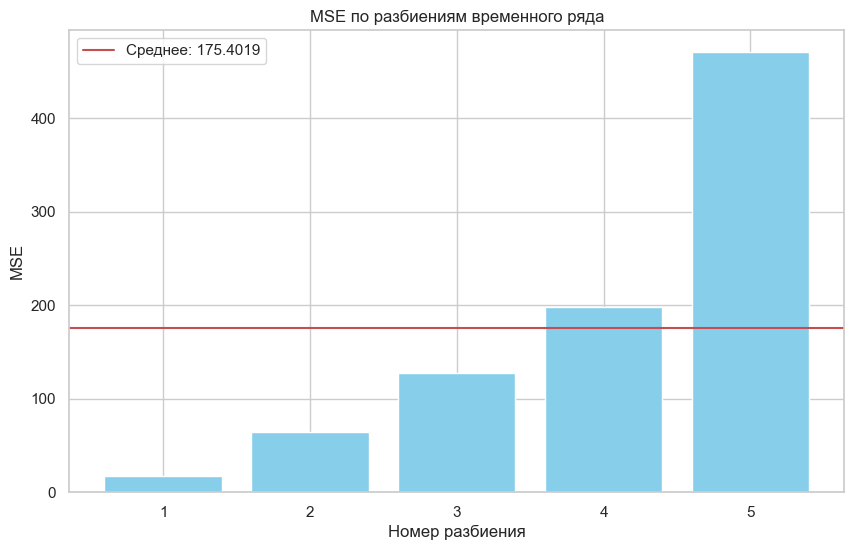

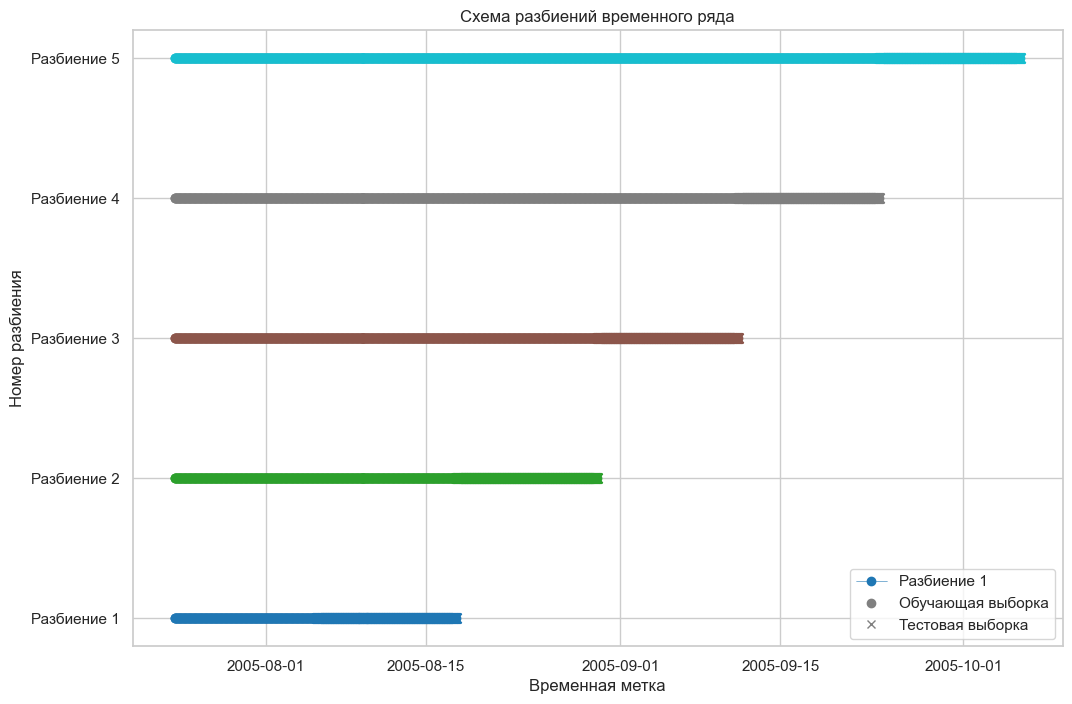

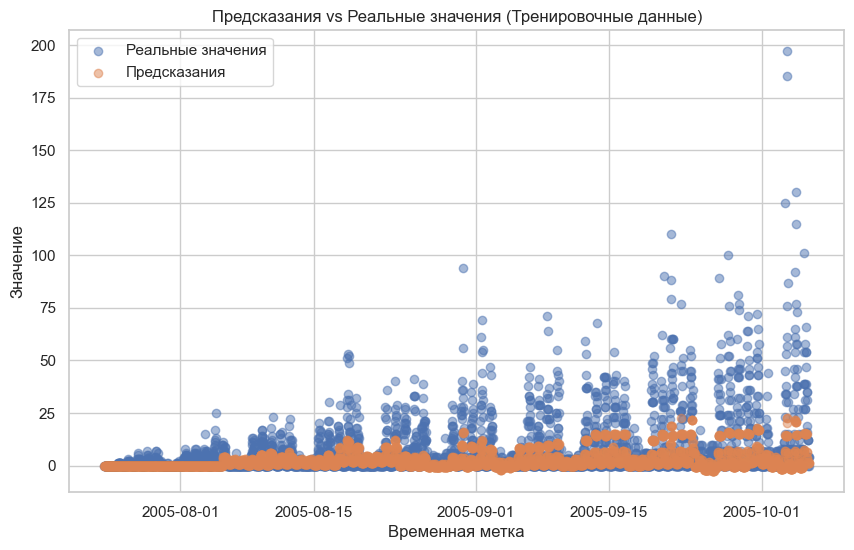

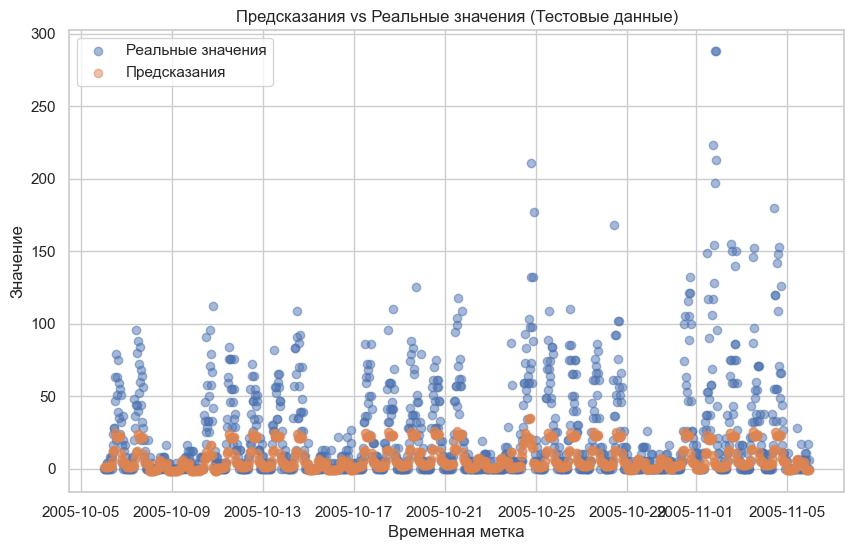

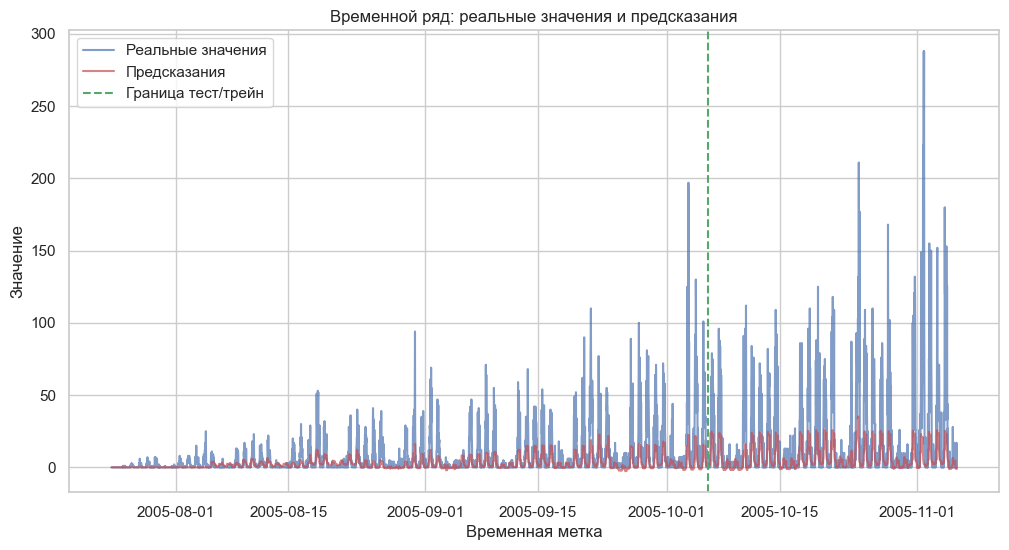

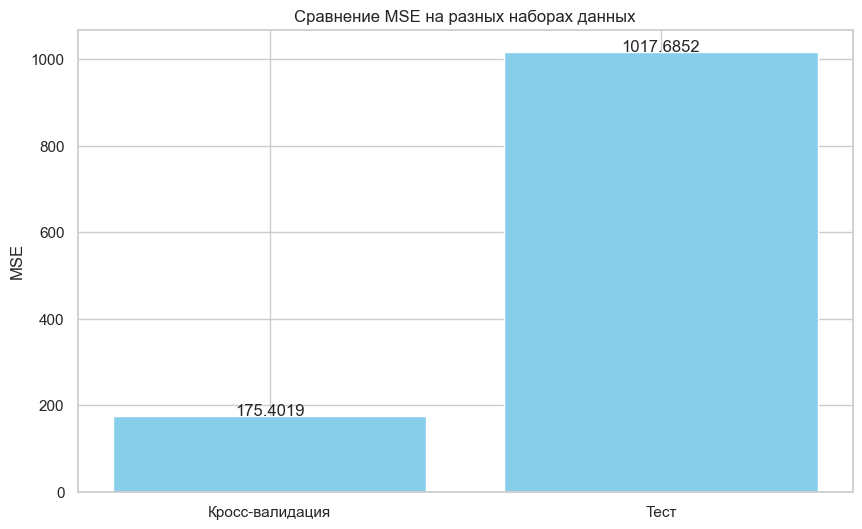

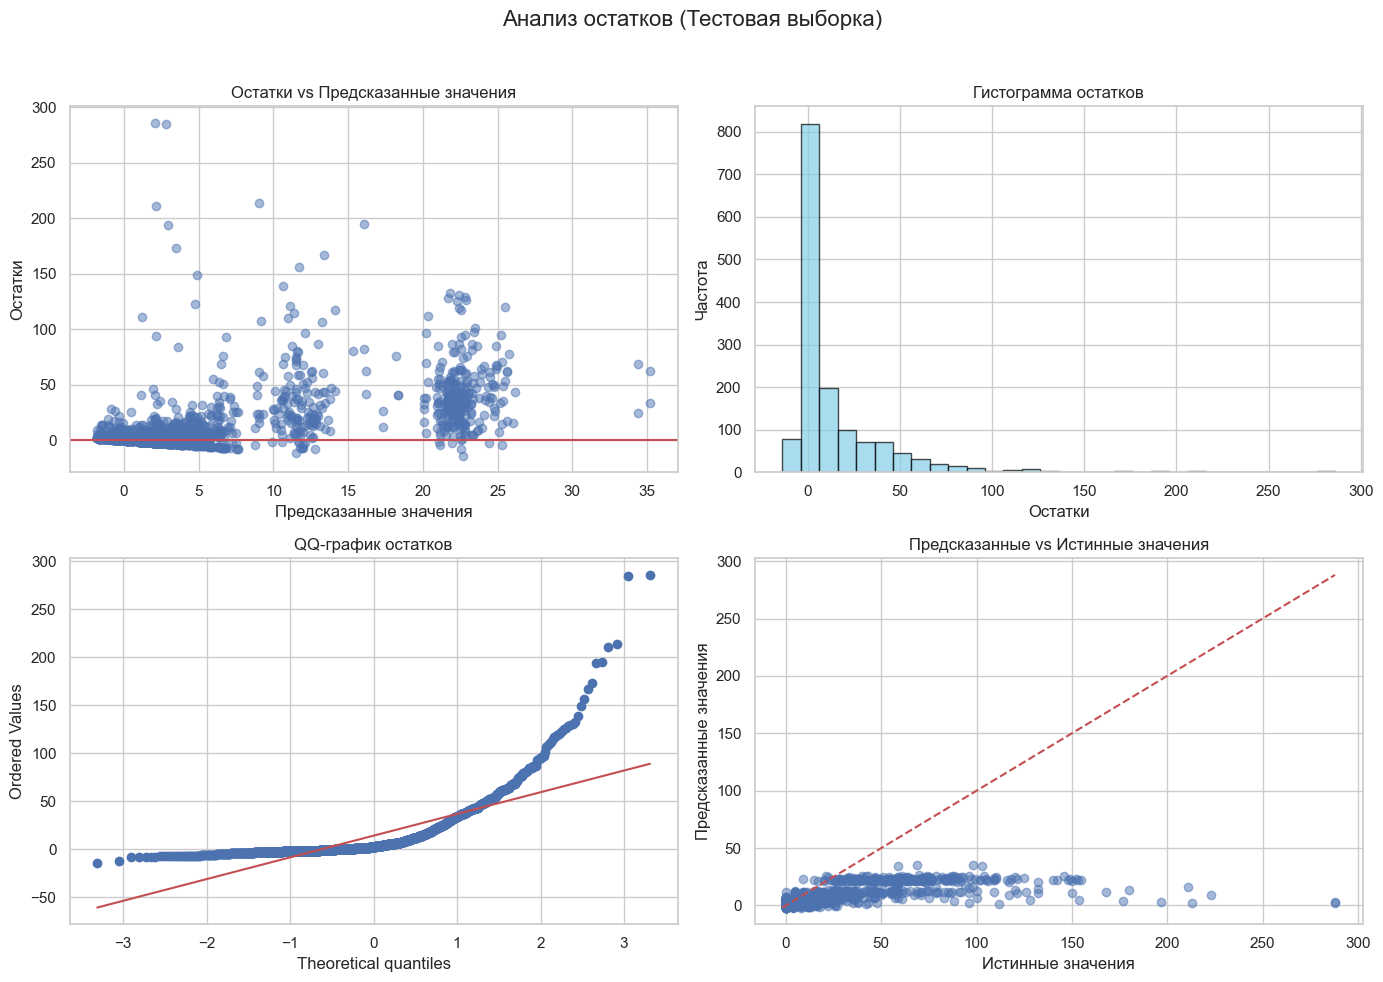

mae           15.898272
rmse          31.901179
r2             0.095821
smape        143.504861
mase           1.274505
mae_zero      24.298977
rmse_zero     33.548990
dtype: float64


In [157]:
def hyperopt_with_custom_cv(X_train, y_train, X_test, y_test, time_col, n_iter=100, n_splits=5, gap=0):
    print("\nЗапуск Hyperopt с временной кросс-валидацией...")
    start_time_hyperopt = time.time()

    space = {
        'n_estimators': hp.quniform('n_estimators', 10, 100, 10),
        'max_depth': hp.quniform('max_depth', 2, 4, 1),
        'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
        'subsample': hp.uniform('subsample', 0.6, 1.0),
        'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0),
        'min_child_weight': hp.quniform('min_child_weight', 1, 7, 2),
        'gamma': hp.uniform('gamma', 0, 0.4)
    }

    def objective(params):
        model_params = {
            'n_estimators': int(params['n_estimators']),
            'max_depth': int(params['max_depth']),
            'learning_rate': params['learning_rate'],
            'subsample': params['subsample'],
            'colsample_bytree': params['colsample_bytree'],
            'min_child_weight': int(params['min_child_weight']),
            'gamma': params['gamma'],
            'random_state': 42,
            'n_jobs': -1
        }

        model = xgb.XGBRegressor(**model_params)

        cv_results, _ = time_series_cross_validation(
            X_train=X_train,
            y_train=y_train,
            X_test=X_test,
            y_test=y_test,
            model=model,
            n_splits=n_splits,
            gap=gap,
            time_col=time_col,
            visualize=False
        )

        return {'loss': cv_results['val_mse'], 'status': STATUS_OK, 'params': model_params}

    hyperopt_pbar = tqdm(total=n_iter, desc="Hyperopt")
    trials = Trials()

    def objective_with_progress(params):
        result = objective(params)
        hyperopt_pbar.update(1)
        return result

    best_hyperopt = fmin(
        fn=objective_with_progress,
        space=space,
        algo=tpe.suggest,
        max_evals=n_iter,
        trials=trials,
        verbose=0
    )

    hyperopt_pbar.close()
    time_hyperopt = time.time() - start_time_hyperopt

    best_trial_idx = np.argmin([t['result']['loss'] for t in trials.trials])
    best_params_hyperopt = trials.trials[best_trial_idx]['result']['params']
    best_score_hyperopt = trials.trials[best_trial_idx]['result']['loss']

    print(f"\nHyperopt завершен за {time_hyperopt:.2f} секунд")
    print(f"Лучшие параметры: {best_params_hyperopt}")
    print(f"Лучший CV score (val MSE): {best_score_hyperopt:.4f}")

    # Финальное обучение + валидация с визуализациями
    best_model = xgb.XGBRegressor(**best_params_hyperopt)

    final_cv_results, final_model = time_series_cross_validation(
        X_train=X_train,
        y_train=y_train,
        X_test=X_test,
        y_test=y_test,
        model=best_model,
        n_splits=n_splits,
        gap=gap,
        time_col=time_col,
        visualize=True
    )

    # Метрики
    metrics = metrics_report(y_test, final_cv_results['test_predictions'], task='regression')

    return metrics, final_cv_results, final_model

hyperopt_metrics, final_cv_results, final_model = hyperopt_with_custom_cv(
    X_train=train[model_features_regression + ['dt']],
    y_train=train['cnt'],
    X_test=test[model_features_regression + ['dt']],
    y_test=test['cnt'],
    time_col='dt',
    n_iter=500,
    n_splits=5,
    gap=0
)
print(hyperopt_metrics)

### 3. Оценить качество решения задач  

In [164]:
model_features_classification

['cnt_roll_mean_6',
 'cnt_cubed',
 'cnt_log',
 'cnt_roll_mean_12',
 'cnt_roll_mean_3',
 'cnt',
 'time_of_day_morning',
 'day_of_week',
 'is_weekend']

##### Результаты решения задачи классификации

**Использованный порог:** `0.01`  
**Лучший CV score (recall):** `0.2345`

| Метрика     | Значение | Интерпретация                                                                 |
|-------------|----------|--------------------------------------------------------------------------------|
| Accuracy    | 0.6151   | Общая доля правильных предсказаний |
| Precision   | 0.0490   | Доля корректно предсказанных положительных примеров (факт наличия события) среди всех предсказанных как "1". |
| Recall      | 0.7632   | Доля корректно найденных "единиц" из всех настоящих "единиц". Основная целевая метрика. |
| F1-score    | 0.0921   | Гармоническое среднее между precision и recall. Не приоритет в решаемой задаче |


##### **Выводы:**
- Благодаря низкому трешхолду удалось добиться очень высокого recall - почти 76%, что позволяет захватывать почти все положительные случаи.
- Однако precision крайне низкий, модель часто ошибается, предсказывая "1" там, где на самом деле "0".
- Такой подход может быть оправдан, если цена пропуска события (ложный отрицательный) выше, чем ложного срабатывания (ложный положительный).
- Для улучшения можно подбирать трешхолд в зависимости от бизнес-задачи или рассмотреть балансировку классов.


##### Результаты решения задачи регрессии

| Метрика     | Значение  | Интерпретация                                                                 |
|-------------|-----------|------------------------------------------------------------------------------|
| MAE         | 15.8983   | Среднее абсолютное отклонение       |
| RMSE        | 31.9012   | Сильнее штрафует большие ошибки, чем MAE    |
| R²          | 0.0958    | Модель объясняет лишь ~9.6% дисперсии данных. Очень слабое качество прогноза. |
| SMAPE       | 143.50%   | Симметричная ошибка - крайне высока. Ошибки прогноза в среднем выше самих значений. |
| MASE        | 1.2745    | Прогноз хуже наивного (MASE > 1).                                            |

##### **Выводы:**
- Так как исходных данных мало, а признаков со стороны задание брать не разрешало, думаю, нужно очень кропотливо рассмотреть все возможные лаги и признаки; можно более плотно поработать над датами.
- В целом, основная проблема в нехватке признаков для предсказания. Модель не может уловить закономерности, которых просто нет в данных.
- Также возможна нестабильность целевой переменной (`cnt`) - большое число аномальных скачков в распределении, особенно в случае мероприятий (модели крайне тяжело подстроиться под такие пики);
- Для повышения качества прогноза необходим расширенный feature engineering, а также работа с крайне тяжелой для моделирования сезонностью.

### 4. Описание используемых метрик и обоснование выбора

##### Для задачи **классификации**:
- Основной метрикой был выбран `recall`.
- **Причина**: важно максимально улавливать все положительные случаи (например, факт события), даже если при этом могут быть ложные срабатывания.
- **Важное замечание** - крайне важен подбор оптимального трешхолда. Без понимания бизнес-задачи сложно сказать наверняка, какой порог стоит выбрать, поэтому использовано приблизительное значение. В коде трешхолд легко настраивается, и при появлении более точной информации можно будет принять соответствующее решение.

##### Для задачи **регрессии**:

Использовались следующие ключевые метрики:

**1. MAE (Mean Absolute Error)**  
Показывает среднее абсолютное отклонение прогноза от факта:

$$
MAE = \text{mean}(|y_t - \hat{y}_t|)
$$

**2. RMSE (Root Mean Squared Error)**  
Сильнее штрафует большие отклонения от факта:

$$
RMSE = \sqrt{\text{mean}((y_t - \hat{y}_t)^2)}
$$

MAE и RMSE часто используются вместе: MAE показывает среднюю по модулю ошибку, RMSE - чувствителен к выбросам. RMSE стремится минимизировать **среднее** отклонение, MAE - **медианное**. Поэтому RMSE сильнее наказывает за крупные ошибки.

**3. MASE (Mean Absolute Scaled Error)**  
Сравнивает модель с наивным прогнозом. Для сезонных данных наивный прогнозь- это значение предыдущего сезона:

$$
MASE = \frac{\text{mean}(|y_t - \hat{y}_t|)}{\frac{1}{T - m} \sum_{t = m+1}^{T} |y_t - y_{t - m}|}
$$

Где $m$ - сезонность (например, 12 для месячных данных с годовой сезонностью).  
Интерпретация:
- $MASE > 1$ - модель хуже наивной
- $MASE < 1$ - модель лучше наивной (желаемый результат)

Метрики `MAPE` и `MDAPE` **не использовались**, так как нестабильны при $y_t \approx 0$ и могут приводить к искажённой интерпретации.